In [1]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import bayes3d.genjax
import numpy as np
import genjax
import matplotlib
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import optax

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7018/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
train_data_file = jnp.load('train_data.npz')
test_data_file = jnp.load('test_data.npz')
test_imgs = test_data_file['arr_0']
test_labels = test_data_file['arr_1']
test_imgs.shape

(2000, 100, 100, 1)

In [5]:
import trimesh
box_width = 0.02
hammer_width = 0.05
hand_length = 0.15
b1 = trimesh.creation.box(
    np.array(jnp.array([hand_length, box_width,box_width])),
    np.array(b.transform_from_pos(jnp.array([0.0, 0.0, 0.0])))
)
b2 = trimesh.creation.box(
    np.array(jnp.array([hammer_width,hammer_width, hammer_width])),
    np.array(b.transform_from_pos(jnp.array([hand_length/2 - hammer_width/2, 0.0, 0.0])))
)
b3 = trimesh.creation.box(
    np.array(jnp.array([hammer_width,hammer_width, hammer_width])),
    np.array(b.transform_from_pos(jnp.array([-hand_length/2 + hammer_width/2, 0.0, 0.0, ])))
)
m1 = trimesh.util.concatenate([b1,b2])
m2 = trimesh.util.concatenate([b1,b2,b3])
b.show_trimesh("1", m2)

b.utils.mesh.export_mesh(m1, "m1.obj")
b.utils.mesh.export_mesh(m2, "m2.obj")
table_mesh_path = b.utils.get_assets_dir() + '/sample_objs/cube.obj'

box_mesh = b.utils.make_cuboid_mesh(jnp.array([0.1, 0.1, 0.2]))
b.RENDERER.add_mesh(m1)
b.RENDERER.add_mesh(m2)
b.RENDERER.add_mesh(box_mesh)
# b.RENDERER.add_mesh_from_file(box_mesh_path, scaling_factor=1e-3)
b.RENDERER.add_mesh_from_file(table_mesh_path, scaling_factor=1e-6)

# b.clear()
# b.show_trimesh("1", b.RENDERER.meshes[FORK_IDX])
# b.show_trimesh("2", b.RENDERER.meshes[KNIFE_IDX])

# fork_mesh_path = b.utils.get_assets_dir() + '/ycb_video_models/models/030_fork/nontextured.ply'
# knife_mesh_path = b.utils.get_assets_dir() + '/ycb_video_models/models/032_knife/nontextured.ply'
# box_mesh_path = b.utils.get_assets_dir() + '/bop/ycbv/models/obj_000002.ply'

# fork_scale = knife_scale = 1.0
# box_scale = 1e-3
# table_scale = 1e-6
# mesh_paths = (fork_mesh_path, knife_mesh_path, box_mesh_path, table_mesh_path)
# scales = (fork_scale, knife_scale, box_scale, table_scale)
# for mesh_path, scale in zip(mesh_paths, scales):
#     b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=scale)

In [6]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.7, 0.5]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
importance_jit = jax.jit(b.model.importance)
update_jit = jax.jit(b.model.update)
enumerators = b.make_enumerator(["contact_params_2"])

In [7]:
# del importance_jit
# del update_jit

In [8]:
def make_orientation_posterior_viz(observation, is_fork, bars):
    fig = plt.figure(constrained_layout=True)
    fig.suptitle(f"is_fork: {is_fork}")
    widths = [1, 1]
    heights = [2]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    
    ax = fig.add_subplot(spec[0, 0])
    ax.imshow(jnp.array(b.get_depth_image(observation[...,2])))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.set_title(f"Observation (params {gt_contact[0]:0.2f} {gt_contact[1]:0.2f} {gt_contact[2]:0.2f})")
    ax.set_title(f"Observed Depth")
    
    
    ax = fig.add_subplot(spec[0, 1])
    ax.bar(["knife", "fork"], bars)
    ax.set_ylim(0.0, 1.0)
    return fig

In [9]:
key = jax.random.PRNGKey(10000)

In [10]:
FORK_IDX, KNIFE_IDX, CHEESEITZ_BOX_IDX, TABLE_IDX = 0, 1, 2, 3
SHIFT_MIN = -0.3
SHIFT_SCALE = 0.6
CHEESEITZ_BOX_CONTACT_PARAMS = jnp.array([0.0, 0.2, 0.0])

contact_param_grid = jax.vmap(
    lambda shift: jnp.array([shift, 0, jnp.pi/2])
)(jnp.linspace(SHIFT_MIN, SHIFT_MIN+SHIFT_SCALE, 2000))

In [11]:
enumerators = b.make_enumerator(["contact_params_2"])
def c2f_contact_update(trace_, key, contact_param_deltas):
    contact_param_grid = contact_param_deltas + trace_[f"contact_params_2"]
    scores = enumerators[3](trace_, key, contact_param_grid)
    i = scores.argmax()
    return enumerators[0](
        trace_, key,
        contact_param_grid[i]
    )
c2f_contact_update_jit = jax.jit(c2f_contact_update)

grid_params = [
    (0.5, jnp.pi, (15,15,15)), (0.4, jnp.pi, (15,15,15)), (0.2, jnp.pi, (15,15,15)),
    (0.1, jnp.pi/3, (15,15,15)), (0.02, jnp.pi, (9,9,51)), (0.01, jnp.pi/5, (15,15,15)), (0.01, 0.0, (31,31,1)),(0.05, 0.0, (31,31,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

In [12]:
# shift_sweep = jnp.linspace(SHIFT_MIN, SHIFT_MIN+SHIFT_SCALE, 15*15*15)
# grid = jnp.vstack(
#     [shift_sweep*jnp.cos(jnp.pi/12), -0.05 + shift_sweep*jnp.sin(jnp.pi/12), 10*jnp.pi/12 + (shift_sweep * 0.0)]
# ).transpose()
# grid.shape

# contact_param_gridding_schedule = [grid]

In [13]:
def fork_spoon_generator(shift, is_fork):

    #indices = jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, FORK_IDX if is_fork else KNIFE_IDX])
    indices = jax.lax.cond(is_fork,
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, FORK_IDX]),
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, KNIFE_IDX]))

    box_dims = b.RENDERER.model_box_dims[indices]
    root_poses = jnp.array([table_pose, table_pose, table_pose])
    parents = jnp.array([-1, 0, 0])
    contact_params = jnp.array([[0.0, 0.0, 0.0],
                                [*CHEESEITZ_BOX_CONTACT_PARAMS],
                                [shift, 0, jnp.pi/2]])
    faces_parents = jnp.array([0, 2, 2])
    faces_child = jnp.array([0, 3, 3])
    poses = b.scene_graph.poses_from_scene_graph(
        root_poses, box_dims, parents, contact_params, faces_parents, faces_child)
    camera_pose = jnp.eye(4)
    final_poses = jnp.linalg.inv(camera_pose) @ poses
    rendered = b.RENDERER.render(
        final_poses , indices
    )[...,:3]
    return rendered, final_poses, indices
fork_spoon_generator_jit = jax.jit(fork_spoon_generator)

In [14]:
# del fork_spoon_generator_jit

In [24]:
data = []

-0.06452215 False
-18306.934


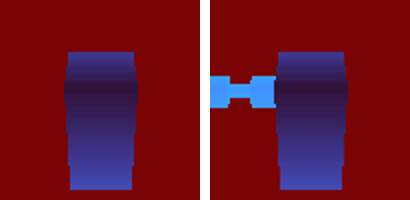

In [35]:
key = jax.random.split(key, 1)[0]
is_fork = jax.random.bernoulli(key)
key = jax.random.split(key, 1)[0]
shift = SHIFT_MIN + SHIFT_SCALE * jax.random.uniform(key)
print(shift, is_fork)
shift = 0.15
is_fork = False
observation, final_poses, indices = fork_spoon_generator_jit(shift, is_fork)

weight, trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "parent_2": 0,
    "id_0": jnp.int32(3),
    "id_1": jnp.int32(CHEESEITZ_BOX_IDX),
    "id_2": (jnp.int32(FORK_IDX) if is_fork else jnp.int32(KNIFE_IDX)),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 2,
    "face_parent_2": 2,
    "face_child_1": 3,
    "face_child_2": 3,
    "variance": 0.001,
    "outlier_prob": 0.001,
    "image": observation[...,:3],
    "contact_params_1": CHEESEITZ_BOX_CONTACT_PARAMS,
    "contact_params_2": jnp.array([0.0, 0.0, 0.0])
}), (
    jnp.arange(3),
    jnp.arange(4),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, 1.0, intrinsics.fx)
)
original_trace = trace

print(trace.get_score())

b.viz_trace_meshcat(trace)
b.viz_trace_rendered_observed(trace)

[1. 0.]


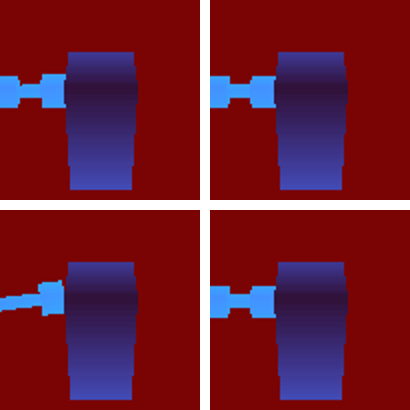

In [36]:
trace = update_jit(key, original_trace, genjax.choice_map({"id_2": KNIFE_IDX}), b.make_unknown_change_argdiffs(trace))[2]
b.viz_trace_rendered_observed(trace)
path = []
path.append(trace)
for c2f_iter in range(len(contact_param_gridding_schedule)):
    trace = c2f_contact_update_jit(trace, key, contact_param_gridding_schedule[c2f_iter])
    path.append(trace)
best_trace1 = path[-1]

trace = update_jit(key, original_trace, genjax.choice_map({"id_2": FORK_IDX}), b.make_unknown_change_argdiffs(trace))[2]
b.viz_trace_rendered_observed(trace)
path = []
path.append(trace)
for c2f_iter in range(len(contact_param_gridding_schedule)):
    trace = c2f_contact_update_jit(trace, key, contact_param_gridding_schedule[c2f_iter])
    path.append(trace)
best_trace2 = path[-1]

log_scores = jnp.array([best_trace1.get_score(), best_trace2.get_score()])
print(b.utils.normalize_log_scores(log_scores))


b.vstack_images([
        b.viz_trace_rendered_observed(best_trace1),
        b.viz_trace_rendered_observed(best_trace2),
])

In [37]:
data.append((final_poses, indices, b.utils.normalize_log_scores(log_scores)))
print(len(data))

4


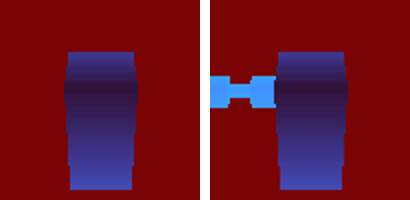

In [38]:
b.viz_trace_rendered_observed(original_trace)

In [39]:
def get_depth_image_alternate(depth):
    far = jnp.max(depth)
    minval = jnp.min(depth[depth > jnp.min(depth)])
    maxval = jnp.max(depth[depth < jnp.max(depth)])
    depth = depth.at[depth >= far].set(jnp.nan)
    viz_img = np.array(b.get_depth_image(
       depth, min=minval,  max=maxval
    ))
    viz_img[viz_img.sum(-1) == 0,:] = 255.0
    return viz_img




In [40]:
scaled_up_intrinsics = b.scale_camera_parameters(intrinsics, 4)

In [41]:
b.setup_renderer(scaled_up_intrinsics)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (416, 416, 1024)


In [42]:
b.RENDERER.add_mesh(m1)
b.RENDERER.add_mesh(m2)
b.RENDERER.add_mesh(box_mesh)
# b.RENDERER.add_mesh_from_file(box_mesh_path, scaling_factor=1e-3)
b.RENDERER.add_mesh_from_file(table_mesh_path, scaling_factor=1e-6)


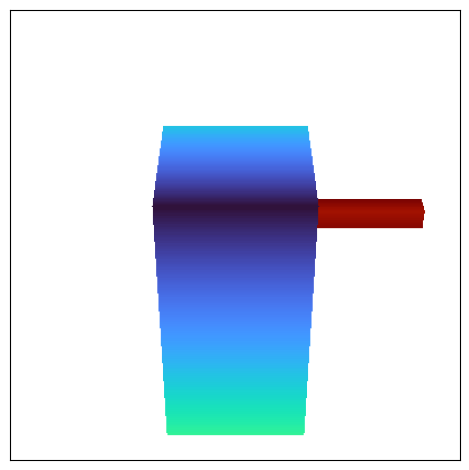

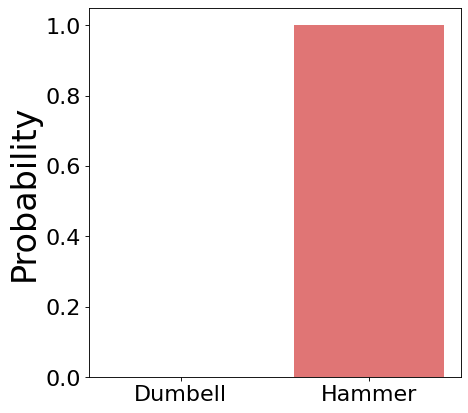

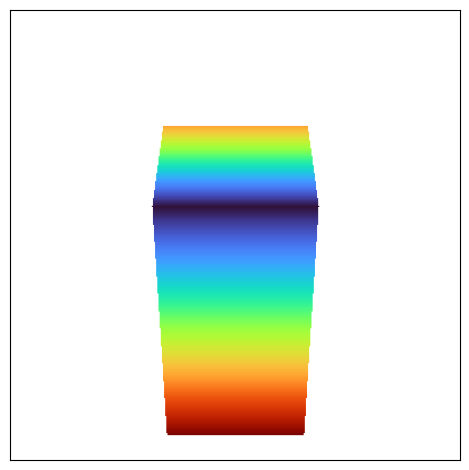

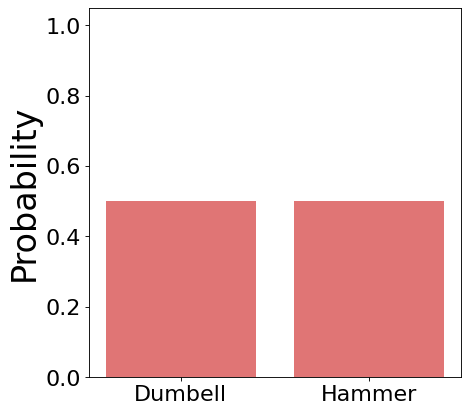

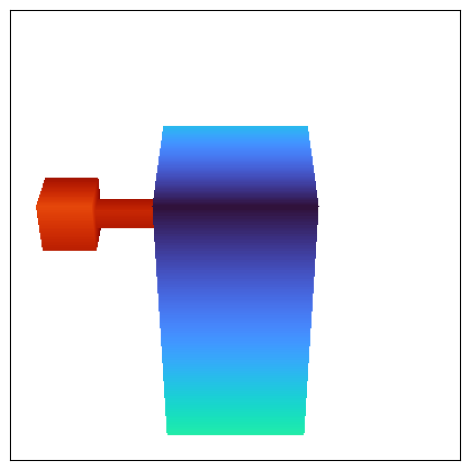

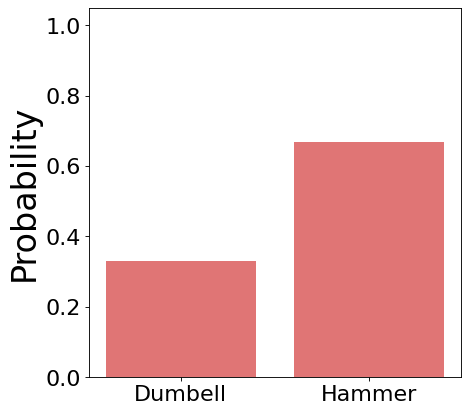

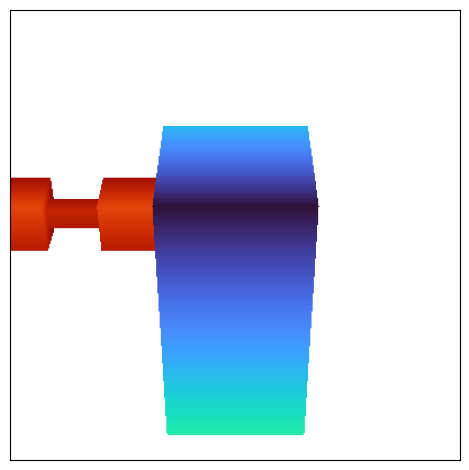

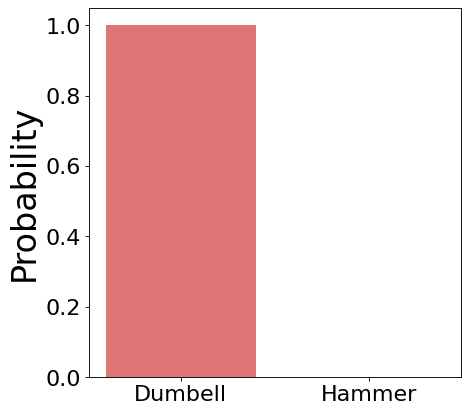

In [63]:
for IDX in range(len(data)):
    img = b.RENDERER.render(data[IDX][0], data[IDX][1])
    viz_img = get_depth_image_alternate(img[:,:,2])
    plt.figure()
    plt.imshow(viz_img)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(f"{IDX}_render.pdf")
    
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 6), dpi=80)
    plt.bar(["Dumbell", "Hammer"], data[IDX][2], color=(0.8, 0.1, 0.1, 0.6))
    plt.ylim(0.0, 1.05)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylabel("Probability", fontsize=30)
    plt.savefig(f"{IDX}_inferred.pdf")

[0.01640201 0.98353547]


In [ ]:
IDX = 44
cross_entropies = []
for IDX in tqdm(range(2000)):
    print(IDX)
    key = jax.random.split(key, 1)[0]
    is_fork = jax.random.bernoulli(key)
    key = jax.random.split(key, 1)[0]
    shift = SHIFT_MIN + SHIFT_SCALE * jax.random.uniform(key)
    print(shift, is_fork)
    observation = fork_spoon_generator_jit(shift, is_fork)
    
    weight, trace = importance_jit(key, genjax.choice_map({
        "parent_0": -1,
        "parent_1": 0,
        "parent_2": 0,
        "id_0": jnp.int32(3),
        "id_1": jnp.int32(CHEESEITZ_BOX_IDX),
        "id_2": (jnp.int32(FORK_IDX) if is_fork else jnp.int32(KNIFE_IDX)),
        "camera_pose": jnp.eye(4),
        "root_pose_0": table_pose,
        "face_parent_1": 2,
        "face_parent_2": 2,
        "face_child_1": 3,
        "face_child_2": 3,
        "variance": 0.00005,
        "outlier_prob": 0.01,
        "image": b.unproject_depth(test_imgs[IDX,...,-1], intrinsics),
        "contact_params_1": CHEESEITZ_BOX_CONTACT_PARAMS,
        # "contact_params_2": jnp.array([0.0, 0.0, 0.0])
    }), (
        jnp.arange(3),
        jnp.arange(4),
        jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
        jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
        b.RENDERER.model_box_dims, 1.0, intrinsics.fx)
    )
    original_trace = trace
    print(trace.get_score())
    
    trace = update_jit(key, original_trace, genjax.choice_map({"id_2": KNIFE_IDX}), b.make_unknown_change_argdiffs(trace))[2]
    b.viz_trace_rendered_observed(trace)
    path = []
    path.append(trace)
    for c2f_iter in range(len(contact_param_gridding_schedule)):
        trace = c2f_contact_update_jit(trace, key, contact_param_gridding_schedule[c2f_iter])
        path.append(trace)
    print(trace["contact_params_2"])
    best_trace1 = path[-1]
    
    trace = update_jit(key, original_trace, genjax.choice_map({"id_2": FORK_IDX}), b.make_unknown_change_argdiffs(trace))[2]
    b.viz_trace_rendered_observed(trace)
    path = []
    path.append(trace)
    for c2f_iter in range(len(contact_param_gridding_schedule)):
        trace = c2f_contact_update_jit(trace, key, contact_param_gridding_schedule[c2f_iter])
        path.append(trace)
    print(trace["contact_params_2"])
    best_trace2 = path[-1]
    
    log_scores = jnp.array([best_trace1.get_score(), best_trace2.get_score()])
    cross_entropies.append(optax.softmax_cross_entropy(log_scores, test_labels[IDX]))
    print(b.utils.normalize_log_scores(log_scores))
    print(test_labels[IDX])
    print("cross entropy: ", cross_entropies[-1])
    print("cross entropy mean: ", jnp.mean(jnp.array(cross_entropies)))
        # b.viz_trace_meshcat(trace)
        # b.viz_trace_rendered_observed(trace)
        
        # b.vstack_images([
        #         b.viz_trace_rendered_observed(best_trace1),
        #         b.viz_trace_rendered_observed(best_trace2),
        # ])

  0%|                                                                                                                                                                                                         | 1/2000 [00:00<05:27,  6.10it/s]

0
0.17019792 False
24887.186
[-0.1174914  -0.08148172  2.6179938 ]
[-0.11829299 -0.08169651  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  -0.0
1
0.08150263 False
25992.977


  0%|▎                                                                                                                                                                                                        | 3/2000 [00:00<04:47,  6.95it/s]

[ 0.13730232 -0.01320995  2.6179938 ]
[ 0.1379894  -0.01302585  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.0
2
0.050526425 True
25991.986
[ 0.03652999 -0.04021182  2.6179938 ]
[ 0.03652999 -0.04021182  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.23104906
3


  0%|▍                                                                                                                                                                                                        | 4/2000 [00:00<04:46,  6.96it/s]

0.016378641 False
28605.78
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.3465736
4
-0.1222579 False
26637.592


  0%|▌                                                                                                                                                                                                        | 6/2000 [00:00<04:42,  7.06it/s]

[-0.1870014  -0.10010688  2.6179938 ]
[-0.18093216 -0.09848063  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.27725887
5
-0.17109232 True
25994.377
[-0.10226101 -0.07740076  2.6179938 ]
[-0.10054331 -0.0769405   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.23104906
6


  0%|▋                                                                                                                                                                                                        | 7/2000 [00:01<04:42,  7.05it/s]

0.008034989 True
27884.402
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.29706308
7
-0.093178324 True
26148.744


  0%|▊                                                                                                                                                                                                        | 8/2000 [00:01<04:42,  7.05it/s]

[-0.03973637 -0.06064733  2.6179938 ]
[-0.04717978 -0.06264178  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.2599302
8
0.11412944 False
26584.97
[ 0.02084156 -0.04441552  2.6179938 ]
[ 0.02084156 -0.04441552  2.6179938 ]


  0%|█                                                                                                                                                                                                       | 10/2000 [00:01<04:43,  7.02it/s]

[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.3080654
9
0.12151189 True
24667.094
[-0.14073774 -0.08771057  2.6179938 ]
[-0.14153934 -0.08792535  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.27725887
10
-0.0508966 False
23839.525


  1%|█▏                                                                                                                                                                                                      | 12/2000 [00:01<04:41,  7.07it/s]

[-0.15963256 -0.09277342  2.6179938 ]
[-0.15596811 -0.09179153  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.25205353
11
-0.02674064 False
23987.213
[ 0.14508928 -0.01112344  2.6179938 ]
[ 0.14669247 -0.01069387  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.23104906


  1%|█▎                                                                                                                                                                                                      | 13/2000 [00:01<04:44,  6.98it/s]

12
0.07230072 True
27893.248
[ 0.07134225 -0.0308839   2.6179938 ]
[ 0.07935823 -0.02873603  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.21327606
13
-0.051928803 True
25706.248


  1%|█▍                                                                                                                                                                                                      | 14/2000 [00:02<04:46,  6.92it/s]

[-0.12951536 -0.08470353  2.6179938 ]
[-0.12962988 -0.08473422  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.19804206
14
0.12325744 True
26188.377
[ 0.16856466 -0.00483323  2.6179938 ]
[ 0.1702824  -0.00437297  2.6179938 ]


  1%|█▌                                                                                                                                                                                                      | 16/2000 [00:02<04:47,  6.91it/s]

[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.18483926
15
-0.17899323 True
27906.473
[-0.02759787 -0.05739483  2.6179938 ]
[-0.0415686  -0.06113827  2.6179938 ]
[1.0000000e+00 2.5261952e-33]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.1732868
16
-0.08967686 True
25935.373


  1%|█▋                                                                                                                                                                                                      | 17/2000 [00:02<04:45,  6.94it/s]

[ 0.09905464 -0.02345839  2.6179938 ]
[ 0.10374971 -0.02220035  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.16309346
17
-0.19272934 True
23598.957
[ 0.14268449 -0.01176781  2.6179938 ]
[ 0.14314254 -0.01164507  2.6179938 ]


  1%|█▉                                                                                                                                                                                                      | 19/2000 [00:02<04:49,  6.85it/s]

[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.1540327
18
-0.099368766 False
28222.76
[-0.02507858 -0.05671979  2.6179938 ]
[-0.03721705 -0.05997228  2.6179938 ]
[1.000000e+00 3.818542e-26]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.14592573
19
-0.08194671 False
25938.049


  1%|██                                                                                                                                                                                                      | 20/2000 [00:02<04:48,  6.86it/s]

[ 0.04660722 -0.03751163  2.6179938 ]
[ 0.04660722 -0.03751163  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.1732868
20
-0.12979373 True
28086.936
[-0.03240747 -0.05868356  2.6179938 ]
[-0.04385888 -0.06175195  2.6179938 ]
[1.e+00 6.e-45]
[1. 0.]
cross entropy:  

  1%|██▏                                                                                                                                                                                                     | 22/2000 [00:03<04:46,  6.92it/s]

-0.0
cross entropy mean:  0.16503504
21
0.099311695 True
28575.87
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03206392 -0.0585915   2.6179938 ]
[6.21571e-07 1.00000e+00]
[0. 1.]
cross entropy:  5.960463e-07
cross entropy mean:  0.15753348
22
-0.1435781 False
25252.057


  1%|██▎                                                                                                                                                                                                     | 23/2000 [00:03<04:46,  6.91it/s]

[-0.08932094 -0.07393347  2.6179938 ]
[-0.09218378 -0.07470057  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.1506842
23
-0.18589024 True
26060.78
[ 0.08680164 -0.02674157  2.6179938 ]
[ 0.0963063 -0.0241948  2.6179938]


  1%|██▌                                                                                                                                                                                                     | 25/2000 [00:03<04:48,  6.86it/s]

[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.1444057
24
-0.12233849 False
23033.986
[ 0.1003143  -0.02312087  2.6179938 ]
[ 0.10500937 -0.02186283  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.13862945
25
0.19769473 True
26425.697


  1%|██▌                                                                                                                                                                                                     | 26/2000 [00:03<04:48,  6.84it/s]

[ 0.06653266 -0.03217263  2.6179938 ]
[ 0.0716858  -0.03079185  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.13329756
26
-0.10202437 False
24717.787
[-0.16867916 -0.09519745  2.6179938 ]
[-0.16295347 -0.09366325  2.6179938 ]


  1%|██▊                                                                                                                                                                                                     | 28/2000 [00:04<04:47,  6.85it/s]

[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12836061
27
0.07479663 False
26486.58
[-0.14841019 -0.08976639  2.6179938 ]
[-0.14715053 -0.08942887  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.1237763
28
0.092831716 True
26778.713


  1%|██▉                                                                                                                                                                                                     | 29/2000 [00:04<04:47,  6.86it/s]

[-0.09905462 -0.0765416   2.6179938 ]
[-0.10054331 -0.0769405   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11950815
29
0.16425072 False
24755.977
[-0.1485247  -0.08979707  2.6179938 ]


  2%|███                                                                                                                                                                                                     | 31/2000 [00:04<04:51,  6.76it/s]

[-0.14909726 -0.08995049  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11552455
30
-0.06553173 True
22472.467
[-0.15138754 -0.09056418  2.6179938 ]
[-0.1469215  -0.08936749  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11179794
31
0.14492436 True
27813.627


  2%|███▏                                                                                                                                                                                                    | 32/2000 [00:04<04:52,  6.73it/s]

[-0.07557926 -0.07025141  2.6179938 ]
[-0.07351801 -0.06969909  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.10830426
32
-0.19714485 False
24523.652
[ 0.15963258 -0.00722658  2.6179938 ]
[ 0.16169383 -0.00667427  2.6179938 ]


  2%|███▍                                                                                                                                                                                                    | 34/2000 [00:04<04:51,  6.75it/s]

[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.10502232
33
-0.16635509 False
26545.01
[ 0.04053797 -0.03913788  2.6179938 ]
[ 0.04053797 -0.03913788  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.12232011
34
0.09528567 False
23876.293


  2%|███▌                                                                                                                                                                                                    | 35/2000 [00:05<04:51,  6.75it/s]

[-0.15196012 -0.09071759  2.6179938 ]
[-0.15138754 -0.09056418  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11882524
35
0.13204361 True
27717.562
[-0.00847402 -0.05227061  2.6179938 ]
[-0.02771239 -0.05742551  2.6179938 ]


  2%|███▋                                                                                                                                                                                                    | 37/2000 [00:05<04:56,  6.63it/s]

[3.024739e-04 1.000000e+00]
[0. 1.]
cross entropy:  0.00030238825
cross entropy mean:  0.11553294
36
0.1947303 False
25521.893
[ 0.05244744 -0.03594675  2.6179938 ]
[ 0.05244744 -0.03594675  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.13114414
37
-0.11615858 False
28429.072


  2%|███▊                                                                                                                                                                                                    | 38/2000 [00:05<04:59,  6.55it/s]

[-0.00480957 -0.05128872  2.6179938 ]
[-0.02118509 -0.05567653  2.6179938 ]
[0.00405497 0.99610144]
[0. 1.]
cross entropy:  0.0040626144
cross entropy mean:  0.12779988
38
-0.08929825 True
27366.85
[ 0.0562264  -0.03493418  2.6179938 ]


  2%|████                                                                                                                                                                                                    | 40/2000 [00:05<04:58,  6.58it/s]

[ 0.0562264  -0.03493418  2.6179938 ]
[0.01806693 0.9825755 ]
[0. 1.]
cross entropy:  0.018220315
cross entropy mean:  0.12499016
39
-0.160184 False
25351.283
[ 0.16856466 -0.00483323  2.6179938 ]
[ 0.1702824  -0.00437297  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12186541
40
-0.14184026 True
24972.912


  2%|████                                                                                                                                                                                                    | 41/2000 [00:06<04:57,  6.59it/s]

[1.8883367e-01 5.9782714e-04 2.6179938e+00]
[1.9020782e-01 9.6603483e-04 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11889307
41
-0.042583615 True
26862.49
[ 0.14841019 -0.01023361  2.6179938 ]


  2%|████▎                                                                                                                                                                                                   | 43/2000 [00:06<04:54,  6.65it/s]

[ 0.14806664 -0.01032566  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11606229
42
0.12220444 True
27169.258
[-0.02152864 -0.05576858  2.6179938 ]
[-0.03675899 -0.05984955  2.6179938 ]
[1.000000e+00 7.029667e-20]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11336317
43
-0.076598406 True
26296.03


  2%|████▍                                                                                                                                                                                                   | 44/2000 [00:06<04:54,  6.65it/s]

[1.8871914e-01 5.6713820e-04 2.6179938e+00]
[1.8826108e-01 4.4440478e-04 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.110786736
44
-0.1303834 False
25904.582
[ 0.03389616 -0.04091755  2.6179938 ]


  2%|████▌                                                                                                                                                                                                   | 46/2000 [00:06<04:57,  6.57it/s]

[ 0.03389616 -0.04091755  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.123728074
45
0.1552826 True
26520.74
[-0.09516115 -0.07549836  2.6179938 ]
[-0.09195477 -0.07463921  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12103833
46
-0.10202155 True
27274.564


  2%|████▋                                                                                                                                                                                                   | 47/2000 [00:06<04:57,  6.57it/s]

[-0.02851398 -0.0576403   2.6179938 ]
[-0.0415686  -0.06113827  2.6179938 ]
[1.0000000e+00 2.7903706e-34]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11846305
47
-0.06994477 True
24842.975
[-0.1827644  -0.09897158  2.6179938 ]


  2%|████▉                                                                                                                                                                                                   | 49/2000 [00:07<04:55,  6.61it/s]

[-0.17451937 -0.09676233  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11599507
48
0.09620704 False
27054.055
[-0.11130764 -0.07982479  2.6179938 ]
[-0.11027701 -0.07954864  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11362782
49
-0.14473224 True
24628.037


  2%|█████                                                                                                                                                                                                   | 50/2000 [00:07<04:55,  6.59it/s]

[-0.10638354 -0.07850538  2.6179938 ]
[-0.10420776 -0.07792239  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11135527
50
0.04586315 False
22633.56
[ 0.17612259 -0.00280809  2.6179938 ]


  3%|█████▏                                                                                                                                                                                                  | 52/2000 [00:07<04:58,  6.52it/s]

[ 1.7795481e-01 -2.3171529e-03  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.10917183
51
-0.18443255 True
24610.443
[-0.17887092 -0.09792832  2.6179938 ]
[-0.17451937 -0.09676233  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.107072376
52
-0.18809795 False


  3%|█████▎                                                                                                                                                                                                  | 53/2000 [00:07<05:04,  6.40it/s]

26051.559
[ 0.09974173 -0.02327429  2.6179938 ]
[ 0.10500937 -0.02186283  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.10505214
53
-0.1873159 False
24252.553


  3%|█████▍                                                                                                                                                                                                  | 54/2000 [00:08<05:08,  6.30it/s]

[-0.03412518 -0.05914382  2.6179938 ]
[-0.06160855 -0.06650797  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.10310673
54
-0.12349997 False
25844.826
[-0.0261092  -0.05699594  2.6179938 ]


  3%|█████▌                                                                                                                                                                                                  | 56/2000 [00:08<05:13,  6.21it/s]

[-0.04019443 -0.06077006  2.6179938 ]
[1.0000000e+00 1.7242593e-27]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.10123206
55
0.041175038 False
26454.393
[ 0.1534488  -0.00888352  2.6179938 ]
[ 0.15356332 -0.00885284  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.09942435
56
0.060479447 True


  3%|█████▋                                                                                                                                                                                                  | 57/2000 [00:08<05:15,  6.15it/s]

28342.234
[ 0.02542212 -0.04318817  2.6179938 ]
[ 0.02542212 -0.04318817  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.109840535
57
-0.19321819 True
27552.793


  3%|█████▊                                                                                                                                                                                                  | 58/2000 [00:08<05:16,  6.13it/s]

[ 0.04328632 -0.03840147  2.6179938 ]
[ 0.04328632 -0.03840147  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.119897544
58
-0.08940601 False
24602.053
[-0.11130764 -0.07982479  2.6179938 ]


  3%|██████                                                                                                                                                                                                  | 60/2000 [00:08<05:07,  6.30it/s]

[-0.11107861 -0.07976343  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11786538
59
0.08408718 True
24156.297
[-0.1738323  -0.09657823  2.6179938 ]
[-0.16879368 -0.09522814  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11590097
60
0.047871783 False
26716.37


  3%|██████                                                                                                                                                                                                  | 61/2000 [00:09<05:08,  6.28it/s]

[ 0.09470311 -0.02462438  2.6179938 ]
[ 0.10203201 -0.02266061  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11400094
61
-0.08370762 False
27106.564
[ 0.06744877 -0.03192716  2.6179938 ]


  3%|██████▎                                                                                                                                                                                                 | 63/2000 [00:09<05:05,  6.34it/s]

[ 0.07672441 -0.02944176  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11216222
62
-0.02714762 True
26245.52
[-0.14440219 -0.08869246  2.6179938 ]
[-0.14508928 -0.08887656  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11038187
63
0.13540749 True


  3%|██████▍                                                                                                                                                                                                 | 64/2000 [00:09<05:04,  6.36it/s]

26445.213
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.119487576
64
-0.09939318 False
24790.586


  3%|██████▌                                                                                                                                                                                                 | 65/2000 [00:09<05:03,  6.37it/s]

[-0.17074041 -0.09574976  2.6179938 ]
[-0.16558729 -0.09436898  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11764931
65
0.07717301 False
25909.355
[-0.0074434  -0.05199445  2.6179938 ]


  3%|██████▋                                                                                                                                                                                                 | 67/2000 [00:10<05:03,  6.38it/s]

[-0.02095607 -0.05561516  2.6179938 ]
[1.000000e+00 2.706068e-04]
[1. 0.]
cross entropy:  0.00027056847
cross entropy mean:  0.11587085
66
-0.12779298 False
24815.057
[-0.03813316 -0.06021775  2.6179938 ]
[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11414143
67
-0.11228056 True


  3%|██████▊                                                                                                                                                                                                 | 68/2000 [00:10<05:02,  6.39it/s]

26716.13
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03068976 -0.0582233   2.6179938 ]
[2.3139316e-06 1.0000000e+00]
[0. 1.]
cross entropy:  2.264974e-06
cross entropy mean:  0.112462915
68
0.124464884 True
27651.418


  3%|██████▉                                                                                                                                                                                                 | 69/2000 [00:10<05:01,  6.41it/s]

[-0.00961917 -0.05257745  2.6179938 ]
[-0.02416247 -0.05647431  2.6179938 ]
[1.000000e+00 4.348398e-06]
[1. 0.]
cross entropy:  4.2915253e-06
cross entropy mean:  0.11083308
69
0.043816283 True
25485.668
[-0.02187219 -0.05586063  2.6179938 ]


  4%|███████                                                                                                                                                                                                 | 71/2000 [00:10<05:00,  6.42it/s]

[-0.05095873 -0.06365435  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.10924975
70
0.1703598 False
26953.438
[ 0.04237021 -0.03864694  2.6179938 ]
[ 0.04237021 -0.03864694  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.117473654
71
-0.093131304 True


  4%|███████▏                                                                                                                                                                                                | 72/2000 [00:10<04:59,  6.44it/s]

25437.877
[-0.08141948 -0.07181628  2.6179938 ]
[-0.07752598 -0.07077303  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11584208
72
0.10865606 False
23688.355


  4%|███████▎                                                                                                                                                                                                | 73/2000 [00:11<04:59,  6.43it/s]

[ 0.09607728 -0.02425617  2.6179938 ]
[ 0.10088687 -0.02296745  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.1142552
73
0.019448757 False
25376.953
[-0.09859657 -0.07641887  2.6179938 ]


  4%|███████▌                                                                                                                                                                                                | 75/2000 [00:11<05:05,  6.30it/s]

[-0.09642081 -0.07583588  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11271121
74
-0.15842971 False
26226.068
[-0.13317981 -0.08568542  2.6179938 ]
[-0.13192016 -0.08534791  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.111208394
75
0.09776078 True


  4%|███████▌                                                                                                                                                                                                | 76/2000 [00:11<05:03,  6.34it/s]

24679.672
[ 1.7738226e-01 -2.4705678e-03  2.6179938e+00]
[ 1.7795481e-01 -2.3171529e-03  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.10974513
76
0.084775314 False
28506.027


  4%|███████▋                                                                                                                                                                                                | 77/2000 [00:11<05:02,  6.35it/s]

[ 0.0243915  -0.04346432  2.6179938 ]
[ 0.0243915  -0.04346432  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.11732178
77
9.350479e-05 True
27081.584
[-0.00446603 -0.05119667  2.6179938 ]


  4%|███████▉                                                                                                                                                                                                | 79/2000 [00:11<05:01,  6.38it/s]

[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.12470415
78
-0.17898898 True
24346.9
[1.9215456e-01 1.4876574e-03 2.6179938e+00]
[1.9169649e-01 1.3649203e-03 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12312562
79
0.094084516 True


  4%|████████                                                                                                                                                                                                | 80/2000 [00:12<05:02,  6.34it/s]

24196.775
[ 0.12012522 -0.01781255  2.6179938 ]
[ 0.11943813 -0.01799665  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.121586554
80
0.042435974 True
26373.156


  4%|████████                                                                                                                                                                                                | 81/2000 [00:12<05:05,  6.28it/s]

[-0.09596276 -0.07571314  2.6179938 ]
[-0.09195477 -0.07463921  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.120085485
81
-0.11658206 True
24263.67
[ 0.06744877 -0.03192716  2.6179938 ]


  4%|████████▎                                                                                                                                                                                               | 83/2000 [00:12<05:14,  6.10it/s]

[ 0.07706795 -0.02934971  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11862102
82
-0.110628895 False
28251.004
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.12554301


  4%|████████▍                                                                                                                                                                                               | 84/2000 [00:12<05:16,  6.06it/s]

83
0.031816244 False
23875.584
[ 0.05645543 -0.03487282  2.6179938 ]
[ 0.05645543 -0.03487282  2.6179938 ]
[0.01806693 0.9825755 ]
[0. 1.]
cross entropy:  0.018220315
cross entropy mean:  0.12426538
84
0.011445612 True
23876.979


  4%|████████▌                                                                                                                                                                                               | 85/2000 [00:12<05:11,  6.14it/s]

[-0.09768045 -0.07617339  2.6179938 ]
[-0.09642081 -0.07583588  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.122803435
85
-0.051305383 False
28159.031
[-0.02805593 -0.05751757  2.6179938 ]


  4%|████████▌                                                                                                                                                                                               | 86/2000 [00:13<05:14,  6.09it/s]

[-0.0415686  -0.06113827  2.6179938 ]
[1.000000e+00 2.896297e-33]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.121375486
86
0.042199373 False
25759.936
[ 1.7749676e-01 -2.4398863e-03  2.6179938e+00]
[ 1.7795481e-01 -2.3171529e-03  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


  4%|████████▊                                                                                                                                                                                               | 88/2000 [00:13<05:19,  5.99it/s]

cross entropy mean:  0.119980365
87
-0.08420773 True
26225.467
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.12649362
88
-0.07722502 False
27288.186


  4%|████████▉                                                                                                                                                                                               | 89/2000 [00:13<05:15,  6.05it/s]

[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.13286051
89
0.19091396 True
25865.504
[ 1.8070315e-01 -1.5807375e-03  2.6179938e+00]


  5%|█████████                                                                                                                                                                                               | 91/2000 [00:13<05:11,  6.13it/s]

[ 1.8013060e-01 -1.7341524e-03  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.13138428
90
-0.07238659 True
27159.951
[ 0.11084958 -0.02029794  2.6179938 ]
[ 0.11417049 -0.01940811  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.1299405
91
-0.15891151 True


  5%|█████████▏                                                                                                                                                                                              | 92/2000 [00:14<05:09,  6.16it/s]

25512.223
[ 0.05748606 -0.03459666  2.6179938 ]
[ 0.05760057 -0.03456597  2.6179938 ]
[0.01713887 0.9825755 ]
[0. 1.]
cross entropy:  0.017292442
cross entropy mean:  0.12871607
92
-0.093319274 False
26512.854


  5%|█████████▎                                                                                                                                                                                              | 93/2000 [00:14<05:08,  6.17it/s]

[ 0.12127036 -0.01750571  2.6179938 ]
[ 0.1232171  -0.01698408  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12733202
93
-0.010274455 True
25783.117
[-0.03091878 -0.05828466  2.6179938 ]


  5%|█████████▌                                                                                                                                                                                              | 95/2000 [00:14<05:07,  6.19it/s]

[-0.04397338 -0.06178264  2.6179938 ]
[1.0000e+00 7.0351e-41]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12597743
94
-0.10299931 True
24837.018
[1.8723047e-01 1.6825274e-04 2.6179938e+00]
[1.8849011e-01 5.0577149e-04 2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12465135
95
-0.13334198 False


  5%|█████████▌                                                                                                                                                                                              | 96/2000 [00:14<05:07,  6.20it/s]

22891.955
[-0.11485758 -0.080776    2.6179938 ]
[-0.10958993 -0.07936454  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.1233529
96
-0.1518941 True
25902.95


  5%|█████████▋                                                                                                                                                                                              | 97/2000 [00:14<05:07,  6.19it/s]

[-0.09332893 -0.07500741  2.6179938 ]
[-0.094016   -0.07519151  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12208121
97
0.17448343 True
27678.424
[-0.00446603 -0.05119667  2.6179938 ]


  5%|█████████▉                                                                                                                                                                                              | 99/2000 [00:15<05:07,  6.18it/s]

[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.12790841
98
-0.19228493 False
25525.854
[-0.08886289 -0.07381074  2.6179938 ]
[-0.0866871  -0.07322774  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.1266164
99
-0.119704105 True


  5%|█████████▉                                                                                                                                                                                             | 100/2000 [00:15<05:07,  6.18it/s]

27049.701
[-0.10798673 -0.07893496  2.6179938 ]
[-0.10970444 -0.07939522  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12535024
100
-0.00969176 True
26148.041


  5%|██████████                                                                                                                                                                                             | 101/2000 [00:15<05:10,  6.12it/s]

[ 0.15299074 -0.00900625  2.6179938 ]
[ 0.15299074 -0.00900625  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12410916
101
-0.06877951 True
27556.34
[ 0.02622372 -0.04297338  2.6179938 ]


  5%|██████████▏                                                                                                                                                                                            | 103/2000 [00:15<05:08,  6.15it/s]

[ 0.02622372 -0.04297338  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.12968796
102
-0.16609506 False
25709.81
[ 0.10775771 -0.02112641  2.6179938 ]
[ 0.11405598 -0.01943879  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12842886
103
0.042305037 True


  5%|██████████▎                                                                                                                                                                                            | 104/2000 [00:16<05:11,  6.09it/s]

26317.645
[-0.15230367 -0.09080964  2.6179938 ]
[-0.1526472 -0.0909017  2.6179938]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12719397
104
-0.13214894 True
25730.08


  5%|██████████▍                                                                                                                                                                                            | 105/2000 [00:16<05:10,  6.10it/s]

[ 0.09126769 -0.0255449   2.6179938 ]
[ 0.09619179 -0.02422549  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.1259826
105
0.08683778 True
27140.846
[-0.02507858 -0.05671979  2.6179938 ]


  5%|██████████▌                                                                                                                                                                                            | 106/2000 [00:16<05:12,  6.06it/s]

[-0.03721705 -0.05997228  2.6179938 ]
[1.0000000e+00 3.7520055e-26]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12479408
106
-0.09772706 False
26215.998
[-0.18814655 -0.10041372  2.6179938 ]
[-0.18253537 -0.09891021  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  

  5%|██████████▋                                                                                                                                                                                            | 108/2000 [00:16<05:12,  6.05it/s]

0.123627774
107
0.12892725 False
27460.643
[-0.03149136 -0.05843809  2.6179938 ]
[-0.04374436 -0.06172127  2.6179938 ]
[1.00e+00 4.19e-43]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.122483075
108
-0.013555288 False
23633.213


  5%|██████████▊                                                                                                                                                                                            | 109/2000 [00:16<05:18,  5.93it/s]

[ 0.11245278 -0.01986837  2.6179938 ]
[ 0.11611723 -0.01888648  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12135937
109
-0.16896577 True
24829.514
[-0.19318517 -0.10176381  2.6179938 ]


  6%|██████████▉                                                                                                                                                                                            | 110/2000 [00:17<05:22,  5.86it/s]

[-0.1884901  -0.10050577  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12025611
110
-0.015453577 False
25926.86
[ 0.07134225 -0.0308839   2.6179938 ]
[ 0.07901469 -0.02882808  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


  6%|███████████▏                                                                                                                                                                                           | 112/2000 [00:17<05:28,  5.76it/s]

cross entropy mean:  0.11917273
111
-0.047825575 True
26452.502
[ 0.06183759 -0.03343067  2.6179938 ]
[ 0.06641816 -0.03220331  2.6179938 ]
[1.2278349e-25 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11810869
112
-0.076233245 True


  6%|███████████▏                                                                                                                                                                                           | 113/2000 [00:17<05:24,  5.81it/s]

27321.271
[ 0.05095875 -0.03634565  2.6179938 ]
[ 0.05095875 -0.03634565  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.12319752
113
0.0028999299 False
28266.955


  6%|███████████▎                                                                                                                                                                                           | 114/2000 [00:17<05:20,  5.89it/s]

[ 0.02817046 -0.04245175  2.6179938 ]
[ 0.02817046 -0.04245175  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.12819707
114
0.11369683 False
25527.83
[ 0.0602344  -0.03386024  2.6179938 ]


  6%|███████████▌                                                                                                                                                                                           | 116/2000 [00:18<05:16,  5.96it/s]

[ 0.0602344  -0.03386024  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.1270823
115
-0.021909565 True
24974.783
[ 0.11714786 -0.01861033  2.6179938 ]
[ 0.11875105 -0.01818075  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12598677
116


  6%|███████████▋                                                                                                                                                                                           | 117/2000 [00:18<05:14,  5.98it/s]

-0.0775363 False
24384.502
[-0.02427697 -0.05650499  2.6179938 ]
[-0.03721705 -0.05997228  2.6179938 ]
[1.00000000e+00 1.04864315e-22]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12490997
117
0.13714875 False
26281.31


  6%|███████████▋                                                                                                                                                                                           | 118/2000 [00:18<05:14,  5.99it/s]

[ 0.09905464 -0.02345839  2.6179938 ]
[ 0.10420777 -0.02207761  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.1238514
118
0.008717015 False
27224.959
[-0.00446603 -0.05119667  2.6179938 ]


  6%|███████████▉                                                                                                                                                                                           | 120/2000 [00:18<05:13,  6.00it/s]

[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.1286354
119
0.16602291 True
24518.73
[ 0.15791485 -0.00768685  2.6179938 ]
[ 0.15837291 -0.00756411  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12756345
120


  6%|████████████                                                                                                                                                                                           | 121/2000 [00:18<05:15,  5.95it/s]

0.115093365 True
27604.096
[ 0.02977365 -0.04202218  2.6179938 ]
[ 0.02977365 -0.04202218  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.13223769
121
-0.030787855 True
25598.355


  6%|████████████▏                                                                                                                                                                                          | 122/2000 [00:19<05:15,  5.95it/s]

[ 1.8619983e-01 -1.0790676e-04  2.6179938e+00]
[1.8849011e-01 5.0577149e-04 2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.13115378
122
-0.044387534 True
26093.94
[-0.12149939 -0.08255567  2.6179938 ]


  6%|████████████▏                                                                                                                                                                                          | 123/2000 [00:19<05:14,  5.97it/s]

[-0.12184293 -0.08264771  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.13008748
123
-0.140335 False
25391.436
[ 0.16856466 -0.00483323  2.6179938 ]
[ 0.1695953  -0.00455708  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.1290384


  6%|████████████▍                                                                                                                                                                                          | 125/2000 [00:19<05:14,  5.96it/s]

124
0.07842542 False
24377.494
[ 0.04706528 -0.0373889   2.6179938 ]
[ 0.04706528 -0.0373889   2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.13355127
125
-0.103573754 True
26517.43


  6%|████████████▌                                                                                                                                                                                          | 126/2000 [00:19<05:19,  5.87it/s]

[-0.04729428 -0.06267247  2.6179938 ]
[-0.04763783 -0.06276452  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.13249135
126
-0.07854996 False
27765.135
[ 0.05393612 -0.03554786  2.6179938 ]


  6%|████████████▋                                                                                                                                                                                          | 127/2000 [00:19<05:22,  5.81it/s]

[ 0.05393612 -0.03554786  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.13690594
127
-0.0428925 True
27529.492
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03206392 -0.0585915   2.6179938 ]
[6.6295246e-07 1.0000000e+00]
[0. 1.]
cross entropy:  7.152555e-07


  6%|████████████▊                                                                                                                                                                                          | 129/2000 [00:20<05:19,  5.86it/s]

cross entropy mean:  0.13583636
128
0.03466192 True
25778.59
[-0.12069779 -0.08234088  2.6179938 ]
[-0.11932363 -0.08197267  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.13478337
129
0.17131425 False
28199.193


  6%|████████████▉                                                                                                                                                                                          | 130/2000 [00:20<05:18,  5.87it/s]

[-0.03080426 -0.05825398  2.6179938 ]
[-0.0595473  -0.06595565  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.13374658
130
0.19195186 True
27101.408
[-0.08462587 -0.07267544  2.6179938 ]


  7%|█████████████                                                                                                                                                                                          | 131/2000 [00:20<05:22,  5.79it/s]

[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.13272561
131
0.115286455 False
25525.127
[-0.07683892 -0.07058892  2.6179938 ]
[-0.07386153 -0.06979114  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


  7%|█████████████▏                                                                                                                                                                                         | 133/2000 [00:20<05:18,  5.86it/s]

cross entropy mean:  0.13172011
132
-0.028877974 False
23359.764
[ 0.14176837 -0.01201328  2.6179938 ]
[ 0.1419974  -0.01195191  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.13072973
133
0.07800092 True
26793.986


  7%|█████████████▎                                                                                                                                                                                         | 134/2000 [00:21<05:18,  5.86it/s]

[-0.07993079 -0.07141739  2.6179938 ]
[-0.07752598 -0.07077303  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12975414
134
0.057778075 True
25766.174
[-0.12756863 -0.08418191  2.6179938 ]


  7%|█████████████▍                                                                                                                                                                                         | 135/2000 [00:21<05:18,  5.86it/s]

[-0.12344613 -0.0830773   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12879299
135
-0.17376018 False
25478.26
[-0.00847402 -0.05227061  2.6179938 ]
[-0.02370441 -0.05635158  2.6179938 ]
[0.0013609  0.99804884]
[0. 1.]
cross entropy:  0.0013625871


  7%|█████████████▋                                                                                                                                                                                         | 137/2000 [00:21<05:18,  5.85it/s]

cross entropy mean:  0.12785602
136
0.07314338 True
27039.553
[-0.08428232 -0.07258338  2.6179938 ]
[-0.08496941 -0.07276748  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12692276
137
-0.142839 False
24462.654


  7%|█████████████▋                                                                                                                                                                                         | 138/2000 [00:21<05:16,  5.88it/s]

[ 0.12092682 -0.01759776  2.6179938 ]
[ 0.11966716 -0.01793528  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12600303
138
0.15622811 True
24210.62
[ 0.11863654 -0.01821144  2.6179938 ]


  7%|█████████████▊                                                                                                                                                                                         | 139/2000 [00:21<05:16,  5.88it/s]

[ 0.11875105 -0.01818075  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12509653
139
-0.008035421 True
26495.973
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


  7%|██████████████                                                                                                                                                                                         | 141/2000 [00:22<05:19,  5.82it/s]

cross entropy mean:  0.12915404
140
0.04559222 False
23850.713
[ 0.08508393 -0.02720183  2.6179938 ]
[ 0.08932095 -0.02606652  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12823805
141
-0.040164903 False
26925.627


  7%|██████████████▏                                                                                                                                                                                        | 142/2000 [00:22<05:19,  5.82it/s]

[-0.01168041 -0.05312975  2.6179938 ]
[-0.02416247 -0.05647431  2.6179938 ]
[1.000000e+00 3.950946e-07]
[1. 0.]
cross entropy:  3.576278e-07
cross entropy mean:  0.12733497
142
0.039374024 False
24678.668
[-0.00446603 -0.05119667  2.6179938 ]


  7%|██████████████▏                                                                                                                                                                                        | 143/2000 [00:22<05:27,  5.68it/s]

[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.1312917
143
0.012251943 False
26377.723
[-0.03412518 -0.05914382  2.6179938 ]
[-0.06057791 -0.0662318   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


  7%|██████████████▍                                                                                                                                                                                        | 145/2000 [00:23<05:24,  5.71it/s]

cross entropy mean:  0.13037996
144
-0.0442214 True
26642.47
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.13426112
145
0.048829317 False


  7%|██████████████▌                                                                                                                                                                                        | 146/2000 [00:23<05:27,  5.67it/s]

25719.576
[-0.03927832 -0.06052459  2.6179938 ]
[-0.06630363 -0.067766    2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.13334152
146
0.1456318 False
26287.287


  7%|██████████████▋                                                                                                                                                                                        | 147/2000 [00:23<05:26,  5.68it/s]

[ 0.08680164 -0.02674157  2.6179938 ]
[ 0.09309991 -0.02505395  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.13243443
147
0.03328924 False
25579.879
[-0.14486025 -0.08881518  2.6179938 ]


  7%|██████████████▋                                                                                                                                                                                        | 148/2000 [00:23<05:24,  5.70it/s]

[-0.14142483 -0.08789467  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.13153961
148
-0.05860415 False
25028.105
[-0.06802133 -0.06822626  2.6179938 ]
[-0.06607458 -0.06770463  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


  8%|██████████████▉                                                                                                                                                                                        | 150/2000 [00:23<05:26,  5.67it/s]

cross entropy mean:  0.1306568
149
0.044481084 False
25815.436
[-0.1158882  -0.08105215  2.6179938 ]
[-0.11382695 -0.08049984  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12978575
150
0.03357525 True
25432.467


  8%|███████████████                                                                                                                                                                                        | 151/2000 [00:24<05:29,  5.62it/s]

[ 0.12814121 -0.01566467  2.6179938 ]
[ 0.12756863 -0.01581809  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12892623
151
-0.16462842 False
21940.068
[ 0.12951536 -0.01529646  2.6179938 ]


  8%|███████████████                                                                                                                                                                                        | 152/2000 [00:24<05:26,  5.66it/s]

[ 0.1297444  -0.01523509  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12807803
152
0.17768659 False
26964.982
[-0.03309454 -0.05886766  2.6179938 ]
[-0.04397338 -0.06178264  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


  8%|███████████████▎                                                                                                                                                                                       | 154/2000 [00:24<05:33,  5.53it/s]

cross entropy mean:  0.12724093
153
-0.16499272 False
25393.518
[-0.13169114 -0.08528654  2.6179938 ]
[-0.12756863 -0.08418191  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12641469
154
0.14922829 False


  8%|███████████████▍                                                                                                                                                                                       | 155/2000 [00:24<05:36,  5.49it/s]

26819.506
[ 0.08164851 -0.02812235  2.6179938 ]
[ 0.09000804 -0.02588242  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.1255991
155
-0.09078288 False
22940.285


  8%|███████████████▌                                                                                                                                                                                       | 156/2000 [00:25<05:32,  5.54it/s]

[-0.11119313 -0.07979411  2.6179938 ]
[-0.10443679 -0.07798375  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.124793984
156
0.060681954 False
24902.537
[-0.13501205 -0.08617637  2.6179938 ]


  8%|███████████████▌                                                                                                                                                                                       | 157/2000 [00:25<05:30,  5.58it/s]

[-0.13535559 -0.08626842  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12399912
157
0.10321607 True
25602.826
[ 0.13615718 -0.01351679  2.6179938 ]
[ 0.1379894  -0.01302585  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


  8%|███████████████▊                                                                                                                                                                                       | 159/2000 [00:25<05:30,  5.58it/s]

cross entropy mean:  0.12321431
158
-0.14261441 False
28001.982
[-0.00469506 -0.05125804  2.6179938 ]
[-0.02072703 -0.05555379  2.6179938 ]
[0.40246135 0.59712726]
[0. 1.]
cross entropy:  0.51521355
cross entropy mean:  0.1256797
159
-0.047381684 False


  8%|███████████████▉                                                                                                                                                                                       | 160/2000 [00:25<05:29,  5.59it/s]

26117.35
[-0.08428232 -0.07258338  2.6179938 ]
[-0.08600003 -0.07304364  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12489422
160
0.14404644 True
25402.139


  8%|████████████████                                                                                                                                                                                       | 161/2000 [00:25<05:26,  5.63it/s]

[ 0.06653266 -0.03217263  2.6179938 ]
[ 0.07374705 -0.03023954  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12411848
161
0.1504881 False
25125.38
[ 0.15802936 -0.00765616  2.6179938 ]


  8%|████████████████                                                                                                                                                                                       | 162/2000 [00:26<05:26,  5.63it/s]

[ 0.15860195 -0.00750273  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12335231
162
0.02116032 False
26695.023
[-0.00469506 -0.05125804  2.6179938 ]
[-0.01935286 -0.05518559  2.6179938 ]
[0.4309355  0.56867105]
[0. 1.]
cross entropy:  0.56405956


  8%|████████████████▎                                                                                                                                                                                      | 164/2000 [00:26<05:24,  5.66it/s]

cross entropy mean:  0.12605603
163
-0.011905715 True
24586.74
[-0.14073774 -0.08771057  2.6179938 ]
[-0.13936357 -0.08734236  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.1252874
164
0.062249944 False


  8%|████████████████▍                                                                                                                                                                                      | 165/2000 [00:26<05:24,  5.66it/s]

25982.152
[ 1.8448213e-01 -5.6816265e-04  2.6179938e+00]
[ 1.8482566e-01 -4.7611445e-04  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12452808
165
-0.03141609 True
25650.92


  8%|████████████████▌                                                                                                                                                                                      | 166/2000 [00:26<05:24,  5.66it/s]

[-0.1200107  -0.08215678  2.6179938 ]
[-0.11966716 -0.08206472  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12377791
166
0.13307692 False
26993.086
[ 0.06275371 -0.0331852   2.6179938 ]


  8%|████████████████▌                                                                                                                                                                                      | 167/2000 [00:26<05:27,  5.60it/s]

[ 0.06962454 -0.03134416  2.6179938 ]
[2.271295e-39 1.000000e+00]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.123036735
167
0.09294762 True
26613.504
[ 1.8070315e-01 -1.5807375e-03  2.6179938e+00]
[ 1.7887093e-01 -2.0716786e-03  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


  8%|████████████████▊                                                                                                                                                                                      | 169/2000 [00:27<05:33,  5.49it/s]

cross entropy mean:  0.12230437
168
-0.077445224 True
24844.482
[-0.17887092 -0.09792832  2.6179938 ]
[-0.17417584 -0.09667028  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.121580675
169
-0.18372379 False


  8%|████████████████▉                                                                                                                                                                                      | 170/2000 [00:27<05:39,  5.39it/s]

21541.525
[-0.13100405 -0.08510243  2.6179938 ]
[-0.12699606 -0.0840285   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.1208655
170
0.10909654 False
24099.748


  9%|█████████████████                                                                                                                                                                                      | 171/2000 [00:27<05:43,  5.33it/s]

[ 0.07569378 -0.02971791  2.6179938 ]
[ 0.08141948 -0.02818372  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12015868
171
0.19302721 False
25182.572
[-0.06504397 -0.06742848  2.6179938 ]


  9%|█████████████████                                                                                                                                                                                      | 172/2000 [00:27<05:37,  5.42it/s]

[-0.06504397 -0.06742848  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11946008
172
-0.061896995 False
27329.316
[ 0.0203835  -0.04453826  2.6179938 ]
[ 0.0203835  -0.04453826  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


  9%|█████████████████▎                                                                                                                                                                                     | 174/2000 [00:28<05:32,  5.50it/s]

cross entropy mean:  0.12277618
173
0.017437652 True
25973.697
[ 1.8631436e-01 -7.7221543e-05  2.6179938e+00]
[1.8849011e-01 5.0577149e-04 2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12207057
174
0.04503016 False


  9%|█████████████████▍                                                                                                                                                                                     | 175/2000 [00:28<05:30,  5.53it/s]

26021.252
[-0.00847402 -0.05227061  2.6179938 ]
[-0.02324635 -0.05622884  2.6179938 ]
[0.00151819 0.99804884]
[0. 1.]
cross entropy:  0.0015199548
cross entropy mean:  0.121381715
175
0.18104167 True
26218.045


  9%|█████████████████▌                                                                                                                                                                                     | 176/2000 [00:28<05:28,  5.55it/s]

[-0.15848742 -0.09246658  2.6179938 ]
[-0.15493748 -0.09151538  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12069205
176
0.07243003 True
28579.795
[-0.00446603 -0.05119667  2.6179938 ]


  9%|█████████████████▌                                                                                                                                                                                     | 177/2000 [00:28<05:27,  5.57it/s]

[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.12392626
177
-0.19916944 True
25016.865
[-0.13317981 -0.08568542  2.6179938 ]
[-0.13237822 -0.08547064  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


  9%|█████████████████▊                                                                                                                                                                                     | 179/2000 [00:29<05:26,  5.58it/s]

cross entropy mean:  0.12323005
178
-0.013578802 True
27907.846
[-0.02794142 -0.05748688  2.6179938 ]
[-0.0415686  -0.06113827  2.6179938 ]
[1.0000000e+00 3.0650802e-33]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12254161
179
0.12110005 True


  9%|█████████████████▉                                                                                                                                                                                     | 180/2000 [00:29<05:31,  5.49it/s]

26270.012
[-0.14440219 -0.08869246  2.6179938 ]
[-0.14543281 -0.0889686   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.121860825
180
-0.07315087 True
26154.734


  9%|██████████████████                                                                                                                                                                                     | 181/2000 [00:29<05:39,  5.35it/s]

[ 0.13661525 -0.01339406  2.6179938 ]
[ 0.13650073 -0.01342474  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12118756
181
-0.08838921 True
25533.18
[ 0.12127036 -0.01750571  2.6179938 ]


  9%|██████████████████                                                                                                                                                                                     | 182/2000 [00:29<05:38,  5.37it/s]

[ 0.12310258 -0.01701476  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.120521694
182
-0.12673235 False
24897.928
[ 0.12493481 -0.01652382  2.6179938 ]
[ 0.12344613 -0.01692271  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


  9%|██████████████████▎                                                                                                                                                                                    | 184/2000 [00:30<05:35,  5.41it/s]

cross entropy mean:  0.1198631
183
-0.14236899 False
23415.125
[-0.04832492 -0.06294862  2.6179938 ]
[-0.05153131 -0.06380778  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.119211674
184
0.10473706 True


  9%|██████████████████▍                                                                                                                                                                                    | 185/2000 [00:30<05:46,  5.24it/s]

27884.326
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03366712 -0.05902108  2.6179938 ]
[7.0000836e-09 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11856729
185
-0.1367774 False


  9%|██████████████████▌                                                                                                                                                                                    | 186/2000 [00:30<05:42,  5.30it/s]

27461.607
[-0.00847402 -0.05227061  2.6179938 ]
[-0.02931559 -0.05785509  2.6179938 ]
[7.737887e-05 1.000000e+00]
[0. 1.]
cross entropy:  7.736384e-05
cross entropy mean:  0.11793024
186
-0.021360636 True
24425.322


  9%|██████████████████▌                                                                                                                                                                                    | 187/2000 [00:30<05:41,  5.30it/s]

[-0.1257364  -0.08369097  2.6179938 ]
[-0.12344613 -0.0830773   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.117299594
187
-0.0954237 False
23664.35
[ 0.16776308 -0.00504802  2.6179938 ]


  9%|██████████████████▋                                                                                                                                                                                    | 188/2000 [00:30<05:38,  5.35it/s]

[ 0.16913725 -0.00467981  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11667566
188
0.04733801 False
22650.639
[ 0.13180566 -0.01468278  2.6179938 ]
[ 0.13363788 -0.01419184  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


  9%|██████████████████▊                                                                                                                                                                                    | 189/2000 [00:31<05:40,  5.32it/s]

cross entropy mean:  0.11605833
189
-0.1564384 True
26018.082
[ 0.06515849 -0.03254084  2.6179938 ]


 10%|██████████████████▉                                                                                                                                                                                    | 190/2000 [00:31<05:44,  5.26it/s]

[ 0.07363253 -0.03027022  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.1154475
190
-0.08950038 True
23715.244
[ 0.10775771 -0.02112641  2.6179938 ]
[ 0.11325438 -0.01965358  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 10%|███████████████████                                                                                                                                                                                    | 191/2000 [00:31<05:40,  5.31it/s]

cross entropy mean:  0.11484306
191
-0.14577022 True


 10%|███████████████████                                                                                                                                                                                    | 192/2000 [00:31<05:40,  5.31it/s]

24389.572
[ 0.14829567 -0.0102643   2.6179938 ]
[ 0.15012789 -0.00977335  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11424492
192
0.04025927 True
28212.193


 10%|███████████████████▏                                                                                                                                                                                   | 193/2000 [00:31<05:45,  5.22it/s]

[-0.02301731 -0.05616747  2.6179938 ]
[-0.03721705 -0.05997228  2.6179938 ]
[1.000000e+00 5.505239e-22]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.113652974
193
-0.002199024 True
26472.982
[-0.08920643 -0.07390279  2.6179938 ]


 10%|███████████████████▎                                                                                                                                                                                   | 194/2000 [00:31<05:47,  5.20it/s]

[-0.0866871  -0.07322774  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.113067135
194
-0.07470818 True
26795.889
[-0.12745412 -0.08415123  2.6179938 ]
[-0.12768315 -0.0842126   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 10%|███████████████████▍                                                                                                                                                                                   | 195/2000 [00:32<05:51,  5.14it/s]

cross entropy mean:  0.11248731
195
-0.097634174 True
27834.936
[ 0.04053797 -0.03913788  2.6179938 ]
[ 0.04053797 -0.03913788  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 10%|███████████████████▌                                                                                                                                                                                   | 196/2000 [00:32<05:57,  5.05it/s]

cross entropy mean:  0.11544985
196
0.13079052 False
26655.123
[-0.02599469 -0.05696526  2.6179938 ]


 10%|███████████████████▌                                                                                                                                                                                   | 197/2000 [00:32<05:52,  5.12it/s]

[-0.05313451 -0.06423735  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11486381
197
0.132369 True
28693.121
[ 0.01477232 -0.04604177  2.6179938 ]
[ 0.01477232 -0.04604177  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 10%|███████████████████▋                                                                                                                                                                                   | 198/2000 [00:32<05:55,  5.07it/s]

cross entropy mean:  0.11778444
198
-0.09975147 False


 10%|███████████████████▊                                                                                                                                                                                   | 199/2000 [00:32<05:56,  5.05it/s]

21883.238
[ 0.13375239 -0.01416115  2.6179938 ]
[ 0.13375239 -0.01416115  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11719256
199
-0.116360284 False
23553.357


 10%|███████████████████▉                                                                                                                                                                                   | 200/2000 [00:33<05:57,  5.04it/s]

[ 0.17474842 -0.0031763   2.6179938 ]
[ 0.17463392 -0.00320698  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11660659
200
0.055670932 True
27715.393
[-0.08015982 -0.07147876  2.6179938 ]


 10%|███████████████████▉                                                                                                                                                                                   | 201/2000 [00:33<05:57,  5.03it/s]

[-0.08015982 -0.07147876  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11602646
201
-0.069377184 True
24874.338
[ 0.10970444 -0.02060478  2.6179938 ]
[ 0.11405598 -0.01943879  2.6179938 ]


 10%|████████████████████                                                                                                                                                                                   | 202/2000 [00:33<05:59,  5.00it/s]

[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11545207
202
0.18000884 False
24870.967
[ 0.08416782 -0.0274473   2.6179938 ]
[ 0.08932095 -0.02606652  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  

 10%|████████████████████▏                                                                                                                                                                                  | 203/2000 [00:33<06:00,  4.98it/s]

-0.0
cross entropy mean:  0.11488335
203
0.16985865 False
25422.236
[ 0.15573908 -0.00826984  2.6179938 ]
[ 0.15642616 -0.00808574  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 10%|████████████████████▎                                                                                                                                                                                  | 204/2000 [00:33<06:01,  4.97it/s]

cross entropy mean:  0.114320196
204
-0.15006776 True
26250.654
[ 0.04821042 -0.03708206  2.6179938 ]
[ 0.04821042 -0.03708206  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 10%|████████████████████▍                                                                                                                                                                                  | 205/2000 [00:34<06:01,  4.97it/s]

cross entropy mean:  0.117143735
205
-0.098942995 False
25425.318
[-0.1158882  -0.08105215  2.6179938 ]
[-0.11531563 -0.08089873  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 10%|████████████████████▍                                                                                                                                                                                  | 206/2000 [00:34<06:02,  4.95it/s]

cross entropy mean:  0.11657508
206
-0.16764851 True
27321.768
[-0.04626366 -0.06239631  2.6179938 ]
[-0.04763783 -0.06276452  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 10%|████████████████████▌                                                                                                                                                                                  | 207/2000 [00:34<06:06,  4.89it/s]

cross entropy mean:  0.11601191
207
0.1979685 True


 10%|████████████████████▋                                                                                                                                                                                  | 208/2000 [00:34<05:59,  4.99it/s]

25856.201
[ 0.08313719 -0.02772346  2.6179938 ]
[ 0.08909192 -0.02612789  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11545417
208
0.040648073 True
24812.564


 10%|████████████████████▊                                                                                                                                                                                  | 209/2000 [00:34<05:52,  5.08it/s]

[-0.1273396  -0.08412054  2.6179938 ]
[-0.12711057 -0.08405918  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.114901744
209
-0.13225003 False
25759.918
[-0.00446603 -0.05119667  2.6179938 ]


 10%|████████████████████▉                                                                                                                                                                                  | 210/2000 [00:35<05:47,  5.15it/s]

[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.117655315
210
0.053930238 True
28168.658
[ 0.04179763 -0.03880036  2.6179938 ]
[ 0.04179763 -0.03880036  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 11%|████████████████████▉                                                                                                                                                                                  | 211/2000 [00:35<05:47,  5.14it/s]

cross entropy mean:  0.120382756
211
0.017404705 True
25580.09
[-0.19135295 -0.10127287  2.6179938 ]
[-0.18597078 -0.09983072  2.6179938 ]


 11%|█████████████████████                                                                                                                                                                                  | 212/2000 [00:35<05:45,  5.18it/s]

[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.11981491
212
0.06447603 False
23880.611
[-0.16398409 -0.09393941  2.6179938 ]
[-0.15905999 -0.09262     2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 11%|█████████████████████▏                                                                                                                                                                                 | 213/2000 [00:35<05:45,  5.17it/s]

cross entropy mean:  0.1192524
213
0.1661209 True
25976.82


 11%|█████████████████████▎                                                                                                                                                                                 | 214/2000 [00:35<05:43,  5.21it/s]

[ 0.15230367 -0.00919036  2.6179938 ]
[ 0.15218915 -0.00922104  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11869514
214
-0.006646067 False
26641.326
[ 0.05061522 -0.03643769  2.6179938 ]


 11%|█████████████████████▍                                                                                                                                                                                 | 215/2000 [00:36<05:41,  5.23it/s]

[ 0.05061522 -0.03643769  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.121367015
215
-0.18186179 True
26080.623
[ 0.06653266 -0.03217263  2.6179938 ]
[ 0.07111322 -0.03094527  2.6179938 ]
[1.75e-43 1.00e+00]
[0. 1.]
cross entropy:  -0.0


 11%|█████████████████████▍                                                                                                                                                                                 | 216/2000 [00:36<05:40,  5.23it/s]

cross entropy mean:  0.12080513
216
-0.14704971 True
24984.264
[-0.09527567 -0.07552904  2.6179938 ]


 11%|█████████████████████▌                                                                                                                                                                                 | 217/2000 [00:36<05:42,  5.21it/s]

[-0.09539017 -0.07555972  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12024842
217
0.16142143 False
24731.889
[ 0.09470311 -0.02462438  2.6179938 ]
[ 0.10203201 -0.02266061  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 11%|█████████████████████▋                                                                                                                                                                                 | 218/2000 [00:36<05:44,  5.18it/s]

cross entropy mean:  0.11969682
218
-0.049125955 True


 11%|█████████████████████▊                                                                                                                                                                                 | 219/2000 [00:36<05:44,  5.17it/s]

26206.842
[-0.09905462 -0.0765416   2.6179938 ]
[-0.09905462 -0.0765416   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.11915026
219
-0.19323115 False
28419.6


 11%|█████████████████████▉                                                                                                                                                                                 | 220/2000 [00:37<05:46,  5.14it/s]

[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.12175934
220
0.0091505945 True
27048.465
[-0.01133687 -0.05303771  2.6179938 ]


 11%|█████████████████████▉                                                                                                                                                                                 | 221/2000 [00:37<05:55,  5.01it/s]

[-0.02416247 -0.05647431  2.6179938 ]
[1.000000e+00 4.364765e-07]
[1. 0.]
cross entropy:  4.7683704e-07
cross entropy mean:  0.12120841
221
-0.035030276 False
23195.135
[ 0.09321443 -0.02502327  2.6179938 ]


 11%|██████████████████████                                                                                                                                                                                 | 222/2000 [00:37<05:57,  4.97it/s]

[ 0.09733693 -0.02391865  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12066241
222
0.14537121 False
24494.701
[ 0.11210924 -0.01996042  2.6179938 ]
[ 0.11646077 -0.01879443  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 11%|██████████████████████▏                                                                                                                                                                                | 223/2000 [00:37<05:52,  5.04it/s]

cross entropy mean:  0.12012133
223
-0.018361613 False
26640.31
[ 0.02118511 -0.04432347  2.6179938 ]


 11%|██████████████████████▎                                                                                                                                                                                | 224/2000 [00:37<05:49,  5.08it/s]

[ 0.02118511 -0.04432347  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.12267948
224
-0.07746716 True
26121.732
[ 0.05817314 -0.03441256  2.6179938 ]
[ 0.06218113 -0.03333862  2.6179938 ]
[8.02324e-11 1.00000e+00]
[0. 1.]
cross entropy:  -0.0


 11%|██████████████████████▍                                                                                                                                                                                | 225/2000 [00:38<05:49,  5.07it/s]

cross entropy mean:  0.12213423
225
-0.020920515 False
27377.713
[ 0.01431427 -0.04616451  2.6179938 ]
[ 0.01431427 -0.04616451  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 11%|██████████████████████▍                                                                                                                                                                                | 226/2000 [00:38<05:59,  4.94it/s]

cross entropy mean:  0.124660835
226
0.18356241 False
24902.22
[-0.12596543 -0.08375233  2.6179938 ]
[-0.1264235  -0.08387507  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 11%|██████████████████████▌                                                                                                                                                                                | 227/2000 [00:38<06:02,  4.90it/s]

cross entropy mean:  0.12411167
227
0.007863134 True


 11%|██████████████████████▋                                                                                                                                                                                | 228/2000 [00:38<05:57,  4.96it/s]

25932.67
[ 0.1729162  -0.00366724  2.6179938 ]
[ 0.171313   -0.00409682  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12356732
228
-0.062885284 True
26304.082


 11%|██████████████████████▊                                                                                                                                                                                | 229/2000 [00:38<05:54,  5.00it/s]

[ 0.08588553 -0.02698704  2.6179938 ]
[ 0.093787   -0.02486985  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12302773
229
-0.014577538 True
25255.12
[-0.11611723 -0.08111352  2.6179938 ]


 12%|██████████████████████▉                                                                                                                                                                                | 230/2000 [00:39<05:51,  5.03it/s]

[-0.11451403 -0.08068395  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12249282
230
0.055147067 True
22959.363
[-0.1224155  -0.08280113  2.6179938 ]
[-0.11932363 -0.08197267  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 12%|██████████████████████▉                                                                                                                                                                                | 231/2000 [00:39<05:50,  5.05it/s]

cross entropy mean:  0.121962555
231
-0.1287479 False
23735.03
[ 0.13730232 -0.01320995  2.6179938 ]
[ 0.13924906 -0.01268833  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 12%|███████████████████████                                                                                                                                                                                | 232/2000 [00:39<05:55,  4.98it/s]

cross entropy mean:  0.12143685
232
0.15608941 False
28723.057
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 12%|███████████████████████▏                                                                                                                                                                               | 233/2000 [00:39<05:59,  4.91it/s]

cross entropy mean:  0.12389056
233
-0.0970088 False
25529.979
[ 0.1264235  -0.01612493  2.6179938 ]
[ 0.12665252 -0.01606356  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 12%|███████████████████████▎                                                                                                                                                                               | 234/2000 [00:39<06:03,  4.86it/s]

cross entropy mean:  0.12336111
234
0.17802854 False
25843.334
[-0.0783276  -0.07098782  2.6179938 ]
[-0.07386153 -0.06979114  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 12%|███████████████████████▍                                                                                                                                                                               | 235/2000 [00:40<06:06,  4.82it/s]

cross entropy mean:  0.122836165
235
-0.07670107 True
28111.65
[ 0.01500135 -0.0459804   2.6179938 ]
[ 0.01500135 -0.0459804   2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 12%|███████████████████████▍                                                                                                                                                                               | 236/2000 [00:40<06:08,  4.79it/s]

cross entropy mean:  0.12525274
236
-0.14892188 True
27058.12
[ 0.02817046 -0.04245175  2.6179938 ]
[ 0.02817046 -0.04245175  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 12%|███████████████████████▌                                                                                                                                                                               | 237/2000 [00:40<06:04,  4.84it/s]

cross entropy mean:  0.1276489
237
-0.09567533 True
25054.973
[ 0.06183759 -0.03343067  2.6179938 ]
[ 0.0660746  -0.03229536  2.6179938 ]


 12%|███████████████████████▋                                                                                                                                                                               | 238/2000 [00:40<05:58,  4.92it/s]

[2.9401144e-24 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12711258
238
0.009331703 True
25669.178
[-0.0873742  -0.07341185  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 12%|███████████████████████▊                                                                                                                                                                               | 239/2000 [00:40<05:55,  4.96it/s]

cross entropy mean:  0.12658072
239
0.036960453 True


 12%|███████████████████████▉                                                                                                                                                                               | 240/2000 [00:41<05:51,  5.01it/s]

26387.354
[ 0.0660746  -0.03229536  2.6179938 ]
[ 0.07317448 -0.03039296  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.1260533
240
-0.109245636 True
26685.896


 12%|███████████████████████▉                                                                                                                                                                               | 241/2000 [00:41<05:48,  5.04it/s]

[ 0.06492946 -0.03260221  2.6179938 ]
[ 0.07363253 -0.03027022  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12553027
241
0.11088644 False
27004.71
[-0.00446603 -0.05119667  2.6179938 ]


 12%|████████████████████████                                                                                                                                                                               | 242/2000 [00:41<05:56,  4.93it/s]

[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.12787578
242
0.040086895 False
26433.814
[-0.03836221 -0.06027912  2.6179938 ]


 12%|████████████████████████▏                                                                                                                                                                              | 243/2000 [00:41<05:54,  4.96it/s]

[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12734954
243
-0.0029418916 True
28003.4
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  

 12%|████████████████████████▎                                                                                                                                                                              | 244/2000 [00:41<05:51,  5.00it/s]

0.6931472
cross entropy mean:  0.12966838
244
-0.12477627 False
23266.697
[ 0.17589356 -0.00286946  2.6179938 ]
[ 1.7715323e-01 -2.5319345e-03  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 12%|████████████████████████▍                                                                                                                                                                              | 245/2000 [00:42<05:49,  5.03it/s]

cross entropy mean:  0.12913913
245
-0.14728713 True
26089.635
[ 0.10352069 -0.02226172  2.6179938 ]
[ 0.10981896 -0.0205741   2.6179938 ]


 12%|████████████████████████▍                                                                                                                                                                              | 246/2000 [00:42<05:48,  5.04it/s]

[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12861417
246
0.16711845 False
25081.03
[ 0.11073507 -0.02032863  2.6179938 ]
[ 0.11417049 -0.01940811  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 12%|████████████████████████▌                                                                                                                                                                              | 247/2000 [00:42<05:49,  5.02it/s]

cross entropy mean:  0.12809348
247
-0.019184306 False
23368.717
[-0.1731452  -0.09639412  2.6179938 ]
[-0.16787757 -0.09498266  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 12%|████████████████████████▋                                                                                                                                                                              | 248/2000 [00:42<05:59,  4.87it/s]

cross entropy mean:  0.12757696
248
-0.009977385 True
22920.305
[-0.1836805  -0.09921704  2.6179938 ]
[-0.1771532  -0.09746806  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 12%|████████████████████████▉                                                                                                                                                                              | 250/2000 [00:43<06:02,  4.83it/s]

cross entropy mean:  0.1270646
249
0.04548058 True
27324.404
[-0.03080426 -0.05825398  2.6179938 ]
[-0.05989084 -0.06604771  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12655635


 13%|████████████████████████▉                                                                                                                                                                              | 251/2000 [00:43<05:57,  4.89it/s]

250
0.08342324 False
25526.762
[-0.1860853  -0.09986141  2.6179938 ]
[-0.18093216 -0.09848063  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12605214
251


 13%|█████████████████████████                                                                                                                                                                              | 252/2000 [00:43<05:54,  4.93it/s]

-0.17198138 True
27186.953
[ 0.04580563 -0.03772642  2.6179938 ]
[ 0.04580563 -0.03772642  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.12830251
252
0.15974288 True


 13%|█████████████████████████▏                                                                                                                                                                             | 253/2000 [00:43<05:52,  4.96it/s]

26439.428
[-0.04981361 -0.06334752  2.6179938 ]
[-0.04763783 -0.06276452  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.1277954
253
-0.096431635 True
23954.91


 13%|█████████████████████████▎                                                                                                                                                                             | 254/2000 [00:43<05:49,  4.99it/s]

[-0.1624954  -0.09354052  2.6179938 ]
[-0.15905999 -0.09262     2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12729226
254
-0.07625208 True
26343.6
[ 0.06630363 -0.032234    2.6179938 ]


 13%|█████████████████████████▎                                                                                                                                                                             | 255/2000 [00:44<06:00,  4.84it/s]

[ 0.07317448 -0.03039296  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12679309
255
0.11275406 True
24701.508
[-0.17188556 -0.0960566   2.6179938 ]


 13%|█████████████████████████▍                                                                                                                                                                             | 256/2000 [00:44<05:57,  4.88it/s]

[-0.16684695 -0.09470651  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12629779
256
0.09983449 True
24002.88
[-0.1232171  -0.08301592  2.6179938 ]
[-0.11932363 -0.08197267  2.6179938 ]


 13%|█████████████████████████▌                                                                                                                                                                             | 257/2000 [00:44<05:54,  4.91it/s]

[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12580636
257
-0.054868132 True
26385.629
[ 0.04191215 -0.03876967  2.6179938 ]
[ 0.04191215 -0.03876967  2.6179938 ]


 13%|█████████████████████████▋                                                                                                                                                                             | 258/2000 [00:44<05:54,  4.91it/s]

[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.12800536
258
-0.0097361505 False
27480.834
[ 0.03824769 -0.03975156  2.6179938 ]
[ 0.03824769 -0.03975156  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 13%|█████████████████████████▊                                                                                                                                                                             | 260/2000 [00:45<05:49,  4.98it/s]

cross entropy mean:  0.13018736
259
0.0222691 True
24704.19
[ 0.12184293 -0.01735229  2.6179938 ]
[ 0.12310258 -0.01701476  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12968665
260


 13%|█████████████████████████▉                                                                                                                                                                             | 261/2000 [00:45<05:49,  4.98it/s]

0.09642969 True
27131.15
[-0.08015982 -0.07147876  2.6179938 ]
[-0.08061787 -0.0716015   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12918976
261


 13%|██████████████████████████                                                                                                                                                                             | 262/2000 [00:45<05:49,  4.97it/s]

0.18393387 True
26524.877
[-0.00561117 -0.05150351  2.6179938 ]
[-0.02095607 -0.05561516  2.6179938 ]
[1.000000e+00 1.619026e-04]
[1. 0.]
cross entropy:  0.00016187312
cross entropy mean:  0.12869729
262
0.033143193 

 13%|██████████████████████████▏                                                                                                                                                                            | 263/2000 [00:45<05:49,  4.97it/s]

False
24103.459
[ 0.1346685  -0.01391568  2.6179938 ]
[ 0.13443947 -0.01397705  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12820794
263
0.041372925 

 13%|██████████████████████████▎                                                                                                                                                                            | 264/2000 [00:46<05:47,  4.99it/s]

False
25383.367
[ 0.14474574 -0.0112155   2.6179938 ]
[ 0.14577636 -0.01093934  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12772231
264
-0.14708996 False


 13%|██████████████████████████▎                                                                                                                                                                            | 265/2000 [00:46<05:46,  5.01it/s]

26011.22
[ 0.09905464 -0.02345839  2.6179938 ]
[ 0.1044368  -0.02201624  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12724034
265
-0.06321053 True
27289.557


 13%|██████████████████████████▍                                                                                                                                                                            | 266/2000 [00:46<05:47,  4.99it/s]

[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.1293678
266
-0.076313786 False
25749.209


 13%|██████████████████████████▌                                                                                                                                                                            | 267/2000 [00:46<05:48,  4.98it/s]

[ 0.0318349  -0.04146986  2.6179938 ]
[ 0.0318349  -0.04146986  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.13147934
267
0.046321154 True
25874.373


 13%|██████████████████████████▋                                                                                                                                                                            | 268/2000 [00:46<05:57,  4.85it/s]

[-0.07580829 -0.07031277  2.6179938 ]
[-0.07351801 -0.06969909  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.13098875
268
-0.10579677 False
23898.283


 13%|██████████████████████████▊                                                                                                                                                                            | 269/2000 [00:47<05:54,  4.88it/s]

[-0.1280267  -0.08430465  2.6179938 ]
[-0.12344613 -0.0830773   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.13050179
269
-0.17643547 True
24418.03
[-0.16707596 -0.09476787  2.6179938 ]


 14%|██████████████████████████▊                                                                                                                                                                            | 270/2000 [00:47<05:52,  4.91it/s]

[-0.1624954  -0.09354052  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.13001846
270
-0.116276555 False
25623.152
[-0.00847402 -0.05227061  2.6179938 ]


 14%|██████████████████████████▉                                                                                                                                                                            | 271/2000 [00:47<05:51,  4.92it/s]

[-0.02771239 -0.05742551  2.6179938 ]
[3.15138e-04 1.00000e+00]
[0. 1.]
cross entropy:  0.0003151397
cross entropy mean:  0.12953986
271
-0.0560596 True
24563.984
[-0.08577099 -0.07298227  2.6179938 ]


 14%|███████████████████████████                                                                                                                                                                            | 272/2000 [00:47<05:51,  4.92it/s]

[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.1290636
272
0.16938092 True
26749.457
[ 0.11130764 -0.02017521  2.6179938 ]
[ 0.11417049 -0.01940811  2.6179938 ]


 14%|███████████████████████████▏                                                                                                                                                                           | 273/2000 [00:47<05:57,  4.83it/s]

[1. 0.]
[1. 0.]
cross entropy:  -0.0
cross entropy mean:  0.12859085
273
-0.14723606 True
26556.38
[ 0.08176302 -0.02809166  2.6179938 ]


 14%|███████████████████████████▎                                                                                                                                                                           | 274/2000 [00:48<05:55,  4.86it/s]

[ 0.09069512 -0.02569832  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12812154
274
0.10085346 False
24803.908
[ 0.0431718  -0.03843215  2.6179938 ]


 14%|███████████████████████████▎                                                                                                                                                                           | 275/2000 [00:48<05:51,  4.90it/s]

[ 0.0431718  -0.03843215  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472
cross entropy mean:  0.13017617
275
-0.18923116 False
25009.145
[-0.15734227 -0.09215973  2.6179938 ]
[-0.15860192 -0.09249726  2.6179938 ]


 14%|███████████████████████████▍                                                                                                                                                                           | 276/2000 [00:48<05:49,  4.94it/s]

[0. 1.]
[0. 1.]
cross entropy:  -0.0
cross entropy mean:  0.12970452
276
-0.1558465 True
26577.322
[-0.01294007 -0.05346728  2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.0000000e+00 5.6790755e-10]
[1. 0.]
cross entropy:  

 14%|███████████████████████████▌                                                                                                                                                                           | 277/2000 [00:48<05:51,  4.91it/s]

-0.0
cross entropy mean:  0.12923627
277
0.13678093 False
26637.645
[-0.00847402 -0.05227061  2.6179938 ]
[-0.02507858 -0.05671979  2.6179938 ]
[0.0028419  0.99804884]
[0. 1.]
cross entropy:  0.0028433867


 14%|███████████████████████████▋                                                                                                                                                                           | 278/2000 [00:48<05:50,  4.91it/s]

cross entropy mean:  0.12878163
278
0.056309894 True
25486.455
[ 0.12218647 -0.01726023  2.6179938 ]
[ 0.12310258 -0.01701476  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 14%|███████████████████████████▊                                                                                                                                                                           | 279/2000 [00:49<05:50,  4.91it/s]

cross entropy mean:  0.12832004
279
0.02712898 True
24797.299
[-0.1509295  -0.09044144  2.6179938 ]
[-0.1469215  -0.08936749  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 14%|███████████████████████████▊                                                                                                                                                                           | 280/2000 [00:49<05:50,  4.91it/s]

cross entropy mean:  0.12786175
280
0.13601418 True
26121.71
[ 0.12493481 -0.01652382  2.6179938 ]
[ 0.12333161 -0.01695339  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 14%|███████████████████████████▉                                                                                                                                                                           | 281/2000 [00:49<05:50,  4.91it/s]

cross entropy mean:  0.12740673
281
-0.037354663 False
25944.057
[-0.03446871 -0.05923586  2.6179938 ]
[-0.04385888 -0.06175195  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 14%|████████████████████████████                                                                                                                                                                           | 282/2000 [00:49<05:49,  4.91it/s]

cross entropy mean:  0.12695493
282
0.17604513 True
27410.314
[-0.01774968 -0.05475601  2.6179938 ]
[-0.03916379 -0.06049391  2.6179938 ]
[4.2637086e-20 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 14%|████████████████████████████▏                                                                                                                                                                          | 283/2000 [00:49<05:49,  4.91it/s]

cross entropy mean:  0.12650633
283
-0.035516456 True
28184.225
[ 0.03778964 -0.0398743   2.6179938 ]
[ 0.03778964 -0.0398743   2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  

 14%|████████████████████████████▎                                                                                                                                                                          | 285/2000 [00:50<05:46,  4.95it/s]

0.12850153
284
0.09335379 True
25546.885
[ 0.03240748 -0.04131644  2.6179938 ]
[ 0.03240748 -0.04131644  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472
cross entropy mean:  0.13048275
285
-0.11866289 False
27766.604
[-0.00893207 -0.05239334  2.6179938 ]
[-0.03687352 -0.05988023  2.6179938 ]
[2.2617076e-15 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 14%|████████████████████████████▍                                                                                                                                                                          | 286/2000 [00:50<05:48,  4.92it/s]

cross entropy mean:  0.13002652
286
0.1918918 False
27046.17
[ 0.07111322 -0.03094527  2.6179938 ]
[ 0.07706795 -0.02934971  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 14%|████████████████████████████▌                                                                                                                                                                          | 287/2000 [00:50<05:51,  4.87it/s]

cross entropy mean:  0.12957346
287
-0.054537386 True
24750.307
[-0.1379894  -0.08697415  2.6179938 ]
[-0.13684426 -0.08666731  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 14%|████████████████████████████▋                                                                                                                                                                          | 288/2000 [00:50<05:51,  4.88it/s]

cross entropy mean:  0.12912355
288
-0.027761847 False
25814.574
[-0.1860853  -0.09986141  2.6179938 ]
[-0.18093216 -0.09848063  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 14%|████████████████████████████▊                                                                                                                                                                          | 289/2000 [00:51<05:51,  4.87it/s]

cross entropy mean:  0.12867677
289
0.15604173 False
23867.018
[-0.11130764 -0.07982479  2.6179938 ]
[-0.11165118 -0.07991685  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 14%|████████████████████████████▊                                                                                                                                                                          | 290/2000 [00:51<05:50,  4.88it/s]

cross entropy mean:  0.12823305
290
-0.12608796 True
27435.85
[ 0.06115051 -0.03361477  2.6179938 ]
[ 0.06584558 -0.03235673  2.6179938 ]
[3.0923495e-26 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 15%|████████████████████████████▉                                                                                                                                                                          | 291/2000 [00:51<05:53,  4.84it/s]

cross entropy mean:  0.12779239
291
-0.13610044 False
25847.547
[ 0.08004531 -0.02855192  2.6179938 ]
[ 0.08622907 -0.02689499  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 15%|█████████████████████████████                                                                                                                                                                          | 292/2000 [00:51<05:52,  4.84it/s]

cross entropy mean:  0.12735474
292
0.16632076 True
27581.34
[-0.04786686 -0.06282589  2.6179938 ]
[-0.05130229 -0.06374641  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 15%|█████████████████████████████▏                                                                                                                                                                         | 293/2000 [00:51<05:52,  4.85it/s]

cross entropy mean:  0.12692007
293
-0.16019002 True
26646.486
[ 0.01740614 -0.04533604  2.6179938 ]
[ 0.01740614 -0.04533604  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 15%|█████████████████████████████▎                                                                                                                                                                         | 294/2000 [00:52<06:01,  4.72it/s]

cross entropy mean:  0.12884602
294
-0.10235586 False
24962.893
[ 0.07134225 -0.0308839   2.6179938 ]
[ 0.07935823 -0.02873603  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 15%|█████████████████████████████▎                                                                                                                                                                         | 295/2000 [00:52<06:08,  4.63it/s]

cross entropy mean:  0.12840925
295
0.058966413 False
26458.453
[ 0.16524377 -0.00572306  2.6179938 ]
[ 0.16604535 -0.00550828  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 15%|█████████████████████████████▍                                                                                                                                                                         | 296/2000 [00:52<06:04,  4.68it/s]

cross entropy mean:  0.12797543
296
-0.017307803 False
26198.781
[ 0.10420777 -0.02207761  2.6179938 ]
[ 0.11027701 -0.02045136  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 15%|█████████████████████████████▌                                                                                                                                                                         | 297/2000 [00:52<06:00,  4.72it/s]

cross entropy mean:  0.12754454
297
0.14388861 False
26511.916
[-0.04065248 -0.0608928   2.6179938 ]
[-0.04717978 -0.06264178  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 15%|█████████████████████████████▋                                                                                                                                                                         | 298/2000 [00:53<05:57,  4.77it/s]

cross entropy mean:  0.12711655
298
-0.09835062 True
27170.361
[-0.18677238 -0.10004551  2.6179938 ]
[-0.18139023 -0.09860337  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 15%|█████████████████████████████▊                                                                                                                                                                         | 299/2000 [00:53<05:57,  4.76it/s]

cross entropy mean:  0.1266914
299
-0.03753829 False
25741.197
[-0.16902271 -0.0952895   2.6179938 ]
[-0.16501471 -0.09421556  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 15%|█████████████████████████████▊                                                                                                                                                                         | 300/2000 [00:53<05:54,  4.80it/s]

cross entropy mean:  0.1262691
300
-0.05904016 False
25207.422
[ 0.08851935 -0.02628131  2.6179938 ]
[ 0.09321443 -0.02502327  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 15%|█████████████████████████████▉                                                                                                                                                                         | 301/2000 [00:53<06:03,  4.68it/s]

cross entropy mean:  0.1258496
301
0.1474321 False
22623.506
[-0.14096677 -0.08777194  2.6179938 ]
[-0.13684426 -0.08666731  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 15%|██████████████████████████████                                                                                                                                                                         | 302/2000 [00:53<06:13,  4.55it/s]

cross entropy mean:  0.12543288
302
0.11642222 False
25110.408
[-0.1827644  -0.09897158  2.6179938 ]
[-0.17532098 -0.09697711  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 15%|██████████████████████████████▏                                                                                                                                                                        | 303/2000 [00:54<06:15,  4.52it/s]

cross entropy mean:  0.12501891
303
-0.18018475 False
27708.695
[-0.03904928 -0.06046322  2.6179938 ]
[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 15%|██████████████████████████████▏                                                                                                                                                                        | 304/2000 [00:54<06:09,  4.59it/s]

cross entropy mean:  0.12460767
304
0.18750502 False
24219.826
[-0.09080961 -0.07433236  2.6179938 ]
[-0.0873742  -0.07341185  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 15%|██████████████████████████████▎                                                                                                                                                                        | 305/2000 [00:54<06:02,  4.67it/s]

cross entropy mean:  0.124199115
305
0.10390048 False
26747.62
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 15%|██████████████████████████████▍                                                                                                                                                                        | 306/2000 [00:54<06:00,  4.70it/s]

cross entropy mean:  0.12605843
306
0.088020936 True
24540.846
[ 0.07546476 -0.02977928  2.6179938 ]
[ 0.08428233 -0.02741662  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 15%|██████████████████████████████▌                                                                                                                                                                        | 307/2000 [00:54<05:57,  4.73it/s]

cross entropy mean:  0.12564781
307
-0.12626892 True
26219.664
[-0.07305995 -0.06957635  2.6179938 ]
[-0.06973903 -0.06868652  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 15%|██████████████████████████████▋                                                                                                                                                                        | 308/2000 [00:55<05:55,  4.76it/s]

cross entropy mean:  0.12523986
308
-0.19520593 False
24761.88
[ 0.10420777 -0.02207761  2.6179938 ]
[ 0.10901736 -0.02078889  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 15%|██████████████████████████████▋                                                                                                                                                                        | 309/2000 [00:55<05:53,  4.78it/s]

cross entropy mean:  0.12483457
309
0.06418477 True
27840.484
[ 0.03652999 -0.04021182  2.6179938 ]
[ 0.03652999 -0.04021182  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 16%|██████████████████████████████▊                                                                                                                                                                        | 310/2000 [00:55<05:54,  4.77it/s]

cross entropy mean:  0.12666783
310
-0.066749245 False
22659.186
[ 0.1256219  -0.01633972  2.6179938 ]
[ 0.12665252 -0.01606356  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 16%|██████████████████████████████▉                                                                                                                                                                        | 311/2000 [00:55<05:54,  4.77it/s]

cross entropy mean:  0.12626053
311
0.0911596 False
24598.451
[ 0.09023706 -0.02582105  2.6179938 ]
[ 0.09619179 -0.02422549  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 16%|███████████████████████████████                                                                                                                                                                        | 312/2000 [00:55<05:54,  4.76it/s]

cross entropy mean:  0.12585585
312
0.035296723 True
25479.404
[ 0.12493481 -0.01652382  2.6179938 ]
[ 0.12344613 -0.01692271  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 16%|███████████████████████████████▏                                                                                                                                                                       | 313/2000 [00:56<05:54,  4.76it/s]

cross entropy mean:  0.12545376
313
-0.11459293 True
22985.572
[ 0.13695878 -0.01330201  2.6179938 ]
[ 0.1386765  -0.01284175  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 16%|███████████████████████████████▏                                                                                                                                                                       | 314/2000 [00:56<05:53,  4.77it/s]

cross entropy mean:  0.12505423
314
-0.012914941 False
23874.838
[ 1.8322246e-01 -9.0568885e-04  2.6179938e+00]
[ 1.8322246e-01 -9.0568885e-04  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 16%|███████████████████████████████▎                                                                                                                                                                       | 315/2000 [00:56<05:53,  4.77it/s]

cross entropy mean:  0.12465722
315
-0.18363701 True
24671.287
[ 0.06687621 -0.03208058  2.6179938 ]
[ 0.07317448 -0.03039296  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 16%|███████████████████████████████▍                                                                                                                                                                       | 316/2000 [00:56<06:01,  4.66it/s]

cross entropy mean:  0.12426274
316
0.11738019 False
23414.537
[ 0.16100673 -0.00685837  2.6179938 ]
[ 0.16215187 -0.00655153  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 16%|███████████████████████████████▌                                                                                                                                                                       | 317/2000 [00:57<06:00,  4.67it/s]

cross entropy mean:  0.123870745
317
-0.14032312 True
25760.031
[-0.07019709 -0.06880926  2.6179938 ]
[-0.06607458 -0.06770463  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 16%|███████████████████████████████▋                                                                                                                                                                       | 318/2000 [00:57<05:58,  4.69it/s]

cross entropy mean:  0.12348121
318
0.101019636 True
26545.58
[ 0.07546476 -0.02977928  2.6179938 ]
[ 0.08233559 -0.02793824  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 16%|███████████████████████████████▋                                                                                                                                                                       | 319/2000 [00:57<05:56,  4.71it/s]

cross entropy mean:  0.12309412
319
0.17620303 False
27302.365
[-0.03401066 -0.05911313  2.6179938 ]
[-0.04385888 -0.06175195  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 16%|███████████████████████████████▊                                                                                                                                                                       | 320/2000 [00:57<05:56,  4.72it/s]

cross entropy mean:  0.12270945
320
0.074447766 False
25342.045
[-0.08015982 -0.07147876  2.6179938 ]
[-0.07821308 -0.07095713  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 16%|███████████████████████████████▉                                                                                                                                                                       | 321/2000 [00:57<05:55,  4.72it/s]

cross entropy mean:  0.12232718
321
0.18852262 False
24863.412
[ 0.10420777 -0.02207761  2.6179938 ]
[ 0.1085593  -0.02091162  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 16%|████████████████████████████████                                                                                                                                                                       | 322/2000 [00:58<05:53,  4.74it/s]

cross entropy mean:  0.12194729
322
-0.10089584 False
24745.498
[ 0.1534488  -0.00888352  2.6179938 ]
[ 0.1534488  -0.00888352  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 16%|████████████████████████████████▏                                                                                                                                                                      | 323/2000 [00:58<05:52,  4.76it/s]

cross entropy mean:  0.12156973
323
-0.00026135147 False
24567.406
[ 0.05737154 -0.03462734  2.6179938 ]
[ 0.06092148 -0.03367614  2.6179938 ]
[2.3863147e-09 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 16%|████████████████████████████████▏                                                                                                                                                                      | 324/2000 [00:58<05:51,  4.77it/s]

cross entropy mean:  0.12119452
324
0.022911742 True
26030.389
[1.8871914e-01 5.6713820e-04 2.6179938e+00]
[1.8917719e-01 6.8987533e-04 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 16%|████████████████████████████████▎                                                                                                                                                                      | 325/2000 [00:58<05:51,  4.76it/s]

cross entropy mean:  0.12082162
325
-0.13101536 False
26836.838
[-0.1575713 -0.0922211  2.6179938]
[-0.15413588 -0.09130059  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 16%|████████████████████████████████▍                                                                                                                                                                      | 326/2000 [00:58<05:54,  4.73it/s]

cross entropy mean:  0.120450996
326
-0.021579593 False
25015.111
[-0.07809857 -0.07092645  2.6179938 ]
[-0.07386153 -0.06979114  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 16%|████████████████████████████████▌                                                                                                                                                                      | 327/2000 [00:59<05:54,  4.72it/s]

cross entropy mean:  0.12008265
327
0.051785186 False
24755.697
[-0.15562457 -0.09169948  2.6179938 ]
[-0.15138754 -0.09056418  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 16%|████████████████████████████████▋                                                                                                                                                                      | 328/2000 [00:59<05:55,  4.70it/s]

cross entropy mean:  0.11971653
328
0.10115437 True
27296.533
[-0.00893207 -0.05239334  2.6179938 ]
[-0.03698803 -0.05991092  2.6179938 ]
[2.1581366e-15 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 16%|████████████████████████████████▋                                                                                                                                                                      | 329/2000 [00:59<05:55,  4.69it/s]

cross entropy mean:  0.11935266
329
-0.107120514 False
24032.564
[ 0.16673245 -0.00532418  2.6179938 ]
[ 0.16673245 -0.00532418  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 16%|████████████████████████████████▊                                                                                                                                                                      | 330/2000 [00:59<05:55,  4.69it/s]

cross entropy mean:  0.11899098
330
0.050503835 True
26438.166
[ 0.08600004 -0.02695636  2.6179938 ]
[ 0.09481762 -0.0245937   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 17%|████████████████████████████████▉                                                                                                                                                                      | 331/2000 [01:00<06:05,  4.56it/s]

cross entropy mean:  0.1186315
331
0.0919577 False
26319.799
[ 0.04133958 -0.0389231   2.6179938 ]
[ 0.04133958 -0.0389231   2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 17%|█████████████████████████████████                                                                                                                                                                      | 332/2000 [01:00<06:07,  4.53it/s]

cross entropy mean:  0.12036197
332
0.045750946 True
26076.096
[ 0.1534488  -0.00888352  2.6179938 ]
[ 0.15390685 -0.00876078  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 17%|█████████████████████████████████▏                                                                                                                                                                     | 333/2000 [01:00<06:04,  4.57it/s]

cross entropy mean:  0.12000053
333
-0.07192668 False
25043.006
[-0.18723044 -0.10016824  2.6179938 ]
[-0.18139023 -0.09860337  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 17%|█████████████████████████████████▏                                                                                                                                                                     | 334/2000 [01:00<06:04,  4.57it/s]

cross entropy mean:  0.119641244
334
-0.08579564 True
25277.387
[-0.1485247  -0.08979707  2.6179938 ]
[-0.14921178 -0.08998118  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 17%|█████████████████████████████████▎                                                                                                                                                                     | 335/2000 [01:00<06:03,  4.59it/s]

cross entropy mean:  0.1192841
335
0.15335168 True
25440.932
[ 0.12046877 -0.01772049  2.6179938 ]
[ 0.12218647 -0.01726023  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 17%|█████████████████████████████████▍                                                                                                                                                                     | 336/2000 [01:01<06:05,  4.55it/s]

cross entropy mean:  0.118929096
336
-0.04264441 False
23644.537
[ 0.14268449 -0.01176781  2.6179938 ]
[ 0.14314254 -0.01164507  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 17%|█████████████████████████████████▌                                                                                                                                                                     | 337/2000 [01:01<06:03,  4.57it/s]

cross entropy mean:  0.118576184
337
-0.07110047 True
25587.361
[-0.13569912 -0.08636047  2.6179938 ]
[-0.13157663 -0.08525585  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 17%|█████████████████████████████████▋                                                                                                                                                                     | 338/2000 [01:01<06:03,  4.58it/s]

cross entropy mean:  0.11822537
338
-0.17693834 True
24247.701
[-0.15333429 -0.0910858   2.6179938 ]
[-0.1534488  -0.09111649  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 17%|█████████████████████████████████▋                                                                                                                                                                     | 339/2000 [01:01<06:02,  4.58it/s]

cross entropy mean:  0.11787662
339
-0.14087085 False
24606.016
[-0.16215187 -0.09344846  2.6179938 ]
[-0.15699874 -0.09206769  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 17%|█████████████████████████████████▊                                                                                                                                                                     | 340/2000 [01:02<06:02,  4.58it/s]

cross entropy mean:  0.11752993
340
-0.14861569 True
26355.299
[ 1.8070315e-01 -1.5807375e-03  2.6179938e+00]
[ 1.7887093e-01 -2.0716786e-03  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 17%|█████████████████████████████████▉                                                                                                                                                                     | 341/2000 [01:02<06:02,  4.58it/s]

cross entropy mean:  0.117185265
341
0.063109115 False
27022.295
[-0.00927562 -0.0524854   2.6179938 ]
[-0.0342397 -0.0591745  2.6179938]
[2.7569697e-10 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 17%|██████████████████████████████████                                                                                                                                                                     | 342/2000 [01:02<06:13,  4.44it/s]

cross entropy mean:  0.11684262
342
-0.068699315 False
23146.11
[-0.1338669  -0.08586953  2.6179938 ]
[-0.13020246 -0.08488764  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 17%|██████████████████████████████████▏                                                                                                                                                                    | 343/2000 [01:02<06:21,  4.34it/s]

cross entropy mean:  0.11650197
343
0.17174621 True
25647.346
[-0.09035155 -0.07420963  2.6179938 ]
[-0.0873742  -0.07341185  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 17%|██████████████████████████████████▏                                                                                                                                                                    | 344/2000 [01:02<06:14,  4.42it/s]

cross entropy mean:  0.1161633
344
0.14297535 False
24006.549
[-0.15837291 -0.0924359   2.6179938 ]
[-0.15493748 -0.09151538  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 17%|██████████████████████████████████▎                                                                                                                                                                    | 345/2000 [01:03<06:09,  4.48it/s]

cross entropy mean:  0.1158266
345
-0.18706337 False
25712.318
[ 0.13730232 -0.01320995  2.6179938 ]
[ 0.13730232 -0.01320995  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 17%|██████████████████████████████████▍                                                                                                                                                                    | 346/2000 [01:03<06:05,  4.53it/s]

cross entropy mean:  0.11549183
346
-0.12641296 False
27054.465
[-0.03412518 -0.05914382  2.6179938 ]
[-0.06389883 -0.06712164  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 17%|██████████████████████████████████▌                                                                                                                                                                    | 347/2000 [01:03<06:05,  4.52it/s]

cross entropy mean:  0.115159
347
0.09635325 True
26786.78
[-0.08874837 -0.07378006  2.6179938 ]
[-0.08760322 -0.07347322  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 17%|██████████████████████████████████▋                                                                                                                                                                    | 348/2000 [01:03<06:02,  4.55it/s]

cross entropy mean:  0.11482809
348
-0.03344293 True
25777.19
[-0.05565382 -0.06491239  2.6179938 ]
[-0.05531028 -0.06482035  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 17%|██████████████████████████████████▋                                                                                                                                                                    | 349/2000 [01:04<06:02,  4.56it/s]

cross entropy mean:  0.11449907
349
0.19725741 True
25574.709
[-0.08084691 -0.07166287  2.6179938 ]
[-0.07752598 -0.07077303  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 18%|██████████████████████████████████▊                                                                                                                                                                    | 350/2000 [01:04<06:00,  4.57it/s]

cross entropy mean:  0.11417193
350
-0.11010013 False
24563.205
[ 0.16478571 -0.0058458   2.6179938 ]
[ 0.1654728 -0.0056617  2.6179938]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 18%|██████████████████████████████████▉                                                                                                                                                                    | 351/2000 [01:04<06:01,  4.56it/s]

cross entropy mean:  0.11384665
351
-0.1478754 True
26586.568
[ 0.12493481 -0.01652382  2.6179938 ]
[ 0.12459127 -0.01661587  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 18%|███████████████████████████████████                                                                                                                                                                    | 352/2000 [01:04<06:01,  4.56it/s]

cross entropy mean:  0.11352323
352
0.047322422 True
26642.572
[ 0.12882829 -0.01548057  2.6179938 ]
[ 0.12837023 -0.0156033   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 18%|███████████████████████████████████                                                                                                                                                                    | 353/2000 [01:04<06:07,  4.48it/s]

cross entropy mean:  0.113201626
353
-0.04161778 False
27734.559
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 18%|███████████████████████████████████▏                                                                                                                                                                   | 354/2000 [01:05<06:03,  4.52it/s]

cross entropy mean:  0.11483989
354
-0.06766161 True
27414.518
[-0.09905462 -0.0765416   2.6179938 ]
[-0.09985624 -0.0767564   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 18%|███████████████████████████████████▎                                                                                                                                                                   | 355/2000 [01:05<06:01,  4.55it/s]

cross entropy mean:  0.11451639
355
0.08401342 True
26627.604
[ 0.14921178 -0.01001883  2.6179938 ]
[ 0.14875373 -0.01014156  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 18%|███████████████████████████████████▍                                                                                                                                                                   | 356/2000 [01:05<06:01,  4.54it/s]

cross entropy mean:  0.11419472
356
-0.09583936 False
26781.229
[-0.06607458 -0.06770463  2.6179938 ]
[-0.06607458 -0.06770463  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 18%|███████████████████████████████████▌                                                                                                                                                                   | 357/2000 [01:05<06:01,  4.54it/s]

cross entropy mean:  0.11387485
357
0.0066759586 True
28022.164
[-0.02759787 -0.05739483  2.6179938 ]
[-0.0415686  -0.06113827  2.6179938 ]
[1.0000000e+00 2.8681507e-33]
[1. 0.]
cross entropy:  -0.0


 18%|███████████████████████████████████▌                                                                                                                                                                   | 358/2000 [01:06<06:00,  4.55it/s]

cross entropy mean:  0.11355676
358
0.16705112 False
24823.291
[ 0.06893746 -0.03152826  2.6179938 ]
[ 0.077526   -0.02922697  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 18%|███████████████████████████████████▋                                                                                                                                                                   | 359/2000 [01:06<06:00,  4.55it/s]

cross entropy mean:  0.11324044
359
-0.026147798 True
26790.248
[-0.07741149 -0.07074235  2.6179938 ]
[-0.07386153 -0.06979114  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 18%|███████████████████████████████████▊                                                                                                                                                                   | 360/2000 [01:06<06:00,  4.55it/s]

cross entropy mean:  0.112925895
360
0.04233475 True
28382.209
[ 0.01832225 -0.04509057  2.6179938 ]
[ 0.01832225 -0.04509057  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 18%|███████████████████████████████████▉                                                                                                                                                                   | 361/2000 [01:06<06:00,  4.54it/s]

cross entropy mean:  0.11453314
361
0.10751857 True
26191.477
[ 0.07248739 -0.03057706  2.6179938 ]
[ 0.08096143 -0.02830645  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 18%|████████████████████████████████████                                                                                                                                                                   | 362/2000 [01:06<05:59,  4.55it/s]

cross entropy mean:  0.11421676
362
-0.02341266 True
26347.918
[-0.13501205 -0.08617637  2.6179938 ]
[-0.13455398 -0.08605363  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 18%|████████████████████████████████████                                                                                                                                                                   | 363/2000 [01:07<05:59,  4.55it/s]

cross entropy mean:  0.113902114
363
0.1979102 True
28035.967
[ 0.02084156 -0.04441552  2.6179938 ]
[ 0.02084156 -0.04441552  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 18%|████████████████████████████████████▏                                                                                                                                                                  | 364/2000 [01:07<05:58,  4.56it/s]

cross entropy mean:  0.11549344
364
-0.06259708 False
24626.65
[ 0.15070046 -0.00961993  2.6179938 ]
[ 0.15138754 -0.00943583  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 18%|████████████████████████████████████▎                                                                                                                                                                  | 365/2000 [01:07<05:59,  4.55it/s]

cross entropy mean:  0.11517702
365
0.054321483 True
25984.883
[-0.00469506 -0.05125804  2.6179938 ]
[-0.01935286 -0.05518559  2.6179938 ]
[0.4309355 0.5697828]
[0. 1.]
cross entropy:  0.56321806


 18%|████████████████████████████████████▍                                                                                                                                                                  | 366/2000 [01:07<05:58,  4.55it/s]

cross entropy mean:  0.11640118
366
-0.06156254 True
25211.158
[-0.1200107  -0.08215678  2.6179938 ]
[-0.11955265 -0.08203404  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 18%|████████████████████████████████████▌                                                                                                                                                                  | 367/2000 [01:08<06:08,  4.43it/s]

cross entropy mean:  0.11608401
367
-0.0547442 True
25592.719
[ 0.09470311 -0.02462438  2.6179938 ]
[ 0.10088687 -0.02296745  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 18%|████████████████████████████████████▌                                                                                                                                                                  | 368/2000 [01:08<06:07,  4.44it/s]

cross entropy mean:  0.11576857
368
-0.1265459 True
26657.54
[-0.1827644  -0.09897158  2.6179938 ]
[-0.17555001 -0.09703849  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 18%|████████████████████████████████████▋                                                                                                                                                                  | 369/2000 [01:08<06:08,  4.43it/s]

cross entropy mean:  0.11545483
369
-0.091441154 False
26555.91
[-0.06561653 -0.06758189  2.6179938 ]
[-0.07317447 -0.06960704  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 18%|████████████████████████████████████▊                                                                                                                                                                  | 370/2000 [01:08<06:06,  4.45it/s]

cross entropy mean:  0.11514279
370
0.17226787 False
26000.166
[ 0.16157933 -0.00670495  2.6179938 ]
[ 0.16215187 -0.00655153  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 19%|████████████████████████████████████▉                                                                                                                                                                  | 371/2000 [01:08<06:17,  4.31it/s]

cross entropy mean:  0.11483243
371
-0.19823551 False
25796.95
[-0.16467117 -0.09412351  2.6179938 ]
[-0.16031964 -0.09295752  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 19%|█████████████████████████████████████                                                                                                                                                                  | 372/2000 [01:09<06:26,  4.21it/s]

cross entropy mean:  0.114523746
372
0.017281815 False
26635.088
[ 0.16524377 -0.00572306  2.6179938 ]
[ 0.16535828 -0.00569239  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 19%|█████████████████████████████████████                                                                                                                                                                  | 373/2000 [01:09<06:26,  4.21it/s]

cross entropy mean:  0.114216715
373
-0.07576156 True
24328.033
[ 0.07409059 -0.03014749  2.6179938 ]
[ 0.08050337 -0.02842919  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 19%|█████████████████████████████████████▏                                                                                                                                                                 | 374/2000 [01:09<06:20,  4.27it/s]

cross entropy mean:  0.11391132
374
0.00693202 True
28294.354
[ 0.05015716 -0.03656043  2.6179938 ]
[ 0.05015716 -0.03656043  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 19%|█████████████████████████████████████▎                                                                                                                                                                 | 375/2000 [01:09<06:16,  4.32it/s]

cross entropy mean:  0.115455955
375
-0.016043141 True
27663.201
[-0.03412518 -0.05914382  2.6179938 ]
[-0.06286819 -0.06684548  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 19%|█████████████████████████████████████▍                                                                                                                                                                 | 376/2000 [01:10<06:12,  4.36it/s]

cross entropy mean:  0.11514889
376
0.17885314 True
26741.486
[-0.11611723 -0.08111352  2.6179938 ]
[-0.11417049 -0.08059189  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 19%|█████████████████████████████████████▌                                                                                                                                                                 | 377/2000 [01:10<06:10,  4.39it/s]

cross entropy mean:  0.11484345
377
0.122412965 False
24015.13
[-0.09745144 -0.07611203  2.6179938 ]
[-0.09195477 -0.07463921  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 19%|█████████████████████████████████████▌                                                                                                                                                                 | 378/2000 [01:10<06:09,  4.39it/s]

cross entropy mean:  0.11453963
378
-0.02165775 True
28010.025
[ 0.03252199 -0.04128576  2.6179938 ]
[ 0.03252199 -0.04128576  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 19%|█████████████████████████████████████▋                                                                                                                                                                 | 379/2000 [01:10<06:08,  4.40it/s]

cross entropy mean:  0.11606631
379
-0.14727435 True
25523.877
[-0.06401335 -0.06715232  2.6179938 ]
[-0.06229563 -0.06669207  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 19%|█████████████████████████████████████▊                                                                                                                                                                 | 380/2000 [01:10<06:06,  4.42it/s]

cross entropy mean:  0.11576087
380
-0.090941094 True
26679.99
[-0.13077502 -0.08504106  2.6179938 ]
[-0.13088953 -0.08507174  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 19%|█████████████████████████████████████▉                                                                                                                                                                 | 381/2000 [01:11<06:21,  4.24it/s]

cross entropy mean:  0.11545703
381
-0.10669012 False
23981.812
[ 0.11268181 -0.019807    2.6179938 ]
[ 0.11611723 -0.01888648  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 19%|██████████████████████████████████████                                                                                                                                                                 | 382/2000 [01:11<06:32,  4.12it/s]

cross entropy mean:  0.11515479
382
-0.05979319 True
26963.186
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 19%|██████████████████████████████████████                                                                                                                                                                 | 383/2000 [01:11<06:24,  4.20it/s]

cross entropy mean:  0.1166639
383
0.03687635 True
26581.13
[-0.19284162 -0.10167176  2.6179938 ]
[-0.18665786 -0.10001482  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 19%|██████████████████████████████████████▏                                                                                                                                                                | 384/2000 [01:11<06:18,  4.27it/s]

cross entropy mean:  0.11636009
384
0.0116878 False
24587.223
[ 1.8310796e-01 -9.3637034e-04  2.6179938e+00]
[ 1.8505469e-01 -4.1474774e-04  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 19%|██████████████████████████████████████▎                                                                                                                                                                | 385/2000 [01:12<06:13,  4.32it/s]

cross entropy mean:  0.11605785
385
-0.07827921 False
24988.445
[ 0.17245814 -0.00378998  2.6179938 ]
[ 0.17440489 -0.00326835  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 19%|██████████████████████████████████████▍                                                                                                                                                                | 386/2000 [01:12<06:11,  4.34it/s]

cross entropy mean:  0.11575718
386
0.16534482 False
23235.186
[-0.09527567 -0.07552904  2.6179938 ]
[-0.09653533 -0.07586657  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 19%|██████████████████████████████████████▌                                                                                                                                                                | 387/2000 [01:12<06:20,  4.24it/s]

cross entropy mean:  0.11545808
387
0.19831891 False
27089.822
[ 0.04534758 -0.03784915  2.6179938 ]
[ 0.04534758 -0.03784915  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 19%|██████████████████████████████████████▌                                                                                                                                                                | 388/2000 [01:12<06:16,  4.28it/s]

cross entropy mean:  0.11694695
388
-0.14643745 False
23721.746
[ 0.17200008 -0.00391272  2.6179938 ]
[ 0.17440489 -0.00326835  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 19%|██████████████████████████████████████▋                                                                                                                                                                | 389/2000 [01:13<06:13,  4.32it/s]

cross entropy mean:  0.11664632
389
0.02891922 False
26308.084
[-0.0375606  -0.06006433  2.6179938 ]
[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 20%|██████████████████████████████████████▊                                                                                                                                                                | 390/2000 [01:13<06:10,  4.35it/s]

cross entropy mean:  0.11634723
390
0.1957765 False
23529.65
[ 0.15688422 -0.007963    2.6179938 ]
[ 0.15665519 -0.00802437  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 20%|██████████████████████████████████████▉                                                                                                                                                                | 391/2000 [01:13<06:08,  4.36it/s]

cross entropy mean:  0.11604966
391
0.109492496 False
28188.701
[-0.02187219 -0.05586063  2.6179938 ]
[-0.05027166 -0.06347025  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 20%|███████████████████████████████████████                                                                                                                                                                | 392/2000 [01:13<06:06,  4.39it/s]

cross entropy mean:  0.11575362
392
-0.16435441 True
26469.896
[ 0.08680164 -0.02674157  2.6179938 ]
[ 0.09584825 -0.02431754  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 20%|███████████████████████████████████████                                                                                                                                                                | 393/2000 [01:14<06:04,  4.40it/s]

cross entropy mean:  0.115459085
393
0.0815454 True
26546.873
[-0.04065248 -0.0608928   2.6179938 ]
[-0.04717978 -0.06264178  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 20%|███████████████████████████████████████▏                                                                                                                                                               | 394/2000 [01:14<06:04,  4.41it/s]

cross entropy mean:  0.11516604
394
-0.13565655 False
26700.799
[-0.10271907 -0.07752349  2.6179938 ]
[-0.1028336  -0.07755418  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 20%|███████████████████████████████████████▎                                                                                                                                                               | 395/2000 [01:14<06:04,  4.41it/s]

cross entropy mean:  0.11487448
395
-0.0660284 True
25962.697
[ 1.8448213e-01 -5.6816265e-04  2.6179938e+00]
[ 1.8390955e-01 -7.2158501e-04  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 20%|███████████████████████████████████████▍                                                                                                                                                               | 396/2000 [01:14<06:16,  4.26it/s]

cross entropy mean:  0.114584394
396
0.09663658 False
24226.014
[ 0.10294811 -0.02241514  2.6179938 ]
[ 0.10981896 -0.0205741   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 20%|███████████████████████████████████████▌                                                                                                                                                               | 397/2000 [01:14<06:26,  4.14it/s]

cross entropy mean:  0.114295766
397
-0.049662262 False
22254.484
[-0.11611723 -0.08111352  2.6179938 ]
[-0.11291084 -0.08025437  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 20%|███████████████████████████████████████▌                                                                                                                                                               | 398/2000 [01:15<06:21,  4.20it/s]

cross entropy mean:  0.11400859
398
-0.16758713 True
25729.17
[-0.19318517 -0.10176381  2.6179938 ]
[-0.19204003 -0.10145697  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 20%|███████████████████████████████████████▋                                                                                                                                                               | 399/2000 [01:15<06:16,  4.25it/s]

cross entropy mean:  0.11372285
399
0.12929349 False
24219.02
[-0.12138487 -0.08252499  2.6179938 ]
[-0.12115585 -0.08246361  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 20%|███████████████████████████████████████▊                                                                                                                                                               | 400/2000 [01:15<06:15,  4.27it/s]

cross entropy mean:  0.11343855
400
-0.18472143 False
25783.65
[ 1.8562727e-01 -2.6132539e-04  2.6179938e+00]
[1.8849011e-01 5.0577149e-04 2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 20%|███████████████████████████████████████▉                                                                                                                                                               | 401/2000 [01:15<06:12,  4.29it/s]

cross entropy mean:  0.11315566
401
0.06405182 True
28182.357
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 20%|███████████████████████████████████████▉                                                                                                                                                               | 402/2000 [01:16<06:10,  4.31it/s]

cross entropy mean:  0.11459843
402
-0.13920012 True
26174.676
[ 0.12825571 -0.01563399  2.6179938 ]
[ 0.1273396  -0.01587946  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 20%|████████████████████████████████████████                                                                                                                                                               | 403/2000 [01:16<06:15,  4.25it/s]

cross entropy mean:  0.114314064
403
-0.019631773 False
24166.068
[-0.16902271 -0.0952895   2.6179938 ]
[-0.1657018  -0.09439966  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 20%|████████████████████████████████████████▏                                                                                                                                                              | 404/2000 [01:16<06:12,  4.28it/s]

cross entropy mean:  0.11403111
404
-0.06654453 False
26520.834
[-0.07718246 -0.07068098  2.6179938 ]
[-0.07386153 -0.06979114  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 20%|████████████████████████████████████████▎                                                                                                                                                              | 405/2000 [01:16<06:11,  4.30it/s]

cross entropy mean:  0.113749556
405
-0.14938836 False
25787.865
[-0.19318517 -0.10176381  2.6179938 ]
[-0.1884901  -0.10050577  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 20%|████████████████████████████████████████▍                                                                                                                                                              | 406/2000 [01:17<06:10,  4.31it/s]

cross entropy mean:  0.11346938
406
-0.080376916 True
26077.623
[ 0.06596009 -0.03232605  2.6179938 ]
[ 0.07031163 -0.03116006  2.6179938 ]
[2.888058e-39 1.000000e+00]
[0. 1.]
cross entropy:  -0.0


 20%|████████████████████████████████████████▍                                                                                                                                                              | 407/2000 [01:17<06:10,  4.29it/s]

cross entropy mean:  0.113190584
407
-0.1371358 True
23990.232
[ 0.16467118 -0.00587649  2.6179938 ]
[ 0.1654728 -0.0056617  2.6179938]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 20%|████████████████████████████████████████▌                                                                                                                                                              | 408/2000 [01:17<06:16,  4.23it/s]

cross entropy mean:  0.11291316
408
-0.05072412 False
25603.361
[ 0.17532101 -0.00302288  2.6179938 ]
[ 1.7715323e-01 -2.5319345e-03  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 20%|████████████████████████████████████████▋                                                                                                                                                              | 409/2000 [01:17<06:14,  4.25it/s]

cross entropy mean:  0.112637095
409
0.029600903 True
27770.295
[-0.03412518 -0.05914382  2.6179938 ]
[-0.06275369 -0.0668148   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 20%|████████████████████████████████████████▊                                                                                                                                                              | 410/2000 [01:18<06:11,  4.28it/s]

cross entropy mean:  0.11236236
410
-0.13969436 False
24853.037
[ 0.08199205 -0.0280303   2.6179938 ]
[ 0.08817581 -0.02637336  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 21%|████████████████████████████████████████▉                                                                                                                                                              | 411/2000 [01:18<06:11,  4.28it/s]

cross entropy mean:  0.11208898
411
0.114410594 True
26240.186
[-0.14337157 -0.08841629  2.6179938 ]
[-0.14142483 -0.08789467  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 21%|████████████████████████████████████████▉                                                                                                                                                              | 412/2000 [01:18<06:09,  4.29it/s]

cross entropy mean:  0.11181691
412
0.14286752 True
26036.453
[ 0.04122505 -0.03895378  2.6179938 ]
[ 0.04122505 -0.03895378  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 21%|█████████████████████████████████████████                                                                                                                                                              | 413/2000 [01:18<06:08,  4.30it/s]

cross entropy mean:  0.11322451
413
0.056410328 False
26703.17
[ 0.0562264  -0.03493418  2.6179938 ]
[ 0.0562264  -0.03493418  2.6179938 ]
[1.00000000e+00 1.00001245e-13]
[1. 0.]
cross entropy:  -0.0


 21%|█████████████████████████████████████████▏                                                                                                                                                             | 414/2000 [01:18<06:07,  4.31it/s]

cross entropy mean:  0.11295101
414
-0.15602794 True
28414.174
[ 0.01958191 -0.04475304  2.6179938 ]
[ 0.01958191 -0.04475304  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 21%|█████████████████████████████████████████▎                                                                                                                                                             | 415/2000 [01:19<06:07,  4.32it/s]

cross entropy mean:  0.114349075
415
-0.13198057 True
25701.521
[ 0.05198939 -0.03606949  2.6179938 ]
[ 0.05198939 -0.03606949  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 21%|█████████████████████████████████████████▍                                                                                                                                                             | 416/2000 [01:19<06:07,  4.31it/s]

cross entropy mean:  0.11574041
416
-0.08811803 True
27374.646
[-0.06538751 -0.06752053  2.6179938 ]
[-0.07420509 -0.0698832   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 21%|█████████████████████████████████████████▍                                                                                                                                                             | 417/2000 [01:19<06:08,  4.29it/s]

cross entropy mean:  0.115462855
417
0.15229665 False
24206.074
[ 0.15196012 -0.00928241  2.6179938 ]
[ 0.15287623 -0.00903694  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 21%|█████████████████████████████████████████▌                                                                                                                                                             | 418/2000 [01:19<06:10,  4.27it/s]

cross entropy mean:  0.115186624
418
0.0052597076 True
26975.795
[1.8871914e-01 5.6713820e-04 2.6179938e+00]
[1.8826108e-01 4.4440478e-04 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 21%|█████████████████████████████████████████▋                                                                                                                                                             | 419/2000 [01:20<06:09,  4.28it/s]

cross entropy mean:  0.11491172
419
0.04593864 False
23890.11
[-0.16867916 -0.09519745  2.6179938 ]
[-0.16352603 -0.09381667  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 21%|█████████████████████████████████████████▊                                                                                                                                                             | 420/2000 [01:20<06:09,  4.28it/s]

cross entropy mean:  0.11463813
420
0.18160452 False
28351.98
[-0.01740613 -0.05466396  2.6179938 ]
[-0.04488949 -0.06202811  2.6179938 ]
[1.19060624e-35 1.00000000e+00]
[0. 1.]
cross entropy:  -0.0


 21%|█████████████████████████████████████████▉                                                                                                                                                             | 421/2000 [01:20<06:08,  4.28it/s]

cross entropy mean:  0.11436582
421
-0.103680946 True
28406.072
[-0.00469506 -0.05125804  2.6179938 ]
[-0.01935286 -0.05518559  2.6179938 ]
[0.4309355 0.5697828]
[0. 1.]
cross entropy:  0.56321806


 21%|█████████████████████████████████████████▉                                                                                                                                                             | 422/2000 [01:20<06:08,  4.28it/s]

cross entropy mean:  0.11542945
422
-0.078906775 True
23585.094
[-0.1158882  -0.08105215  2.6179938 ]
[-0.11291084 -0.08025437  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 21%|██████████████████████████████████████████                                                                                                                                                             | 423/2000 [01:21<06:07,  4.29it/s]

cross entropy mean:  0.11515657
423
-0.1621562 False
27397.361
[ 0.07180031 -0.03076117  2.6179938 ]
[ 0.08027434 -0.02849055  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 21%|██████████████████████████████████████████▏                                                                                                                                                            | 424/2000 [01:21<06:06,  4.30it/s]

cross entropy mean:  0.11488497
424
-0.19475432 True
26697.412
[-0.02588017 -0.05693457  2.6179938 ]
[-0.03721705 -0.05997228  2.6179938 ]
[1.000000e+00 1.782471e-27]
[1. 0.]
cross entropy:  -0.0


 21%|██████████████████████████████████████████▎                                                                                                                                                            | 425/2000 [01:21<06:12,  4.23it/s]

cross entropy mean:  0.11461465
425
-0.023876667 False
28556.162
[ 0.05954731 -0.03404435  2.6179938 ]
[ 0.05954731 -0.03404435  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 21%|██████████████████████████████████████████▍                                                                                                                                                            | 426/2000 [01:21<06:24,  4.09it/s]

cross entropy mean:  0.1143456
426
-0.17967044 False
26887.988
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03320907 -0.05889834  2.6179938 ]
[9.346338e-09 1.000000e+00]
[0. 1.]
cross entropy:  -0.0


 21%|██████████████████████████████████████████▍                                                                                                                                                            | 427/2000 [01:22<06:20,  4.13it/s]

cross entropy mean:  0.114077814
427
-0.1323895 False
25068.803
[-0.12104134 -0.08243293  2.6179938 ]
[-0.11932363 -0.08197267  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 21%|██████████████████████████████████████████▌                                                                                                                                                            | 428/2000 [01:22<06:16,  4.17it/s]

cross entropy mean:  0.11381128
428
0.16879039 False
23062.777
[-0.09848206 -0.07638819  2.6179938 ]
[-0.09642081 -0.07583588  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 21%|██████████████████████████████████████████▋                                                                                                                                                            | 429/2000 [01:22<06:18,  4.16it/s]

cross entropy mean:  0.113545984
429
0.109643 True
25748.068
[ 0.10913187 -0.0207582   2.6179938 ]
[ 0.11348341 -0.01959221  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 22%|██████████████████████████████████████████▊                                                                                                                                                            | 430/2000 [01:22<06:25,  4.07it/s]

cross entropy mean:  0.11328192
430
0.12531148 True
25505.04
[ 0.16432767 -0.00596854  2.6179938 ]
[ 0.1654728 -0.0056617  2.6179938]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 22%|██████████████████████████████████████████▉                                                                                                                                                            | 431/2000 [01:22<06:21,  4.11it/s]

cross entropy mean:  0.11301909
431
0.042542458 False
25108.242
[ 0.1502424  -0.00974267  2.6179938 ]
[ 0.15070046 -0.00961993  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 22%|██████████████████████████████████████████▉                                                                                                                                                            | 432/2000 [01:23<06:17,  4.15it/s]

cross entropy mean:  0.112757474
432
0.048983186 False
23905.15
[ 1.8253538e-01 -1.0897927e-03  2.6179938e+00]
[ 1.8505469e-01 -4.1474774e-04  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 22%|███████████████████████████████████████████                                                                                                                                                            | 433/2000 [01:23<06:16,  4.17it/s]

cross entropy mean:  0.11249706
433
-0.17165165 False
24138.791
[-0.07729697 -0.07071166  2.6179938 ]
[-0.07386153 -0.06979114  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 22%|███████████████████████████████████████████▏                                                                                                                                                           | 434/2000 [01:23<06:17,  4.15it/s]

cross entropy mean:  0.11223785
434
0.037123203 True
25001.736
[ 0.12287356 -0.01707613  2.6179938 ]
[ 0.12310258 -0.01701476  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 22%|███████████████████████████████████████████▎                                                                                                                                                           | 435/2000 [01:23<06:16,  4.16it/s]

cross entropy mean:  0.111979835
435
-0.03390789 False
27106.564
[-0.06756328 -0.06810353  2.6179938 ]
[-0.06607458 -0.06770463  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 22%|███████████████████████████████████████████▍                                                                                                                                                           | 436/2000 [01:24<06:15,  4.17it/s]

cross entropy mean:  0.11172299
436
-0.10373898 False
24147.396
[-0.04729428 -0.06267247  2.6179938 ]
[-0.04763783 -0.06276452  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 22%|███████████████████████████████████████████▍                                                                                                                                                           | 437/2000 [01:24<06:13,  4.18it/s]

cross entropy mean:  0.11146733
437
-0.1786859 True
23455.541
[ 0.11920911 -0.01805802  2.6179938 ]
[ 0.11920911 -0.01805802  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 22%|███████████████████████████████████████████▌                                                                                                                                                           | 438/2000 [01:24<06:15,  4.15it/s]

cross entropy mean:  0.11121284
438
-0.08956518 True
26404.248
[-0.08015982 -0.07147876  2.6179938 ]
[-0.07718246 -0.07068098  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 22%|███████████████████████████████████████████▋                                                                                                                                                           | 439/2000 [01:24<06:24,  4.06it/s]

cross entropy mean:  0.11095952
439
-0.09955597 True
24706.225
[ 0.11210924 -0.01996042  2.6179938 ]
[ 0.11565918 -0.01900922  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 22%|███████████████████████████████████████████▊                                                                                                                                                           | 440/2000 [01:25<06:30,  4.00it/s]

cross entropy mean:  0.110707335
440
-0.044426292 False
25130.799
[ 0.07134225 -0.0308839   2.6179938 ]
[ 0.08027434 -0.02849055  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 22%|███████████████████████████████████████████▉                                                                                                                                                           | 441/2000 [01:25<06:25,  4.04it/s]

cross entropy mean:  0.1104563
441
-0.18878937 True
27011.22
[ 0.08199205 -0.0280303   2.6179938 ]
[ 0.08920643 -0.02609721  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 22%|███████████████████████████████████████████▉                                                                                                                                                           | 442/2000 [01:25<06:27,  4.02it/s]

cross entropy mean:  0.1102064
442
0.1743611 True
23106.662
[-0.15688422 -0.092037    2.6179938 ]
[-0.15493748 -0.09151538  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 22%|████████████████████████████████████████████                                                                                                                                                           | 443/2000 [01:25<06:25,  4.04it/s]

cross entropy mean:  0.10995763
443
-0.022009522 False
23761.049
[ 0.09470311 -0.02462438  2.6179938 ]
[ 0.1011159  -0.02290608  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 22%|████████████████████████████████████████████▏                                                                                                                                                          | 444/2000 [01:26<06:21,  4.08it/s]

cross entropy mean:  0.10970997
444
-0.03214483 False
24923.92
[-0.07775503 -0.0708344   2.6179938 ]
[-0.07386153 -0.06979114  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 22%|████████████████████████████████████████████▎                                                                                                                                                          | 445/2000 [01:26<06:18,  4.11it/s]

cross entropy mean:  0.10946343
445
-0.06690207 True
22901.002
[ 0.16157933 -0.00670495  2.6179938 ]
[ 0.16215187 -0.00655153  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 22%|████████████████████████████████████████████▍                                                                                                                                                          | 446/2000 [01:26<06:17,  4.12it/s]

cross entropy mean:  0.109218
446
0.14379315 True
27395.217
[ 0.01419975 -0.04619519  2.6179938 ]
[ 0.01419975 -0.04619519  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 22%|████████████████████████████████████████████▍                                                                                                                                                          | 447/2000 [01:26<06:15,  4.13it/s]

cross entropy mean:  0.110524334
447
0.14628954 False
24857.07
[-0.12149939 -0.08255567  2.6179938 ]
[-0.12149939 -0.08255567  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 22%|████████████████████████████████████████████▌                                                                                                                                                          | 448/2000 [01:27<06:13,  4.15it/s]

cross entropy mean:  0.11027763
448
-0.07636028 False
26340.775
[-0.1927271  -0.10164107  2.6179938 ]
[-0.1870014  -0.10010688  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 22%|████████████████████████████████████████████▋                                                                                                                                                          | 449/2000 [01:27<06:12,  4.16it/s]

cross entropy mean:  0.11003202
449
0.1888323 True
26501.691
[ 0.02507859 -0.04328021  2.6179938 ]
[ 0.02507859 -0.04328021  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 22%|████████████████████████████████████████████▊                                                                                                                                                          | 450/2000 [01:27<06:25,  4.02it/s]

cross entropy mean:  0.11132784
450
0.05359073 True
25346.707
[ 0.16856466 -0.00483323  2.6179938 ]
[ 0.16856466 -0.00483323  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 23%|████████████████████████████████████████████▊                                                                                                                                                          | 451/2000 [01:27<06:34,  3.93it/s]

cross entropy mean:  0.11108099
451
0.13232847 True
25316.852
[-0.12138487 -0.08252499  2.6179938 ]
[-0.12104134 -0.08243293  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 23%|████████████████████████████████████████████▉                                                                                                                                                          | 452/2000 [01:28<06:40,  3.86it/s]

cross entropy mean:  0.11083523
452
0.01178512 True
25899.105
[1.9043685e-01 1.0274015e-03 2.6179938e+00]
[1.9226909e-01 1.5183464e-03 2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 23%|█████████████████████████████████████████████                                                                                                                                                          | 453/2000 [01:28<06:34,  3.92it/s]

cross entropy mean:  0.11059057
453
0.06219749 True
24833.314
[-0.11531563 -0.08089873  2.6179938 ]
[-0.11291084 -0.08025437  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 23%|█████████████████████████████████████████████▏                                                                                                                                                         | 454/2000 [01:28<06:29,  3.97it/s]

cross entropy mean:  0.11034697
454
0.056762323 False
26582.701
[-0.15001339 -0.09019597  2.6179938 ]
[-0.15012789 -0.09022665  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 23%|█████████████████████████████████████████████▎                                                                                                                                                         | 455/2000 [01:28<06:24,  4.01it/s]

cross entropy mean:  0.11010446
455
-0.098848104 False
26297.576
[ 0.1011159  -0.02290608  2.6179938 ]
[ 0.10500937 -0.02186283  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 23%|█████████████████████████████████████████████▎                                                                                                                                                         | 456/2000 [01:29<06:20,  4.05it/s]

cross entropy mean:  0.109863
456
0.07002865 True
26141.854
[ 0.1729162  -0.00366724  2.6179938 ]
[ 0.17211461 -0.00388203  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 23%|█████████████████████████████████████████████▍                                                                                                                                                         | 457/2000 [01:29<06:35,  3.91it/s]

cross entropy mean:  0.1096226
457
0.013537362 False
24836.377
[-0.13077502 -0.08504106  2.6179938 ]
[-0.1313476  -0.08519448  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 23%|█████████████████████████████████████████████▌                                                                                                                                                         | 458/2000 [01:29<06:45,  3.81it/s]

cross entropy mean:  0.10938325
458
0.09130998 True
24731.967
[ 0.11955265 -0.01796596  2.6179938 ]
[ 0.11920911 -0.01805802  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 23%|█████████████████████████████████████████████▋                                                                                                                                                         | 459/2000 [01:29<06:51,  3.75it/s]

cross entropy mean:  0.10914493
459
0.0040685236 False
23913.672
[ 0.11245278 -0.01986837  2.6179938 ]
[ 0.11611723 -0.01888648  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 23%|█████████████████████████████████████████████▊                                                                                                                                                         | 460/2000 [01:30<06:41,  3.84it/s]

cross entropy mean:  0.10890766
460
0.13061167 True
24139.334
[-0.15470846 -0.09145401  2.6179938 ]
[-0.15138754 -0.09056418  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 23%|█████████████████████████████████████████████▊                                                                                                                                                         | 461/2000 [01:30<06:31,  3.93it/s]

cross entropy mean:  0.10867143
461
-0.13434878 True
26396.213
[-0.02771239 -0.05742551  2.6179938 ]
[-0.0415686  -0.06113827  2.6179938 ]
[1.0000000e+00 2.7208194e-33]
[1. 0.]
cross entropy:  -0.0


 23%|█████████████████████████████████████████████▉                                                                                                                                                         | 462/2000 [01:30<06:31,  3.93it/s]

cross entropy mean:  0.108436204
462
0.17644902 False
25634.662
[ 0.05588286 -0.03502623  2.6179938 ]
[ 0.05588286 -0.03502623  2.6179938 ]
[1.000000e+00 9.980612e-14]
[1. 0.]
cross entropy:  -0.0


 23%|██████████████████████████████████████████████                                                                                                                                                         | 463/2000 [01:30<06:32,  3.91it/s]

cross entropy mean:  0.108201995
463
0.13588177 True
24978.506
[ 0.13352336 -0.01422253  2.6179938 ]
[ 0.13375239 -0.01416115  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 23%|██████████████████████████████████████████████▏                                                                                                                                                        | 464/2000 [01:31<06:29,  3.94it/s]

cross entropy mean:  0.10796881
464
0.025920391 False
24528.104
[ 0.1477231  -0.01041771  2.6179938 ]
[ 0.14749408 -0.01047908  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 23%|██████████████████████████████████████████████▎                                                                                                                                                        | 465/2000 [01:31<06:30,  3.93it/s]

cross entropy mean:  0.10773662
465
0.016325712 False
25369.615
[ 0.16524377 -0.00572306  2.6179938 ]
[ 0.16455668 -0.00590717  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 23%|██████████████████████████████████████████████▎                                                                                                                                                        | 466/2000 [01:31<06:30,  3.93it/s]

cross entropy mean:  0.10750542
466
0.18587999 True
27102.717
[-0.03080426 -0.05825398  2.6179938 ]
[-0.05782957 -0.06549539  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 23%|██████████████████████████████████████████████▍                                                                                                                                                        | 467/2000 [01:31<06:30,  3.92it/s]

cross entropy mean:  0.10727522
467
-0.057983726 True
27942.729
[-0.01145139 -0.05306839  2.6179938 ]
[-0.02416247 -0.05647431  2.6179938 ]
[1.0000e+00 4.8408e-07]
[1. 0.]
cross entropy:  4.7683704e-07


 23%|██████████████████████████████████████████████▌                                                                                                                                                        | 468/2000 [01:32<06:25,  3.97it/s]

cross entropy mean:  0.107046
468
-0.07981544 True
26571.066
[ 0.15688422 -0.007963    2.6179938 ]
[ 0.15654068 -0.00805505  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 23%|██████████████████████████████████████████████▋                                                                                                                                                        | 469/2000 [01:32<06:22,  4.00it/s]

cross entropy mean:  0.10681776
469
0.1309432 False
28052.459
[-0.02381892 -0.05638226  2.6179938 ]
[-0.03721705 -0.05997228  2.6179938 ]
[1.0000000e+00 8.4260846e-23]
[1. 0.]
cross entropy:  -0.0


 24%|██████████████████████████████████████████████▊                                                                                                                                                        | 470/2000 [01:32<06:23,  3.99it/s]

cross entropy mean:  0.10659048
470
-0.07576924 True
24857.9
[-0.16089222 -0.09311093  2.6179938 ]
[-0.15642616 -0.09191427  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 24%|██████████████████████████████████████████████▊                                                                                                                                                        | 471/2000 [01:32<06:21,  4.01it/s]

cross entropy mean:  0.10636418
471
-0.016896486 True
27608.537
[-0.00526762 -0.05141146  2.6179938 ]
[-0.02095607 -0.05561516  2.6179938 ]
[0.9922179 0.0085509]
[1. 0.]
cross entropy:  0.008581074


 24%|██████████████████████████████████████████████▉                                                                                                                                                        | 472/2000 [01:33<06:19,  4.03it/s]

cross entropy mean:  0.106157005
472
0.14210115 True
25002.512
[-0.10741416 -0.07878154  2.6179938 ]
[-0.10707062 -0.07868949  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 24%|███████████████████████████████████████████████                                                                                                                                                        | 473/2000 [01:33<06:17,  4.04it/s]

cross entropy mean:  0.10593257
473
-0.10314269 False
25299.695
[ 0.14463122 -0.01124618  2.6179938 ]
[ 0.14440219 -0.01130755  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 24%|███████████████████████████████████████████████▏                                                                                                                                                       | 474/2000 [01:33<06:17,  4.05it/s]

cross entropy mean:  0.105709076
474
0.08122258 False
28674.156
[-0.00847402 -0.05227061  2.6179938 ]
[-0.02301731 -0.05616747  2.6179938 ]
[0.00159416 0.99804884]
[0. 1.]
cross entropy:  0.001596011


 24%|███████████████████████████████████████████████▎                                                                                                                                                       | 475/2000 [01:33<06:19,  4.02it/s]

cross entropy mean:  0.10548989
475
0.035680443 False
26630.465
[ 0.08164851 -0.02812235  2.6179938 ]
[ 0.08588553 -0.02698704  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 24%|███████████████████████████████████████████████▎                                                                                                                                                       | 476/2000 [01:34<06:18,  4.03it/s]

cross entropy mean:  0.105268285
476
-0.10948596 True
25174.572
[1.8906268e-01 6.5919384e-04 2.6179938e+00]
[1.8997881e-01 9.0466440e-04 2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 24%|███████████████████████████████████████████████▍                                                                                                                                                       | 477/2000 [01:34<06:17,  4.03it/s]

cross entropy mean:  0.10504758
477
0.17554344 False
27385.842
[ 0.04431694 -0.03812531  2.6179938 ]
[ 0.04431694 -0.03812531  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 24%|███████████████████████████████████████████████▌                                                                                                                                                       | 478/2000 [01:34<06:22,  3.98it/s]

cross entropy mean:  0.10627793
478
0.032868102 True
24646.936
[-0.17074041 -0.09574976  2.6179938 ]
[-0.16558729 -0.09436898  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 24%|███████████████████████████████████████████████▋                                                                                                                                                       | 479/2000 [01:34<06:20,  3.99it/s]

cross entropy mean:  0.10605606
479
-0.19282566 False
25363.037
[-0.11130764 -0.07982479  2.6179938 ]
[-0.1117657  -0.07994753  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 24%|███████████████████████████████████████████████▊                                                                                                                                                       | 480/2000 [01:35<06:19,  4.01it/s]

cross entropy mean:  0.10583511
480
0.18580605 False
24173.117
[ 0.1329508  -0.01437594  2.6179938 ]
[ 0.1338669  -0.01413047  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 24%|███████████████████████████████████████████████▊                                                                                                                                                       | 481/2000 [01:35<06:18,  4.01it/s]

cross entropy mean:  0.10561507
481
0.07302882 True
26288.312
[-0.03080426 -0.05825398  2.6179938 ]
[-0.05782957 -0.06549539  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 24%|███████████████████████████████████████████████▉                                                                                                                                                       | 482/2000 [01:35<06:31,  3.88it/s]

cross entropy mean:  0.10539596
482
0.12946896 False
26509.701
[-0.01706257 -0.0545719   2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.0000000e+00 7.3316456e-13]
[1. 0.]
cross entropy:  -0.0


 24%|████████████████████████████████████████████████                                                                                                                                                       | 483/2000 [01:36<06:42,  3.77it/s]

cross entropy mean:  0.105177745
483
0.034389734 False
25131.072
[ 0.14611991 -0.01084729  2.6179938 ]
[ 0.14600539 -0.01087797  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 24%|████████████████████████████████████████████████▏                                                                                                                                                      | 484/2000 [01:36<06:35,  3.83it/s]

cross entropy mean:  0.10496043
484
0.16990222 True
27065.201
[-0.02187219 -0.05586063  2.6179938 ]
[-0.05095873 -0.06365435  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 24%|████████████████████████████████████████████████▎                                                                                                                                                      | 485/2000 [01:36<06:30,  3.88it/s]

cross entropy mean:  0.104744025
485
0.11978398 True
26462.479
[ 0.09905464 -0.02345839  2.6179938 ]
[ 0.10374971 -0.02220035  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 24%|████████████████████████████████████████████████▎                                                                                                                                                      | 486/2000 [01:36<06:28,  3.90it/s]

cross entropy mean:  0.104528494
486
0.14886107 False
24061.38
[-0.17623709 -0.09722259  2.6179938 ]
[-0.17119847 -0.09587249  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 24%|████████████████████████████████████████████████▍                                                                                                                                                      | 487/2000 [01:37<06:33,  3.85it/s]

cross entropy mean:  0.104313865
487
0.17637123 False
25238.564
[-0.1870014  -0.10010688  2.6179938 ]
[-0.18184827 -0.0987261   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 24%|████████████████████████████████████████████████▌                                                                                                                                                      | 488/2000 [01:37<06:45,  3.73it/s]

cross entropy mean:  0.10410009
488
0.18120255 False
27482.201
[-0.01786419 -0.0547867   2.6179938 ]
[-0.03275101 -0.05877561  2.6179938 ]
[1.0000000e+00 2.2532266e-14]
[1. 0.]
cross entropy:  -0.0


 24%|████████████████████████████████████████████████▋                                                                                                                                                      | 489/2000 [01:37<06:57,  3.62it/s]

cross entropy mean:  0.103887215
489
0.15591864 False
27991.545
[-0.08015982 -0.07147876  2.6179938 ]
[-0.0767244  -0.07055824  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 24%|████████████████████████████████████████████████▊                                                                                                                                                      | 490/2000 [01:37<06:47,  3.71it/s]

cross entropy mean:  0.1036752
490
0.005371526 False
25807.166
[ 0.0414541  -0.03889241  2.6179938 ]
[ 0.0414541  -0.03889241  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 25%|████████████████████████████████████████████████▊                                                                                                                                                      | 491/2000 [01:38<06:39,  3.77it/s]

cross entropy mean:  0.10487576
491
0.047296286 True
24631.453
[ 0.1257364  -0.01630903  2.6179938 ]
[ 0.12665252 -0.01606356  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 25%|████████████████████████████████████████████████▉                                                                                                                                                      | 492/2000 [01:38<06:35,  3.82it/s]

cross entropy mean:  0.10466259
492
-0.1839767 True
26477.373
[ 0.0374461  -0.03996635  2.6179938 ]
[ 0.0374461  -0.03996635  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 25%|█████████████████████████████████████████████████                                                                                                                                                      | 493/2000 [01:38<06:45,  3.72it/s]

cross entropy mean:  0.10585627
493
0.1124403 False
25800.602
[ 0.05210389 -0.0360388   2.6179938 ]
[ 0.05210389 -0.0360388   2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 25%|█████████████████████████████████████████████████▏                                                                                                                                                     | 494/2000 [01:38<06:38,  3.77it/s]

cross entropy mean:  0.10704513
494
-0.18144527 False
26612.373
[ 0.12127036 -0.01750571  2.6179938 ]
[ 0.12230099 -0.01722955  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 25%|█████████████████████████████████████████████████▎                                                                                                                                                     | 495/2000 [01:39<06:32,  3.84it/s]

cross entropy mean:  0.106828876
495
0.18249573 False
24646.174
[-0.10810125 -0.07896564  2.6179938 ]
[-0.10420776 -0.07792239  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 25%|█████████████████████████████████████████████████▎                                                                                                                                                     | 496/2000 [01:39<06:29,  3.86it/s]

cross entropy mean:  0.10661349
496
-0.025930494 False
24639.123
[-0.18929169 -0.10072055  2.6179938 ]
[-0.18390954 -0.09927841  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 25%|█████████████████████████████████████████████████▍                                                                                                                                                     | 497/2000 [01:39<06:38,  3.77it/s]

cross entropy mean:  0.10639897
497
0.16888534 False
24918.424
[-0.19318517 -0.10176381  2.6179938 ]
[-0.18917717 -0.10068987  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 25%|█████████████████████████████████████████████████▌                                                                                                                                                     | 498/2000 [01:39<06:46,  3.69it/s]

cross entropy mean:  0.10618532
498
0.06956865 False
24981.424
[ 0.08737421 -0.02658815  2.6179938 ]
[ 0.09676436 -0.02407207  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 25%|█████████████████████████████████████████████████▋                                                                                                                                                     | 499/2000 [01:40<06:51,  3.65it/s]

cross entropy mean:  0.10597253
499
-0.15227103 False
26752.053
[ 0.01442877 -0.04613382  2.6179938 ]
[ 0.01442877 -0.04613382  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 25%|█████████████████████████████████████████████████▊                                                                                                                                                     | 500/2000 [01:40<06:42,  3.73it/s]

cross entropy mean:  0.10714689
500
-0.16321096 False
25717.611
[-0.01740613 -0.05466396  2.6179938 ]
[-0.04214116 -0.06129169  2.6179938 ]
[1.8283084e-27 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 25%|█████████████████████████████████████████████████▊                                                                                                                                                     | 501/2000 [01:40<06:34,  3.80it/s]

cross entropy mean:  0.10693301
501
0.013978198 True
26371.264
[ 0.08680164 -0.02674157  2.6179938 ]
[ 0.0963063 -0.0241948  2.6179938]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 25%|█████████████████████████████████████████████████▉                                                                                                                                                     | 502/2000 [01:41<06:29,  3.85it/s]

cross entropy mean:  0.10672001
502
0.17785536 True
25933.61
[-0.11130764 -0.07982479  2.6179938 ]
[-0.11245278 -0.08013164  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 25%|██████████████████████████████████████████████████                                                                                                                                                     | 503/2000 [01:41<06:25,  3.88it/s]

cross entropy mean:  0.10650783
503
-0.024065971 False
24405.326
[ 0.14669247 -0.01069387  2.6179938 ]
[ 0.14669247 -0.01069387  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 25%|██████████████████████████████████████████████████▏                                                                                                                                                    | 504/2000 [01:41<06:22,  3.91it/s]

cross entropy mean:  0.10629652
504
-0.0575943 False
25119.049
[-0.14841019 -0.08976639  2.6179938 ]
[-0.14715053 -0.08942887  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 25%|██████████████████████████████████████████████████▏                                                                                                                                                    | 505/2000 [01:41<06:20,  3.93it/s]

cross entropy mean:  0.10608602
505
-0.13272834 False
24455.234
[-0.16467117 -0.09412351  2.6179938 ]
[-0.15963256 -0.09277342  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 25%|██████████████████████████████████████████████████▎                                                                                                                                                    | 506/2000 [01:42<06:23,  3.89it/s]

cross entropy mean:  0.10587637
506
0.112549886 True
24367.756
[-0.17074041 -0.09574976  2.6179938 ]
[-0.16558729 -0.09436898  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 25%|██████████████████████████████████████████████████▍                                                                                                                                                    | 507/2000 [01:42<06:21,  3.91it/s]

cross entropy mean:  0.10566754
507
0.14346991 False
25587.467
[ 0.16856466 -0.00483323  2.6179938 ]
[ 0.1703969  -0.00434229  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 25%|██████████████████████████████████████████████████▌                                                                                                                                                    | 508/2000 [01:42<06:22,  3.90it/s]

cross entropy mean:  0.105459526
508
0.17644511 True
27308.457
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 25%|██████████████████████████████████████████████████▋                                                                                                                                                    | 509/2000 [01:42<06:20,  3.91it/s]

cross entropy mean:  0.10661412
509
-0.14970803 False
23052.262
[ 0.15001339 -0.00980404  2.6179938 ]
[ 0.15012789 -0.00977335  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 26%|██████████████████████████████████████████████████▋                                                                                                                                                    | 510/2000 [01:43<06:21,  3.91it/s]

cross entropy mean:  0.10640508
510
0.08245148 True
26633.004
[-0.11039153 -0.07957932  2.6179938 ]
[-0.10443679 -0.07798375  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 26%|██████████████████████████████████████████████████▊                                                                                                                                                    | 511/2000 [01:43<06:19,  3.93it/s]

cross entropy mean:  0.10619684
511
0.14454369 False
26224.3
[ 0.01660455 -0.04555083  2.6179938 ]
[ 0.01660455 -0.04555083  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 26%|██████████████████████████████████████████████████▉                                                                                                                                                    | 512/2000 [01:43<06:26,  3.85it/s]

cross entropy mean:  0.10734323
512
-0.086299755 True
27213.143
[-0.18734495 -0.10019892  2.6179938 ]
[-0.18150474 -0.09863405  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 26%|███████████████████████████████████████████████████                                                                                                                                                    | 513/2000 [01:43<06:23,  3.88it/s]

cross entropy mean:  0.107133985
513
-0.07563396 True
25111.576
[ 0.08428233 -0.02741662  2.6179938 ]
[ 0.08932095 -0.02606652  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 26%|███████████████████████████████████████████████████▏                                                                                                                                                   | 514/2000 [01:44<06:20,  3.91it/s]

cross entropy mean:  0.10692555
514
0.102100566 False
24872.88
[-0.00469506 -0.05125804  2.6179938 ]
[-0.02072703 -0.05555379  2.6179938 ]
[0.41281095 0.58786964]
[0. 1.]
cross entropy:  0.5319303


 26%|███████████████████████████████████████████████████▏                                                                                                                                                   | 515/2000 [01:44<06:19,  3.91it/s]

cross entropy mean:  0.1077508
515
-0.15749273 True
26040.146
[-0.07019709 -0.06880926  2.6179938 ]
[-0.06607458 -0.06770463  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 26%|███████████████████████████████████████████████████▎                                                                                                                                                   | 516/2000 [01:44<06:22,  3.88it/s]

cross entropy mean:  0.10754198
516
-0.0003450364 False
25774.59
[ 0.10603999 -0.02158667  2.6179938 ]
[ 0.10981896 -0.0205741   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 26%|███████████████████████████████████████████████████▍                                                                                                                                                   | 517/2000 [01:44<06:19,  3.91it/s]

cross entropy mean:  0.10733397
517
0.0126132965 True
27780.645
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 26%|███████████████████████████████████████████████████▌                                                                                                                                                   | 518/2000 [01:45<06:17,  3.93it/s]

cross entropy mean:  0.108464874
518
0.012468904 True
25343.084
[-0.16867916 -0.09519745  2.6179938 ]
[-0.1640986  -0.09397009  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 26%|███████████████████████████████████████████████████▋                                                                                                                                                   | 519/2000 [01:45<06:16,  3.94it/s]

cross entropy mean:  0.10825589
519
-0.17488837 True
25624.342
[-0.03149136 -0.05843809  2.6179938 ]
[-0.04374436 -0.06172127  2.6179938 ]
[1.00e+00 4.29e-43]
[1. 0.]
cross entropy:  -0.0


 26%|███████████████████████████████████████████████████▋                                                                                                                                                   | 520/2000 [01:45<06:30,  3.79it/s]

cross entropy mean:  0.10804771
520
-0.13756981 False
25882.611
[ 0.02920109 -0.04217559  2.6179938 ]
[ 0.02920109 -0.04217559  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 26%|███████████████████████████████████████████████████▊                                                                                                                                                   | 521/2000 [01:45<06:40,  3.70it/s]

cross entropy mean:  0.109170735
521
-0.0696466 True
27040.545
[ 0.08313719 -0.02772346  2.6179938 ]
[ 0.09172574 -0.02542216  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 26%|███████████████████████████████████████████████████▉                                                                                                                                                   | 522/2000 [01:46<06:35,  3.73it/s]

cross entropy mean:  0.1089616
522
-0.1544004 True
25559.916
[ 0.12940085 -0.01532714  2.6179938 ]
[ 0.13088953 -0.01492826  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 26%|████████████████████████████████████████████████████                                                                                                                                                   | 523/2000 [01:46<06:32,  3.76it/s]

cross entropy mean:  0.10875326
523
0.1775866 False
26876.271
[-0.03057525 -0.05819261  2.6179938 ]
[-0.04294277 -0.06150648  2.6179938 ]
[1.0000000e+00 3.1910273e-38]
[1. 0.]
cross entropy:  -0.0


 26%|████████████████████████████████████████████████████▏                                                                                                                                                  | 524/2000 [01:46<06:27,  3.81it/s]

cross entropy mean:  0.10854572
524
-0.07214852 True
26194.863
[ 0.04340083 -0.03837078  2.6179938 ]
[ 0.04340083 -0.03837078  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 26%|████████████████████████████████████████████████████▏                                                                                                                                                  | 525/2000 [01:46<06:23,  3.85it/s]

cross entropy mean:  0.10965924
525
-0.042958975 True
28314.635
[ 0.01763517 -0.04527467  2.6179938 ]
[ 0.01763517 -0.04527467  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 26%|████████████████████████████████████████████████████▎                                                                                                                                                  | 526/2000 [01:47<06:20,  3.88it/s]

cross entropy mean:  0.11076854
526
0.012430713 True
25745.988
[-0.191811   -0.10139561  2.6179938 ]
[-0.18562724 -0.09973867  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 26%|████████████████████████████████████████████████████▍                                                                                                                                                  | 527/2000 [01:47<06:27,  3.80it/s]

cross entropy mean:  0.11055835
527
-0.10061622 False
25320.447
[ 0.11920911 -0.01805802  2.6179938 ]
[ 0.11920911 -0.01805802  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 26%|████████████████████████████████████████████████████▌                                                                                                                                                  | 528/2000 [01:47<06:25,  3.82it/s]

cross entropy mean:  0.11034896
528
0.04783468 False
25278.287
[-0.03904928 -0.06046322  2.6179938 ]
[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 26%|████████████████████████████████████████████████████▋                                                                                                                                                  | 529/2000 [01:48<06:23,  3.84it/s]

cross entropy mean:  0.11014037
529
-0.027328253 True
26520.16
[-0.13501205 -0.08617637  2.6179938 ]
[-0.13524108 -0.08623774  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 26%|████████████████████████████████████████████████████▋                                                                                                                                                  | 530/2000 [01:48<06:23,  3.83it/s]

cross entropy mean:  0.10993255
530
-0.055170774 True
26499.795
[-0.1827644  -0.09897158  2.6179938 ]
[-0.1754355 -0.0970078  2.6179938]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 27%|████████████████████████████████████████████████████▊                                                                                                                                                  | 531/2000 [01:48<06:22,  3.84it/s]

cross entropy mean:  0.10972552
531
0.064924374 True
27623.906
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03206392 -0.0585915   2.6179938 ]
[6.5012983e-07 1.0000000e+00]
[0. 1.]
cross entropy:  5.960463e-07


 27%|████████████████████████████████████████████████████▉                                                                                                                                                  | 532/2000 [01:48<06:23,  3.82it/s]

cross entropy mean:  0.10951927
532
0.10945548 True
24668.35
[ 0.12848474 -0.01557262  2.6179938 ]
[ 0.1297444  -0.01523509  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 27%|█████████████████████████████████████████████████████                                                                                                                                                  | 533/2000 [01:49<06:23,  3.83it/s]

cross entropy mean:  0.10931379
533
-0.11881266 False
25798.338
[-0.08600003 -0.07304364  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 27%|█████████████████████████████████████████████████████▏                                                                                                                                                 | 534/2000 [01:49<06:21,  3.84it/s]

cross entropy mean:  0.10910909
534
0.018481687 True
26328.71
[ 0.02633823 -0.04294269  2.6179938 ]
[ 0.02633823 -0.04294269  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 27%|█████████████████████████████████████████████████████▏                                                                                                                                                 | 535/2000 [01:49<06:22,  3.83it/s]

cross entropy mean:  0.11020075
535
-0.019678548 False
25394.201
[ 0.07947274 -0.02870534  2.6179938 ]
[ 0.08611456 -0.02692567  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 27%|█████████████████████████████████████████████████████▎                                                                                                                                                 | 536/2000 [01:49<06:23,  3.82it/s]

cross entropy mean:  0.10999514
536
-0.19903933 False
25823.045
[ 0.06653266 -0.03217263  2.6179938 ]
[ 0.07283093 -0.03048501  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 27%|█████████████████████████████████████████████████████▍                                                                                                                                                 | 537/2000 [01:50<06:21,  3.83it/s]

cross entropy mean:  0.10979031
537
-0.046491906 True
24121.646
[ 1.8070315e-01 -1.5807375e-03  2.6179938e+00]
[ 1.7864190e-01 -2.1330491e-03  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 27%|█████████████████████████████████████████████████████▌                                                                                                                                                 | 538/2000 [01:50<06:19,  3.85it/s]

cross entropy mean:  0.10958624
538
0.044674724 True
24131.424
[-0.1722291  -0.09614865  2.6179938 ]
[-0.16684695 -0.09470651  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 27%|█████████████████████████████████████████████████████▋                                                                                                                                                 | 539/2000 [01:50<06:20,  3.84it/s]

cross entropy mean:  0.10938293
539
-0.119184874 True
26456.443
[ 0.06779232 -0.0318351   2.6179938 ]
[ 0.07363253 -0.03027022  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 27%|█████████████████████████████████████████████████████▋                                                                                                                                                 | 540/2000 [01:50<06:18,  3.85it/s]

cross entropy mean:  0.10918036
540
-0.19149266 False
25360.576
[ 0.15196012 -0.00928241  2.6179938 ]
[ 0.15207464 -0.00925172  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 27%|█████████████████████████████████████████████████████▊                                                                                                                                                 | 541/2000 [01:51<06:21,  3.83it/s]

cross entropy mean:  0.108978555
541
-0.14781031 False
23245.748
[ 0.08680164 -0.02674157  2.6179938 ]
[ 0.09149671 -0.02548353  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 27%|█████████████████████████████████████████████████████▉                                                                                                                                                 | 542/2000 [01:51<06:20,  3.83it/s]

cross entropy mean:  0.108777486
542
-0.14298472 True
26959.465
[-0.11279632 -0.08022369  2.6179938 ]
[-0.11336889 -0.0803771   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 27%|██████████████████████████████████████████████████████                                                                                                                                                 | 543/2000 [01:51<06:20,  3.83it/s]

cross entropy mean:  0.10857716
543
0.06630011 False
26447.13
[ 0.02954462 -0.04208354  2.6179938 ]
[ 0.02954462 -0.04208354  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 27%|██████████████████████████████████████████████████████▏                                                                                                                                                | 544/2000 [01:51<06:19,  3.84it/s]

cross entropy mean:  0.10965174
544
0.19852258 False
24984.47
[ 0.15928905 -0.00731863  2.6179938 ]
[ 0.15928905 -0.00731863  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 27%|██████████████████████████████████████████████████████▏                                                                                                                                                | 545/2000 [01:52<06:20,  3.82it/s]

cross entropy mean:  0.10945054
545
0.17823137 False
26507.816
[-0.02817045 -0.05754825  2.6179938 ]
[-0.0415686  -0.06113827  2.6179938 ]
[1.0000000e+00 2.6887192e-34]
[1. 0.]
cross entropy:  -0.0


 27%|██████████████████████████████████████████████████████▎                                                                                                                                                | 546/2000 [01:52<06:19,  3.83it/s]

cross entropy mean:  0.109250076
546
-0.17368202 True
28024.072
[-0.0342397 -0.0591745  2.6179938]
[-0.04385888 -0.06175195  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 27%|██████████████████████████████████████████████████████▍                                                                                                                                                | 547/2000 [01:52<06:21,  3.81it/s]

cross entropy mean:  0.109050356
547
-0.16956978 False
26690.064
[-0.03778963 -0.0601257   2.6179938 ]
[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 27%|██████████████████████████████████████████████████████▌                                                                                                                                                | 548/2000 [01:52<06:20,  3.81it/s]

cross entropy mean:  0.10885136
548
-0.10541816 False
26119.705
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03080426 -0.05825398  2.6179938 ]
[2.1442206e-06 1.0000000e+00]
[0. 1.]
cross entropy:  2.145765e-06


 27%|██████████████████████████████████████████████████████▋                                                                                                                                                | 549/2000 [01:53<06:21,  3.80it/s]

cross entropy mean:  0.10865309
549
0.12764983 True
23815.623
[ 0.12699606 -0.01597151  2.6179938 ]
[ 0.12756863 -0.01581809  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 28%|██████████████████████████████████████████████████████▋                                                                                                                                                | 550/2000 [01:53<06:20,  3.81it/s]

cross entropy mean:  0.10845554
550
-0.03078714 False
28723.057
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 28%|██████████████████████████████████████████████████████▊                                                                                                                                                | 551/2000 [01:53<06:22,  3.78it/s]

cross entropy mean:  0.10951669
551
0.1950273 True
26951.688
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 28%|██████████████████████████████████████████████████████▉                                                                                                                                                | 552/2000 [01:54<06:20,  3.81it/s]

cross entropy mean:  0.11057399
552
0.17127039 False
26001.633
[-0.18688689 -0.1000762   2.6179938 ]
[-0.18139023 -0.09860337  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 28%|███████████████████████████████████████████████████████                                                                                                                                                | 553/2000 [01:54<06:19,  3.82it/s]

cross entropy mean:  0.11037404
553
-0.09328051 False
24675.486
[-0.19055134 -0.10105808  2.6179938 ]
[-0.18413855 -0.09933978  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 28%|███████████████████████████████████████████████████████                                                                                                                                                | 554/2000 [01:54<06:18,  3.82it/s]

cross entropy mean:  0.110174805
554
0.15393125 False
26472.762
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 28%|███████████████████████████████████████████████████████▏                                                                                                                                               | 555/2000 [01:54<06:20,  3.80it/s]

cross entropy mean:  0.11122521
555
-0.14211746 True
25772.771
[-0.1738323  -0.09657823  2.6179938 ]
[-0.16913722 -0.09532018  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 28%|███████████████████████████████████████████████████████▎                                                                                                                                               | 556/2000 [01:55<06:19,  3.80it/s]

cross entropy mean:  0.11102516
556
-0.06543818 False
25186.865
[-0.12287356 -0.08292387  2.6179938 ]
[-0.11932363 -0.08197267  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 28%|███████████████████████████████████████████████████████▍                                                                                                                                               | 557/2000 [01:55<06:29,  3.71it/s]

cross entropy mean:  0.11082584
557
-0.17485023 True
27662.85
[-0.04660721 -0.06248837  2.6179938 ]
[-0.04763783 -0.06276452  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 28%|███████████████████████████████████████████████████████▌                                                                                                                                               | 558/2000 [01:55<06:39,  3.61it/s]

cross entropy mean:  0.11062722
558
-0.0696917 False
25610.258
[-0.10271907 -0.07752349  2.6179938 ]
[-0.10317712 -0.07764623  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 28%|███████████████████████████████████████████████████████▌                                                                                                                                               | 559/2000 [01:55<06:40,  3.60it/s]

cross entropy mean:  0.11042932
559
0.13720693 False
25073.814
[ 0.05817314 -0.03441256  2.6179938 ]
[ 0.05817314 -0.03441256  2.6179938 ]
[1.0000000e+00 1.8010384e-23]
[1. 0.]
cross entropy:  -0.0


 28%|███████████████████████████████████████████████████████▋                                                                                                                                               | 560/2000 [01:56<06:47,  3.53it/s]

cross entropy mean:  0.11023212
560
0.017338231 False
23750.334
[-0.13501205 -0.08617637  2.6179938 ]
[-0.13088953 -0.08507174  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 28%|███████████████████████████████████████████████████████▊                                                                                                                                               | 561/2000 [01:56<06:39,  3.60it/s]

cross entropy mean:  0.11003563
561
-0.113208726 False
25305.521
[-0.13569912 -0.08636047  2.6179938 ]
[-0.13157663 -0.08525585  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 28%|███████████████████████████████████████████████████████▉                                                                                                                                               | 562/2000 [01:56<06:32,  3.66it/s]

cross entropy mean:  0.109839834
562
0.015354544 False
26768.568
[ 0.02965914 -0.04205286  2.6179938 ]
[ 0.02965914 -0.04205286  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 28%|████████████████████████████████████████████████████████                                                                                                                                               | 563/2000 [01:57<06:28,  3.70it/s]

cross entropy mean:  0.11087591
563
0.07494058 False
25117.701
[ 0.12607995 -0.01621698  2.6179938 ]
[ 0.12665252 -0.01606356  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 28%|████████████████████████████████████████████████████████                                                                                                                                               | 564/2000 [01:57<06:27,  3.71it/s]

cross entropy mean:  0.11067931
564
-0.15001874 False
28076.361
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 28%|████████████████████████████████████████████████████████▏                                                                                                                                              | 565/2000 [01:57<06:25,  3.73it/s]

cross entropy mean:  0.111710235
565
-0.10922027 False
28655.701
[-0.00847402 -0.05227061  2.6179938 ]
[-0.02553663 -0.05684252  2.6179938 ]
[0.00149466 0.99804884]
[0. 1.]
cross entropy:  0.0014965059


 28%|████████████████████████████████████████████████████████▎                                                                                                                                              | 566/2000 [01:57<06:24,  3.73it/s]

cross entropy mean:  0.111515515
566
-0.06741658 True
26704.82
[-0.01408521 -0.05377412  2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.000000e+00 1.237819e-10]
[1. 0.]
cross entropy:  -0.0


 28%|████████████████████████████████████████████████████████▍                                                                                                                                              | 567/2000 [01:58<06:21,  3.75it/s]

cross entropy mean:  0.111318834
567
-0.11406417 False
27243.432
[-0.07466315 -0.07000593  2.6179938 ]
[-0.06973903 -0.06868652  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 28%|████████████████████████████████████████████████████████▌                                                                                                                                              | 568/2000 [01:58<06:20,  3.77it/s]

cross entropy mean:  0.11112285
568
-0.13561946 False
26024.977
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 28%|████████████████████████████████████████████████████████▌                                                                                                                                              | 569/2000 [01:58<06:20,  3.76it/s]

cross entropy mean:  0.11214574
569
-0.14732046 True
23776.357
[ 0.16490021 -0.00581512  2.6179938 ]
[ 0.1654728 -0.0056617  2.6179938]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 28%|████████████████████████████████████████████████████████▋                                                                                                                                              | 570/2000 [01:58<06:39,  3.58it/s]

cross entropy mean:  0.11194899
570
0.13943301 True
25324.129
[-0.06733425 -0.06804216  2.6179938 ]
[-0.06607458 -0.06770463  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 29%|████████████████████████████████████████████████████████▊                                                                                                                                              | 571/2000 [01:59<06:49,  3.49it/s]

cross entropy mean:  0.11175293
571
0.16460253 False
23759.684
[-0.13111857 -0.08513312  2.6179938 ]
[-0.12699606 -0.0840285   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 29%|████████████████████████████████████████████████████████▉                                                                                                                                              | 572/2000 [01:59<06:58,  3.41it/s]

cross entropy mean:  0.11155756
572
-0.118954755 False
25644.611
[-0.15734227 -0.09215973  2.6179938 ]
[-0.15711325 -0.09209837  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 29%|█████████████████████████████████████████████████████████                                                                                                                                              | 573/2000 [01:59<06:53,  3.45it/s]

cross entropy mean:  0.111362875
573
-0.12608752 False
27444.445
[ 0.02691081 -0.04278927  2.6179938 ]
[ 0.02691081 -0.04278927  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 29%|█████████████████████████████████████████████████████████                                                                                                                                              | 574/2000 [02:00<06:43,  3.53it/s]

cross entropy mean:  0.11237644
574
0.14594083 True
27836.709
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03103331 -0.05831535  2.6179938 ]
[1.9258248e-06 1.0000000e+00]
[0. 1.]
cross entropy:  1.9073468e-06


 29%|█████████████████████████████████████████████████████████▏                                                                                                                                             | 575/2000 [02:00<06:40,  3.56it/s]

cross entropy mean:  0.112181
575
-0.032904297 False
26706.174
[-0.09332893 -0.07500741  2.6179938 ]
[-0.09298539 -0.07491536  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 29%|█████████████████████████████████████████████████████████▎                                                                                                                                             | 576/2000 [02:00<06:34,  3.61it/s]

cross entropy mean:  0.11198624
576
0.10970794 False
25032.162
[-0.15047143 -0.0903187   2.6179938 ]
[-0.15115853 -0.09050281  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 29%|█████████████████████████████████████████████████████████▍                                                                                                                                             | 577/2000 [02:00<06:31,  3.64it/s]

cross entropy mean:  0.111792155
577
-0.09941206 True
26684.512
[ 0.1729162  -0.00366724  2.6179938 ]
[ 0.17234364 -0.00382066  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 29%|█████████████████████████████████████████████████████████▌                                                                                                                                             | 578/2000 [02:01<06:28,  3.66it/s]

cross entropy mean:  0.111598745
578
0.12969099 False
26605.16
[ 0.15012789 -0.00977335  2.6179938 ]
[ 0.15012789 -0.00977335  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 29%|█████████████████████████████████████████████████████████▌                                                                                                                                             | 579/2000 [02:01<06:29,  3.65it/s]

cross entropy mean:  0.111406
579
-0.16524324 True
26234.404
[-0.1870014  -0.10010688  2.6179938 ]
[-0.18058862 -0.09838858  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 29%|█████████████████████████████████████████████████████████▋                                                                                                                                             | 580/2000 [02:01<06:29,  3.65it/s]

cross entropy mean:  0.11121392
580
0.11522876 False
27628.498
[-0.08428232 -0.07258338  2.6179938 ]
[-0.08542746 -0.07289022  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 29%|█████████████████████████████████████████████████████████▊                                                                                                                                             | 581/2000 [02:02<06:29,  3.64it/s]

cross entropy mean:  0.1110225
581
0.06969161 True
27069.146
[ 0.07076968 -0.03103732  2.6179938 ]
[ 0.07706795 -0.02934971  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 29%|█████████████████████████████████████████████████████████▉                                                                                                                                             | 582/2000 [02:02<06:27,  3.66it/s]

cross entropy mean:  0.110831745
582
0.1933211 False
24578.684
[-0.16902271 -0.0952895   2.6179938 ]
[-0.16593082 -0.09446103  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 29%|██████████████████████████████████████████████████████████                                                                                                                                             | 583/2000 [02:02<06:28,  3.65it/s]

cross entropy mean:  0.110641636
583
-0.16693297 False
25516.564
[ 0.13272177 -0.01443731  2.6179938 ]
[ 0.13375239 -0.01416115  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 29%|██████████████████████████████████████████████████████████                                                                                                                                             | 584/2000 [02:02<06:26,  3.66it/s]

cross entropy mean:  0.11045218
584
-0.15131316 True
28278.045
[-0.01740613 -0.05466396  2.6179938 ]
[-0.04214116 -0.06129169  2.6179938 ]
[1.8680136e-27 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 29%|██████████████████████████████████████████████████████████▏                                                                                                                                            | 585/2000 [02:03<06:25,  3.67it/s]

cross entropy mean:  0.11026338
585
0.1625997 False
25081.787
[ 0.16043419 -0.00701179  2.6179938 ]
[ 0.16215187 -0.00655153  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 29%|██████████████████████████████████████████████████████████▎                                                                                                                                            | 586/2000 [02:03<06:25,  3.67it/s]

cross entropy mean:  0.110075206
586
-0.04987803 True
25095.457
[-0.17360327 -0.09651686  2.6179938 ]
[-0.16787757 -0.09498266  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 29%|██████████████████████████████████████████████████████████▍                                                                                                                                            | 587/2000 [02:03<06:29,  3.63it/s]

cross entropy mean:  0.10988769
587
0.1292466 False
23042.934
[-0.18264988 -0.09894089  2.6179938 ]
[-0.1771532  -0.09746806  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 29%|██████████████████████████████████████████████████████████▌                                                                                                                                            | 588/2000 [02:03<06:35,  3.57it/s]

cross entropy mean:  0.10970081
588
-0.022512287 False
25370.133
[-0.0881758  -0.07362664  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 29%|██████████████████████████████████████████████████████████▌                                                                                                                                            | 589/2000 [02:04<06:37,  3.55it/s]

cross entropy mean:  0.10951456
589
-0.051799208 False
24796.889
[-0.15230367 -0.09080964  2.6179938 ]
[-0.15276171 -0.09093238  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 30%|██████████████████████████████████████████████████████████▋                                                                                                                                            | 590/2000 [02:04<06:33,  3.58it/s]

cross entropy mean:  0.10932894
590
-0.04616137 False
23419.42
[-0.13890553 -0.08721963  2.6179938 ]
[-0.13879101 -0.08718894  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 30%|██████████████████████████████████████████████████████████▊                                                                                                                                            | 591/2000 [02:04<06:45,  3.48it/s]

cross entropy mean:  0.10914395
591
-0.055959225 True
26672.543
[-0.08222108 -0.07203107  2.6179938 ]
[-0.07752598 -0.07077303  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 30%|██████████████████████████████████████████████████████████▉                                                                                                                                            | 592/2000 [02:05<06:54,  3.39it/s]

cross entropy mean:  0.108959585
592
0.035085827 True
26458.326
[-0.08050336 -0.07157081  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 30%|███████████████████████████████████████████████████████████                                                                                                                                            | 593/2000 [02:05<07:00,  3.35it/s]

cross entropy mean:  0.10877585
593
0.15338756 False
25828.17
[ 0.16524377 -0.00572306  2.6179938 ]
[ 0.1639841  -0.00606059  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 30%|███████████████████████████████████████████████████████████                                                                                                                                            | 594/2000 [02:05<07:06,  3.29it/s]

cross entropy mean:  0.10859271
594
-0.051136404 False
24397.506
[ 0.16856466 -0.00483323  2.6179938 ]
[ 0.16845016 -0.00486391  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 30%|███████████████████████████████████████████████████████████▏                                                                                                                                           | 595/2000 [02:06<06:56,  3.38it/s]

cross entropy mean:  0.10841021
595
0.030838579 True
27105.322
[ 0.04614916 -0.03763437  2.6179938 ]
[ 0.04614916 -0.03763437  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 30%|███████████████████████████████████████████████████████████▎                                                                                                                                           | 596/2000 [02:06<06:54,  3.39it/s]

cross entropy mean:  0.109391324
596
-0.026846454 False
26763.834
[ 0.04191215 -0.03876967  2.6179938 ]
[ 0.04191215 -0.03876967  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 30%|███████████████████████████████████████████████████████████▍                                                                                                                                           | 597/2000 [02:06<06:50,  3.42it/s]

cross entropy mean:  0.11036913
597
0.16334094 False
24979.97
[ 0.1534488  -0.00888352  2.6179938 ]
[ 0.1534488  -0.00888352  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 30%|███████████████████████████████████████████████████████████▌                                                                                                                                           | 598/2000 [02:06<06:42,  3.48it/s]

cross entropy mean:  0.11018457
598
0.103894815 True
28311.951
[-0.01328362 -0.05355934  2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.0000000e+00 1.3307807e-09]
[1. 0.]
cross entropy:  -0.0


 30%|███████████████████████████████████████████████████████████▌                                                                                                                                           | 599/2000 [02:07<06:37,  3.52it/s]

cross entropy mean:  0.11000062
599
0.15660815 False
23344.244
[ 0.057028   -0.03471939  2.6179938 ]
[ 0.06069245 -0.03373751  2.6179938 ]
[2.281489e-09 1.000000e+00]
[0. 1.]
cross entropy:  -0.0


 30%|███████████████████████████████████████████████████████████▋                                                                                                                                           | 600/2000 [02:07<06:33,  3.56it/s]

cross entropy mean:  0.10981729
600
-0.036324218 True
25086.627
[-0.08428232 -0.07258338  2.6179938 ]
[-0.08451135 -0.07264475  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 30%|███████████████████████████████████████████████████████████▊                                                                                                                                           | 601/2000 [02:07<06:31,  3.58it/s]

cross entropy mean:  0.10963456
601
-0.037863687 True
26389.262
[ 0.04305729 -0.03846283  2.6179938 ]
[ 0.04305729 -0.03846283  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 30%|███████████████████████████████████████████████████████████▉                                                                                                                                           | 602/2000 [02:07<06:28,  3.60it/s]

cross entropy mean:  0.11060385
602
-0.15227099 False
26125.309
[-0.03893477 -0.06043254  2.6179938 ]
[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 30%|███████████████████████████████████████████████████████████▉                                                                                                                                           | 603/2000 [02:08<06:29,  3.58it/s]

cross entropy mean:  0.11042043
603
0.116278425 True
26792.94
[ 1.8448213e-01 -5.6816265e-04  2.6179938e+00]
[ 1.8482566e-01 -4.7611445e-04  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 30%|████████████████████████████████████████████████████████████                                                                                                                                           | 604/2000 [02:08<06:28,  3.60it/s]

cross entropy mean:  0.11023761
604
0.09126888 False
26815.111
[-0.00790145 -0.05211719  2.6179938 ]
[-0.02095607 -0.05561516  2.6179938 ]
[1.00000e+00 3.25093e-05]
[1. 0.]
cross entropy:  3.2543605e-05


 30%|████████████████████████████████████████████████████████████▏                                                                                                                                          | 605/2000 [02:08<06:36,  3.52it/s]

cross entropy mean:  0.110055454
605
0.06607352 False
26756.951
[ 0.04981361 -0.03665248  2.6179938 ]
[ 0.04981361 -0.03665248  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 30%|████████████████████████████████████████████████████████████▎                                                                                                                                          | 606/2000 [02:09<06:47,  3.42it/s]

cross entropy mean:  0.11101767
606
0.16879873 False
23258.111
[ 0.10065784 -0.02302881  2.6179938 ]
[ 0.10500937 -0.02186283  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 30%|████████████████████████████████████████████████████████████▍                                                                                                                                          | 607/2000 [02:09<06:49,  3.40it/s]

cross entropy mean:  0.11083476
607
-0.074966 False
26149.273
[ 0.06183759 -0.03343067  2.6179938 ]
[ 0.06630363 -0.032234    2.6179938 ]
[3.1231624e-25 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 30%|████████████████████████████████████████████████████████████▍                                                                                                                                          | 608/2000 [02:09<06:41,  3.46it/s]

cross entropy mean:  0.11065247
608
0.076897725 True
25192.988
[ 0.16524377 -0.00572306  2.6179938 ]
[ 0.16364057 -0.00615264  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 30%|████████████████████████████████████████████████████████████▌                                                                                                                                          | 609/2000 [02:10<06:35,  3.51it/s]

cross entropy mean:  0.11047078
609
0.068880424 False
26896.473
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03091878 -0.05828466  2.6179938 ]
[2.0261464e-06 1.0000000e+00]
[0. 1.]
cross entropy:  2.0265559e-06


 30%|████████████████████████████████████████████████████████████▋                                                                                                                                          | 610/2000 [02:10<06:44,  3.44it/s]

cross entropy mean:  0.11028968
610
0.074304596 False
24655.006
[ 0.15012789 -0.00977335  2.6179938 ]
[ 0.15001339 -0.00980404  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 31%|████████████████████████████████████████████████████████████▊                                                                                                                                          | 611/2000 [02:10<06:38,  3.48it/s]

cross entropy mean:  0.11010917
611
-0.15668388 False
25331.076
[ 0.08508393 -0.02720183  2.6179938 ]
[ 0.08932095 -0.02606652  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 31%|████████████████████████████████████████████████████████████▉                                                                                                                                          | 612/2000 [02:10<06:34,  3.52it/s]

cross entropy mean:  0.109929256
612
0.14063855 False
27900.041
[-0.03080426 -0.05825398  2.6179938 ]
[-0.05851667 -0.0656795   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 31%|████████████████████████████████████████████████████████████▉                                                                                                                                          | 613/2000 [02:11<06:33,  3.53it/s]

cross entropy mean:  0.10974992
613
0.032734483 False
22947.941
[-0.12997343 -0.08482628  2.6179938 ]
[-0.12699606 -0.0840285   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 31%|█████████████████████████████████████████████████████████████                                                                                                                                          | 614/2000 [02:11<06:30,  3.55it/s]

cross entropy mean:  0.109571174
614
-0.14986305 True
28407.428
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 31%|█████████████████████████████████████████████████████████████▏                                                                                                                                         | 615/2000 [02:11<06:42,  3.44it/s]

cross entropy mean:  0.11052008
615
0.14557482 True
26040.969
[-0.10833028 -0.07902701  2.6179938 ]
[-0.10420776 -0.07792239  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 31%|█████████████████████████████████████████████████████████████▎                                                                                                                                         | 616/2000 [02:12<06:36,  3.49it/s]

cross entropy mean:  0.11034066
616
-0.16302805 True
24749.57
[ 0.1402797  -0.01241217  2.6179938 ]
[ 0.14153934 -0.01207465  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 31%|█████████████████████████████████████████████████████████████▍                                                                                                                                         | 617/2000 [02:12<06:32,  3.53it/s]

cross entropy mean:  0.110161826
617
-0.12981907 False
25633.484
[ 0.17497745 -0.00311494  2.6179938 ]
[ 0.17440489 -0.00326835  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 31%|█████████████████████████████████████████████████████████████▍                                                                                                                                         | 618/2000 [02:12<06:28,  3.56it/s]

cross entropy mean:  0.10998358
618
-0.09725404 True
25100.195
[ 0.06275371 -0.0331852   2.6179938 ]
[ 0.069281   -0.03143621  2.6179938 ]
[9.809877e-38 1.000000e+00]
[0. 1.]
cross entropy:  -0.0


 31%|█████████████████████████████████████████████████████████████▌                                                                                                                                         | 619/2000 [02:12<06:25,  3.58it/s]

cross entropy mean:  0.1098059
619
0.026423693 True
26238.65
[ 0.05450869 -0.03539444  2.6179938 ]
[ 0.05450869 -0.03539444  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 31%|█████████████████████████████████████████████████████████████▋                                                                                                                                         | 620/2000 [02:13<06:23,  3.60it/s]

cross entropy mean:  0.11074676
620
-0.061056852 False
24328.068
[-0.02794142 -0.05748688  2.6179938 ]
[-0.0415686  -0.06113827  2.6179938 ]
[1.0000000e+00 2.9765855e-33]
[1. 0.]
cross entropy:  -0.0


 31%|█████████████████████████████████████████████████████████████▊                                                                                                                                         | 621/2000 [02:13<06:22,  3.60it/s]

cross entropy mean:  0.11056843
621
-0.011290118 True
25223.67
[-0.12585092 -0.08372165  2.6179938 ]
[-0.12344613 -0.0830773   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 31%|█████████████████████████████████████████████████████████████▉                                                                                                                                         | 622/2000 [02:13<06:23,  3.59it/s]

cross entropy mean:  0.11039066
622
0.087099686 True
25419.354
[ 0.05794412 -0.03447392  2.6179938 ]
[ 0.05794412 -0.03447392  2.6179938 ]
[1.0000000e+00 3.1933702e-20]
[1. 0.]
cross entropy:  -0.0


 31%|█████████████████████████████████████████████████████████████▉                                                                                                                                         | 623/2000 [02:13<06:22,  3.60it/s]

cross entropy mean:  0.11021347
623
0.07831515 False
24894.031
[-0.18528369 -0.09964661  2.6179938 ]
[-0.18024509 -0.09829652  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 31%|██████████████████████████████████████████████████████████████                                                                                                                                         | 624/2000 [02:14<06:21,  3.60it/s]

cross entropy mean:  0.11003685
624
-0.12267218 True
26479.004
[-0.15734227 -0.09215973  2.6179938 ]
[-0.15860192 -0.09249726  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 31%|██████████████████████████████████████████████████████████████▏                                                                                                                                        | 625/2000 [02:14<06:20,  3.61it/s]

cross entropy mean:  0.109860785
625
0.18179317 True
26586.676
[-0.15734227 -0.09215973  2.6179938 ]
[-0.15837291 -0.0924359   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 31%|██████████████████████████████████████████████████████████████▎                                                                                                                                        | 626/2000 [02:14<06:22,  3.59it/s]

cross entropy mean:  0.109685294
626
-0.049772695 False
26407.338
[-0.10317712 -0.07764623  2.6179938 ]
[-0.10523839 -0.07819854  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 31%|██████████████████████████████████████████████████████████████▍                                                                                                                                        | 627/2000 [02:15<06:22,  3.59it/s]

cross entropy mean:  0.109510355
627
0.027654499 False
26480.99
[-0.07855663 -0.07104918  2.6179938 ]
[-0.07386153 -0.06979114  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 31%|██████████████████████████████████████████████████████████████▍                                                                                                                                        | 628/2000 [02:15<06:22,  3.59it/s]

cross entropy mean:  0.10933598
628
0.19868393 True
26622.076
[-0.09905462 -0.0765416   2.6179938 ]
[-0.09916915 -0.07657229  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 31%|██████████████████████████████████████████████████████████████▌                                                                                                                                        | 629/2000 [02:15<06:23,  3.57it/s]

cross entropy mean:  0.10916215
629
-0.12106266 True
27602.033
[-0.00469506 -0.05125804  2.6179938 ]
[-0.01969641 -0.05527764  2.6179938 ]
[0.4259149 0.5742517]
[0. 1.]
cross entropy:  0.5548541


 32%|██████████████████████████████████████████████████████████████▋                                                                                                                                        | 630/2000 [02:15<06:24,  3.57it/s]

cross entropy mean:  0.10986961
630
0.05400671 False
27465.291
[ 0.05908925 -0.03416708  2.6179938 ]
[ 0.0643569  -0.03275562  2.6179938 ]
[7.424808e-20 1.000000e+00]
[0. 1.]
cross entropy:  -0.0


 32%|██████████████████████████████████████████████████████████████▊                                                                                                                                        | 631/2000 [02:16<06:23,  3.57it/s]

cross entropy mean:  0.10969549
631
0.14597856 True
25774.854
[-0.08393877 -0.07249133  2.6179938 ]
[-0.0784421  -0.07101849  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 32%|██████████████████████████████████████████████████████████████▉                                                                                                                                        | 632/2000 [02:16<06:44,  3.38it/s]

cross entropy mean:  0.10952192
632
0.046985433 True
25328.898
[ 0.05118778 -0.03628428  2.6179938 ]
[ 0.05118778 -0.03628428  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 32%|██████████████████████████████████████████████████████████████▉                                                                                                                                        | 633/2000 [02:16<07:00,  3.25it/s]

cross entropy mean:  0.11044391
633
-0.18948093 False
24956.992
[-0.10684159 -0.07862812  2.6179938 ]
[-0.10661256 -0.07856675  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 32%|███████████████████████████████████████████████████████████████                                                                                                                                        | 634/2000 [02:17<06:54,  3.29it/s]

cross entropy mean:  0.11026971
634
0.0994616 True
24763.574
[-0.1827644  -0.09897158  2.6179938 ]
[-0.17566451 -0.09706917  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 32%|███████████████████████████████████████████████████████████████▏                                                                                                                                       | 635/2000 [02:17<06:45,  3.36it/s]

cross entropy mean:  0.11009605
635
0.09443484 True
28491.06
[ 0.02484956 -0.04334158  2.6179938 ]
[ 0.02484956 -0.04334158  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 32%|███████████████████████████████████████████████████████████████▎                                                                                                                                       | 636/2000 [02:17<06:58,  3.26it/s]

cross entropy mean:  0.111012794
636
-0.05064158 False
27036.291
[-0.08050336 -0.07157081  2.6179938 ]
[-0.08267913 -0.07215381  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 32%|███████████████████████████████████████████████████████████████▍                                                                                                                                       | 637/2000 [02:18<06:48,  3.34it/s]

cross entropy mean:  0.11083853
637
0.02225867 True
27675.408
[ 0.04843944 -0.03702069  2.6179938 ]
[ 0.04843944 -0.03702069  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 32%|███████████████████████████████████████████████████████████████▍                                                                                                                                       | 638/2000 [02:18<06:41,  3.39it/s]

cross entropy mean:  0.11175124
638
-0.04067102 True
25266.088
[ 0.13982163 -0.01253491  2.6179938 ]
[ 0.13982163 -0.01253491  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 32%|███████████████████████████████████████████████████████████████▌                                                                                                                                       | 639/2000 [02:18<06:35,  3.44it/s]

cross entropy mean:  0.11157635
639
0.19871859 False
25696.13
[-0.06733425 -0.06804216  2.6179938 ]
[-0.06607458 -0.06770463  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 32%|███████████████████████████████████████████████████████████████▋                                                                                                                                       | 640/2000 [02:18<06:38,  3.41it/s]

cross entropy mean:  0.11140203
640
-0.088313155 True
26713.637
[ 0.03206393 -0.04140849  2.6179938 ]
[ 0.03206393 -0.04140849  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 32%|███████████████████████████████████████████████████████████████▊                                                                                                                                       | 641/2000 [02:19<06:39,  3.40it/s]

cross entropy mean:  0.11230958
641
0.026666597 False
23214.912
[-0.14875373 -0.08985844  2.6179938 ]
[-0.1469215  -0.08936749  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 32%|███████████████████████████████████████████████████████████████▉                                                                                                                                       | 642/2000 [02:19<06:34,  3.44it/s]

cross entropy mean:  0.112134635
642
-0.0354784 False
25061.018
[-0.18929169 -0.10072055  2.6179938 ]
[-0.18264988 -0.09894089  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 32%|███████████████████████████████████████████████████████████████▉                                                                                                                                       | 643/2000 [02:19<06:31,  3.47it/s]

cross entropy mean:  0.111960255
643
0.12508442 False
23018.389
[-0.16478568 -0.09415419  2.6179938 ]
[-0.16123575 -0.09320299  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 32%|████████████████████████████████████████████████████████████████                                                                                                                                       | 644/2000 [02:20<06:32,  3.46it/s]

cross entropy mean:  0.1117864
644
-0.13434024 False
24573.354
[ 0.0700826  -0.03122142  2.6179938 ]
[ 0.07660989 -0.02947244  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 32%|████████████████████████████████████████████████████████████████▏                                                                                                                                      | 645/2000 [02:20<06:45,  3.34it/s]

cross entropy mean:  0.11161309
645
-0.07642837 True
23555.768
[-0.16169381 -0.09332573  2.6179938 ]
[-0.15688422 -0.092037    2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 32%|████████████████████████████████████████████████████████████████▎                                                                                                                                      | 646/2000 [02:20<06:40,  3.38it/s]

cross entropy mean:  0.11144031
646
0.12527598 True
25722.967
[-0.10878833 -0.07914975  2.6179938 ]
[-0.10420776 -0.07792239  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 32%|████████████████████████████████████████████████████████████████▍                                                                                                                                      | 647/2000 [02:20<06:34,  3.43it/s]

cross entropy mean:  0.111268066
647
-0.15174213 False
23572.889
[ 0.09905464 -0.02345839  2.6179938 ]
[ 0.10420777 -0.02207761  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 32%|████████████████████████████████████████████████████████████████▍                                                                                                                                      | 648/2000 [02:21<06:30,  3.46it/s]

cross entropy mean:  0.11109636
648
0.17409836 True
24948.867
[ 0.09470311 -0.02462438  2.6179938 ]
[ 0.10294811 -0.02241514  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 32%|████████████████████████████████████████████████████████████████▌                                                                                                                                      | 649/2000 [02:21<06:29,  3.47it/s]

cross entropy mean:  0.11092518
649
-0.1794046 True
27312.33
[ 0.04992813 -0.0366218   2.6179938 ]
[ 0.04992813 -0.0366218   2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 32%|████████████████████████████████████████████████████████████████▋                                                                                                                                      | 650/2000 [02:21<06:26,  3.49it/s]

cross entropy mean:  0.1118209
650
0.19837202 False
24266.186
[-0.15047143 -0.0903187   2.6179938 ]
[-0.15115853 -0.09050281  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 33%|████████████████████████████████████████████████████████████████▊                                                                                                                                      | 651/2000 [02:22<06:30,  3.46it/s]

cross entropy mean:  0.11164913
651
0.07457958 True
25236.447
[-0.10741416 -0.07878154  2.6179938 ]
[-0.10420776 -0.07792239  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 33%|████████████████████████████████████████████████████████████████▊                                                                                                                                      | 652/2000 [02:22<06:42,  3.35it/s]

cross entropy mean:  0.11147789
652
-0.1520175 False
23182.107
[ 0.07271641 -0.03051569  2.6179938 ]
[ 0.08096143 -0.02830645  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 33%|████████████████████████████████████████████████████████████████▉                                                                                                                                      | 653/2000 [02:22<06:51,  3.27it/s]

cross entropy mean:  0.11130718
653
0.04621926 True
25515.848
[-0.15333429 -0.0910858   2.6179938 ]
[-0.15299074 -0.09099375  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 33%|█████████████████████████████████████████████████████████████████                                                                                                                                      | 654/2000 [02:23<06:51,  3.27it/s]

cross entropy mean:  0.11113699
654
-0.10365386 True
26098.041
[ 0.05908925 -0.03416708  2.6179938 ]
[ 0.05989085 -0.0339523   2.6179938 ]
[1.6151434e-07 1.0000000e+00]
[0. 1.]
cross entropy:  1.1920928e-07


 33%|█████████████████████████████████████████████████████████████████▏                                                                                                                                     | 655/2000 [02:23<06:56,  3.23it/s]

cross entropy mean:  0.11096731
655
0.066449985 True
26510.355
[-0.07202931 -0.0693002   2.6179938 ]
[-0.06973903 -0.06868652  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 33%|█████████████████████████████████████████████████████████████████▎                                                                                                                                     | 656/2000 [02:23<06:47,  3.30it/s]

cross entropy mean:  0.11079814
656
0.097740516 False
24018.51
[ 0.13753136 -0.01314859  2.6179938 ]
[ 0.1386765  -0.01284175  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 33%|█████████████████████████████████████████████████████████████████▎                                                                                                                                     | 657/2000 [02:23<06:51,  3.26it/s]

cross entropy mean:  0.11062951
657
0.110890254 False
26264.979
[-0.16467117 -0.09412351  2.6179938 ]
[-0.15986158 -0.09283479  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 33%|█████████████████████████████████████████████████████████████████▍                                                                                                                                     | 658/2000 [02:24<07:05,  3.16it/s]

cross entropy mean:  0.11046138
658
0.14819135 True
25004.092
[ 0.10878833 -0.02085025  2.6179938 ]
[ 0.11165118 -0.02008316  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 33%|█████████████████████████████████████████████████████████████████▌                                                                                                                                     | 659/2000 [02:24<06:54,  3.24it/s]

cross entropy mean:  0.11029375
659
0.054586604 True
28359.908
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 33%|█████████████████████████████████████████████████████████████████▋                                                                                                                                     | 660/2000 [02:24<06:44,  3.31it/s]

cross entropy mean:  0.11117686
660
0.18069519 True
27666.959
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 33%|█████████████████████████████████████████████████████████████████▊                                                                                                                                     | 661/2000 [02:25<06:41,  3.33it/s]

cross entropy mean:  0.1120573
661
0.16158186 True
25653.225
[-0.17967251 -0.0981431   2.6179938 ]
[-0.17463389 -0.09679301  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 33%|█████████████████████████████████████████████████████████████████▊                                                                                                                                     | 662/2000 [02:25<06:36,  3.37it/s]

cross entropy mean:  0.111888036
662
0.08206554 False
24318.262
[-0.17463389 -0.09679301  2.6179938 ]
[-0.1705114  -0.09568839  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 33%|█████████████████████████████████████████████████████████████████▉                                                                                                                                     | 663/2000 [02:25<06:32,  3.40it/s]

cross entropy mean:  0.11171927
663
-0.14144993 True
25607.957
[-0.16512923 -0.09424625  2.6179938 ]
[-0.16203736 -0.09341778  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 33%|██████████████████████████████████████████████████████████████████                                                                                                                                     | 664/2000 [02:26<06:30,  3.42it/s]

cross entropy mean:  0.11155102
664
-0.018253282 False
25113.34
[ 0.1485247  -0.01020293  2.6179938 ]
[ 0.15012789 -0.00977335  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 33%|██████████████████████████████████████████████████████████████████▏                                                                                                                                    | 665/2000 [02:26<06:28,  3.44it/s]

cross entropy mean:  0.111383274
665
0.14874949 False
25377.904
[-0.08210655 -0.07200038  2.6179938 ]
[-0.0784421  -0.07101849  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 33%|██████████████████████████████████████████████████████████████████▎                                                                                                                                    | 666/2000 [02:26<06:33,  3.39it/s]

cross entropy mean:  0.11121604
666
0.02789788 True
27210.49
[-0.03080426 -0.05825398  2.6179938 ]
[-0.05863119 -0.06571018  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 33%|██████████████████████████████████████████████████████████████████▎                                                                                                                                    | 667/2000 [02:26<06:43,  3.30it/s]

cross entropy mean:  0.111049294
667
0.018385082 True
27241.271
[-0.06389883 -0.06712164  2.6179938 ]
[-0.06229563 -0.06669207  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 33%|██████████████████████████████████████████████████████████████████▍                                                                                                                                    | 668/2000 [02:27<06:46,  3.27it/s]

cross entropy mean:  0.11088306
668
-0.1527934 False
25334.146
[ 0.13661525 -0.01339406  2.6179938 ]
[ 0.13672975 -0.01336337  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 33%|██████████████████████████████████████████████████████████████████▌                                                                                                                                    | 669/2000 [02:27<06:46,  3.27it/s]

cross entropy mean:  0.110717304
669
-0.030531406 False
23201.85
[-0.11657529 -0.08123626  2.6179938 ]
[-0.11428501 -0.08062258  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 34%|██████████████████████████████████████████████████████████████████▋                                                                                                                                    | 670/2000 [02:27<06:39,  3.33it/s]

cross entropy mean:  0.11055206
670
0.07573934 False
25350.701
[-0.17623709 -0.09722259  2.6179938 ]
[-0.17028236 -0.09562702  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 34%|██████████████████████████████████████████████████████████████████▊                                                                                                                                    | 671/2000 [02:28<06:53,  3.21it/s]

cross entropy mean:  0.1103873
671
0.19335003 True
25796.889
[-0.1827644  -0.09897158  2.6179938 ]
[-0.17680965 -0.097376    2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 34%|██████████████████████████████████████████████████████████████████▊                                                                                                                                    | 672/2000 [02:28<07:06,  3.12it/s]

cross entropy mean:  0.11022303
672
-0.14952655 False
26291.822
[-0.13501205 -0.08617637  2.6179938 ]
[-0.13501205 -0.08617637  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 34%|██████████████████████████████████████████████████████████████████▉                                                                                                                                    | 673/2000 [02:28<06:55,  3.19it/s]

cross entropy mean:  0.110059254
673
0.18175687 True
25235.238
[-0.06206661 -0.0666307   2.6179938 ]
[-0.06229563 -0.06669207  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 34%|███████████████████████████████████████████████████████████████████                                                                                                                                    | 674/2000 [02:29<07:01,  3.14it/s]

cross entropy mean:  0.10989596
674
-0.1787387 True
27244.326
[-0.01740613 -0.05466396  2.6179938 ]
[-0.04362983 -0.06169058  2.6179938 ]
[3.8456194e-31 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 34%|███████████████████████████████████████████████████████████████████▏                                                                                                                                   | 675/2000 [02:29<06:49,  3.24it/s]

cross entropy mean:  0.10973315
675
-0.11662441 True
26772.129
[-0.03927832 -0.06052459  2.6179938 ]
[-0.0685939  -0.06837969  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 34%|███████████████████████████████████████████████████████████████████▎                                                                                                                                   | 676/2000 [02:29<06:42,  3.29it/s]

cross entropy mean:  0.10957082
676
0.15038128 False
26506.53
[-0.00893207 -0.05239334  2.6179938 ]
[-0.03687352 -0.05988023  2.6179938 ]
[2.2617076e-15 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 34%|███████████████████████████████████████████████████████████████████▎                                                                                                                                   | 677/2000 [02:30<06:40,  3.30it/s]

cross entropy mean:  0.109408975
677
-0.024507523 True
26032.85
[ 0.07191483 -0.03073048  2.6179938 ]
[ 0.08027434 -0.02849055  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 34%|███████████████████████████████████████████████████████████████████▍                                                                                                                                   | 678/2000 [02:30<06:36,  3.33it/s]

cross entropy mean:  0.10924761
678
0.12235446 True
23338.275
[-0.15230367 -0.09080964  2.6179938 ]
[-0.15138754 -0.09056418  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 34%|███████████████████████████████████████████████████████████████████▌                                                                                                                                   | 679/2000 [02:30<06:51,  3.21it/s]

cross entropy mean:  0.109086715
679
-0.13683659 False
25081.47
[ 0.08725969 -0.02661883  2.6179938 ]
[ 0.09264185 -0.02517669  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 34%|███████████████████████████████████████████████████████████████████▋                                                                                                                                   | 680/2000 [02:31<07:00,  3.14it/s]

cross entropy mean:  0.108926296
680
-0.1482242 True
24696.67
[ 0.12928635 -0.01535783  2.6179938 ]
[ 0.1306605  -0.01498962  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 34%|███████████████████████████████████████████████████████████████████▊                                                                                                                                   | 681/2000 [02:31<06:51,  3.20it/s]

cross entropy mean:  0.10876634
681
0.15048732 True
25799.834
[-0.0074434  -0.05199445  2.6179938 ]
[-0.02095607 -0.05561516  2.6179938 ]
[1.00000e+00 3.15138e-04]
[1. 0.]
cross entropy:  0.0003151397


 34%|███████████████████████████████████████████████████████████████████▊                                                                                                                                   | 682/2000 [02:31<06:44,  3.26it/s]

cross entropy mean:  0.108607315
682
-0.12238979 True
25360.09
[-0.04866845 -0.06304067  2.6179938 ]
[-0.05153131 -0.06380778  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 34%|███████████████████████████████████████████████████████████████████▉                                                                                                                                   | 683/2000 [02:31<06:39,  3.30it/s]

cross entropy mean:  0.108448304
683
-0.15122132 True
26185.682
[-0.06721973 -0.06801148  2.6179938 ]
[-0.06607458 -0.06770463  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 34%|████████████████████████████████████████████████████████████████████                                                                                                                                   | 684/2000 [02:32<06:36,  3.32it/s]

cross entropy mean:  0.108289756
684
0.118386075 False
25809.84
[-0.08428232 -0.07258338  2.6179938 ]
[-0.08370975 -0.07242996  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 34%|████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 685/2000 [02:32<06:34,  3.34it/s]

cross entropy mean:  0.10813166
685
0.18216051 True
25774.877
[-0.10317712 -0.07764623  2.6179938 ]
[-0.10478034 -0.07807581  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 34%|████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 686/2000 [02:32<06:32,  3.35it/s]

cross entropy mean:  0.107974045
686
0.049896866 False
26140.734
[-0.08634358 -0.07313569  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 34%|████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 687/2000 [02:33<06:31,  3.36it/s]

cross entropy mean:  0.107816875
687
-0.103057675 True
26098.129
[-0.06126501 -0.06641591  2.6179938 ]
[-0.06229563 -0.06669207  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 34%|████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 688/2000 [02:33<06:31,  3.35it/s]

cross entropy mean:  0.10766016
688
-0.1905922 True
26904.104
[ 0.05737154 -0.03462734  2.6179938 ]
[ 0.05737154 -0.03462734  2.6179938 ]
[0.01806693 0.9825755 ]
[0. 1.]
cross entropy:  0.018220315


 34%|████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 689/2000 [02:33<06:29,  3.37it/s]

cross entropy mean:  0.10753035
689
-0.13308159 True
26955.443
[-0.1158882  -0.08105215  2.6179938 ]
[-0.11394146 -0.08053052  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 34%|████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 690/2000 [02:33<06:28,  3.37it/s]

cross entropy mean:  0.10737452
690
0.19566603 True
23004.867
[ 0.15012789 -0.00977335  2.6179938 ]
[ 0.15012789 -0.00977335  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 35%|████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 691/2000 [02:34<06:27,  3.38it/s]

cross entropy mean:  0.107219115
691
-0.017529532 False
25969.7
[-0.19192551 -0.10142629  2.6179938 ]
[-0.18597078 -0.09983072  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 35%|████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 692/2000 [02:34<06:28,  3.36it/s]

cross entropy mean:  0.10706419
692
-0.10375982 False
23452.521
[-0.10317712 -0.07764623  2.6179938 ]
[-0.10546742 -0.07825992  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 35%|████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 693/2000 [02:34<06:28,  3.37it/s]

cross entropy mean:  0.106909685
693
0.027830452 False
24535.652
[-0.1575713 -0.0922211  2.6179938]
[-0.15413588 -0.09130059  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 35%|█████████████████████████████████████████████████████████████████████                                                                                                                                  | 694/2000 [02:35<06:46,  3.21it/s]

cross entropy mean:  0.106755644
694
-0.08004051 False
24785.246
[ 0.09115317 -0.02557558  2.6179938 ]
[ 0.09894013 -0.02348907  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 35%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 695/2000 [02:35<06:41,  3.25it/s]

cross entropy mean:  0.10660203
695
0.12311764 True
24948.174
[ 0.15688422 -0.007963    2.6179938 ]
[ 0.15676971 -0.00799368  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 696/2000 [02:35<06:38,  3.27it/s]

cross entropy mean:  0.106448874
696
-0.01378946 False
23575.6
[ 0.11520112 -0.01913195  2.6179938 ]
[ 0.11863654 -0.01821144  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 35%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 697/2000 [02:36<06:35,  3.29it/s]

cross entropy mean:  0.10629614
697
0.16200085 False
26453.467
[ 0.12825571 -0.01563399  2.6179938 ]
[ 0.1280267  -0.01569535  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 35%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 698/2000 [02:36<06:32,  3.32it/s]

cross entropy mean:  0.10614387
698
-0.18588667 False
25736.666
[ 0.1729162  -0.00366724  2.6179938 ]
[ 0.17257267 -0.00375929  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 35%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 699/2000 [02:36<06:42,  3.24it/s]

cross entropy mean:  0.105992004
699
0.14987163 True
27370.701
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 35%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 700/2000 [02:37<06:39,  3.26it/s]

cross entropy mean:  0.106830806
700
0.0116754025 False
25095.107
[-0.12791218 -0.08427396  2.6179938 ]
[-0.12344613 -0.0830773   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 35%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 701/2000 [02:37<06:36,  3.28it/s]

cross entropy mean:  0.1066784
701
-0.12454367 False
25441.473
[1.9089492e-01 1.1501387e-03 2.6179938e+00]
[1.9226909e-01 1.5183464e-03 2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 35%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 702/2000 [02:37<06:34,  3.29it/s]

cross entropy mean:  0.10652644
702
0.15082197 True
25318.46
[-0.13317981 -0.08568542  2.6179938 ]
[-0.13317981 -0.08568542  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 35%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 703/2000 [02:37<06:34,  3.29it/s]

cross entropy mean:  0.1063749
703
0.023715928 False
27006.975
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 35%|██████████████████████████████████████████████████████████████████████                                                                                                                                 | 704/2000 [02:38<06:32,  3.30it/s]

cross entropy mean:  0.10720839
704
-0.043015048 True
26680.168
[ 0.08164851 -0.02812235  2.6179938 ]
[ 0.08622907 -0.02689499  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 35%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                | 705/2000 [02:38<06:31,  3.31it/s]

cross entropy mean:  0.10705631
705
0.09083657 False
25528.611
[-0.06275369 -0.0668148   2.6179938 ]
[-0.06229563 -0.06669207  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 35%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                | 706/2000 [02:38<06:30,  3.32it/s]

cross entropy mean:  0.106904685
706
0.022174686 False
27326.31
[-0.04053796 -0.06086212  2.6179938 ]
[-0.04717978 -0.06264178  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 35%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                | 707/2000 [02:39<06:28,  3.33it/s]

cross entropy mean:  0.10675347
707
-0.037135363 False
28555.906
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03332359 -0.05892903  2.6179938 ]
[8.509938e-09 1.000000e+00]
[0. 1.]
cross entropy:  -0.0


 35%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                | 708/2000 [02:39<06:25,  3.35it/s]

cross entropy mean:  0.1066027
708
0.054258004 False
24970.125
[1.8883367e-01 5.9782714e-04 2.6179938e+00]
[1.8940622e-01 7.5124204e-04 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 35%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                | 709/2000 [02:39<06:25,  3.35it/s]

cross entropy mean:  0.10645233
709
0.030069262 False
26679.732
[ 0.17005336 -0.00443434  2.6179938 ]
[ 0.17005336 -0.00443434  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 36%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                | 710/2000 [02:40<06:24,  3.35it/s]

cross entropy mean:  0.1063024
710
0.08822103 False
25485.713
[ 0.13879101 -0.01281106  2.6179938 ]
[ 0.13902004 -0.01274969  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 36%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                | 711/2000 [02:40<06:38,  3.23it/s]

cross entropy mean:  0.106152885
711
-0.078328945 True
25069.502
[ 0.11142216 -0.02014452  2.6179938 ]
[ 0.11611723 -0.01888648  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 36%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                | 712/2000 [02:40<06:35,  3.26it/s]

cross entropy mean:  0.106003806
712
-0.055436566 True
26119.367
[-0.14783761 -0.08961298  2.6179938 ]
[-0.1469215  -0.08936749  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 36%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                | 713/2000 [02:40<06:31,  3.29it/s]

cross entropy mean:  0.10585512
713
-0.038345486 False
24867.229
[-0.19318517 -0.10176381  2.6179938 ]
[-0.18826106 -0.10044441  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 36%|███████████████████████████████████████████████████████████████████████                                                                                                                                | 714/2000 [02:41<06:27,  3.32it/s]

cross entropy mean:  0.10570688
714
-0.10728293 True
26747.344
[ 0.08600004 -0.02695636  2.6179938 ]
[ 0.09504665 -0.02453233  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 36%|███████████████████████████████████████████████████████████████████████▏                                                                                                                               | 715/2000 [02:41<06:26,  3.32it/s]

cross entropy mean:  0.10555903
715
-0.19391237 False
25359.088
[ 0.17658065 -0.00268536  2.6179938 ]
[ 1.7795481e-01 -2.3171529e-03  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 36%|███████████████████████████████████████████████████████████████████████▏                                                                                                                               | 716/2000 [02:41<06:26,  3.32it/s]

cross entropy mean:  0.105411604
716
-0.10681925 False
25791.627
[ 1.8184829e-01 -1.2738965e-03  2.6179938e+00]
[ 1.8196282e-01 -1.2432113e-03  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 36%|███████████████████████████████████████████████████████████████████████▎                                                                                                                               | 717/2000 [02:42<06:26,  3.32it/s]

cross entropy mean:  0.105264574
717
-0.18977018 False
22112.396
[-0.11565918 -0.08099078  2.6179938 ]
[-0.1125673  -0.08016232  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 36%|███████████████████████████████████████████████████████████████████████▍                                                                                                                               | 718/2000 [02:42<06:43,  3.18it/s]

cross entropy mean:  0.10511798
718
0.12909551 True
25546.053
[ 0.01568843 -0.0457963   2.6179938 ]
[ 0.01568843 -0.0457963   2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 36%|███████████████████████████████████████████████████████████████████████▌                                                                                                                               | 719/2000 [02:42<06:56,  3.08it/s]

cross entropy mean:  0.10593582
719
0.021425396 False
25211.96
[ 0.03985089 -0.03932199  2.6179938 ]
[ 0.03985089 -0.03932199  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 36%|███████████████████████████████████████████████████████████████████████▋                                                                                                                               | 720/2000 [02:43<07:00,  3.04it/s]

cross entropy mean:  0.10675139
720
0.07611431 False
25174.45
[-0.14486025 -0.08881518  2.6179938 ]
[-0.14142483 -0.08789467  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 36%|███████████████████████████████████████████████████████████████████████▋                                                                                                                               | 721/2000 [02:43<07:03,  3.02it/s]

cross entropy mean:  0.10660334
721
0.071714416 False
23864.652
[ 0.15390685 -0.00876078  2.6179938 ]
[ 0.15482298 -0.00851531  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 36%|███████████████████████████████████████████████████████████████████████▊                                                                                                                               | 722/2000 [02:43<06:51,  3.10it/s]

cross entropy mean:  0.106455676
722
-0.050479323 True
24774.271
[ 0.10306263 -0.02238445  2.6179938 ]
[ 0.10981896 -0.0205741   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 36%|███████████████████████████████████████████████████████████████████████▉                                                                                                                               | 723/2000 [02:44<06:42,  3.17it/s]

cross entropy mean:  0.10630845
723
-0.045830727 False
23686.188
[ 0.13890553 -0.01278038  2.6179938 ]
[ 0.13902004 -0.01274969  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 36%|████████████████████████████████████████████████████████████████████████                                                                                                                               | 724/2000 [02:44<06:37,  3.21it/s]

cross entropy mean:  0.10616161
724
-0.056346744 True
27727.94
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 36%|████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 725/2000 [02:44<06:35,  3.23it/s]

cross entropy mean:  0.10697125
725
0.18604697 False
25016.326
[-0.15608263 -0.09182221  2.6179938 ]
[-0.15631165 -0.09188358  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 36%|████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 726/2000 [02:45<06:30,  3.26it/s]

cross entropy mean:  0.10682389
726
-0.08332119 True
26614.127
[ 0.14921178 -0.01001883  2.6179938 ]
[ 0.14863922 -0.01017224  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 36%|████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 727/2000 [02:45<06:28,  3.27it/s]

cross entropy mean:  0.106676966
727
0.06344925 True
23988.383
[-0.1649002  -0.09418488  2.6179938 ]
[-0.15905999 -0.09262     2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 36%|████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 728/2000 [02:45<06:28,  3.28it/s]

cross entropy mean:  0.10653042
728
-0.067254975 True
26181.455
[-0.02862851 -0.05767098  2.6179938 ]
[-0.0415686  -0.06113827  2.6179938 ]
[1.0000000e+00 2.7257317e-34]
[1. 0.]
cross entropy:  -0.0


 36%|████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 729/2000 [02:45<06:27,  3.28it/s]

cross entropy mean:  0.1063843
729
0.18599798 False
25444.857
[ 0.13890553 -0.01278038  2.6179938 ]
[ 0.13902004 -0.01274969  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 36%|████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 730/2000 [02:46<06:27,  3.28it/s]

cross entropy mean:  0.10623856
730
-0.035102606 True
26399.271
[-0.06206661 -0.0666307   2.6179938 ]
[-0.06229563 -0.06669207  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 37%|████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 731/2000 [02:46<06:29,  3.26it/s]

cross entropy mean:  0.106093235
731
0.041568086 True
28170.97
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 37%|████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 732/2000 [02:46<06:27,  3.28it/s]

cross entropy mean:  0.106895216
732
-0.04630074 True
24790.205
[ 0.15138754 -0.00943583  2.6179938 ]
[ 0.15138754 -0.00943583  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 37%|████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 733/2000 [02:47<06:25,  3.29it/s]

cross entropy mean:  0.106749386
733
-0.035038516 True
25279.068
[-0.03412518 -0.05914382  2.6179938 ]
[-0.06172306 -0.06653865  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 37%|█████████████████████████████████████████████████████████████████████████                                                                                                                              | 734/2000 [02:47<06:25,  3.29it/s]

cross entropy mean:  0.10660395
734
0.028771013 False
27405.914
[ 0.06275371 -0.0331852   2.6179938 ]
[ 0.06721974 -0.03198852  2.6179938 ]
[1.664694e-27 1.000000e+00]
[0. 1.]
cross entropy:  -0.0


 37%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 735/2000 [02:47<06:27,  3.27it/s]

cross entropy mean:  0.10645891
735
-0.10968619 True
26433.818
[ 0.08313719 -0.02772346  2.6179938 ]
[ 0.0889774  -0.02615858  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 37%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 736/2000 [02:48<06:26,  3.27it/s]

cross entropy mean:  0.106314264
736
-0.10153923 True
26329.506
[ 0.0880613  -0.02640405  2.6179938 ]
[ 0.09264185 -0.02517669  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 37%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 737/2000 [02:48<06:25,  3.27it/s]

cross entropy mean:  0.10617001
737
-0.17720452 False
26767.748
[ 0.0170626  -0.04542809  2.6179938 ]
[ 0.0170626  -0.04542809  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 37%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 738/2000 [02:48<06:27,  3.25it/s]

cross entropy mean:  0.10696538
738
0.009731531 False
24531.334
[ 0.13695878 -0.01330201  2.6179938 ]
[ 0.1386765  -0.01284175  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 37%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 739/2000 [02:49<06:27,  3.26it/s]

cross entropy mean:  0.10682063
739
-0.16234593 False
26177.328
[ 0.08382428 -0.02753935  2.6179938 ]
[ 0.09252734 -0.02520737  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 37%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 740/2000 [02:49<06:25,  3.26it/s]

cross entropy mean:  0.10667628
740
-0.19013925 False
26459.38
[-0.15402137 -0.0912699   2.6179938 ]
[-0.1551665  -0.09157674  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 37%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 741/2000 [02:49<06:42,  3.13it/s]

cross entropy mean:  0.10653231
741
-0.018002898 False
25882.803
[-0.13237822 -0.08547064  2.6179938 ]
[-0.13020246 -0.08488764  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 37%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 742/2000 [02:49<06:37,  3.16it/s]

cross entropy mean:  0.10638874
742
-0.067183256 True
24522.81
[ 0.08737421 -0.02658815  2.6179938 ]
[ 0.09642082 -0.02416412  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 37%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 743/2000 [02:50<06:46,  3.09it/s]

cross entropy mean:  0.10624555
743
-0.18955974 False
25743.068
[ 0.0301172  -0.04193012  2.6179938 ]
[ 0.0301172  -0.04193012  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 37%|██████████████████████████████████████████████████████████████████████████                                                                                                                             | 744/2000 [02:50<06:40,  3.14it/s]

cross entropy mean:  0.10703439
744
-0.07716441 True
24314.564
[ 0.1436006  -0.01152234  2.6179938 ]
[ 0.14577636 -0.01093934  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 37%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 745/2000 [02:50<06:35,  3.17it/s]

cross entropy mean:  0.10689073
745
-0.099448256 True
25912.938
[ 0.04111055 -0.03898446  2.6179938 ]
[ 0.04111055 -0.03898446  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 37%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 746/2000 [02:51<06:32,  3.19it/s]

cross entropy mean:  0.107676595
746
-0.04819092 False
25052.553
[-0.11222375 -0.08007026  2.6179938 ]
[-0.10913187 -0.0792418   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 37%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 747/2000 [02:51<06:37,  3.15it/s]

cross entropy mean:  0.10753244
747
0.07730274 False
28280.727
[-0.01064979 -0.0528536   2.6179938 ]
[-0.02416247 -0.05647431  2.6179938 ]
[1.0000000e+00 2.8181043e-07]
[1. 0.]
cross entropy:  2.3841855e-07


 37%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 748/2000 [02:51<06:48,  3.06it/s]

cross entropy mean:  0.10738869
748
0.018220901 True
24098.268
[ 0.12928635 -0.01535783  2.6179938 ]
[ 0.13180566 -0.01468278  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 37%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 749/2000 [02:52<06:58,  2.99it/s]

cross entropy mean:  0.10724531
749
0.16807632 True
26438.342
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 750/2000 [02:52<07:03,  2.95it/s]

cross entropy mean:  0.10802651
750
0.14541687 False
24158.346
[ 0.15963258 -0.00722658  2.6179938 ]
[ 0.16169383 -0.00667427  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 38%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 751/2000 [02:52<07:07,  2.92it/s]

cross entropy mean:  0.10788266
751
-0.013796523 False
27128.463
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 38%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 752/2000 [02:53<06:56,  3.00it/s]

cross entropy mean:  0.10866094
752
0.064169124 True
27080.434
[ 0.02988817 -0.04199149  2.6179938 ]
[ 0.02988817 -0.04199149  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 38%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 753/2000 [02:53<06:47,  3.06it/s]

cross entropy mean:  0.10943716
753
0.12711878 True
24549.709
[-0.15791485 -0.09231316  2.6179938 ]
[-0.15493748 -0.09151538  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 38%|███████████████████████████████████████████████████████████████████████████                                                                                                                            | 754/2000 [02:53<06:39,  3.12it/s]

cross entropy mean:  0.109292015
754
-0.10162759 True
28259.064
[ 0.03561388 -0.04045729  2.6179938 ]
[ 0.03561388 -0.04045729  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 38%|███████████████████████████████████████████████████████████████████████████                                                                                                                            | 755/2000 [02:54<06:37,  3.13it/s]

cross entropy mean:  0.11006533
755
-0.045352936 False
22675.154
[-0.12882829 -0.08451943  2.6179938 ]
[-0.12699606 -0.0840285   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 38%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 756/2000 [02:54<06:34,  3.15it/s]

cross entropy mean:  0.10991974
756
0.18564309 False
25195.818
[-0.01946738 -0.05521627  2.6179938 ]
[-0.03275101 -0.05877561  2.6179938 ]
[1.0000000e+00 8.6674235e-17]
[1. 0.]
cross entropy:  -0.0


 38%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 757/2000 [02:54<06:33,  3.16it/s]

cross entropy mean:  0.109774545
757
0.12520055 True
24312.35
[ 0.1330653  -0.01434526  2.6179938 ]
[ 0.13375239 -0.01416115  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 38%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 758/2000 [02:55<06:48,  3.04it/s]

cross entropy mean:  0.10962972
758
-0.13165528 True
25469.66
[ 0.0889774  -0.02615858  2.6179938 ]
[ 0.093787   -0.02486985  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 38%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 759/2000 [02:55<06:59,  2.96it/s]

cross entropy mean:  0.10948528
759
-0.024081424 True
25043.146
[-0.10798673 -0.07893496  2.6179938 ]
[-0.10798673 -0.07893496  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 38%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 760/2000 [02:55<07:05,  2.91it/s]

cross entropy mean:  0.10934123
760
-0.17942272 False
25095.197
[-0.09149671 -0.07451647  2.6179938 ]
[-0.08771775 -0.0735039   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 38%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 761/2000 [02:56<06:53,  3.00it/s]

cross entropy mean:  0.109197535
761
0.039288715 True
23544.113
[-0.17280167 -0.09630207  2.6179938 ]
[-0.16684695 -0.09470651  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 38%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 762/2000 [02:56<06:45,  3.06it/s]

cross entropy mean:  0.10905424
762
0.122117 False
27712.748
[-0.08050336 -0.07157081  2.6179938 ]
[-0.08313718 -0.07227654  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 38%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 763/2000 [02:56<06:39,  3.09it/s]

cross entropy mean:  0.10891131
763
-0.08036146 True
27588.514
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 38%|████████████████████████████████████████████████████████████████████████████                                                                                                                           | 764/2000 [02:57<06:35,  3.12it/s]

cross entropy mean:  0.10967601
764
-0.13873187 True
25388.686
[-0.13157663 -0.08525585  2.6179938 ]
[-0.12756863 -0.08418191  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 38%|████████████████████████████████████████████████████████████████████████████                                                                                                                           | 765/2000 [02:57<06:32,  3.14it/s]

cross entropy mean:  0.10953265
765
0.09849121 True
26016.598
[-0.03927832 -0.06052459  2.6179938 ]
[-0.04717978 -0.06264178  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 38%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 766/2000 [02:57<06:32,  3.14it/s]

cross entropy mean:  0.109389655
766
-0.15213256 True
25643.06
[ 0.11222375 -0.01992974  2.6179938 ]
[ 0.11611723 -0.01888648  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 38%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 767/2000 [02:58<06:30,  3.16it/s]

cross entropy mean:  0.10924703
767
0.17914133 False
26376.15
[ 0.10775771 -0.02112641  2.6179938 ]
[ 0.11371244 -0.01953085  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 38%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 768/2000 [02:58<06:28,  3.17it/s]

cross entropy mean:  0.10910478
768
0.09182988 False
24332.863
[ 0.13249274 -0.01449868  2.6179938 ]
[ 0.13203467 -0.01462141  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 38%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 769/2000 [02:58<06:30,  3.15it/s]

cross entropy mean:  0.1089629
769
-0.07502313 True
25404.732
[ 0.12837023 -0.0156033   2.6179938 ]
[ 0.1297444  -0.01523509  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 38%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 770/2000 [02:59<06:28,  3.17it/s]

cross entropy mean:  0.10882139
770
0.13042404 False
24161.389
[ 0.057028   -0.03471939  2.6179938 ]
[ 0.057028   -0.03471939  2.6179938 ]
[0.01806693 0.9825755 ]
[0. 1.]
cross entropy:  0.018220315


 39%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 771/2000 [02:59<06:25,  3.19it/s]

cross entropy mean:  0.10870388
771
0.06824283 True
24757.615
[ 0.1729162  -0.00366724  2.6179938 ]
[ 0.17440489 -0.00326835  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 39%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 772/2000 [02:59<06:26,  3.17it/s]

cross entropy mean:  0.10856308
772
-0.0019205511 True
25121.658
[-0.11130764 -0.07982479  2.6179938 ]
[-0.11245278 -0.08013164  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 39%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 773/2000 [02:59<06:25,  3.18it/s]

cross entropy mean:  0.10842263
773
0.12050523 False
23820.914
[-0.07374704 -0.06976046  2.6179938 ]
[-0.06973903 -0.06868652  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 39%|█████████████████████████████████████████████████████████████████████████████                                                                                                                          | 774/2000 [03:00<06:25,  3.18it/s]

cross entropy mean:  0.10828256
774
-0.15488744 False
24739.87
[-0.13077502 -0.08504106  2.6179938 ]
[-0.130546  -0.0849797  2.6179938]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 39%|█████████████████████████████████████████████████████████████████████████████                                                                                                                          | 775/2000 [03:00<06:26,  3.17it/s]

cross entropy mean:  0.10814283
775
0.12406264 False
25320.72
[-0.09905462 -0.0765416   2.6179938 ]
[-0.09939817 -0.07663366  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 39%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 776/2000 [03:00<06:27,  3.16it/s]

cross entropy mean:  0.108003475
776
-0.078764156 True
26988.807
[-0.03927832 -0.06052459  2.6179938 ]
[-0.06744875 -0.06807284  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 39%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 777/2000 [03:01<06:28,  3.15it/s]

cross entropy mean:  0.10786447
777
-0.08345862 False
25449.045
[ 0.06263918 -0.03321588  2.6179938 ]
[ 0.06676169 -0.03211126  2.6179938 ]
[2.1132373e-25 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 39%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 778/2000 [03:01<06:41,  3.04it/s]

cross entropy mean:  0.10772584
778
0.009364605 True
26151.658
[-0.14623442 -0.08918339  2.6179938 ]
[-0.14646344 -0.08924477  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 39%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 779/2000 [03:01<06:37,  3.07it/s]

cross entropy mean:  0.10758754
779
-0.1745843 True
27732.643
[-0.03549935 -0.05951202  2.6179938 ]
[-0.06241013 -0.06672274  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 39%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 780/2000 [03:02<06:33,  3.10it/s]

cross entropy mean:  0.10744962
780
0.16803385 False
23567.977
[ 0.15321977 -0.00894489  2.6179938 ]
[ 0.15482298 -0.00851531  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 39%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 781/2000 [03:02<06:28,  3.14it/s]

cross entropy mean:  0.10731202
781
0.05919905 True
26405.303
[ 0.1329508  -0.01437594  2.6179938 ]
[ 0.13340884 -0.01425321  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 39%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 782/2000 [03:02<06:26,  3.15it/s]

cross entropy mean:  0.10717481
782
-0.15158086 False
26951.436
[-0.0172916  -0.05463327  2.6179938 ]
[-0.03275101 -0.05877561  2.6179938 ]
[1.0000000e+00 4.2668925e-15]
[1. 0.]
cross entropy:  -0.0


 39%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 783/2000 [03:03<06:25,  3.16it/s]

cross entropy mean:  0.10703792
783
0.18592037 False
25689.61
[ 0.01671905 -0.04552014  2.6179938 ]
[ 0.01671905 -0.04552014  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 39%|██████████████████████████████████████████████████████████████████████████████                                                                                                                         | 784/2000 [03:03<06:25,  3.16it/s]

cross entropy mean:  0.107785515
784
-0.10490608 True
23946.785
[ 0.0889774  -0.02615858  2.6179938 ]
[ 0.093787   -0.02486985  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 39%|██████████████████████████████████████████████████████████████████████████████                                                                                                                         | 785/2000 [03:03<06:25,  3.15it/s]

cross entropy mean:  0.1076482
785
-0.060070038 True
27734.486
[-0.00847402 -0.05227061  2.6179938 ]
[-0.02771239 -0.05742551  2.6179938 ]
[2.908863e-04 1.000000e+00]
[0. 1.]
cross entropy:  0.00029082838


 39%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 786/2000 [03:04<06:36,  3.06it/s]

cross entropy mean:  0.107511625
786
0.15144502 True
25554.596
[ 0.13661525 -0.01339406  2.6179938 ]
[ 0.13650073 -0.01342474  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 39%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 787/2000 [03:04<06:33,  3.08it/s]

cross entropy mean:  0.107374996
787
0.02234587 True
26066.521
[ 0.14921178 -0.01001883  2.6179938 ]
[ 0.14875373 -0.01014156  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 39%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 788/2000 [03:04<06:34,  3.07it/s]

cross entropy mean:  0.10723875
788
0.06898461 True
25959.146
[ 0.14256997 -0.01179849  2.6179938 ]
[ 0.14211191 -0.01192123  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 39%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 789/2000 [03:05<06:43,  3.00it/s]

cross entropy mean:  0.10710282
789
-0.025868088 True
26033.791
[-0.1827644  -0.09897158  2.6179938 ]
[-0.1754355 -0.0970078  2.6179938]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 40%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 790/2000 [03:05<06:38,  3.04it/s]

cross entropy mean:  0.10696726
790
0.001981303 True
25351.203
[-0.18871912 -0.10056713  2.6179938 ]
[-0.18390954 -0.09927841  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 40%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 791/2000 [03:05<06:33,  3.07it/s]

cross entropy mean:  0.10683202
791
0.19441704 True
27194.37
[-0.10271907 -0.07752349  2.6179938 ]
[-0.10180295 -0.07727802  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 792/2000 [03:06<06:29,  3.10it/s]

cross entropy mean:  0.10669714
792
-0.123912714 False
25088.748
[-0.19318517 -0.10176381  2.6179938 ]
[-0.18963523 -0.10081261  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 40%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 793/2000 [03:06<06:42,  3.00it/s]

cross entropy mean:  0.106562585
793
-0.0965054 False
28590.393
[ 0.01912386 -0.04487578  2.6179938 ]
[ 0.01912386 -0.04487578  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 40%|███████████████████████████████████████████████████████████████████████████████                                                                                                                        | 794/2000 [03:06<06:51,  2.93it/s]

cross entropy mean:  0.107301354
794
-0.11170292 False
26325.463
[ 0.04065249 -0.0391072   2.6179938 ]
[ 0.04065249 -0.0391072   2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 40%|███████████████████████████████████████████████████████████████████████████████                                                                                                                        | 795/2000 [03:07<06:43,  2.99it/s]

cross entropy mean:  0.10803827
795
0.13601314 False
22578.232
[ 0.08680164 -0.02674157  2.6179938 ]
[ 0.09149671 -0.02548353  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 40%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 796/2000 [03:07<06:42,  2.99it/s]

cross entropy mean:  0.10790254
796
0.02642116 False
23760.896
[-0.10684159 -0.07862812  2.6179938 ]
[-0.10638354 -0.07850538  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 40%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 797/2000 [03:07<06:37,  3.03it/s]

cross entropy mean:  0.10776716
797
0.09453349 False
24738.709
[-0.12940085 -0.08467285  2.6179938 ]
[-0.12928635 -0.08464217  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 40%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 798/2000 [03:08<06:36,  3.04it/s]

cross entropy mean:  0.107632115
798
0.19190814 True
26325.027
[ 0.04603466 -0.03766505  2.6179938 ]
[ 0.04603466 -0.03766505  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 40%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 799/2000 [03:08<06:31,  3.07it/s]

cross entropy mean:  0.108364925
799
-0.12933555 False
26787.807
[-0.08050336 -0.07157081  2.6179938 ]
[-0.0825646  -0.07212312  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 40%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 800/2000 [03:08<06:50,  2.92it/s]

cross entropy mean:  0.108229466
800
0.19953336 True
24625.377
[-0.19318517 -0.10176381  2.6179938 ]
[-0.1910094  -0.10118081  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 40%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 801/2000 [03:09<07:07,  2.81it/s]

cross entropy mean:  0.10809434
801
-0.13093242 False
26692.295
[ 0.040767   -0.03907651  2.6179938 ]
[ 0.040767   -0.03907651  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 40%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 802/2000 [03:09<07:15,  2.75it/s]

cross entropy mean:  0.10882384
802
-0.090787746 True
26900.346
[ 0.03721707 -0.04002772  2.6179938 ]
[ 0.03721707 -0.04002772  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 40%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 803/2000 [03:09<07:21,  2.71it/s]

cross entropy mean:  0.10955151
803
0.050654367 True
25014.047
[-0.16879368 -0.09522814  2.6179938 ]
[-0.16501471 -0.09421556  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 40%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 804/2000 [03:10<07:02,  2.83it/s]

cross entropy mean:  0.10941525
804
0.0897613 True
28556.393
[ 0.02656726 -0.04288132  2.6179938 ]
[ 0.02656726 -0.04288132  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 805/2000 [03:10<06:49,  2.92it/s]

cross entropy mean:  0.11014039
805
0.10388456 True
26555.115
[ 0.06103599 -0.03364546  2.6179938 ]
[ 0.06458593 -0.03269425  2.6179938 ]
[1.6342026e-20 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 40%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 806/2000 [03:10<06:40,  2.98it/s]

cross entropy mean:  0.11000374
806
-0.0050686896 True
26782.67
[ 0.02794143 -0.04251312  2.6179938 ]
[ 0.02794143 -0.04251312  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 40%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 807/2000 [03:11<06:55,  2.87it/s]

cross entropy mean:  0.11072635
807
-0.11734738 True
25613.06
[ 0.14073774 -0.01228943  2.6179938 ]
[ 0.14073774 -0.01228943  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 40%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 808/2000 [03:11<06:45,  2.94it/s]

cross entropy mean:  0.11058931
808
0.099492565 True
26851.857
[-0.07786954 -0.07086508  2.6179938 ]
[-0.07386153 -0.06979114  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 40%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 809/2000 [03:11<06:38,  2.99it/s]

cross entropy mean:  0.11045261
809
-0.027047828 True
24690.797
[ 0.09046609 -0.02575968  2.6179938 ]
[ 0.09882561 -0.02351976  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 40%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 810/2000 [03:12<06:54,  2.87it/s]

cross entropy mean:  0.110316254
810
-0.07988191 True
26301.635
[ 0.05244744 -0.03594675  2.6179938 ]
[ 0.05244744 -0.03594675  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 41%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 811/2000 [03:12<06:57,  2.85it/s]

cross entropy mean:  0.1110349
811
0.16891862 False
25589.064
[-0.0148868  -0.05398891  2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.0000000e+00 2.2066508e-10]
[1. 0.]
cross entropy:  -0.0


 41%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 812/2000 [03:13<06:50,  2.90it/s]

cross entropy mean:  0.11089816
812
-0.12071767 True
27781.338
[-0.03080426 -0.05825398  2.6179938 ]
[-0.05989084 -0.06604771  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 41%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 813/2000 [03:13<06:42,  2.95it/s]

cross entropy mean:  0.110761754
813
0.079094455 True
25203.334
[-0.07019709 -0.06880926  2.6179938 ]
[-0.06607458 -0.06770463  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 41%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 814/2000 [03:13<06:36,  2.99it/s]

cross entropy mean:  0.110625684
814
-0.19867802 True
25083.885
[-0.12459127 -0.08338413  2.6179938 ]
[-0.12344613 -0.0830773   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 41%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 815/2000 [03:14<06:31,  3.02it/s]

cross entropy mean:  0.11048995
815
-0.15290174 True
28599.896
[ 0.01889483 -0.04493715  2.6179938 ]
[ 0.01889483 -0.04493715  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 41%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 816/2000 [03:14<06:31,  3.02it/s]

cross entropy mean:  0.111204
816
0.0041125715 True
27604.213
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 41%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 817/2000 [03:14<06:32,  3.01it/s]

cross entropy mean:  0.11191629
817
0.1254613 True
28233.604
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 41%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 818/2000 [03:15<06:30,  3.03it/s]

cross entropy mean:  0.11262684
818
-0.15907316 True
26435.379
[-0.09825303 -0.07632682  2.6179938 ]
[-0.09642081 -0.07583588  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 41%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 819/2000 [03:15<06:32,  3.01it/s]

cross entropy mean:  0.11248933
819
-0.08954697 False
25423.576
[ 0.17566453 -0.00293083  2.6179938 ]
[ 1.7715323e-01 -2.5319345e-03  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 41%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 820/2000 [03:15<06:31,  3.02it/s]

cross entropy mean:  0.11235214
820
0.036808014 False
25102.438
[ 0.16856466 -0.00483323  2.6179938 ]
[ 0.16810662 -0.00495597  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 41%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 821/2000 [03:16<06:29,  3.03it/s]

cross entropy mean:  0.112215295
821
-0.087365866 False
24411.217
[-0.03618643 -0.05969613  2.6179938 ]
[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 41%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 822/2000 [03:16<06:25,  3.05it/s]

cross entropy mean:  0.11207878
822
0.10193826 False
23111.338
[ 0.1551665  -0.00842326  2.6179938 ]
[ 0.15528102 -0.00839258  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 41%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 823/2000 [03:16<06:28,  3.03it/s]

cross entropy mean:  0.1119426
823
-0.14028879 False
27457.932
[-0.01637549 -0.0543878   2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.00000000e+00 1.06899324e-11]
[1. 0.]
cross entropy:  -0.0


 41%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 824/2000 [03:16<06:25,  3.05it/s]

cross entropy mean:  0.11180674
824
-0.04647784 False
26872.299
[-0.04362983 -0.06169058  2.6179938 ]
[-0.04763783 -0.06276452  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 825/2000 [03:17<06:33,  2.99it/s]

cross entropy mean:  0.11167122
825
0.06628443 True
24625.67
[-0.13317981 -0.08568542  2.6179938 ]
[-0.13157663 -0.08525585  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 41%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 826/2000 [03:17<06:30,  3.00it/s]

cross entropy mean:  0.111536026
826
-0.17338304 False
25013.184
[-0.14073774 -0.08771057  2.6179938 ]
[-0.14131032 -0.08786398  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 41%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 827/2000 [03:17<06:28,  3.02it/s]

cross entropy mean:  0.111401156
827
0.055228904 True
25209.354
[ 0.0586312  -0.03428982  2.6179938 ]
[ 0.06298273 -0.03312383  2.6179938 ]
[1.3406177e-12 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 41%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 828/2000 [03:18<06:27,  3.02it/s]

cross entropy mean:  0.111266606
828
-0.037933826 True
24578.104
[ 0.13753136 -0.01314859  2.6179938 ]
[ 0.1386765  -0.01284175  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 41%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 829/2000 [03:18<06:27,  3.03it/s]

cross entropy mean:  0.11113239
829
0.16574956 True
24409.65
[ 0.10283361 -0.02244582  2.6179938 ]
[ 0.10981896 -0.0205741   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 42%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 830/2000 [03:18<06:25,  3.03it/s]

cross entropy mean:  0.110998504
830
-0.12711497 False
24623.932
[-0.12253001 -0.08283181  2.6179938 ]
[-0.11932363 -0.08197267  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 42%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 831/2000 [03:19<06:28,  3.01it/s]

cross entropy mean:  0.11086493
831
-0.08847695 False
25618.13
[ 0.0293156  -0.04214491  2.6179938 ]
[ 0.0293156  -0.04214491  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 42%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 832/2000 [03:19<06:32,  2.98it/s]

cross entropy mean:  0.111564785
832
-0.17526083 False
24787.895
[ 0.17612259 -0.00280809  2.6179938 ]
[ 0.17566453 -0.00293083  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 42%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 833/2000 [03:20<06:43,  2.89it/s]

cross entropy mean:  0.111430846
833
0.0011312515 True
26573.342
[-0.05656993 -0.06515787  2.6179938 ]
[-0.05531028 -0.06482035  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 42%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 834/2000 [03:20<06:37,  2.93it/s]

cross entropy mean:  0.11129724
834
0.07352911 False
24087.475
[ 0.08577102 -0.02701773  2.6179938 ]
[ 0.09424505 -0.02474711  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 42%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 835/2000 [03:20<06:32,  2.97it/s]

cross entropy mean:  0.11116395
835
-0.16282383 False
26542.309
[-0.05164583 -0.06383846  2.6179938 ]
[-0.05496674 -0.06472829  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 42%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 836/2000 [03:21<06:45,  2.87it/s]

cross entropy mean:  0.11103097
836
-0.15954475 True
25474.756
[ 1.8058865e-01 -1.6114153e-03  2.6179938e+00]
[ 1.8150477e-01 -1.3659447e-03  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 42%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 837/2000 [03:21<06:40,  2.90it/s]

cross entropy mean:  0.11089832
837
-0.17444578 True
24410.443
[ 0.10775771 -0.02112641  2.6179938 ]
[ 0.11302535 -0.01971495  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 42%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 838/2000 [03:21<06:50,  2.83it/s]

cross entropy mean:  0.11076599
838
-0.07733684 True
24285.822
[ 0.17440489 -0.00326835  2.6179938 ]
[ 0.17440489 -0.00326835  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 42%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 839/2000 [03:22<06:40,  2.90it/s]

cross entropy mean:  0.11063397
839
-0.11512818 False
28062.46
[ 0.0235899  -0.04367911  2.6179938 ]
[ 0.0235899  -0.04367911  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 42%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 840/2000 [03:22<06:34,  2.94it/s]

cross entropy mean:  0.11132744
840
0.185077 False
25197.445
[-0.12058327 -0.08231019  2.6179938 ]
[-0.12058327 -0.08231019  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 42%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 841/2000 [03:22<06:41,  2.89it/s]

cross entropy mean:  0.11119506
841
0.09895544 True
28158.166
[ 0.04133958 -0.0389231   2.6179938 ]
[ 0.04133958 -0.0389231   2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 42%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 842/2000 [03:23<06:35,  2.93it/s]

cross entropy mean:  0.11188622
842
-0.09926992 True
28723.057
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 42%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 843/2000 [03:23<06:35,  2.93it/s]

cross entropy mean:  0.112575725
843
-0.030949831 True
26941.922
[ 0.07523572 -0.02984065  2.6179938 ]
[ 0.08382428 -0.02753935  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 42%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 844/2000 [03:23<06:32,  2.94it/s]

cross entropy mean:  0.112442344
844
-0.08758678 False
26886.81
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 42%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 845/2000 [03:24<06:29,  2.96it/s]

cross entropy mean:  0.11312957
845
0.07302852 True
27196.889
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 42%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 846/2000 [03:24<06:28,  2.97it/s]

cross entropy mean:  0.11381517
846
0.07587661 True
26974.564
[-0.10684159 -0.07862812  2.6179938 ]
[-0.10626902 -0.0784747   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 42%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 847/2000 [03:24<06:27,  2.98it/s]

cross entropy mean:  0.113680795
847
0.09810163 False
24327.143
[-0.10672708 -0.07859743  2.6179938 ]
[-0.10569645 -0.07832128  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 42%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 848/2000 [03:25<06:25,  2.99it/s]

cross entropy mean:  0.113546744
848
0.1807089 True
26503.834
[ 0.05347806 -0.0356706   2.6179938 ]
[ 0.05347806 -0.0356706   2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 42%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 849/2000 [03:25<06:42,  2.86it/s]

cross entropy mean:  0.114229426
849
0.117106065 True
27196.686
[ 0.02404795 -0.04355637  2.6179938 ]
[ 0.02404795 -0.04355637  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 42%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 850/2000 [03:25<06:51,  2.80it/s]

cross entropy mean:  0.1149105
850
0.14175181 True
27371.113
[-0.03412518 -0.05914382  2.6179938 ]
[-0.06286819 -0.06684548  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 43%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 851/2000 [03:26<06:54,  2.77it/s]

cross entropy mean:  0.11477547
851
0.10356231 False
26483.12
[-0.08645809 -0.07316638  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 43%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 852/2000 [03:26<06:43,  2.84it/s]

cross entropy mean:  0.114640765
852
0.12170558 False
25985.443
[-0.11130764 -0.07982479  2.6179938 ]
[-0.11245278 -0.08013164  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 43%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 853/2000 [03:26<06:34,  2.90it/s]

cross entropy mean:  0.11450636
853
0.1903633 False
25619.598
[ 0.0979095  -0.02376523  2.6179938 ]
[ 0.10271909 -0.0224765   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 43%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 854/2000 [03:27<06:47,  2.81it/s]

cross entropy mean:  0.114372276
854
-0.13385272 False
23460.182
[-0.18528369 -0.09964661  2.6179938 ]
[-0.18013057 -0.09826584  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 43%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 855/2000 [03:27<06:40,  2.86it/s]

cross entropy mean:  0.11423851
855
0.03592649 False
23543.645
[-0.19055134 -0.10105808  2.6179938 ]
[-0.18345147 -0.09915568  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 43%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 856/2000 [03:27<06:34,  2.90it/s]

cross entropy mean:  0.11410505
856
0.056341067 True
27875.262
[ 0.03149137 -0.04156191  2.6179938 ]
[ 0.03149137 -0.04156191  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 43%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 857/2000 [03:28<06:30,  2.93it/s]

cross entropy mean:  0.114780724
857
-0.1607646 True
25305.846
[ 0.15997612 -0.00713453  2.6179938 ]
[ 0.16169383 -0.00667427  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 43%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 858/2000 [03:28<06:27,  2.95it/s]

cross entropy mean:  0.11464695
858
-0.19219986 True
25888.277
[-0.11130764 -0.07982479  2.6179938 ]
[-0.11107861 -0.07976343  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 43%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 859/2000 [03:28<06:25,  2.96it/s]

cross entropy mean:  0.11451349
859
-0.091852665 True
27342.174
[ 0.16524377 -0.00572306  2.6179938 ]
[ 0.16421314 -0.00599922  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 43%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 860/2000 [03:29<06:38,  2.86it/s]

cross entropy mean:  0.11438032
860
0.115119115 True
25021.605
[ 0.12115585 -0.01753639  2.6179938 ]
[ 0.12149939 -0.01744434  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 43%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 861/2000 [03:29<06:49,  2.78it/s]

cross entropy mean:  0.11424748
861
-0.12806602 False
26314.564
[-0.0342397 -0.0591745  2.6179938]
[-0.04385888 -0.06175195  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 43%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 862/2000 [03:30<06:51,  2.77it/s]

cross entropy mean:  0.11411494
862
0.19345312 True
25324.342
[ 0.13443947 -0.01397705  2.6179938 ]
[ 0.13443947 -0.01397705  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 43%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 863/2000 [03:30<06:41,  2.83it/s]

cross entropy mean:  0.11398271
863
-0.09370952 False
24694.357
[ 0.06893746 -0.03152826  2.6179938 ]
[ 0.077526   -0.02922697  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 43%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 864/2000 [03:30<06:35,  2.87it/s]

cross entropy mean:  0.11385079
864
-0.06159982 False
23567.68
[-0.15402137 -0.0912699   2.6179938 ]
[-0.15619713 -0.0918529   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 43%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 865/2000 [03:31<06:31,  2.90it/s]

cross entropy mean:  0.113719165
865
0.06549479 True
27817.834
[-0.02049802 -0.05549243  2.6179938 ]
[-0.03275101 -0.05877561  2.6179938 ]
[1.0000000e+00 5.8858683e-19]
[1. 0.]
cross entropy:  -0.0


 43%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 866/2000 [03:31<06:28,  2.92it/s]

cross entropy mean:  0.11358785
866
0.19092359 False
24564.338
[ 0.09607728 -0.02425617  2.6179938 ]
[ 0.10088687 -0.02296745  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 43%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 867/2000 [03:31<06:26,  2.93it/s]

cross entropy mean:  0.11345684
867
-0.086378194 False
25543.969
[ 0.11210924 -0.01996042  2.6179938 ]
[ 0.11577369 -0.01897853  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 43%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 868/2000 [03:32<06:24,  2.94it/s]

cross entropy mean:  0.11332613
868
0.055503324 True
25387.525
[-0.13421045 -0.08596158  2.6179938 ]
[-0.13398142 -0.08590022  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 43%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 869/2000 [03:32<06:23,  2.95it/s]

cross entropy mean:  0.11319572
869
-0.003166914 False
28103.19
[-0.00847402 -0.05227061  2.6179938 ]
[-0.02462052 -0.05659705  2.6179938 ]
[0.00274909 0.99804884]
[0. 1.]
cross entropy:  0.0027506633


 44%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 870/2000 [03:32<06:21,  2.96it/s]

cross entropy mean:  0.11306877
870
0.12691168 True
25547.854
[ 0.16054869 -0.00698111  2.6179938 ]
[ 0.16054869 -0.00698111  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 44%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 871/2000 [03:33<06:20,  2.97it/s]

cross entropy mean:  0.11293895
871
0.16177179 False
24597.432
[ 0.12722509 -0.01591014  2.6179938 ]
[ 0.12756863 -0.01581809  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 44%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 872/2000 [03:33<06:19,  2.98it/s]

cross entropy mean:  0.11280943
872
0.027285248 True
26042.467
[ 0.07809857 -0.02907355  2.6179938 ]
[ 0.0848549 -0.0272632  2.6179938]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 44%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 873/2000 [03:33<06:19,  2.97it/s]

cross entropy mean:  0.11268022
873
-0.15060243 True
24535.916
[ 0.10661256 -0.02143325  2.6179938 ]
[ 0.10981896 -0.0205741   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 44%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 874/2000 [03:34<06:18,  2.98it/s]

cross entropy mean:  0.11255129
874
-0.14981174 False
27316.11
[ 0.06596009 -0.03232605  2.6179938 ]
[ 0.07042614 -0.03112938  2.6179938 ]
[2.905029e-39 1.000000e+00]
[0. 1.]
cross entropy:  -0.0


 44%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 875/2000 [03:34<06:18,  2.97it/s]

cross entropy mean:  0.11242266
875
0.066792056 False
24965.512
[1.9215456e-01 1.4876574e-03 2.6179938e+00]
[1.9100942e-01 1.1808164e-03 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 44%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 876/2000 [03:34<06:19,  2.96it/s]

cross entropy mean:  0.11229432
876
0.18278413 False
26276.787
[ 0.01969642 -0.04472236  2.6179938 ]
[ 0.01969642 -0.04472236  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 44%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 877/2000 [03:35<06:21,  2.94it/s]

cross entropy mean:  0.112956636
877
-0.14620757 True
28230.568
[ 0.01614649 -0.04567356  2.6179938 ]
[ 0.01614649 -0.04567356  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 44%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 878/2000 [03:35<06:21,  2.94it/s]

cross entropy mean:  0.11361745
878
0.10193528 True
25278.057
[1.8665788e-01 1.4826655e-05 2.6179938e+00]
[1.8849011e-01 5.0577149e-04 2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 44%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 879/2000 [03:35<06:21,  2.94it/s]

cross entropy mean:  0.11348819
879
0.08139862 True
24304.064
[-0.13317981 -0.08568542  2.6179938 ]
[-0.13169114 -0.08528654  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 44%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 880/2000 [03:36<06:19,  2.95it/s]

cross entropy mean:  0.11335922
880
0.17883314 True
23417.275
[ 0.12539287 -0.01640108  2.6179938 ]
[ 0.12665252 -0.01606356  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 44%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 881/2000 [03:36<06:19,  2.95it/s]

cross entropy mean:  0.11323056
881
-0.04071793 False
24544.09
[ 0.08199205 -0.0280303   2.6179938 ]
[ 0.09080963 -0.02566763  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 44%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 882/2000 [03:36<06:19,  2.94it/s]

cross entropy mean:  0.113102175
882
0.12697606 True
25630.78
[-0.14875373 -0.08985844  2.6179938 ]
[-0.1469215  -0.08936749  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 44%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 883/2000 [03:37<06:20,  2.94it/s]

cross entropy mean:  0.112974085
883
-0.023410037 False
27147.66
[-0.06561653 -0.06758189  2.6179938 ]
[-0.07260189 -0.06945362  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 44%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 884/2000 [03:37<06:19,  2.94it/s]

cross entropy mean:  0.11284629
884
0.08341737 True
25572.842
[ 0.05886023 -0.03422845  2.6179938 ]
[ 0.06366982 -0.03293972  2.6179938 ]
[1.42923e-15 1.00000e+00]
[0. 1.]
cross entropy:  -0.0


 44%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 885/2000 [03:37<06:29,  2.86it/s]

cross entropy mean:  0.11271878
885
-0.08171282 False
25134.074
[-0.13833295 -0.0870662   2.6179938 ]
[-0.13695878 -0.086698    2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 44%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 886/2000 [03:38<06:27,  2.88it/s]

cross entropy mean:  0.11259156
886
-0.101506285 False
27559.588
[-0.00469506 -0.05125804  2.6179938 ]
[-0.02072703 -0.05555379  2.6179938 ]
[0.4064109 0.5936387]
[0. 1.]
cross entropy:  0.52153397


 44%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 887/2000 [03:38<06:28,  2.87it/s]

cross entropy mean:  0.113052584
887
-0.19726901 True
23367.191
[ 1.7955801e-01 -1.8875748e-03  2.6179938e+00]
[ 1.8150477e-01 -1.3659447e-03  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 44%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 888/2000 [03:38<06:29,  2.85it/s]

cross entropy mean:  0.11292529
888
0.13734378 True
26639.135
[-0.08015982 -0.07147876  2.6179938 ]
[-0.07764051 -0.07080372  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 44%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 889/2000 [03:39<06:42,  2.76it/s]

cross entropy mean:  0.11279826
889
-0.006150767 True
24415.604
[ 0.17371781 -0.00345245  2.6179938 ]
[ 0.17429037 -0.00329904  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 44%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 890/2000 [03:39<06:35,  2.80it/s]

cross entropy mean:  0.112671524
890
0.17378502 False
25910.168
[-0.03927832 -0.06052459  2.6179938 ]
[-0.06653264 -0.06782737  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 45%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 891/2000 [03:40<06:30,  2.84it/s]

cross entropy mean:  0.112545066
891
0.1337503 True
26057.965
[ 0.0807324  -0.02836782  2.6179938 ]
[ 0.08920643 -0.02609721  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 45%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 892/2000 [03:40<06:25,  2.87it/s]

cross entropy mean:  0.112418905
892
0.1560647 True
24285.1
[ 0.1687937  -0.00477187  2.6179938 ]
[ 0.17005336 -0.00443434  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 45%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 893/2000 [03:40<06:38,  2.78it/s]

cross entropy mean:  0.112293005
893
0.1990004 True
23377.34
[ 1.8516922e-01 -3.8405880e-04  2.6179938e+00]
[ 1.8505469e-01 -4.1474774e-04  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 45%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 894/2000 [03:41<06:32,  2.82it/s]

cross entropy mean:  0.1121674
894
-0.022922367 False
26377.49
[-0.02187219 -0.05586063  2.6179938 ]
[-0.04672172 -0.06251905  2.6179938 ]
[2.27e-43 1.00e+00]
[0. 1.]
cross entropy:  -0.0


 45%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 895/2000 [03:41<06:43,  2.74it/s]

cross entropy mean:  0.11204206
895
-0.19222622 False
22542.26
[-0.17211458 -0.09611797  2.6179938 ]
[-0.16684695 -0.09470651  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 45%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 896/2000 [03:41<06:46,  2.71it/s]

cross entropy mean:  0.111917034
896
-0.14300036 False
27292.666
[-0.09527567 -0.07552904  2.6179938 ]
[-0.09653533 -0.07586657  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 45%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 897/2000 [03:42<06:51,  2.68it/s]

cross entropy mean:  0.11179225
897
-0.06379008 False
24019.361
[ 0.12756863 -0.01581809  2.6179938 ]
[ 0.12756863 -0.01581809  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 45%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 898/2000 [03:42<06:42,  2.74it/s]

cross entropy mean:  0.111667775
898
0.120100304 False
28653.045
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 45%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 899/2000 [03:42<06:43,  2.73it/s]

cross entropy mean:  0.11231457
899
0.09694959 True
26588.838
[ 0.08199205 -0.0280303   2.6179938 ]
[ 0.09080963 -0.02566763  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 45%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 900/2000 [03:43<06:39,  2.76it/s]

cross entropy mean:  0.11218979
900
-0.18270412 False
23037.213
[-0.14440219 -0.08869246  2.6179938 ]
[-0.14508928 -0.08887656  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 45%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 901/2000 [03:43<06:33,  2.79it/s]

cross entropy mean:  0.11206527
901
0.0031357706 True
25922.67
[-0.10833028 -0.07902701  2.6179938 ]
[-0.10420776 -0.07792239  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 45%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 902/2000 [03:43<06:28,  2.83it/s]

cross entropy mean:  0.11194103
902
0.11190157 True
24615.146
[-0.09859657 -0.07641887  2.6179938 ]
[-0.09642081 -0.07583588  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 45%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 903/2000 [03:44<06:41,  2.73it/s]

cross entropy mean:  0.111817054
903
0.08405943 False
27218.822
[-0.10317712 -0.07764623  2.6179938 ]
[-0.10386422 -0.07783034  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 45%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 904/2000 [03:44<06:33,  2.78it/s]

cross entropy mean:  0.111693375
904
-0.059405655 False
26309.42
[ 0.05336355 -0.03570128  2.6179938 ]
[ 0.05336355 -0.03570128  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 905/2000 [03:45<06:35,  2.77it/s]

cross entropy mean:  0.112335846
905
-0.027329877 True
26979.34
[-0.11279632 -0.08022369  2.6179938 ]
[-0.11336889 -0.0803771   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 45%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 906/2000 [03:45<06:33,  2.78it/s]

cross entropy mean:  0.11221187
906
-0.19519019 False
25982.623
[-0.0342397 -0.0591745  2.6179938]
[-0.04385888 -0.06175195  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 45%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 907/2000 [03:45<06:28,  2.81it/s]

cross entropy mean:  0.11208815
907
0.017305568 True
25820.186
[-0.03927832 -0.06052459  2.6179938 ]
[-0.04717978 -0.06264178  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 45%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 908/2000 [03:46<06:38,  2.74it/s]

cross entropy mean:  0.1119647
908
-0.111298375 False
26024.988
[-0.11611723 -0.08111352  2.6179938 ]
[-0.11634625 -0.08117489  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 45%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 909/2000 [03:46<06:32,  2.78it/s]

cross entropy mean:  0.11184153
909
-0.10236674 False
25183.496
[ 0.07145677 -0.03085322  2.6179938 ]
[ 0.07786955 -0.02913492  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 46%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 910/2000 [03:46<06:26,  2.82it/s]

cross entropy mean:  0.11171864
910
-0.019589812 True
24290.58
[-0.1158882  -0.08105215  2.6179938 ]
[-0.11394146 -0.08053052  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 46%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 911/2000 [03:47<06:38,  2.73it/s]

cross entropy mean:  0.111595996
911
0.03980747 False
25619.717
[ 0.05771509 -0.03453529  2.6179938 ]
[ 0.0578296  -0.03450461  2.6179938 ]
[1.000000e+00 5.830409e-17]
[1. 0.]
cross entropy:  -0.0


 46%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 912/2000 [03:47<06:31,  2.78it/s]

cross entropy mean:  0.111473635
912
0.03576331 False
25797.328
[-0.16535826 -0.09430762  2.6179938 ]
[-0.16123575 -0.09320299  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 46%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 913/2000 [03:47<06:27,  2.81it/s]

cross entropy mean:  0.111351535
913
-0.1347901 False
27024.244
[ 0.07180031 -0.03076117  2.6179938 ]
[ 0.08084691 -0.02833714  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 46%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 914/2000 [03:48<06:23,  2.83it/s]

cross entropy mean:  0.11122971
914
-0.077018075 False
26785.031
[-0.03046073 -0.05816193  2.6179938 ]
[-0.04294277 -0.06150648  2.6179938 ]
[1.000000e+00 3.350706e-38]
[1. 0.]
cross entropy:  -0.0


 46%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 915/2000 [03:48<06:43,  2.69it/s]

cross entropy mean:  0.11110815
915
0.06117095 True
24307.041
[-0.1624954  -0.09354052  2.6179938 ]
[-0.15905999 -0.09262     2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 46%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 916/2000 [03:49<06:51,  2.63it/s]

cross entropy mean:  0.11098685
916
-0.040794656 False
24624.66
[-0.08691615 -0.07328911  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 46%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 917/2000 [03:49<06:54,  2.61it/s]

cross entropy mean:  0.11086581
917
-0.078243494 True
27039.15
[-0.01362715 -0.05365139  2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.0000000e+00 1.0283476e-09]
[1. 0.]
cross entropy:  -0.0


 46%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 918/2000 [03:49<06:43,  2.68it/s]

cross entropy mean:  0.11074505
918
-0.04760833 False
25664.521
[-0.12058327 -0.08231019  2.6179938 ]
[-0.12035425 -0.08224882  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 46%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 919/2000 [03:50<06:35,  2.73it/s]

cross entropy mean:  0.11062453
919
0.05645947 False
25976.705
[-0.09332893 -0.07500741  2.6179938 ]
[-0.09344345 -0.0750381   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 46%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 920/2000 [03:50<06:29,  2.77it/s]

cross entropy mean:  0.11050429
920
0.091224864 True
24850.2
[-0.11623175 -0.0811442   2.6179938 ]
[-0.11428501 -0.08062258  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 46%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 921/2000 [03:50<06:24,  2.81it/s]

cross entropy mean:  0.110384315
921
-0.053606838 False
26298.504
[ 0.1534488  -0.00888352  2.6179938 ]
[ 0.15390685 -0.00876078  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 46%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 922/2000 [03:51<06:21,  2.83it/s]

cross entropy mean:  0.11026459
922
-0.112814 True
28087.89
[-0.01351263 -0.0536207   2.6179938 ]
[-0.03538483 -0.05948134  2.6179938 ]
[3.4569823e-12 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 46%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 923/2000 [03:51<06:19,  2.84it/s]

cross entropy mean:  0.11014512
923
-0.011071056 True
25876.127
[-0.19055134 -0.10105808  2.6179938 ]
[-0.18345147 -0.09915568  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 46%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 924/2000 [03:51<06:16,  2.86it/s]

cross entropy mean:  0.11002593
924
0.12663989 True
27456.387
[-0.0294301  -0.05788577  2.6179938 ]
[-0.0415686  -0.06113827  2.6179938 ]
[1.00000000e+00 1.01030355e-36]
[1. 0.]
cross entropy:  -0.0


 46%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 925/2000 [03:52<06:16,  2.85it/s]

cross entropy mean:  0.10990697
925
0.05817409 True
24694.342
[ 1.8047412e-01 -1.6421042e-03  2.6179938e+00]
[ 1.8150477e-01 -1.3659447e-03  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 46%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 926/2000 [03:52<06:14,  2.86it/s]

cross entropy mean:  0.10978828
926
-0.08466144 True
25791.97
[ 0.08840483 -0.026312    2.6179938 ]
[ 0.0929854  -0.02508464  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 46%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 927/2000 [03:52<06:15,  2.86it/s]

cross entropy mean:  0.10966984
927
0.095542476 True
25483.896
[ 0.12688155 -0.01600219  2.6179938 ]
[ 0.12665252 -0.01606356  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 46%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 928/2000 [03:53<06:13,  2.87it/s]

cross entropy mean:  0.109551676
928
0.14725928 True
26455.428
[ 0.16020516 -0.00707316  2.6179938 ]
[ 0.16020516 -0.00707316  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 46%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 929/2000 [03:53<06:38,  2.69it/s]

cross entropy mean:  0.10943374
929
0.004333496 False
24429.678
[-0.11497209 -0.08080668  2.6179938 ]
[-0.11291084 -0.08025437  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 46%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 930/2000 [03:54<06:54,  2.58it/s]

cross entropy mean:  0.10931608
930
-0.012444824 False
24457.467
[-0.19078037 -0.10111944  2.6179938 ]
[-0.18551272 -0.09970799  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 47%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 931/2000 [03:54<07:05,  2.51it/s]

cross entropy mean:  0.10919866
931
0.11227967 True
24449.244
[ 0.09905464 -0.02345839  2.6179938 ]
[ 0.10558194 -0.0217094   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 47%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 932/2000 [03:55<10:27,  1.70it/s]

cross entropy mean:  0.1090815
932
-0.100256585 True
26575.787
[ 0.03366713 -0.04097892  2.6179938 ]
[ 0.03366713 -0.04097892  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 47%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 933/2000 [03:56<09:31,  1.87it/s]

cross entropy mean:  0.1097075
933
-0.073566675 True
25675.588
[-0.18184827 -0.0987261   2.6179938 ]
[-0.17692417 -0.09740669  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 47%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 934/2000 [03:56<08:35,  2.07it/s]

cross entropy mean:  0.109590046
934
0.026314214 True
24706.225
[-0.17887092 -0.09792832  2.6179938 ]
[-0.17360327 -0.09651686  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 47%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 935/2000 [03:56<08:00,  2.22it/s]

cross entropy mean:  0.10947284
935
-0.15752396 True
27048.043
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 936/2000 [03:57<07:33,  2.35it/s]

cross entropy mean:  0.110096425
936
-0.06418677 True
26331.127
[ 0.03538484 -0.04051866  2.6179938 ]
[ 0.03538484 -0.04051866  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 937/2000 [03:57<07:19,  2.42it/s]

cross entropy mean:  0.11071867
937
0.03629513 False
22220.184
[ 0.09962721 -0.02330497  2.6179938 ]
[ 0.10500937 -0.02186283  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 938/2000 [03:57<07:11,  2.46it/s]

cross entropy mean:  0.110600635
938
-0.07397804 False
26946.14
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03366712 -0.05902108  2.6179938 ]
[7.1521034e-09 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 939/2000 [03:58<07:00,  2.52it/s]

cross entropy mean:  0.11048284
939
-0.0052926093 True
26562.984
[ 0.07786955 -0.02913492  2.6179938 ]
[ 0.08428233 -0.02741662  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 940/2000 [03:58<07:02,  2.51it/s]

cross entropy mean:  0.11036531
940
0.057616815 False
23608.965
[ 0.17612259 -0.00280809  2.6179938 ]
[ 0.17566453 -0.00293083  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 941/2000 [03:59<07:05,  2.49it/s]

cross entropy mean:  0.11024802
941
-0.07633543 True
27889.314
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03229295 -0.05865287  2.6179938 ]
[1.4850364e-07 1.0000000e+00]
[0. 1.]
cross entropy:  1.1920928e-07


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 942/2000 [03:59<06:49,  2.58it/s]

cross entropy mean:  0.110130996
942
-0.01739803 True
27969.082
[-0.03412518 -0.05914382  2.6179938 ]
[-0.0637843  -0.06709095  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 943/2000 [03:59<06:41,  2.63it/s]

cross entropy mean:  0.11001421
943
0.09130959 False
28269.186
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03469776 -0.05929724  2.6179938 ]
[1.2645117e-11 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 47%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 944/2000 [04:00<06:56,  2.53it/s]

cross entropy mean:  0.109897666
944
-0.16294122 False
26422.602
[ 0.16753405 -0.00510938  2.6179938 ]
[ 0.16719049 -0.00520144  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 47%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 945/2000 [04:00<06:45,  2.60it/s]

cross entropy mean:  0.10978137
945
0.14234833 True
27412.203
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 47%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 946/2000 [04:00<06:34,  2.67it/s]

cross entropy mean:  0.11039803
946
-0.06897707 True
24505.635
[ 0.11554466 -0.0190399   2.6179938 ]
[ 0.11863654 -0.01821144  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 47%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 947/2000 [04:01<06:25,  2.73it/s]

cross entropy mean:  0.11028146
947
0.14847602 False
23127.451
[ 0.15676971 -0.00799368  2.6179938 ]
[ 0.15871646 -0.00747205  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 47%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 948/2000 [04:01<06:21,  2.76it/s]

cross entropy mean:  0.11016512
948
-0.035291 True
23073.885
[-0.17646612 -0.09728396  2.6179938 ]
[-0.17062591 -0.09571907  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 47%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 949/2000 [04:02<06:17,  2.78it/s]

cross entropy mean:  0.11004903
949
-0.15214667 True
27723.26
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 950/2000 [04:02<06:31,  2.68it/s]

cross entropy mean:  0.11066282
950
0.06017165 False
23737.227
[-0.14600539 -0.08912203  2.6179938 ]
[-0.14600539 -0.08912203  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 951/2000 [04:02<06:44,  2.59it/s]

cross entropy mean:  0.110546455
951
0.037341982 False
24908.828
[ 0.14440219 -0.01130755  2.6179938 ]
[ 0.14577636 -0.01093934  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 952/2000 [04:03<06:53,  2.54it/s]

cross entropy mean:  0.110430345
952
0.1133699 True
25373.953
[ 0.10432228 -0.02204693  2.6179938 ]
[ 0.10981896 -0.0205741   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 953/2000 [04:03<07:00,  2.49it/s]

cross entropy mean:  0.11031446
953
0.013597101 True
25393.764
[-0.13317981 -0.08568542  2.6179938 ]
[-0.1330653  -0.08565474  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 48%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 954/2000 [04:04<06:45,  2.58it/s]

cross entropy mean:  0.110198826
954
-0.19796681 True
25938.16
[ 0.163068   -0.00630606  2.6179938 ]
[ 0.1629535  -0.00633674  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 48%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 955/2000 [04:04<06:37,  2.63it/s]

cross entropy mean:  0.11008344
955
-0.1308833 True
27179.271
[-0.03080426 -0.05825398  2.6179938 ]
[-0.05760056 -0.06543402  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 48%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 956/2000 [04:04<06:29,  2.68it/s]

cross entropy mean:  0.10996829
956
-0.15644589 False
26024.52
[1.8837561e-01 4.7509000e-04 2.6179938e+00]
[1.8997881e-01 9.0466440e-04 2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 48%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 957/2000 [04:05<06:23,  2.72it/s]

cross entropy mean:  0.10985338
957
0.08221303 True
24391.506
[ 0.10878833 -0.02085025  2.6179938 ]
[ 0.11165118 -0.02008316  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 48%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 958/2000 [04:05<06:19,  2.74it/s]

cross entropy mean:  0.109738715
958
0.14613988 False
24546.006
[-0.0979095  -0.07623477  2.6179938 ]
[-0.09848206 -0.07638819  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 48%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 959/2000 [04:05<06:35,  2.63it/s]

cross entropy mean:  0.10962428
959
0.053502217 True
25139.291
[-0.10455129 -0.07801443  2.6179938 ]
[-0.10054331 -0.0769405   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 48%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 960/2000 [04:06<06:27,  2.68it/s]

cross entropy mean:  0.109510094
960
0.06067796 True
27079.443
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 48%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 961/2000 [04:06<06:21,  2.73it/s]

cross entropy mean:  0.11011741
961
0.105822995 False
25539.822
[ 0.15230367 -0.00919036  2.6179938 ]
[ 0.15230367 -0.00919036  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 48%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 962/2000 [04:06<06:16,  2.75it/s]

cross entropy mean:  0.11000294
962
-0.15379219 True
27234.27
[ 0.04019444 -0.03922993  2.6179938 ]
[ 0.04019444 -0.03922993  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 48%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 963/2000 [04:07<06:13,  2.77it/s]

cross entropy mean:  0.110608496
963
0.02739568 True
25544.654
[-0.09046608 -0.07424031  2.6179938 ]
[-0.0873742  -0.07341185  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 48%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 964/2000 [04:07<06:12,  2.78it/s]

cross entropy mean:  0.11049376
964
-0.13735136 True
26567.621
[-0.1827644  -0.09897158  2.6179938 ]
[-0.17818382 -0.09774421  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 48%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 965/2000 [04:08<06:14,  2.76it/s]

cross entropy mean:  0.11037926
965
0.016587406 True
24912.205
[ 0.12092682 -0.01759776  2.6179938 ]
[ 0.12069779 -0.01765912  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 48%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 966/2000 [04:08<06:12,  2.77it/s]

cross entropy mean:  0.11026499
966
-0.18488717 True
25901.6
[1.9215456e-01 1.4876574e-03 2.6179938e+00]
[1.9043685e-01 1.0274015e-03 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 967/2000 [04:08<06:14,  2.76it/s]

cross entropy mean:  0.110150956
967
-0.00037002563 False
23461.225
[ 0.12287356 -0.01707613  2.6179938 ]
[ 0.12310258 -0.01701476  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 968/2000 [04:09<06:11,  2.77it/s]

cross entropy mean:  0.11003716
968
-0.053175643 False
24993.87
[-0.09447406 -0.07531425  2.6179938 ]
[-0.09195477 -0.07463921  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 969/2000 [04:09<06:12,  2.77it/s]

cross entropy mean:  0.109923616
969
0.08060302 True
26603.537
[ 0.05748606 -0.03459666  2.6179938 ]
[ 0.06115051 -0.03361477  2.6179938 ]
[4.01981e-09 1.00000e+00]
[0. 1.]
cross entropy:  -0.0


 48%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 970/2000 [04:09<06:11,  2.77it/s]

cross entropy mean:  0.109810285
970
0.08587308 False
28101.07
[ 0.04362985 -0.03830942  2.6179938 ]
[ 0.04362985 -0.03830942  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 971/2000 [04:10<06:10,  2.78it/s]

cross entropy mean:  0.11041105
971
-0.1854436 True
24260.014
[ 0.12928635 -0.01535783  2.6179938 ]
[ 0.1297444  -0.01523509  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 972/2000 [04:10<06:12,  2.76it/s]

cross entropy mean:  0.110297464
972
-0.16861764 True
27069.88
[-0.02439148 -0.05653568  2.6179938 ]
[-0.03721705 -0.05997228  2.6179938 ]
[1.000000e+00 1.507766e-23]
[1. 0.]
cross entropy:  -0.0


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 973/2000 [04:10<06:10,  2.78it/s]

cross entropy mean:  0.110184096
973
-0.05456209 True
28546.252
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 49%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 974/2000 [04:11<06:09,  2.78it/s]

cross entropy mean:  0.11078264
974
-0.19253483 False
26652.068
[ 0.12092682 -0.01759776  2.6179938 ]
[ 0.11760591 -0.01848759  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 975/2000 [04:11<06:08,  2.78it/s]

cross entropy mean:  0.11066899
975
0.17889728 False
25075.81
[-0.10798673 -0.07893496  2.6179938 ]
[-0.10821576 -0.07899633  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 976/2000 [04:11<06:07,  2.79it/s]

cross entropy mean:  0.11055561
976
-0.15515685 False
25617.91
[ 0.06744877 -0.03192716  2.6179938 ]
[ 0.07615184 -0.02959518  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 977/2000 [04:12<06:06,  2.79it/s]

cross entropy mean:  0.110442445
977
-0.08436608 True
24083.564
[ 0.11543015 -0.01907059  2.6179938 ]
[ 0.11863654 -0.01821144  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 978/2000 [04:12<06:09,  2.77it/s]

cross entropy mean:  0.11032953
978
0.04435782 False
25521.33
[-0.11611723 -0.08111352  2.6179938 ]
[-0.11646077 -0.08120557  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 979/2000 [04:13<06:07,  2.78it/s]

cross entropy mean:  0.110216826
979
0.070455894 True
27617.74
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 980/2000 [04:13<06:05,  2.79it/s]

cross entropy mean:  0.11081166
980
0.021841437 False
27758.018
[-0.03927832 -0.06052459  2.6179938 ]
[-0.06744875 -0.06807284  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 981/2000 [04:13<06:12,  2.74it/s]

cross entropy mean:  0.110698685
981
0.107605174 False
24536.352
[ 0.05748606 -0.03459666  2.6179938 ]
[ 0.06137954 -0.0335534   2.6179938 ]
[2.8840725e-09 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 982/2000 [04:14<06:21,  2.67it/s]

cross entropy mean:  0.11058598
982
0.1302718 True
24627.432
[-0.11268181 -0.080193    2.6179938 ]
[-0.10913187 -0.0792418   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 983/2000 [04:14<06:22,  2.66it/s]

cross entropy mean:  0.11047346
983
0.1507258 False
25966.955
[-0.04660721 -0.06248837  2.6179938 ]
[-0.04763783 -0.06276452  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 984/2000 [04:14<06:18,  2.68it/s]

cross entropy mean:  0.1103612
984
-0.13969097 True
26646.979
[-0.12390418 -0.08320002  2.6179938 ]
[-0.12333161 -0.08304661  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 985/2000 [04:15<06:15,  2.71it/s]

cross entropy mean:  0.110249154
985
-0.15667209 False
23464.893
[ 0.10569645 -0.02167872  2.6179938 ]
[ 0.10981896 -0.0205741   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 986/2000 [04:15<06:14,  2.71it/s]

cross entropy mean:  0.11013735
986
0.006843567 True
25479.666
[-0.15734227 -0.09215973  2.6179938 ]
[-0.15837291 -0.0924359   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 987/2000 [04:16<06:12,  2.72it/s]

cross entropy mean:  0.110025756
987
-0.0060412884 True
26531.004
[-0.08428232 -0.07258338  2.6179938 ]
[-0.08439682 -0.07261406  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 988/2000 [04:16<06:09,  2.74it/s]

cross entropy mean:  0.10991441
988
0.043548495 True
23105.994
[-0.17669515 -0.09734532  2.6179938 ]
[-0.17062591 -0.09571907  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 989/2000 [04:16<06:10,  2.73it/s]

cross entropy mean:  0.10980325
989
0.0157485 False
26290.686
[ 0.07180031 -0.03076117  2.6179938 ]
[ 0.08107594 -0.02827577  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 990/2000 [04:17<06:10,  2.73it/s]

cross entropy mean:  0.10969236
990
0.10688706 True
25801.227
[ 0.15619713 -0.0081471   2.6179938 ]
[ 0.15619713 -0.0081471   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 991/2000 [04:17<06:08,  2.74it/s]

cross entropy mean:  0.10958165
991
0.14539294 True
27258.234
[ 0.01946739 -0.04478373  2.6179938 ]
[ 0.01946739 -0.04478373  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 992/2000 [04:17<06:07,  2.74it/s]

cross entropy mean:  0.11016993
992
0.059838727 False
24855.23
[ 0.07523572 -0.02984065  2.6179938 ]
[ 0.08359525 -0.02760072  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 993/2000 [04:18<06:07,  2.74it/s]

cross entropy mean:  0.11005898
993
-0.19379707 True
26376.299
[ 0.06241015 -0.03327725  2.6179938 ]
[ 0.0700826  -0.03122142  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 994/2000 [04:18<06:07,  2.73it/s]

cross entropy mean:  0.10994826
994
0.17168595 False
26839.736
[-0.04362983 -0.06169058  2.6179938 ]
[-0.04763783 -0.06276452  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 995/2000 [04:18<06:06,  2.74it/s]

cross entropy mean:  0.109837756
995
0.11104913 False
25810.139
[ 0.06641816 -0.03220331  2.6179938 ]
[ 0.07317448 -0.03039296  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 996/2000 [04:19<06:11,  2.70it/s]

cross entropy mean:  0.10972748
996
-0.16346817 False
24094.002
[-0.1827644  -0.09897158  2.6179938 ]
[-0.17761126 -0.09759079  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 997/2000 [04:19<06:09,  2.72it/s]

cross entropy mean:  0.10961742
997
0.032342672 True
24974.12
[ 1.8242088e-01 -1.1204742e-03  2.6179938e+00]
[ 1.8505469e-01 -4.1474774e-04  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 998/2000 [04:20<06:07,  2.73it/s]

cross entropy mean:  0.10950759
998
-0.15794858 True
28495.684
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 999/2000 [04:20<06:07,  2.72it/s]

cross entropy mean:  0.11009181
999
-0.09685788 True
24932.756
[ 0.11840751 -0.0182728   2.6179938 ]
[ 0.11875105 -0.01818075  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1000/2000 [04:20<06:08,  2.71it/s]

cross entropy mean:  0.10998172
1000
0.19830294 True
26426.824
[ 0.07786955 -0.02913492  2.6179938 ]
[ 0.08428233 -0.02741662  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1001/2000 [04:21<06:08,  2.71it/s]

cross entropy mean:  0.10987184
1001
-0.07448459 True
27970.205
[ 0.03973638 -0.03935267  2.6179938 ]
[ 0.03973638 -0.03935267  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1002/2000 [04:21<06:08,  2.71it/s]

cross entropy mean:  0.110453956
1002
-0.14944406 False
26423.576
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1003/2000 [04:21<06:06,  2.72it/s]

cross entropy mean:  0.11103491
1003
-0.09457493 False
26078.707
[ 0.04523305 -0.03787984  2.6179938 ]
[ 0.04523305 -0.03787984  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 1004/2000 [04:22<06:04,  2.73it/s]

cross entropy mean:  0.111614704
1004
-0.162819 True
27436.094
[-0.0294301  -0.05788577  2.6179938 ]
[-0.0415686  -0.06113827  2.6179938 ]
[1.0000000e+00 1.1359149e-36]
[1. 0.]
cross entropy:  -0.0


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 1005/2000 [04:22<06:18,  2.63it/s]

cross entropy mean:  0.111503646
1005
0.12902986 False
27478.4
[-0.01740613 -0.05466396  2.6179938 ]
[-0.04649269 -0.06245768  2.6179938 ]
[2.6755e-41 1.0000e+00]
[0. 1.]
cross entropy:  -0.0


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1006/2000 [04:23<06:13,  2.66it/s]

cross entropy mean:  0.111392796
1006
0.1270672 False
27411.033
[ 0.02576567 -0.04309611  2.6179938 ]
[ 0.02576567 -0.04309611  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 1007/2000 [04:23<06:27,  2.56it/s]

cross entropy mean:  0.11197051
1007
0.013342291 False
27024.701
[-0.01740613 -0.05466396  2.6179938 ]
[-0.045004   -0.06205879  2.6179938 ]
[1.1952661e-35 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1008/2000 [04:23<06:39,  2.48it/s]

cross entropy mean:  0.11185943
1008
0.0735939 False
28265.389
[-0.03927832 -0.06052459  2.6179938 ]
[-0.06412786 -0.06718301  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1009/2000 [04:24<06:28,  2.55it/s]

cross entropy mean:  0.11174857
1009
-0.053061962 True
24296.635
[-0.15711325 -0.09209837  2.6179938 ]
[-0.15493748 -0.09151538  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1010/2000 [04:24<06:23,  2.58it/s]

cross entropy mean:  0.11163793
1010
0.1529314 False
23890.658
[-0.16604534 -0.09449172  2.6179938 ]
[-0.16215187 -0.09344846  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 1011/2000 [04:25<06:35,  2.50it/s]

cross entropy mean:  0.111527495
1011
0.054940417 True
25572.756
[-0.08794677 -0.07356527  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1012/2000 [04:25<06:43,  2.45it/s]

cross entropy mean:  0.1114173
1012
0.11784138 False
25772.213
[ 0.15688422 -0.007963    2.6179938 ]
[ 0.15676971 -0.00799368  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1013/2000 [04:25<06:46,  2.43it/s]

cross entropy mean:  0.111307316
1013
-0.06679626 False
25499.58
[ 0.02072705 -0.0444462   2.6179938 ]
[ 0.02072705 -0.0444462   2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1014/2000 [04:26<06:49,  2.41it/s]

cross entropy mean:  0.111881115
1014
0.08921434 False
26476.693
[-0.12527835 -0.08356823  2.6179938 ]
[-0.12550738 -0.0836296   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1015/2000 [04:26<06:50,  2.40it/s]

cross entropy mean:  0.11177089
1015
0.06488739 True
26680.309
[-0.03469776 -0.05929724  2.6179938 ]
[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1016/2000 [04:27<06:36,  2.48it/s]

cross entropy mean:  0.111660875
1016
-0.035005614 False
24952.154
[-0.02954462 -0.05791645  2.6179938 ]
[-0.0415686  -0.06113827  2.6179938 ]
[1.0000000e+00 3.0221064e-36]
[1. 0.]
cross entropy:  -0.0


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1017/2000 [04:27<06:28,  2.53it/s]

cross entropy mean:  0.11155108
1017
0.074640885 False
25871.65
[1.8883367e-01 5.9782714e-04 2.6179938e+00]
[1.9009331e-01 9.3534589e-04 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1018/2000 [04:27<06:19,  2.59it/s]

cross entropy mean:  0.11144151
1018
0.19220261 True
26725.984
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03114781 -0.05834603  2.6179938 ]
[1.8056148e-06 1.0000000e+00]
[0. 1.]
cross entropy:  1.7881378e-06


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1019/2000 [04:28<06:13,  2.62it/s]

cross entropy mean:  0.11133214
1019
-0.0938591 False
25153.115
[ 0.13730232 -0.01320995  2.6179938 ]
[ 0.13741684 -0.01317927  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1020/2000 [04:28<06:09,  2.65it/s]

cross entropy mean:  0.111223
1020
0.0076114684 False
26458.018
[-0.08141948 -0.07181628  2.6179938 ]
[-0.07752598 -0.07077303  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 1021/2000 [04:29<06:23,  2.55it/s]

cross entropy mean:  0.11111405
1021
-0.027073905 False
27170.812
[ 0.05576834 -0.03505692  2.6179938 ]
[ 0.05576834 -0.03505692  2.6179938 ]
[0.04750715 0.9523448 ]
[0. 1.]
cross entropy:  0.0486801


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1022/2000 [04:29<06:16,  2.60it/s]

cross entropy mean:  0.111052975
1022
-0.16455364 True
23758.354
[-0.18184827 -0.0987261   2.6179938 ]
[-0.17692417 -0.09740669  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1023/2000 [04:29<06:11,  2.63it/s]

cross entropy mean:  0.11094441
1023
0.13491859 False
24416.604
[ 0.14337157 -0.0115837   2.6179938 ]
[ 0.14314254 -0.01164507  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1024/2000 [04:30<06:08,  2.65it/s]

cross entropy mean:  0.110836074
1024
0.025475353 False
24840.639
[ 0.06275371 -0.0331852   2.6179938 ]
[ 0.06951003 -0.03137485  2.6179938 ]
[4.606097e-39 1.000000e+00]
[0. 1.]
cross entropy:  -0.0


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1025/2000 [04:30<06:05,  2.67it/s]

cross entropy mean:  0.110727936
1025
0.022330761 False
24527.441
[ 1.8070315e-01 -1.5807375e-03  2.6179938e+00]
[ 1.7887093e-01 -2.0716786e-03  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1026/2000 [04:30<06:02,  2.68it/s]

cross entropy mean:  0.11062002
1026
0.1677375 False
24361.63
[ 0.15940355 -0.00728795  2.6179938 ]
[ 0.16089223 -0.00688905  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1027/2000 [04:31<06:02,  2.69it/s]

cross entropy mean:  0.1105123
1027
0.1801094 True
25513.408
[-0.10741416 -0.07878154  2.6179938 ]
[-0.10707062 -0.07868949  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1028/2000 [04:31<06:03,  2.68it/s]

cross entropy mean:  0.110404804
1028
0.11961256 True
26001.455
[-0.17932896 -0.09805106  2.6179938 ]
[-0.17463389 -0.09679301  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1029/2000 [04:32<06:02,  2.68it/s]

cross entropy mean:  0.1102975
1029
-0.07658096 False
25263.365
[ 0.12882829 -0.01548057  2.6179938 ]
[ 0.1297444  -0.01523509  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 1030/2000 [04:32<06:01,  2.69it/s]

cross entropy mean:  0.11019043
1030
-0.17869024 True
23594.783
[ 0.12940085 -0.01532714  2.6179938 ]
[ 0.12985891 -0.01520441  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 1031/2000 [04:32<06:02,  2.68it/s]

cross entropy mean:  0.11008354
1031
0.1962543 True
24978.236
[ 0.09470311 -0.02462438  2.6179938 ]
[ 0.09916916 -0.02342771  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 1032/2000 [04:33<06:01,  2.68it/s]

cross entropy mean:  0.10997688
1032
0.03708768 True
26487.611
[-0.08634358 -0.07313569  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1033/2000 [04:33<06:01,  2.67it/s]

cross entropy mean:  0.10987041
1033
-0.12447005 False
27175.924
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1034/2000 [04:33<06:02,  2.66it/s]

cross entropy mean:  0.11043452
1034
-0.027942464 True
28101.959
[-0.0432863  -0.06159853  2.6179938 ]
[-0.07042613 -0.06887063  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 1035/2000 [04:34<06:01,  2.67it/s]

cross entropy mean:  0.1103278
1035
-0.030262187 False
27686.457
[ 0.01797871 -0.04518262  2.6179938 ]
[ 0.01797871 -0.04518262  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1036/2000 [04:34<06:01,  2.66it/s]

cross entropy mean:  0.11089037
1036
0.062407777 True
27509.598
[-0.00480957 -0.05128872  2.6179938 ]
[-0.0172916  -0.05463327  2.6179938 ]
[0.7344791  0.26497364]
[1. 0.]
cross entropy:  0.3080463


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1037/2000 [04:35<06:02,  2.66it/s]

cross entropy mean:  0.111080505
1037
0.13688298 True
26942.646
[ 0.02885754 -0.04226765  2.6179938 ]
[ 0.02885754 -0.04226765  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1038/2000 [04:35<06:04,  2.64it/s]

cross entropy mean:  0.111641265
1038
-0.013642505 True
24938.137
[ 0.11543015 -0.01907059  2.6179938 ]
[ 0.11863654 -0.01821144  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1039/2000 [04:35<06:07,  2.62it/s]

cross entropy mean:  0.11153381
1039
-0.059186846 False
25520.736
[-0.0432863  -0.06159853  2.6179938 ]
[-0.07088418 -0.06899336  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 1040/2000 [04:36<06:05,  2.63it/s]

cross entropy mean:  0.11142657
1040
-0.039046958 False
23990.56
[ 0.1386765  -0.01284175  2.6179938 ]
[ 0.13902004 -0.01274969  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 1041/2000 [04:36<06:04,  2.63it/s]

cross entropy mean:  0.11131953
1041
0.06292786 True
25345.895
[ 0.11027701 -0.02045136  2.6179938 ]
[ 0.11417049 -0.01940811  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1042/2000 [04:36<06:03,  2.63it/s]

cross entropy mean:  0.11121269
1042
-0.17752938 True
24029.629
[-0.1558536  -0.09176084  2.6179938 ]
[-0.15138754 -0.09056418  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1043/2000 [04:37<06:03,  2.64it/s]

cross entropy mean:  0.11110607
1043
0.16424833 True
26779.11
[-0.0262237  -0.05702662  2.6179938 ]
[-0.05450868 -0.06460556  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1044/2000 [04:37<06:15,  2.55it/s]

cross entropy mean:  0.110999644
1044
-0.0007392913 True
26541.848
[-0.05164583 -0.06383846  2.6179938 ]
[-0.05496674 -0.06472829  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 1045/2000 [04:38<06:10,  2.57it/s]

cross entropy mean:  0.11089342
1045
0.01927042 True
27132.965
[-0.03378164 -0.05905177  2.6179938 ]
[-0.04385888 -0.06175195  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1046/2000 [04:38<06:06,  2.61it/s]

cross entropy mean:  0.11078741
1046
0.09042458 False
23659.605
[ 0.14486025 -0.01118482  2.6179938 ]
[ 0.14577636 -0.01093934  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1047/2000 [04:38<06:09,  2.58it/s]

cross entropy mean:  0.11068159
1047
-0.113856554 False
24103.092
[ 0.05679898 -0.03478076  2.6179938 ]
[ 0.0603489  -0.03382956  2.6179938 ]
[1.9025361e-09 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1048/2000 [04:39<06:20,  2.50it/s]

cross entropy mean:  0.11057598
1048
0.113768354 True
25235.256
[ 0.12940085 -0.01532714  2.6179938 ]
[ 0.13146211 -0.01477483  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1049/2000 [04:39<06:18,  2.51it/s]

cross entropy mean:  0.11047057
1049
-0.06975675 False
23255.959
[-0.11210924 -0.08003958  2.6179938 ]
[-0.10913187 -0.0792418   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 1050/2000 [04:40<06:16,  2.53it/s]

cross entropy mean:  0.11036536
1050
0.101189956 True
27554.486
[-0.03927832 -0.06052459  2.6179938 ]
[-0.06813585 -0.06825694  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 1051/2000 [04:40<06:16,  2.52it/s]

cross entropy mean:  0.110260345
1051
0.085592285 True
24969.207
[-0.16787757 -0.09498266  2.6179938 ]
[-0.1624954  -0.09354052  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1052/2000 [04:40<06:14,  2.53it/s]

cross entropy mean:  0.11015554
1052
0.1755787 False
24479.654
[-0.17005333 -0.09556565  2.6179938 ]
[-0.16512923 -0.09424625  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1053/2000 [04:41<06:10,  2.56it/s]

cross entropy mean:  0.110050924
1053
-0.07225557 True
28491.736
[-0.00847402 -0.05227061  2.6179938 ]
[-0.02370441 -0.05635158  2.6179938 ]
[0.00136623 0.99804884]
[0. 1.]
cross entropy:  0.0013679442


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1054/2000 [04:41<06:06,  2.58it/s]

cross entropy mean:  0.10994781
1054
0.006431669 False
24980.064
[ 0.1534488  -0.00888352  2.6179938 ]
[ 0.1534488  -0.00888352  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1055/2000 [04:42<06:02,  2.61it/s]

cross entropy mean:  0.1098436
1055
-0.017141059 False
25528.328
[-0.12069779 -0.08234088  2.6179938 ]
[-0.11932363 -0.08197267  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1056/2000 [04:42<06:00,  2.62it/s]

cross entropy mean:  0.10973958
1056
0.12780248 False
25087.77
[-0.1870014  -0.10010688  2.6179938 ]
[-0.18081765 -0.09844995  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1057/2000 [04:42<05:59,  2.63it/s]

cross entropy mean:  0.109635755
1057
-0.06869611 False
25408.502
[-0.08519844 -0.07282885  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1058/2000 [04:43<05:58,  2.62it/s]

cross entropy mean:  0.10953213
1058
-0.03994231 True
26362.191
[-0.1870014  -0.10010688  2.6179938 ]
[-0.18093216 -0.09848063  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1059/2000 [04:43<05:58,  2.63it/s]

cross entropy mean:  0.1094287
1059
-0.08840313 True
23924.896
[ 0.16421314 -0.00599922  2.6179938 ]
[ 0.1654728 -0.0056617  2.6179938]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1060/2000 [04:43<05:58,  2.62it/s]

cross entropy mean:  0.10932547
1060
-0.19324036 False
27911.295
[ 0.03320907 -0.04110166  2.6179938 ]
[ 0.03320907 -0.04110166  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 1061/2000 [04:44<05:57,  2.63it/s]

cross entropy mean:  0.10987573
1061
0.004805237 True
25797.111
[ 0.17612259 -0.00280809  2.6179938 ]
[ 0.17566453 -0.00293083  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1062/2000 [04:44<05:57,  2.62it/s]

cross entropy mean:  0.10977226
1062
0.16828986 False
26539.473
[-0.0262237  -0.05702662  2.6179938 ]
[-0.0523329  -0.06402256  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1063/2000 [04:45<05:56,  2.63it/s]

cross entropy mean:  0.109669
1063
-0.08896299 False
25687.28
[ 0.1117657  -0.02005247  2.6179938 ]
[ 0.11611723 -0.01888648  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1064/2000 [04:45<05:57,  2.62it/s]

cross entropy mean:  0.10956592
1064
0.061877057 False
24961.488
[-0.08886289 -0.07381074  2.6179938 ]
[-0.08886289 -0.07381074  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1065/2000 [04:45<05:57,  2.61it/s]

cross entropy mean:  0.10946305
1065
-0.117791556 False
25827.348
[1.8871914e-01 5.6713820e-04 2.6179938e+00]
[1.8917719e-01 6.8987533e-04 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 1066/2000 [04:46<05:56,  2.62it/s]

cross entropy mean:  0.10936036
1066
-0.19953214 False
25700.729
[ 0.17474842 -0.0031763   2.6179938 ]
[ 0.17474842 -0.0031763   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1067/2000 [04:46<05:55,  2.63it/s]

cross entropy mean:  0.10925787
1067
0.14397727 True
26981.396
[ 0.05771509 -0.03453529  2.6179938 ]
[ 0.06172307 -0.03346135  2.6179938 ]
[1.9324964e-09 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1068/2000 [04:46<05:53,  2.64it/s]

cross entropy mean:  0.109155566
1068
0.115054 False
24091.697
[ 0.15012789 -0.00977335  2.6179938 ]
[ 0.14978436 -0.0098654   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1069/2000 [04:47<05:52,  2.64it/s]

cross entropy mean:  0.109053455
1069
-0.06632833 False
23940.598
[ 0.16753405 -0.00510938  2.6179938 ]
[ 0.16741952 -0.00514007  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1070/2000 [04:47<05:53,  2.63it/s]

cross entropy mean:  0.10895154
1070
-0.19606762 True
26345.41
[ 0.12493481 -0.01652382  2.6179938 ]
[ 0.1256219  -0.01633972  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 1071/2000 [04:48<05:52,  2.63it/s]

cross entropy mean:  0.10884981
1071
-0.039614916 False
26947.682
[-0.0832517  -0.07230723  2.6179938 ]
[-0.0784421  -0.07101849  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1072/2000 [04:48<05:51,  2.64it/s]

cross entropy mean:  0.108748265
1072
-0.018692642 True
25117.264
[-0.19318517 -0.10176381  2.6179938 ]
[-0.18906265 -0.10065919  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1073/2000 [04:48<05:51,  2.64it/s]

cross entropy mean:  0.10864692
1073
0.031615302 True
23773.158
[ 0.12115585 -0.01753639  2.6179938 ]
[ 0.12310258 -0.01701476  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1074/2000 [04:49<05:50,  2.64it/s]

cross entropy mean:  0.10854576
1074
0.031931788 False
27667.342
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1075/2000 [04:49<05:51,  2.63it/s]

cross entropy mean:  0.109089576
1075
0.14261876 True
26314.531
[ 0.08164851 -0.02812235  2.6179938 ]
[ 0.08611456 -0.02692567  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1076/2000 [04:50<05:52,  2.62it/s]

cross entropy mean:  0.10898818
1076
-0.008963913 False
27412.092
[ 0.0318349  -0.04146986  2.6179938 ]
[ 0.0318349  -0.04146986  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1077/2000 [04:50<05:53,  2.61it/s]

cross entropy mean:  0.10953058
1077
0.13042079 True
23770.412
[ 0.12390418 -0.01679998  2.6179938 ]
[ 0.12310258 -0.01701476  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1078/2000 [04:50<05:52,  2.62it/s]

cross entropy mean:  0.10942897
1078
-0.04895182 False
24495.803
[-0.0840533  -0.07252201  2.6179938 ]
[-0.0784421  -0.07101849  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1079/2000 [04:51<05:51,  2.62it/s]

cross entropy mean:  0.10932756
1079
0.069991454 False
24833.69
[-0.19284162 -0.10167176  2.6179938 ]
[-0.18665786 -0.10001482  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1080/2000 [04:51<05:52,  2.61it/s]

cross entropy mean:  0.10922632
1080
-0.0461576 True
26381.572
[-0.08932094 -0.07393347  2.6179938 ]
[-0.09035155 -0.07420963  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1081/2000 [04:51<05:50,  2.62it/s]

cross entropy mean:  0.109125294
1081
0.04069376 False
25832.043
[-0.15734227 -0.09215973  2.6179938 ]
[-0.15734227 -0.09215973  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1082/2000 [04:52<05:49,  2.62it/s]

cross entropy mean:  0.10902443
1082
-0.1906269 True
27918.914
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03091878 -0.05828466  2.6179938 ]
[2.002541e-06 1.000000e+00]
[0. 1.]
cross entropy:  2.0265559e-06


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1083/2000 [04:52<05:50,  2.61it/s]

cross entropy mean:  0.10892377
1083
-0.07983384 False
26908.94
[-0.0415686  -0.06113827  2.6179938 ]
[-0.04717978 -0.06264178  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1084/2000 [04:53<05:51,  2.61it/s]

cross entropy mean:  0.108823285
1084
0.028308436 True
26384.217
[-0.10054331 -0.0769405   2.6179938 ]
[-0.09642081 -0.07583588  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1085/2000 [04:53<05:52,  2.60it/s]

cross entropy mean:  0.108722985
1085
0.0058366805 True
26247.457
[ 0.09401602 -0.02480848  2.6179938 ]
[ 0.09882561 -0.02351976  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1086/2000 [04:53<05:52,  2.59it/s]

cross entropy mean:  0.10862287
1086
0.17192908 True
25149.547
[ 0.16524377 -0.00572306  2.6179938 ]
[ 0.16421314 -0.00599922  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1087/2000 [04:54<05:52,  2.59it/s]

cross entropy mean:  0.10852294
1087
-0.096456766 False
27595.252
[-0.11130764 -0.07982479  2.6179938 ]
[-0.11153667 -0.07988616  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1088/2000 [04:54<05:52,  2.59it/s]

cross entropy mean:  0.108423196
1088
-0.064067215 False
24755.018
[-0.15104401 -0.09047212  2.6179938 ]
[-0.1469215  -0.08936749  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1089/2000 [04:55<06:05,  2.49it/s]

cross entropy mean:  0.10832363
1089
0.060434476 False
25008.992
[ 0.12539287 -0.01640108  2.6179938 ]
[ 0.12665252 -0.01606356  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1090/2000 [04:55<06:25,  2.36it/s]

cross entropy mean:  0.10822426
1090
-0.05301246 True
26128.014
[ 0.03126234 -0.04162328  2.6179938 ]
[ 0.03126234 -0.04162328  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1091/2000 [04:55<06:34,  2.30it/s]

cross entropy mean:  0.10876039
1091
0.07820715 True
26599.246
[-0.17680965 -0.097376    2.6179938 ]
[-0.17165653 -0.09599523  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1092/2000 [04:56<06:36,  2.29it/s]

cross entropy mean:  0.108660795
1092
-0.11370158 True
26072.346
[-0.15791485 -0.09231316  2.6179938 ]
[-0.15883096 -0.09255863  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1093/2000 [04:56<06:41,  2.26it/s]

cross entropy mean:  0.108561374
1093
0.05718331 True
25084.723
[-0.1827644  -0.09897158  2.6179938 ]
[-0.17440486 -0.09673165  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1094/2000 [04:57<06:31,  2.31it/s]

cross entropy mean:  0.10846215
1094
0.1857269 False
23982.639
[ 0.16157933 -0.00670495  2.6179938 ]
[ 0.1614648  -0.00673564  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1095/2000 [04:57<06:20,  2.38it/s]

cross entropy mean:  0.10836309
1095
-0.064797595 False
28626.998
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1096/2000 [04:58<06:12,  2.43it/s]

cross entropy mean:  0.10889665
1096
-0.027525276 True
26702.729
[-0.01053528 -0.05282292  2.6179938 ]
[-0.02416247 -0.05647431  2.6179938 ]
[1.0000000e+00 2.7048563e-07]
[1. 0.]
cross entropy:  2.3841855e-07


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1097/2000 [04:58<06:19,  2.38it/s]

cross entropy mean:  0.10879739
1097
-0.026404768 True
23743.357
[-0.15001339 -0.09019597  2.6179938 ]
[-0.1469215  -0.08936749  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1098/2000 [04:58<06:10,  2.43it/s]

cross entropy mean:  0.10869829
1098
-0.059338093 False
23122.607
[ 1.8070315e-01 -1.5807375e-03  2.6179938e+00]
[ 1.8093218e-01 -1.5193671e-03  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1099/2000 [04:59<06:05,  2.47it/s]

cross entropy mean:  0.10859939
1099
0.105057046 True
23820.127
[-0.14176837 -0.08798672  2.6179938 ]
[-0.13695878 -0.086698    2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1100/2000 [04:59<06:03,  2.48it/s]

cross entropy mean:  0.10850067
1100
-0.10143437 True
26034.836
[ 0.15012789 -0.00977335  2.6179938 ]
[ 0.1502424  -0.00974267  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1101/2000 [05:00<05:57,  2.51it/s]

cross entropy mean:  0.10840212
1101
0.1495771 False
25043.414
[ 0.08302268 -0.02775414  2.6179938 ]
[ 0.08920643 -0.02609721  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1102/2000 [05:00<05:54,  2.54it/s]

cross entropy mean:  0.10830375
1102
0.14475636 False
25116.53
[ 0.08680164 -0.02674157  2.6179938 ]
[ 0.09573373 -0.02434822  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1103/2000 [05:00<05:52,  2.55it/s]

cross entropy mean:  0.10820556
1103
-0.10967793 False
23968.053
[-0.09825303 -0.07632682  2.6179938 ]
[-0.09642081 -0.07583588  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1104/2000 [05:01<05:51,  2.55it/s]

cross entropy mean:  0.108107544
1104
0.008427188 True
27153.232
[ 0.05908925 -0.03416708  2.6179938 ]
[ 0.0643569  -0.03275562  2.6179938 ]
[7.424808e-20 1.000000e+00]
[0. 1.]
cross entropy:  -0.0


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1105/2000 [05:01<05:54,  2.53it/s]

cross entropy mean:  0.10800971
1105
0.12787472 True
27513.182
[-0.1158882  -0.08105215  2.6179938 ]
[-0.11474306 -0.08074531  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1106/2000 [05:02<05:53,  2.53it/s]

cross entropy mean:  0.107912056
1106
0.0649067 False
25780.662
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1107/2000 [05:02<05:54,  2.52it/s]

cross entropy mean:  0.10844072
1107
-0.07478985 False
25635.842
[ 0.09470311 -0.02462438  2.6179938 ]
[ 0.10329166 -0.02232308  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1108/2000 [05:02<05:58,  2.49it/s]

cross entropy mean:  0.10834285
1108
0.06751542 True
26551.78
[ 0.06275371 -0.0331852   2.6179938 ]
[ 0.06893746 -0.03152826  2.6179938 ]
[1.0486562e-35 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1109/2000 [05:03<06:02,  2.46it/s]

cross entropy mean:  0.10824516
1109
0.09496741 False
26556.572
[ 0.14005066 -0.01247354  2.6179938 ]
[ 0.14005066 -0.01247354  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1110/2000 [05:03<06:05,  2.44it/s]

cross entropy mean:  0.108147636
1110
-0.057425648 True
25658.127
[ 0.08943547 -0.02603584  2.6179938 ]
[ 0.093787   -0.02486985  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1111/2000 [05:04<06:04,  2.44it/s]

cross entropy mean:  0.108050294
1111
-0.12947483 False
27930.645
[-0.08874837 -0.07378006  2.6179938 ]
[-0.08771775 -0.0735039   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1112/2000 [05:04<05:59,  2.47it/s]

cross entropy mean:  0.10795313
1112
0.08556695 False
25394.154
[ 0.13730232 -0.01320995  2.6179938 ]
[ 0.13776039 -0.01308722  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1113/2000 [05:04<05:55,  2.49it/s]

cross entropy mean:  0.10785614
1113
-0.16372733 False
23909.59
[ 0.08496942 -0.02723251  2.6179938 ]
[ 0.08932095 -0.02606652  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1114/2000 [05:05<06:08,  2.40it/s]

cross entropy mean:  0.10775932
1114
-0.058517605 False
27298.986
[-0.1158882  -0.08105215  2.6179938 ]
[-0.11508661 -0.08083736  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1115/2000 [05:05<06:02,  2.44it/s]

cross entropy mean:  0.10766267
1115
-0.037684873 False
27091.598
[ 0.07031163 -0.03116006  2.6179938 ]
[ 0.07695343 -0.02938039  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1116/2000 [05:06<05:56,  2.48it/s]

cross entropy mean:  0.1075662
1116
-0.16267033 False
24032.1
[-0.130546  -0.0849797  2.6179938]
[-0.12699606 -0.0840285   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1117/2000 [05:06<05:53,  2.50it/s]

cross entropy mean:  0.107469894
1117
-0.06927696 True
26125.178
[-0.17749675 -0.09756011  2.6179938 ]
[-0.17188556 -0.0960566   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1118/2000 [05:06<05:51,  2.51it/s]

cross entropy mean:  0.10737377
1118
0.030197427 False
24953.13
[-0.09527567 -0.07552904  2.6179938 ]
[-0.09539017 -0.07555972  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1119/2000 [05:07<05:49,  2.52it/s]

cross entropy mean:  0.10727782
1119
0.15657915 False
26415.549
[ 0.13730232 -0.01320995  2.6179938 ]
[ 0.13924906 -0.01268833  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1120/2000 [05:07<05:48,  2.52it/s]

cross entropy mean:  0.10718203
1120
0.07558246 True
25761.6
[ 0.14474574 -0.0112155   2.6179938 ]
[ 0.14577636 -0.01093934  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1121/2000 [05:08<05:48,  2.53it/s]

cross entropy mean:  0.10708642
1121
0.17211999 True
25638.404
[-0.12527835 -0.08356823  2.6179938 ]
[-0.1257364  -0.08369097  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 1122/2000 [05:08<05:49,  2.51it/s]

cross entropy mean:  0.10699098
1122
0.06792118 False
28104.031
[ 0.04030894 -0.03919925  2.6179938 ]
[ 0.04030894 -0.03919925  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1123/2000 [05:08<05:55,  2.47it/s]

cross entropy mean:  0.107512936
1123
0.14396329 True
26203.666
[ 0.07546476 -0.02977928  2.6179938 ]
[ 0.08187754 -0.02806098  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1124/2000 [05:09<05:58,  2.44it/s]

cross entropy mean:  0.10741728
1124
-0.10611792 True
25786.555
[-0.07374704 -0.06976046  2.6179938 ]
[-0.06973903 -0.06868652  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1125/2000 [05:09<05:56,  2.46it/s]

cross entropy mean:  0.1073218
1125
0.094021365 False
27241.717
[-0.09080961 -0.07433236  2.6179938 ]
[-0.0873742  -0.07341185  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1126/2000 [05:10<05:52,  2.48it/s]

cross entropy mean:  0.10722649
1126
-0.14480977 False
24997.627
[-0.14474574 -0.0887845   2.6179938 ]
[-0.14142483 -0.08789467  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1127/2000 [05:10<05:50,  2.49it/s]

cross entropy mean:  0.10713135
1127
0.086796954 False
24003.424
[-0.11107861 -0.07976343  2.6179938 ]
[-0.10443679 -0.07798375  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1128/2000 [05:10<05:49,  2.49it/s]

cross entropy mean:  0.10703637
1128
0.09018029 False
26401.162
[ 0.03939283 -0.03944472  2.6179938 ]
[ 0.03939283 -0.03944472  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1129/2000 [05:11<05:47,  2.51it/s]

cross entropy mean:  0.10755551
1129
0.034209296 False
27379.111
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03366712 -0.05902108  2.6179938 ]
[7.4515505e-09 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1130/2000 [05:11<05:44,  2.52it/s]

cross entropy mean:  0.10746033
1130
0.10240747 True
27045.42
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1131/2000 [05:12<05:45,  2.52it/s]

cross entropy mean:  0.10797817
1131
0.021701097 True
26106.52
[ 0.02084156 -0.04441552  2.6179938 ]
[ 0.02084156 -0.04441552  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 1132/2000 [05:12<05:49,  2.48it/s]

cross entropy mean:  0.10849511
1132
0.1369422 False
27397.43
[ 0.05943279 -0.03407503  2.6179938 ]
[ 0.05943279 -0.03407503  2.6179938 ]
[1.00e+00 5.72e-43]
[1. 0.]
cross entropy:  -0.0


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1133/2000 [05:12<05:53,  2.45it/s]

cross entropy mean:  0.10839935
1133
-0.17633401 True
26134.201
[ 0.12493481 -0.01652382  2.6179938 ]
[ 0.12447675 -0.01664656  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1134/2000 [05:13<06:09,  2.34it/s]

cross entropy mean:  0.108303756
1134
0.18801494 False
26430.838
[ 0.02908657 -0.04220628  2.6179938 ]
[ 0.02908657 -0.04220628  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1135/2000 [05:13<06:07,  2.35it/s]

cross entropy mean:  0.10881904
1135
0.012189716 True
23899.12
[ 0.17096947 -0.00418887  2.6179938 ]
[ 0.17096947 -0.00418887  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1136/2000 [05:14<06:19,  2.28it/s]

cross entropy mean:  0.108723246
1136
-0.13453561 False
27166.193
[-0.01339813 -0.05359002  2.6179938 ]
[-0.03664448 -0.05981886  2.6179938 ]
[1.7211303e-13 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1137/2000 [05:14<06:10,  2.33it/s]

cross entropy mean:  0.10862762
1137
-0.19601011 False
24362.975
[-0.08863386 -0.07374937  2.6179938 ]
[-0.0866871  -0.07322774  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1138/2000 [05:15<06:03,  2.37it/s]

cross entropy mean:  0.10853217
1138
-0.09413924 True
26615.791
[ 0.0431718  -0.03843215  2.6179938 ]
[ 0.0431718  -0.03843215  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1139/2000 [05:15<06:12,  2.31it/s]

cross entropy mean:  0.109045446
1139
-0.11029458 False
24937.361
[-0.1174914  -0.08148172  2.6179938 ]
[-0.11783494 -0.08157378  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1140/2000 [05:16<06:06,  2.35it/s]

cross entropy mean:  0.10894979
1140
-0.053595588 False
24906.48
[ 0.1273396  -0.01587946  2.6179938 ]
[ 0.12756863 -0.01581809  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1141/2000 [05:16<05:58,  2.40it/s]

cross entropy mean:  0.1088543
1141
-0.055816457 True
25613.041
[ 0.14508928 -0.01112344  2.6179938 ]
[ 0.14589088 -0.01090866  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1142/2000 [05:16<05:52,  2.44it/s]

cross entropy mean:  0.10875898
1142
0.023564577 False
27666.576
[ 0.02713984 -0.0427279   2.6179938 ]
[ 0.02713984 -0.0427279   2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1143/2000 [05:17<05:48,  2.46it/s]

cross entropy mean:  0.10927026
1143
-0.14763312 False
25763.928
[ 0.10775771 -0.02112641  2.6179938 ]
[ 0.11394146 -0.01946948  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1144/2000 [05:17<05:54,  2.41it/s]

cross entropy mean:  0.10917474
1144
0.17045985 False
22401.486
[-0.17566451 -0.09706917  2.6179938 ]
[-0.1705114  -0.09568839  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1145/2000 [05:18<05:52,  2.43it/s]

cross entropy mean:  0.1090794
1145
-0.10856304 False
26883.26
[-0.02026897 -0.05543106  2.6179938 ]
[-0.03275101 -0.05877561  2.6179938 ]
[1.0000000e+00 1.5326533e-18]
[1. 0.]
cross entropy:  -0.0


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1146/2000 [05:18<05:48,  2.45it/s]

cross entropy mean:  0.10898421
1146
0.04432945 True
26250.666
[ 0.16856466 -0.00483323  2.6179938 ]
[ 0.1703969  -0.00434229  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1147/2000 [05:18<05:46,  2.46it/s]

cross entropy mean:  0.10888919
1147
-0.08945322 False
21615.58
[-0.13718781 -0.08675936  2.6179938 ]
[-0.13684426 -0.08666731  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1148/2000 [05:19<05:45,  2.47it/s]

cross entropy mean:  0.10879435
1148
-0.123990916 True
27602.654
[-0.00847402 -0.05227061  2.6179938 ]
[-0.02301731 -0.05616747  2.6179938 ]
[0.00160353 0.99804884]
[0. 1.]
cross entropy:  0.0016054134


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1149/2000 [05:19<05:43,  2.47it/s]

cross entropy mean:  0.10870105
1149
-0.17482929 True
28040.13
[-0.02015447 -0.05540038  2.6179938 ]
[-0.03275101 -0.05877561  2.6179938 ]
[1.0000000e+00 1.3186517e-18]
[1. 0.]
cross entropy:  -0.0


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1150/2000 [05:20<05:43,  2.48it/s]

cross entropy mean:  0.10860654
1150
-0.08766041 False
27253.582
[-0.03149136 -0.05843809  2.6179938 ]
[-0.04374436 -0.06172127  2.6179938 ]
[1.00e+00 4.19e-43]
[1. 0.]
cross entropy:  -0.0


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1151/2000 [05:20<05:42,  2.48it/s]

cross entropy mean:  0.10851218
1151
-0.19232063 True
26676.955
[1.9215456e-01 1.4876574e-03 2.6179938e+00]
[1.9295616e-01 1.7024502e-03 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1152/2000 [05:20<05:41,  2.48it/s]

cross entropy mean:  0.10841798
1152
0.038487583 True
24305.08
[ 0.07031163 -0.03116006  2.6179938 ]
[ 0.07695343 -0.02938039  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1153/2000 [05:21<05:40,  2.48it/s]

cross entropy mean:  0.108323954
1153
-0.17709708 False
22571.486
[ 0.15241818 -0.00915967  2.6179938 ]
[ 0.15287623 -0.00903694  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1154/2000 [05:21<05:39,  2.49it/s]

cross entropy mean:  0.108230084
1154
0.049385548 False
27138.467
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1155/2000 [05:22<05:38,  2.49it/s]

cross entropy mean:  0.10873651
1155
0.1998611 True
27303.291
[-0.03412518 -0.05914382  2.6179938 ]
[-0.06057791 -0.0662318   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1156/2000 [05:22<05:37,  2.50it/s]

cross entropy mean:  0.108642444
1156
0.13292585 True
27835.658
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03332359 -0.05892903  2.6179938 ]
[8.935773e-09 1.000000e+00]
[0. 1.]
cross entropy:  -0.0


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1157/2000 [05:22<05:37,  2.50it/s]

cross entropy mean:  0.108548544
1157
-0.028516531 True
25970.92
[-0.09905462 -0.0765416   2.6179938 ]
[-0.09985624 -0.0767564   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1158/2000 [05:23<05:39,  2.48it/s]

cross entropy mean:  0.1084548
1158
-0.042515084 False
25378.572
[ 0.04477499 -0.03800258  2.6179938 ]
[ 0.04477499 -0.03800258  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1159/2000 [05:23<05:48,  2.41it/s]

cross entropy mean:  0.10895929
1159
0.018364757 True
27057.86
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1160/2000 [05:24<05:46,  2.42it/s]

cross entropy mean:  0.10946289
1160
0.15562777 False
24134.943
[-0.12596543 -0.08375233  2.6179938 ]
[-0.12688155 -0.08399781  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1161/2000 [05:24<05:43,  2.44it/s]

cross entropy mean:  0.10936861
1161
0.09615971 False
26357.307
[-0.03927832 -0.06052459  2.6179938 ]
[-0.06504397 -0.06742848  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 1162/2000 [05:24<05:43,  2.44it/s]

cross entropy mean:  0.109274484
1162
-0.08689179 False
25731.041
[ 0.17635162 -0.00274673  2.6179938 ]
[ 1.7795481e-01 -2.3171529e-03  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1163/2000 [05:25<05:40,  2.46it/s]

cross entropy mean:  0.10918053
1163
-0.16444354 True
27309.268
[-0.0596618  -0.06598634  2.6179938 ]
[-0.05840216 -0.06564881  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1164/2000 [05:25<05:41,  2.45it/s]

cross entropy mean:  0.10908673
1164
0.16890745 True
25920.652
[-0.11611723 -0.08111352  2.6179938 ]
[-0.11657529 -0.08123626  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1165/2000 [05:26<05:39,  2.46it/s]

cross entropy mean:  0.10899309
1165
0.12201853 True
25811.064
[-0.18929169 -0.10072055  2.6179938 ]
[-0.18310793 -0.09906362  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1166/2000 [05:26<05:39,  2.46it/s]

cross entropy mean:  0.108899616
1166
-0.14482632 False
27116.047
[-0.00469506 -0.05125804  2.6179938 ]
[-0.01866579 -0.05500149  2.6179938 ]
[0.44201732 0.55767196]
[0. 1.]
cross entropy:  0.58367354


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1167/2000 [05:26<05:36,  2.47it/s]

cross entropy mean:  0.10930645
1167
-0.09736099 True
25991.766
[ 0.06275371 -0.0331852   2.6179938 ]
[ 0.06870843 -0.03158963  2.6179938 ]
[2.0098286e-34 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1168/2000 [05:27<05:37,  2.46it/s]

cross entropy mean:  0.10921286
1168
-0.14833412 True
26707.682
[-0.05473771 -0.06466693  2.6179938 ]
[-0.05531028 -0.06482035  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1169/2000 [05:27<05:37,  2.46it/s]

cross entropy mean:  0.10911944
1169
-0.07996006 True
25249.264
[ 1.8436760e-01 -5.9885159e-04  2.6179938e+00]
[ 1.8505469e-01 -4.1474774e-04  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1170/2000 [05:28<05:35,  2.47it/s]

cross entropy mean:  0.10902617
1170
0.04308434 True
24328.578
[ 0.16845016 -0.00486391  2.6179938 ]
[ 0.17005336 -0.00443434  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1171/2000 [05:28<05:35,  2.47it/s]

cross entropy mean:  0.10893306
1171
0.086647615 False
28157.74
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1172/2000 [05:28<05:34,  2.47it/s]

cross entropy mean:  0.10943154
1172
-0.13811298 True
26193.447
[-0.02118509 -0.05567653  2.6179938 ]
[-0.03275101 -0.05877561  2.6179938 ]
[1.000000e+00 4.214035e-20]
[1. 0.]
cross entropy:  -0.0


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1173/2000 [05:29<05:34,  2.47it/s]

cross entropy mean:  0.109338254
1173
-0.08392425 False
25008.834
[-0.19318517 -0.10176381  2.6179938 ]
[-0.18711592 -0.10013756  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1174/2000 [05:29<05:34,  2.47it/s]

cross entropy mean:  0.109245114
1174
-0.15640001 True
26306.465
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1175/2000 [05:30<05:33,  2.47it/s]

cross entropy mean:  0.10974205
1175
0.12257029 False
26541.412
[ 0.01397072 -0.04625656  2.6179938 ]
[ 0.01397072 -0.04625656  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1176/2000 [05:30<05:31,  2.48it/s]

cross entropy mean:  0.11023816
1176
-0.10583949 False
27580.162
[ 0.02713984 -0.0427279   2.6179938 ]
[ 0.02713984 -0.0427279   2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1177/2000 [05:30<05:32,  2.48it/s]

cross entropy mean:  0.110733405
1177
0.19932689 False
27061.154
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1178/2000 [05:31<05:32,  2.47it/s]

cross entropy mean:  0.11122782
1178
-0.014408305 True
27086.057
[-0.18505467 -0.09958525  2.6179938 ]
[-0.18013057 -0.09826584  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1179/2000 [05:31<05:32,  2.47it/s]

cross entropy mean:  0.11113348
1179
0.03321013 False
26136.822
[-0.065273   -0.06748985  2.6179938 ]
[-0.0751212  -0.07012866  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1180/2000 [05:32<05:32,  2.46it/s]

cross entropy mean:  0.111039296
1180
0.13871585 True
25895.873
[ 0.13741684 -0.01317927  2.6179938 ]
[ 0.1386765  -0.01284175  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1181/2000 [05:32<05:33,  2.46it/s]

cross entropy mean:  0.11094527
1181
-0.19893293 False
24909.564
[-0.07042613 -0.06887063  2.6179938 ]
[-0.06607458 -0.06770463  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1182/2000 [05:33<05:31,  2.47it/s]

cross entropy mean:  0.11085141
1182
0.12798686 False
26914.762
[ 0.15230367 -0.00919036  2.6179938 ]
[ 0.15287623 -0.00903694  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1183/2000 [05:33<05:31,  2.47it/s]

cross entropy mean:  0.11075771
1183
0.069398746 False
26965.502
[ 1.8448213e-01 -5.6816265e-04  2.6179938e+00]
[ 1.8379505e-01 -7.5226650e-04  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1184/2000 [05:33<05:32,  2.46it/s]

cross entropy mean:  0.11066417
1184
-0.12702855 True
25702.088
[ 0.1329508  -0.01437594  2.6179938 ]
[ 0.13329433 -0.01428389  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1185/2000 [05:34<05:48,  2.34it/s]

cross entropy mean:  0.11057077
1185
-0.0048041344 False
27374.432
[ 0.05908925 -0.03416708  2.6179938 ]
[ 0.06447141 -0.03272494  2.6179938 ]
[1.2752065e-20 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1186/2000 [05:34<05:47,  2.34it/s]

cross entropy mean:  0.110477544
1186
0.024180934 False
25588.445
[ 0.11210924 -0.01996042  2.6179938 ]
[ 0.11554466 -0.0190399   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1187/2000 [05:35<05:41,  2.38it/s]

cross entropy mean:  0.11038447
1187
0.19321324 True
28297.143
[ 0.0261092  -0.04300406  2.6179938 ]
[ 0.0261092  -0.04300406  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1188/2000 [05:35<05:37,  2.41it/s]

cross entropy mean:  0.11087501
1188
0.18185435 True
26702.441
[-0.08199205 -0.0719697   2.6179938 ]
[-0.0784421  -0.07101849  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1189/2000 [05:35<05:33,  2.43it/s]

cross entropy mean:  0.11078176
1189
0.112503245 False
26244.299
[1.8871914e-01 5.6713820e-04 2.6179938e+00]
[1.8677241e-01 4.5515597e-05 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1190/2000 [05:36<05:31,  2.44it/s]

cross entropy mean:  0.110688664
1190
-0.15699176 True
24874.639
[-0.16707596 -0.09476787  2.6179938 ]
[-0.1624954  -0.09354052  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1191/2000 [05:36<05:31,  2.44it/s]

cross entropy mean:  0.110595725
1191
0.1137854 False
25689.197
[-0.05851667 -0.0656795   2.6179938 ]
[-0.05840216 -0.06564881  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1192/2000 [05:37<05:31,  2.43it/s]

cross entropy mean:  0.11050295
1192
-0.11180806 False
23096.734
[-0.11611723 -0.08111352  2.6179938 ]
[-0.11428501 -0.08062258  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1193/2000 [05:37<05:32,  2.43it/s]

cross entropy mean:  0.110410325
1193
-0.038646936 False
26514.328
[-0.14623442 -0.08918339  2.6179938 ]
[-0.14646344 -0.08924477  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1194/2000 [05:37<05:32,  2.42it/s]

cross entropy mean:  0.11031785
1194
0.0904894 False
24903.104
[-0.19318517 -0.10176381  2.6179938 ]
[-0.1894062  -0.10075124  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1195/2000 [05:38<05:30,  2.43it/s]

cross entropy mean:  0.110225536
1195
0.12066518 False
26439.654
[ 0.0170626  -0.04542809  2.6179938 ]
[ 0.0170626  -0.04542809  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1196/2000 [05:38<05:32,  2.42it/s]

cross entropy mean:  0.11071292
1196
0.07508473 False
22635.738
[-0.1469215  -0.08936749  2.6179938 ]
[-0.1429135  -0.08829356  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1197/2000 [05:39<05:32,  2.42it/s]

cross entropy mean:  0.11062043
1197
0.19797106 True
25273.098
[ 0.14669247 -0.01069387  2.6179938 ]
[ 0.14669247 -0.01069387  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1198/2000 [05:39<05:50,  2.29it/s]

cross entropy mean:  0.11052809
1198
0.17279072 True
25692.135
[-0.12722509 -0.08408986  2.6179938 ]
[-0.12344613 -0.0830773   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1199/2000 [05:40<05:56,  2.25it/s]

cross entropy mean:  0.11043591
1199
0.04676795 True
24825.018
[-0.08050336 -0.07157081  2.6179938 ]
[-0.08141948 -0.07181628  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1200/2000 [05:40<05:49,  2.29it/s]

cross entropy mean:  0.11034389
1200
-0.19657026 False
25305.521
[1.9215456e-01 1.4876574e-03 2.6179938e+00]
[1.9307067e-01 1.7331280e-03 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1201/2000 [05:41<05:43,  2.32it/s]

cross entropy mean:  0.11025201
1201
-0.1883759 True
23902.047
[ 0.08966449 -0.02597447  2.6179938 ]
[ 0.093787   -0.02486985  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1202/2000 [05:41<05:39,  2.35it/s]

cross entropy mean:  0.11016028
1202
-0.18348832 False
27973.213
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1203/2000 [05:41<05:35,  2.37it/s]

cross entropy mean:  0.11064489
1203
-0.06438914 False
25530.74
[ 0.11955265 -0.01796596  2.6179938 ]
[ 0.11920911 -0.01805802  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1204/2000 [05:42<05:33,  2.39it/s]

cross entropy mean:  0.11055299
1204
-0.15745044 True
27173.205
[ 0.06275371 -0.0331852   2.6179938 ]
[ 0.06893746 -0.03152826  2.6179938 ]
[1.688891e-35 1.000000e+00]
[0. 1.]
cross entropy:  -0.0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1205/2000 [05:42<05:31,  2.40it/s]

cross entropy mean:  0.11046125
1205
-0.16464868 False
26549.203
[-0.19055134 -0.10105808  2.6179938 ]
[-0.18425307 -0.09937046  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1206/2000 [05:43<05:28,  2.42it/s]

cross entropy mean:  0.11036965
1206
0.16777383 False
26725.834
[ 0.0293156  -0.04214491  2.6179938 ]
[ 0.0293156  -0.04214491  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1207/2000 [05:43<05:26,  2.43it/s]

cross entropy mean:  0.11085249
1207
-0.0632461 True
25893.088
[ 0.07500669 -0.02990202  2.6179938 ]
[ 0.08096143 -0.02830645  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1208/2000 [05:43<05:26,  2.43it/s]

cross entropy mean:  0.11076072
1208
-0.061656564 False
23989.062
[ 0.11691883 -0.0186717   2.6179938 ]
[ 0.11875105 -0.01818075  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1209/2000 [05:44<05:31,  2.38it/s]

cross entropy mean:  0.110669106
1209
0.12712808 False
25734.957
[ 0.15173109 -0.00934378  2.6179938 ]
[ 0.15150206 -0.00940514  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1210/2000 [05:44<05:34,  2.36it/s]

cross entropy mean:  0.11057764
1210
-0.006433919 True
27277.252
[-0.03412518 -0.05914382  2.6179938 ]
[-0.06092146 -0.06632386  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1211/2000 [05:45<05:34,  2.36it/s]

cross entropy mean:  0.110486336
1211
0.13890062 False
26128.768
[-0.03549935 -0.05951202  2.6179938 ]
[-0.06332625 -0.06696822  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1212/2000 [05:45<05:30,  2.39it/s]

cross entropy mean:  0.11039518
1212
0.105803534 False
22150.627
[-0.15447943 -0.09139264  2.6179938 ]
[-0.15138754 -0.09056418  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1213/2000 [05:46<05:27,  2.40it/s]

cross entropy mean:  0.11030416
1213
0.10204588 False
24815.03
[-0.10684159 -0.07862812  2.6179938 ]
[-0.10638354 -0.07850538  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1214/2000 [05:46<05:25,  2.42it/s]

cross entropy mean:  0.1102133
1214
-0.10321756 True
26013.389
[-0.16467117 -0.09412351  2.6179938 ]
[-0.16020513 -0.09292684  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1215/2000 [05:46<05:23,  2.42it/s]

cross entropy mean:  0.11012259
1215
-0.013450623 True
25710.383
[ 0.05382161 -0.03557854  2.6179938 ]
[ 0.05382161 -0.03557854  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1216/2000 [05:47<05:22,  2.43it/s]

cross entropy mean:  0.11060205
1216
-0.078875355 False
26530.531
[-0.16867916 -0.09519745  2.6179938 ]
[-0.16444215 -0.09406214  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1217/2000 [05:47<05:22,  2.43it/s]

cross entropy mean:  0.11051118
1217
-0.049440235 False
25206.965
[-0.0262237  -0.05702662  2.6179938 ]
[-0.05427965 -0.06454419  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1218/2000 [05:48<05:23,  2.42it/s]

cross entropy mean:  0.11042044
1218
-0.16235642 True
26793.355
[ 0.17612259 -0.00280809  2.6179938 ]
[ 0.17635162 -0.00274673  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1219/2000 [05:48<05:23,  2.42it/s]

cross entropy mean:  0.11032986
1219
0.13607465 False
26435.889
[ 0.10352069 -0.02226172  2.6179938 ]
[ 0.10981896 -0.0205741   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1220/2000 [05:48<05:23,  2.41it/s]

cross entropy mean:  0.110239424
1220
0.12716885 False
26625.096
[ 0.1329508  -0.01437594  2.6179938 ]
[ 0.13329433 -0.01428389  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1221/2000 [05:49<05:24,  2.40it/s]

cross entropy mean:  0.11014914
1221
0.048385814 True
26852.225
[ 0.03973638 -0.03935267  2.6179938 ]
[ 0.03973638 -0.03935267  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1222/2000 [05:49<05:24,  2.40it/s]

cross entropy mean:  0.11062622
1222
-0.0033845454 True
25877.572
[ 0.03320907 -0.04110166  2.6179938 ]
[ 0.03320907 -0.04110166  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1223/2000 [05:50<05:24,  2.39it/s]

cross entropy mean:  0.11110252
1223
0.010610342 True
26866.002
[ 0.16524377 -0.00572306  2.6179938 ]
[ 0.16593085 -0.00553896  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1224/2000 [05:50<05:23,  2.40it/s]

cross entropy mean:  0.11101176
1224
0.09469925 True
27862.01
[-0.01397069 -0.05374344  2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.0000000e+00 1.1358865e-10]
[1. 0.]
cross entropy:  -0.0


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1225/2000 [05:51<05:29,  2.36it/s]

cross entropy mean:  0.11092113
1225
-0.14469476 True
25287.43
[ 0.17371781 -0.00345245  2.6179938 ]
[ 0.17406134 -0.00336041  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1226/2000 [05:51<05:41,  2.27it/s]

cross entropy mean:  0.11083066
1226
-0.07576304 True
25433.953
[-0.08680163 -0.07325843  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1227/2000 [05:51<05:35,  2.30it/s]

cross entropy mean:  0.11074033
1227
0.025069237 True
27338.67
[-0.04660721 -0.06248837  2.6179938 ]
[-0.04763783 -0.06276452  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1228/2000 [05:52<05:30,  2.33it/s]

cross entropy mean:  0.11065015
1228
0.12523217 True
26502.45
[-0.04981361 -0.06334752  2.6179938 ]
[-0.04763783 -0.06276452  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1229/2000 [05:52<05:27,  2.35it/s]

cross entropy mean:  0.11056012
1229
0.02634716 False
24973.418
[ 0.0562264  -0.03493418  2.6179938 ]
[ 0.0562264  -0.03493418  2.6179938 ]
[1.00000000e+00 1.00196754e-13]
[1. 0.]
cross entropy:  -0.0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1230/2000 [05:53<05:41,  2.25it/s]

cross entropy mean:  0.11047023
1230
0.17244558 False
24358.725
[-0.01225299 -0.05328318  2.6179938 ]
[-0.02416247 -0.05647431  2.6179938 ]
[1.0000000e+00 8.8835685e-09]
[1. 0.]
cross entropy:  -0.0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1231/2000 [05:53<05:35,  2.29it/s]

cross entropy mean:  0.11038049
1231
0.018957943 True
25732.83
[ 0.08634359 -0.02686431  2.6179938 ]
[ 0.09149671 -0.02548353  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1232/2000 [05:54<05:30,  2.33it/s]

cross entropy mean:  0.1102909
1232
-0.15126333 True
26003.857
[-0.08050336 -0.07157081  2.6179938 ]
[-0.08164849 -0.07187764  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1233/2000 [05:54<05:26,  2.35it/s]

cross entropy mean:  0.11020145
1233
0.020309687 True
27906.045
[-0.08874837 -0.07378006  2.6179938 ]
[-0.0881758  -0.07362664  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1234/2000 [05:54<05:25,  2.36it/s]

cross entropy mean:  0.110112146
1234
-0.014043957 False
24029.803
[ 0.11245278 -0.01986837  2.6179938 ]
[ 0.11611723 -0.01888648  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1235/2000 [05:55<05:23,  2.37it/s]

cross entropy mean:  0.110022984
1235
0.010409921 True
27944.674
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1236/2000 [05:55<05:22,  2.37it/s]

cross entropy mean:  0.11049477
1236
0.12978353 False
27705.596
[ 0.06275371 -0.0331852   2.6179938 ]
[ 0.06836488 -0.03168169  2.6179938 ]
[1.07190964e-32 1.00000000e+00]
[0. 1.]
cross entropy:  -0.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1237/2000 [05:56<05:21,  2.37it/s]

cross entropy mean:  0.110405445
1237
-0.0045532286 False
23593.29
[ 0.08680164 -0.02674157  2.6179938 ]
[ 0.09550471 -0.02440959  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1238/2000 [05:56<05:20,  2.38it/s]

cross entropy mean:  0.11031627
1238
-0.033645302 True
24109.137
[ 0.0929854  -0.02508464  2.6179938 ]
[ 0.09733693 -0.02391865  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1239/2000 [05:57<05:20,  2.38it/s]

cross entropy mean:  0.11022722
1239
-0.09790869 False
23885.877
[ 0.12470578 -0.01658519  2.6179938 ]
[ 0.12619446 -0.0161863   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1240/2000 [05:57<05:20,  2.37it/s]

cross entropy mean:  0.110138334
1240
-0.18908468 False
23134.092
[ 0.16524377 -0.00572306  2.6179938 ]
[ 0.16444217 -0.00593786  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1241/2000 [05:57<05:29,  2.31it/s]

cross entropy mean:  0.11004958
1241
-0.0496151 True
23959.674
[1.9249810e-01 1.5797131e-03 2.6179938e+00]
[1.9318517e-01 1.7638095e-03 2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1242/2000 [05:58<05:26,  2.32it/s]

cross entropy mean:  0.10996098
1242
0.12594004 True
25970.98
[-0.07741149 -0.07074235  2.6179938 ]
[-0.07386153 -0.06979114  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1243/2000 [05:58<05:25,  2.33it/s]

cross entropy mean:  0.10987251
1243
-0.14456372 True
25522.084
[ 0.06996808 -0.03125211  2.6179938 ]
[ 0.07660989 -0.02947244  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1244/2000 [05:59<05:24,  2.33it/s]

cross entropy mean:  0.109784186
1244
-0.039905593 False
25578.225
[ 0.13558461 -0.01367021  2.6179938 ]
[ 0.13501205 -0.01382363  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1245/2000 [05:59<05:21,  2.35it/s]

cross entropy mean:  0.109696016
1245
0.1718372 True
28525.514
[ 0.03687352 -0.04011977  2.6179938 ]
[ 0.03687352 -0.04011977  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1246/2000 [06:00<05:21,  2.34it/s]

cross entropy mean:  0.11016427
1246
-0.000949949 True
25485.627
[ 0.12928635 -0.01535783  2.6179938 ]
[ 0.13180566 -0.01468278  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1247/2000 [06:00<05:21,  2.35it/s]

cross entropy mean:  0.11007593
1247
0.14969243 False
23931.54
[-0.12756863 -0.08418191  2.6179938 ]
[-0.12344613 -0.0830773   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1248/2000 [06:00<05:18,  2.36it/s]

cross entropy mean:  0.10998773
1248
0.11741705 True
25234.475
[ 0.13260725 -0.014468    2.6179938 ]
[ 0.13375239 -0.01416115  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1249/2000 [06:01<05:22,  2.33it/s]

cross entropy mean:  0.10989966
1249
0.10183869 False
26817.807
[ 1.8070315e-01 -1.5807375e-03  2.6179938e+00]
[ 1.7921448e-01 -1.9796230e-03  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1250/2000 [06:01<05:20,  2.34it/s]

cross entropy mean:  0.10981174
1250
0.16387524 True
24985.428
[1.9215456e-01 1.4876574e-03 2.6179938e+00]
[1.9112395e-01 1.2115054e-03 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1251/2000 [06:02<05:18,  2.35it/s]

cross entropy mean:  0.10972396
1251
-0.1927642 False
23971.2
[ 0.07042614 -0.03112938  2.6179938 ]
[ 0.07706795 -0.02934971  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1252/2000 [06:02<05:16,  2.36it/s]

cross entropy mean:  0.10963632
1252
-0.14887199 True
24982.123
[-0.09630629 -0.07580519  2.6179938 ]
[-0.09195477 -0.07463921  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1253/2000 [06:02<05:15,  2.37it/s]

cross entropy mean:  0.10954883
1253
-0.01781778 False
24438.295
[-0.10271907 -0.07752349  2.6179938 ]
[-0.10294811 -0.07758486  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1254/2000 [06:03<05:14,  2.37it/s]

cross entropy mean:  0.109461464
1254
-0.10896673 True
26314.451
[-0.02416247 -0.05647431  2.6179938 ]
[-0.03721705 -0.05997228  2.6179938 ]
[1.0000000e+00 1.0045386e-22]
[1. 0.]
cross entropy:  -0.0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1255/2000 [06:03<05:15,  2.36it/s]

cross entropy mean:  0.10937425
1255
-0.16705814 True
25786.295
[-0.17864189 -0.09786695  2.6179938 ]
[-0.17268716 -0.09627138  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1256/2000 [06:04<05:15,  2.36it/s]

cross entropy mean:  0.109287165
1256
0.0404478 True
25887.168
[-0.09894012 -0.07651093  2.6179938 ]
[-0.09642081 -0.07583588  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1257/2000 [06:04<05:14,  2.36it/s]

cross entropy mean:  0.109200224
1257
0.18378778 False
25626.164
[ 0.15906002 -0.00738     2.6179938 ]
[ 0.15906002 -0.00738     2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1258/2000 [06:05<05:14,  2.36it/s]

cross entropy mean:  0.10911342
1258
-0.01218991 False
26413.854
[ 0.03973638 -0.03935267  2.6179938 ]
[ 0.03973638 -0.03935267  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1259/2000 [06:05<05:15,  2.35it/s]

cross entropy mean:  0.109577306
1259
0.089537665 False
27059.307
[-0.08771775 -0.0735039   2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1260/2000 [06:05<05:16,  2.34it/s]

cross entropy mean:  0.109490335
1260
0.18761455 True
26791.885
[ 0.05714251 -0.03468871  2.6179938 ]
[ 0.05714251 -0.03468871  2.6179938 ]
[1.00000000e+00 1.00001245e-13]
[1. 0.]
cross entropy:  -0.0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1261/2000 [06:06<05:15,  2.35it/s]

cross entropy mean:  0.109403506
1261
0.13400273 True
26728.729
[ 0.05645543 -0.03487282  2.6179938 ]
[ 0.05645543 -0.03487282  2.6179938 ]
[1.00000000e+00 1.00001245e-13]
[1. 0.]
cross entropy:  -0.0


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1262/2000 [06:06<05:14,  2.35it/s]

cross entropy mean:  0.10931682
1262
0.19203977 False
26901.646
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1263/2000 [06:07<05:13,  2.35it/s]

cross entropy mean:  0.109779075
1263
0.082685366 False
26531.037
[ 1.8070315e-01 -1.5807375e-03  2.6179938e+00]
[ 1.8013060e-01 -1.7341524e-03  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1264/2000 [06:07<05:26,  2.25it/s]

cross entropy mean:  0.10969222
1264
-0.10260773 True
25846.084
[ 0.05210389 -0.0360388   2.6179938 ]
[ 0.05210389 -0.0360388   2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1265/2000 [06:08<05:22,  2.28it/s]

cross entropy mean:  0.11015345
1265
-0.17066513 False
23740.12
[ 0.11955265 -0.01796596  2.6179938 ]
[ 0.11920911 -0.01805802  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1266/2000 [06:08<05:32,  2.21it/s]

cross entropy mean:  0.11006644
1266
-0.13763252 True
27028.242
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03252198 -0.05871424  2.6179938 ]
[1.3390009e-07 1.0000000e+00]
[0. 1.]
cross entropy:  1.1920928e-07


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1267/2000 [06:09<05:39,  2.16it/s]

cross entropy mean:  0.10997957
1267
-0.12069364 False
25789.732
[-0.06916647 -0.0685331   2.6179938 ]
[-0.06607458 -0.06770463  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1268/2000 [06:09<05:43,  2.13it/s]

cross entropy mean:  0.10989284
1268
0.077186 False
25063.016
[-0.1698243  -0.09550428  2.6179938 ]
[-0.16512923 -0.09424625  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1269/2000 [06:10<05:50,  2.09it/s]

cross entropy mean:  0.10980624
1269
0.09568854 False
23410.766
[-0.18516919 -0.09961593  2.6179938 ]
[-0.18013057 -0.09826584  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1270/2000 [06:10<05:39,  2.15it/s]

cross entropy mean:  0.109719776
1270
0.13694192 True
26743.771
[-0.10317712 -0.07764623  2.6179938 ]
[-0.10546742 -0.07825992  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1271/2000 [06:10<05:30,  2.20it/s]

cross entropy mean:  0.10963345
1271
0.0508274 False
26266.504
[ 0.15299074 -0.00900625  2.6179938 ]
[ 0.15321977 -0.00894489  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1272/2000 [06:11<05:23,  2.25it/s]

cross entropy mean:  0.10954726
1272
-0.12530932 False
26625.098
[-0.17887092 -0.09792832  2.6179938 ]
[-0.1738323  -0.09657823  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1273/2000 [06:11<05:19,  2.27it/s]

cross entropy mean:  0.10946121
1273
-0.086890794 False
24784.908
[ 0.11050604 -0.02038999  2.6179938 ]
[ 0.11428501 -0.01937743  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1274/2000 [06:12<05:16,  2.29it/s]

cross entropy mean:  0.10937529
1274
0.018720478 True
27884.379
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03114781 -0.05834603  2.6179938 ]
[1.8233343e-06 1.0000000e+00]
[0. 1.]
cross entropy:  1.7881378e-06


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1275/2000 [06:12<05:13,  2.31it/s]

cross entropy mean:  0.10928951
1275
-0.19627371 True
25212.537
[-0.11611723 -0.08111352  2.6179938 ]
[-0.11405598 -0.08056121  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1276/2000 [06:13<05:10,  2.33it/s]

cross entropy mean:  0.10920386
1276
0.13519941 True
25565.46
[ 0.16913725 -0.00467981  2.6179938 ]
[ 0.17005336 -0.00443434  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1277/2000 [06:13<05:11,  2.32it/s]

cross entropy mean:  0.10911835
1277
-0.13548636 True
24715.686
[-0.08313718 -0.07227654  2.6179938 ]
[-0.0784421  -0.07101849  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1278/2000 [06:13<05:10,  2.33it/s]

cross entropy mean:  0.109032966
1278
0.020913452 True
26285.299
[ 0.16856466 -0.00483323  2.6179938 ]
[ 0.16799212 -0.00498665  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1279/2000 [06:14<05:11,  2.31it/s]

cross entropy mean:  0.10894772
1279
0.009715989 False
24936.436
[ 0.14921178 -0.01001883  2.6179938 ]
[ 0.14863922 -0.01017224  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1280/2000 [06:14<05:11,  2.31it/s]

cross entropy mean:  0.1088626
1280
0.05561115 True
27351.12
[ 0.07145677 -0.03085322  2.6179938 ]
[ 0.07844212 -0.0289815   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1281/2000 [06:15<05:23,  2.22it/s]

cross entropy mean:  0.10877762
1281
-0.005394891 False
25198.771
[ 0.13352336 -0.01422253  2.6179938 ]
[ 0.13375239 -0.01416115  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1282/2000 [06:15<05:39,  2.11it/s]

cross entropy mean:  0.10869277
1282
0.033904985 False
25152.518
[-0.13317981 -0.08568542  2.6179938 ]
[-0.13203467 -0.08537859  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1283/2000 [06:16<05:30,  2.17it/s]

cross entropy mean:  0.10860805
1283
0.0086824 True
25380.068
[-0.17749675 -0.09756011  2.6179938 ]
[-0.17188556 -0.0960566   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1284/2000 [06:16<05:23,  2.22it/s]

cross entropy mean:  0.108523466
1284
-0.058805183 False
25002.33
[-0.19055134 -0.10105808  2.6179938 ]
[-0.18505467 -0.09958525  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1285/2000 [06:17<05:17,  2.25it/s]

cross entropy mean:  0.10843901
1285
0.1262372 True
26619.121
[ 0.1534488  -0.00888352  2.6179938 ]
[ 0.1534488  -0.00888352  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1286/2000 [06:17<05:14,  2.27it/s]

cross entropy mean:  0.108354695
1286
0.13067646 False
24356.896
[-0.09321442 -0.07497673  2.6179938 ]
[-0.09195477 -0.07463921  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1287/2000 [06:18<05:12,  2.28it/s]

cross entropy mean:  0.1082705
1287
0.19056435 True
24838.38
[-0.18150474 -0.09863405  2.6179938 ]
[-0.17623709 -0.09722259  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1288/2000 [06:18<05:21,  2.21it/s]

cross entropy mean:  0.10818644
1288
-0.07482496 True
27704.76
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1289/2000 [06:18<05:33,  2.13it/s]

cross entropy mean:  0.108640246
1289
-0.13189669 True
25329.482
[ 0.09905464 -0.02345839  2.6179938 ]
[ 0.10489485 -0.02189351  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1290/2000 [06:19<05:26,  2.18it/s]

cross entropy mean:  0.108556025
1290
0.14872609 True
28190.64
[ 0.02988817 -0.04199149  2.6179938 ]
[ 0.02988817 -0.04199149  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1291/2000 [06:19<05:21,  2.20it/s]

cross entropy mean:  0.10900885
1291
0.10019608 False
24382.078
[-0.18345147 -0.09915568  2.6179938 ]
[-0.1771532  -0.09746806  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1292/2000 [06:20<05:17,  2.23it/s]

cross entropy mean:  0.10892447
1292
-0.19781785 True
24137.742
[-0.16352603 -0.09381667  2.6179938 ]
[-0.15905999 -0.09262     2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1293/2000 [06:20<05:34,  2.12it/s]

cross entropy mean:  0.10884023
1293
0.07339965 True
27397.3
[-0.05886021 -0.06577155  2.6179938 ]
[-0.05840216 -0.06564881  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1294/2000 [06:21<05:44,  2.05it/s]

cross entropy mean:  0.10875612
1294
0.06498708 True
26085.326
[-0.094016   -0.07519151  2.6179938 ]
[-0.09195477 -0.07463921  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1295/2000 [06:21<05:49,  2.02it/s]

cross entropy mean:  0.10867214
1295
0.15593769 False
25117.904
[ 1.7875643e-01 -2.1023601e-03  2.6179938e+00]
[ 1.7875643e-01 -2.1023601e-03  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1296/2000 [06:22<05:35,  2.10it/s]

cross entropy mean:  0.10858829
1296
0.12182079 False
23673.07
[-0.11222375 -0.08007026  2.6179938 ]
[-0.10913187 -0.0792418   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1297/2000 [06:22<05:26,  2.15it/s]

cross entropy mean:  0.10850456
1297
-0.071063 False
26605.152
[-0.17623709 -0.09722259  2.6179938 ]
[-0.17131299 -0.09590317  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1298/2000 [06:23<05:19,  2.19it/s]

cross entropy mean:  0.108420976
1298
0.110902324 True
28376.564
[ 0.02381892 -0.04361774  2.6179938 ]
[ 0.02381892 -0.04361774  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1299/2000 [06:23<05:14,  2.23it/s]

cross entropy mean:  0.1088711
1299
-0.16633144 False
25090.7
[-0.10523839 -0.07819854  2.6179938 ]
[-0.10054331 -0.0769405   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1300/2000 [06:24<05:10,  2.25it/s]

cross entropy mean:  0.10878736
1300
0.020497799 False
23977.975
[ 0.0505007  -0.03646838  2.6179938 ]
[ 0.0505007  -0.03646838  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1301/2000 [06:24<05:07,  2.27it/s]

cross entropy mean:  0.10923653
1301
-0.1228198 True
28440.646
[ 0.02828498 -0.04242107  2.6179938 ]
[ 0.02828498 -0.04242107  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1302/2000 [06:24<05:05,  2.29it/s]

cross entropy mean:  0.10968499
1302
-0.034712076 True
23994.117
[-0.1526472 -0.0909017  2.6179938]
[-0.15138754 -0.09056418  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1303/2000 [06:25<05:03,  2.30it/s]

cross entropy mean:  0.10960082
1303
-0.019552186 False
25710.143
[-0.12058327 -0.08231019  2.6179938 ]
[-0.12035425 -0.08224882  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1304/2000 [06:25<05:01,  2.31it/s]

cross entropy mean:  0.10951676
1304
0.07231428 True
24989.908
[1.8734497e-01 1.9893050e-04 2.6179938e+00]
[1.8849011e-01 5.0577149e-04 2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1305/2000 [06:26<05:00,  2.31it/s]

cross entropy mean:  0.109432854
1305
-0.10157471 True
26048.092
[ 0.08222108 -0.02796893  2.6179938 ]
[ 0.08920643 -0.02609721  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1306/2000 [06:26<05:01,  2.30it/s]

cross entropy mean:  0.10934906
1306
0.17271782 False
24937.697
[-0.13421045 -0.08596158  2.6179938 ]
[-0.13398142 -0.08590022  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1307/2000 [06:27<05:00,  2.31it/s]

cross entropy mean:  0.1092654
1307
-0.05887738 False
26629.094
[ 0.14783761 -0.01038703  2.6179938 ]
[ 0.14760858 -0.0104484   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1308/2000 [06:27<05:00,  2.30it/s]

cross entropy mean:  0.10918185
1308
-0.18412519 False
24644.94
[ 1.8585630e-01 -1.9995496e-04  2.6179938e+00]
[1.8849011e-01 5.0577149e-04 2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1309/2000 [06:27<05:00,  2.30it/s]

cross entropy mean:  0.10909846
1309
-0.196811 False
24027.834
[ 0.09447408 -0.02468575  2.6179938 ]
[ 0.09882561 -0.02351976  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1310/2000 [06:28<04:58,  2.31it/s]

cross entropy mean:  0.10901516
1310
-0.012257099 True
25919.533
[ 0.05748606 -0.03459666  2.6179938 ]
[ 0.05771509 -0.03453529  2.6179938 ]
[0.01506603 0.9844965 ]
[0. 1.]
cross entropy:  0.015187341


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1311/2000 [06:28<04:59,  2.30it/s]

cross entropy mean:  0.108943604
1311
-0.16813898 False
24979.467
[-0.1870014  -0.10010688  2.6179938 ]
[-0.1811612 -0.098542   2.6179938]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1312/2000 [06:29<04:59,  2.30it/s]

cross entropy mean:  0.108860545
1312
-0.03327623 False
26875.176
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1313/2000 [06:29<05:07,  2.23it/s]

cross entropy mean:  0.10930557
1313
0.044633582 True
23344.994
[-0.10111589 -0.07709392  2.6179938 ]
[-0.09642081 -0.07583588  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1314/2000 [06:30<05:13,  2.19it/s]

cross entropy mean:  0.109222375
1314
0.11220871 True
24620.969
[ 0.16112126 -0.00682769  2.6179938 ]
[ 0.16112126 -0.00682769  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1315/2000 [06:30<05:08,  2.22it/s]

cross entropy mean:  0.109139316
1315
0.18976016 False
25153.08
[-0.09458859 -0.07534494  2.6179938 ]
[-0.09195477 -0.07463921  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1316/2000 [06:31<05:05,  2.24it/s]

cross entropy mean:  0.10905639
1316
-0.0351357 False
25964.44
[ 0.11210924 -0.01996042  2.6179938 ]
[ 0.11623175 -0.0188558   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1317/2000 [06:31<05:02,  2.25it/s]

cross entropy mean:  0.10897358
1317
-0.102630906 True
26716.299
[ 0.06744877 -0.03192716  2.6179938 ]
[ 0.07615184 -0.02959518  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1318/2000 [06:32<05:18,  2.14it/s]

cross entropy mean:  0.1088909
1318
-0.0049019754 False
24104.084
[ 0.14806664 -0.01032566  2.6179938 ]
[ 0.14749408 -0.01047908  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1319/2000 [06:32<05:31,  2.05it/s]

cross entropy mean:  0.108808346
1319
0.064348355 False
26148.31
[ 0.03813318 -0.03978224  2.6179938 ]
[ 0.03813318 -0.03978224  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1320/2000 [06:33<05:38,  2.01it/s]

cross entropy mean:  0.10925102
1320
0.18806206 False
26582.123
[ 0.02118511 -0.04432347  2.6179938 ]
[ 0.02118511 -0.04432347  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1321/2000 [06:33<05:26,  2.08it/s]

cross entropy mean:  0.109693035
1321
-0.013581663 False
24718.467
[-0.1248203 -0.0834455  2.6179938]
[-0.12344613 -0.0830773   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1322/2000 [06:33<05:18,  2.13it/s]

cross entropy mean:  0.10961005
1322
-0.07800617 False
24918.299
[-0.05450868 -0.06460556  2.6179938 ]
[-0.05531028 -0.06482035  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1323/2000 [06:34<05:11,  2.17it/s]

cross entropy mean:  0.10952721
1323
-0.07372145 True
26811.602
[ 0.04843944 -0.03702069  2.6179938 ]
[ 0.04843944 -0.03702069  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1324/2000 [06:34<05:08,  2.19it/s]

cross entropy mean:  0.10996801
1324
0.1330371 True
25779.652
[ 0.09676436 -0.02407207  2.6179938 ]
[ 0.10100138 -0.02293676  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1325/2000 [06:35<05:04,  2.22it/s]

cross entropy mean:  0.109885015
1325
0.021537453 True
26290.416
[ 0.11210924 -0.01996042  2.6179938 ]
[ 0.11531563 -0.01910127  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1326/2000 [06:35<05:01,  2.24it/s]

cross entropy mean:  0.10980214
1326
0.053606525 False
25899.463
[-0.08015982 -0.07147876  2.6179938 ]
[-0.07970177 -0.07135603  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1327/2000 [06:36<04:59,  2.25it/s]

cross entropy mean:  0.109719396
1327
-0.0721498 True
26063.484
[-0.15928902 -0.09268136  2.6179938 ]
[-0.15493748 -0.09151538  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1328/2000 [06:36<04:58,  2.25it/s]

cross entropy mean:  0.109636776
1328
0.074756905 False
25526.326
[ 0.09905464 -0.02345839  2.6179938 ]
[ 0.10558194 -0.0217094   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1329/2000 [06:37<04:57,  2.26it/s]

cross entropy mean:  0.109554276
1329
0.17977454 False
26505.268
[-0.06515847 -0.06745916  2.6179938 ]
[-0.06504397 -0.06742848  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1330/2000 [06:37<04:57,  2.25it/s]

cross entropy mean:  0.10947191
1330
-0.07900386 False
27019.85
[ 0.07145677 -0.03085322  2.6179938 ]
[ 0.07947274 -0.02870534  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1331/2000 [06:37<04:57,  2.25it/s]

cross entropy mean:  0.10938966
1331
-0.11442905 True
27205.13
[-0.0432863  -0.06159853  2.6179938 ]
[-0.07214384 -0.06933089  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1332/2000 [06:38<04:57,  2.25it/s]

cross entropy mean:  0.10930754
1332
-0.15930562 True
24602.145
[ 0.15802936 -0.00765616  2.6179938 ]
[ 0.15906002 -0.00738     2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1333/2000 [06:38<04:56,  2.25it/s]

cross entropy mean:  0.10922554
1333
0.1287704 True
27537.057
[-0.01545938 -0.05414233  2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.0000000e+00 3.5957665e-10]
[1. 0.]
cross entropy:  -0.0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1334/2000 [06:39<04:55,  2.25it/s]

cross entropy mean:  0.10914366
1334
-0.16366391 False
24870.248
[-0.11291084 -0.08025437  2.6179938 ]
[-0.10958993 -0.07936454  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1335/2000 [06:39<04:54,  2.26it/s]

cross entropy mean:  0.109061904
1335
0.044433028 False
24171.62
[ 0.07844212 -0.0289815   2.6179938 ]
[ 0.0848549 -0.0272632  2.6179938]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1336/2000 [06:40<04:54,  2.26it/s]

cross entropy mean:  0.108980276
1336
0.06785102 False
26368.889
[-0.1827644  -0.09897158  2.6179938 ]
[-0.17703868 -0.09743737  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1337/2000 [06:40<04:53,  2.26it/s]

cross entropy mean:  0.10889877
1337
0.09901096 False
23045.47
[ 0.14726505 -0.01054045  2.6179938 ]
[ 0.14703602 -0.01060182  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1338/2000 [06:41<04:53,  2.25it/s]

cross entropy mean:  0.10881737
1338
-0.17880797 False
23839.521
[-0.08703066 -0.07331979  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1339/2000 [06:41<04:52,  2.26it/s]

cross entropy mean:  0.108736105
1339
0.13471065 True
28291.186
[ 0.03607193 -0.04033456  2.6179938 ]
[ 0.03607193 -0.04033456  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1340/2000 [06:41<04:52,  2.26it/s]

cross entropy mean:  0.10917223
1340
0.11242665 True
25780.775
[-0.14279899 -0.08826288  2.6179938 ]
[-0.14142483 -0.08789467  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1341/2000 [06:42<04:52,  2.25it/s]

cross entropy mean:  0.10909081
1341
-0.063398644 True
28060.436
[-0.03927832 -0.06052459  2.6179938 ]
[-0.06401335 -0.06715232  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1342/2000 [06:42<04:51,  2.25it/s]

cross entropy mean:  0.10900953
1342
0.045168832 False
25545.928
[ 0.16524377 -0.00572306  2.6179938 ]
[ 0.16478571 -0.0058458   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1343/2000 [06:43<04:52,  2.25it/s]

cross entropy mean:  0.10892836
1343
-0.07975578 True
25408.492
[ 0.1534488  -0.00888352  2.6179938 ]
[ 0.15367784 -0.00882215  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1344/2000 [06:43<04:50,  2.26it/s]

cross entropy mean:  0.10884731
1344
0.117038146 False
26612.637
[-0.16478568 -0.09415419  2.6179938 ]
[-0.16123575 -0.09320299  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1345/2000 [06:44<04:57,  2.20it/s]

cross entropy mean:  0.108766384
1345
-0.09901948 True
27631.805
[ 0.04878299 -0.03692864  2.6179938 ]
[ 0.04878299 -0.03692864  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1346/2000 [06:44<04:54,  2.22it/s]

cross entropy mean:  0.109200545
1346
-0.041065022 False
26163.611
[-0.1860853  -0.09986141  2.6179938 ]
[-0.18093216 -0.09848063  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1347/2000 [06:45<04:52,  2.23it/s]

cross entropy mean:  0.109119475
1347
-0.10318804 False
26820.914
[ 0.03046074 -0.04183807  2.6179938 ]
[ 0.03046074 -0.04183807  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1348/2000 [06:45<04:52,  2.23it/s]

cross entropy mean:  0.109552726
1348
-0.034511134 False
24864.08
[ 0.12092682 -0.01759776  2.6179938 ]
[ 0.1208123  -0.01762844  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1349/2000 [06:45<04:51,  2.24it/s]

cross entropy mean:  0.10947152
1349
-0.004600242 False
26245.03
[ 0.03046074 -0.04183807  2.6179938 ]
[ 0.03046074 -0.04183807  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1350/2000 [06:46<04:50,  2.24it/s]

cross entropy mean:  0.10990387
1350
-0.020589828 False
28722.057
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1351/2000 [06:46<05:02,  2.14it/s]

cross entropy mean:  0.11033557
1351
0.12663703 True
26868.014
[ 0.05817314 -0.03441256  2.6179938 ]
[ 0.0586312  -0.03428982  2.6179938 ]
[5.1352143e-04 1.0000000e+00]
[0. 1.]
cross entropy:  0.0005134218


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1352/2000 [06:47<05:06,  2.12it/s]

cross entropy mean:  0.110254355
1352
-0.09453926 False
23204.91
[-0.09424505 -0.07525288  2.6179938 ]
[-0.09195477 -0.07463921  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1353/2000 [06:47<05:01,  2.15it/s]

cross entropy mean:  0.11017287
1353
-0.01974997 False
26421.258
[-0.01637549 -0.0543878   2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.0000000e+00 1.0837087e-11]
[1. 0.]
cross entropy:  -0.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1354/2000 [06:48<04:56,  2.18it/s]

cross entropy mean:  0.11009149
1354
-0.046205 False
27285.348
[-0.03893477 -0.06043254  2.6179938 ]
[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1355/2000 [06:48<04:54,  2.19it/s]

cross entropy mean:  0.11001025
1355
-0.17212287 True
26387.28
[ 0.12917183 -0.01538851  2.6179938 ]
[ 0.1297444  -0.01523509  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1356/2000 [06:49<04:51,  2.21it/s]

cross entropy mean:  0.10992912
1356
-0.06923118 False
24668.639
[-0.17680965 -0.097376    2.6179938 ]
[-0.17165653 -0.09599523  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1357/2000 [06:49<04:52,  2.20it/s]

cross entropy mean:  0.10984812
1357
-0.04272613 True
27484.2
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1358/2000 [06:50<04:50,  2.21it/s]

cross entropy mean:  0.11027764
1358
-0.024168491 True
26443.166
[ 0.09470311 -0.02462438  2.6179938 ]
[ 0.10019978 -0.02315155  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1359/2000 [06:50<04:49,  2.22it/s]

cross entropy mean:  0.11019649
1359
0.17336331 True
25027.467
[ 0.15173109 -0.00934378  2.6179938 ]
[ 0.15138754 -0.00943583  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1360/2000 [06:51<04:48,  2.22it/s]

cross entropy mean:  0.11011547
1360
-0.15632176 True
26322.861
[-0.16467117 -0.09412351  2.6179938 ]
[-0.15951805 -0.09274273  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1361/2000 [06:51<04:46,  2.23it/s]

cross entropy mean:  0.110034555
1361
0.1407127 True
23943.418
[-0.1681066  -0.09504403  2.6179938 ]
[-0.1624954  -0.09354052  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1362/2000 [06:51<04:46,  2.23it/s]

cross entropy mean:  0.10995377
1362
-0.17457008 False
24734.125
[ 0.12493481 -0.01652382  2.6179938 ]
[ 0.12424772 -0.01670792  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1363/2000 [06:52<04:46,  2.23it/s]

cross entropy mean:  0.1098731
1363
0.014830977 False
27122.92
[-0.00847402 -0.05227061  2.6179938 ]
[-0.02393342 -0.05641294  2.6179938 ]
[0.00128847 0.99804884]
[0. 1.]
cross entropy:  0.0012902039


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1364/2000 [06:52<04:49,  2.20it/s]

cross entropy mean:  0.109793484
1364
0.19721927 False
24584.33
[-0.10432228 -0.07795307  2.6179938 ]
[-0.10054331 -0.0769405   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1365/2000 [06:53<05:00,  2.11it/s]

cross entropy mean:  0.10971306
1365
-0.16142102 False
27130.654
[ 0.03778964 -0.0398743   2.6179938 ]
[ 0.03778964 -0.0398743   2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1366/2000 [06:53<05:09,  2.05it/s]

cross entropy mean:  0.110140175
1366
0.11032911 True
27585.697
[ 1.8528371e-01 -3.5338104e-04  2.6179938e+00]
[ 1.8597080e-01 -1.6927719e-04  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1367/2000 [06:54<05:01,  2.10it/s]

cross entropy mean:  0.110059604
1367
-0.10492964 False
25725.303
[ 0.08577102 -0.02701773  2.6179938 ]
[ 0.09401602 -0.02480848  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1368/2000 [06:54<04:54,  2.15it/s]

cross entropy mean:  0.10997915
1368
-0.004322335 True
25948.406
[-0.10443679 -0.07798375  2.6179938 ]
[-0.10054331 -0.0769405   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1369/2000 [06:55<04:49,  2.18it/s]

cross entropy mean:  0.10989882
1369
-0.13971472 True
26783.092
[ 0.06275371 -0.0331852   2.6179938 ]
[ 0.06870843 -0.03158963  2.6179938 ]
[2.0098286e-34 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1370/2000 [06:55<04:46,  2.20it/s]

cross entropy mean:  0.10981859
1370
0.19288234 False
24029.15
[ 1.8070315e-01 -1.5807375e-03  2.6179938e+00]
[ 1.8139024e-01 -1.3966337e-03  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1371/2000 [06:56<04:44,  2.21it/s]

cross entropy mean:  0.1097385
1371
0.19098611 True
23662.344
[ 0.1502424  -0.00974267  2.6179938 ]
[ 0.15012789 -0.00977335  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1372/2000 [06:56<04:49,  2.17it/s]

cross entropy mean:  0.10965852
1372
-0.19906373 True
27752.627
[-0.03561387 -0.05954271  2.6179938 ]
[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1373/2000 [06:57<04:47,  2.18it/s]

cross entropy mean:  0.10957865
1373
0.061411038 False
23932.344
[ 0.16157933 -0.00670495  2.6179938 ]
[ 0.16180836 -0.00664358  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1374/2000 [06:57<04:45,  2.19it/s]

cross entropy mean:  0.109498896
1374
-0.14228487 True
27389.586
[ 0.01809322 -0.04515194  2.6179938 ]
[ 0.01809322 -0.04515194  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1375/2000 [06:57<04:44,  2.20it/s]

cross entropy mean:  0.10992336
1375
0.10777922 True
26470.922
[-0.15608263 -0.09182221  2.6179938 ]
[-0.15665519 -0.09197563  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1376/2000 [06:58<04:43,  2.20it/s]

cross entropy mean:  0.10984348
1376
0.11947073 False
25564.271
[ 1.8390955e-01 -7.2158501e-04  2.6179938e+00]
[ 1.8505469e-01 -4.1474774e-04  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1377/2000 [06:58<04:43,  2.20it/s]

cross entropy mean:  0.109763704
1377
-0.098963976 False
26483.432
[-0.1827644  -0.09897158  2.6179938 ]
[-0.17600806 -0.09716122  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1378/2000 [06:59<04:42,  2.21it/s]

cross entropy mean:  0.10968405
1378
-0.15093622 True
26825.086
[-0.01408521 -0.05377412  2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.000000e+00 1.287128e-10]
[1. 0.]
cross entropy:  -0.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1379/2000 [06:59<04:41,  2.21it/s]

cross entropy mean:  0.10960451
1379
0.16222085 True
27152.242
[-0.03549935 -0.05951202  2.6179938 ]
[-0.06355529 -0.06702959  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1380/2000 [07:00<04:41,  2.21it/s]

cross entropy mean:  0.10952509
1380
0.1736197 True
26018.838
[ 0.15768582 -0.00774821  2.6179938 ]
[ 0.15722777 -0.00787095  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1381/2000 [07:00<04:42,  2.19it/s]

cross entropy mean:  0.10944578
1381
0.10364671 True
24001.736
[-0.08519844 -0.07282885  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1382/2000 [07:01<04:54,  2.10it/s]

cross entropy mean:  0.10936658
1382
-0.038849548 True
24500.1
[ 0.12619446 -0.0161863   2.6179938 ]
[ 0.12665252 -0.01606356  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1383/2000 [07:01<04:49,  2.13it/s]

cross entropy mean:  0.10928751
1383
-0.08793416 True
28675.92
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1384/2000 [07:02<04:45,  2.16it/s]

cross entropy mean:  0.10970937
1384
-0.115181446 False
25695.162
[ 1.8070315e-01 -1.5807375e-03  2.6179938e+00]
[ 1.8093218e-01 -1.5193671e-03  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1385/2000 [07:02<04:41,  2.18it/s]

cross entropy mean:  0.10963016
1385
-0.12010703 False
26870.295
[-0.07202931 -0.0693002   2.6179938 ]
[-0.06973903 -0.06868652  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1386/2000 [07:02<04:39,  2.19it/s]

cross entropy mean:  0.10955106
1386
0.084096864 False
27003.979
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1387/2000 [07:03<04:38,  2.20it/s]

cross entropy mean:  0.10997182
1387
-0.00764814 True
24339.17
[ 0.15276171 -0.00906762  2.6179938 ]
[ 0.15287623 -0.00903694  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1388/2000 [07:03<04:37,  2.20it/s]

cross entropy mean:  0.109892584
1388
-0.16196021 True
26092.963
[1.9215456e-01 1.4876574e-03 2.6179938e+00]
[1.9238359e-01 1.5490241e-03 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1389/2000 [07:04<04:38,  2.20it/s]

cross entropy mean:  0.10981347
1389
0.011597395 False
22945.686
[ 0.12688155 -0.01600219  2.6179938 ]
[ 0.12665252 -0.01606356  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1390/2000 [07:04<04:36,  2.20it/s]

cross entropy mean:  0.10973447
1390
0.12926431 True
27569.541
[-0.04924104 -0.0631941   2.6179938 ]
[-0.04763783 -0.06276452  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1391/2000 [07:05<04:35,  2.21it/s]

cross entropy mean:  0.10965558
1391
-0.057444617 False
25731.268
[ 0.05256195 -0.03591607  2.6179938 ]
[ 0.05256195 -0.03591607  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1392/2000 [07:05<04:35,  2.21it/s]

cross entropy mean:  0.11007476
1392
0.17321111 False
21668.033
[-0.1419974  -0.08804809  2.6179938 ]
[-0.14142483 -0.08789467  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1393/2000 [07:06<04:35,  2.21it/s]

cross entropy mean:  0.10999574
1393
0.063906446 True
24430.17
[ 0.16524377 -0.00572306  2.6179938 ]
[ 0.16490021 -0.00581512  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1394/2000 [07:06<04:33,  2.21it/s]

cross entropy mean:  0.10991683
1394
0.062455222 True
26120.238
[ 0.07031163 -0.03116006  2.6179938 ]
[ 0.07695343 -0.02938039  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1395/2000 [07:07<04:33,  2.21it/s]

cross entropy mean:  0.10983803
1395
0.16192488 False
27997.13
[-0.03492677 -0.0593586   2.6179938 ]
[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1396/2000 [07:07<04:35,  2.19it/s]

cross entropy mean:  0.10975936
1396
0.06219311 False
25936.69
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1397/2000 [07:07<04:37,  2.18it/s]

cross entropy mean:  0.11017695
1397
0.14771308 False
27983.283
[-0.01419973 -0.05380481  2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.0000000e+00 1.3488986e-10]
[1. 0.]
cross entropy:  -0.0


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1398/2000 [07:08<04:35,  2.19it/s]

cross entropy mean:  0.110098146
1398
0.105019525 True
24728.748
[ 0.16524377 -0.00572306  2.6179938 ]
[ 0.16581632 -0.00556965  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1399/2000 [07:08<04:35,  2.18it/s]

cross entropy mean:  0.11001945
1399
-0.19271898 False
25871.822
[ 0.12493481 -0.01652382  2.6179938 ]
[ 0.12619446 -0.0161863   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1400/2000 [07:09<04:34,  2.18it/s]

cross entropy mean:  0.10994086
1400
0.088085905 False
27710.668
[-0.03927832 -0.06052459  2.6179938 ]
[-0.04717978 -0.06264178  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1401/2000 [07:09<04:33,  2.19it/s]

cross entropy mean:  0.10986239
1401
-0.18575358 True
28141.615
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1402/2000 [07:10<04:35,  2.17it/s]

cross entropy mean:  0.11027843
1402
-0.016416118 False
26839.21
[-0.02187219 -0.05586063  2.6179938 ]
[-0.0474088  -0.06270315  2.6179938 ]
[7.e-45 1.e+00]
[0. 1.]
cross entropy:  -0.0


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1403/2000 [07:10<04:33,  2.18it/s]

cross entropy mean:  0.110199824
1403
-0.14467482 True
26318.096
[ 0.03275102 -0.04122439  2.6179938 ]
[ 0.03275102 -0.04122439  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1404/2000 [07:11<04:32,  2.19it/s]

cross entropy mean:  0.11061502
1404
0.025336117 False
27610.584
[-0.10260457 -0.07749281  2.6179938 ]
[-0.10054331 -0.0769405   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1405/2000 [07:11<04:31,  2.19it/s]

cross entropy mean:  0.1105363
1405
0.19598885 True
26845.912
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1406/2000 [07:12<04:29,  2.20it/s]

cross entropy mean:  0.11095067
1406
-0.11788154 False
27380.232
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1407/2000 [07:13<06:18,  1.57it/s]

cross entropy mean:  0.11136446
1407
0.16018735 False
24287.12
[-0.1827644  -0.09897158  2.6179938 ]
[-0.17784029 -0.09765217  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1408/2000 [07:13<05:48,  1.70it/s]

cross entropy mean:  0.11128537
1408
0.19088565 False
24082.564
[ 1.8184829e-01 -1.2738965e-03  2.6179938e+00]
[ 1.8253538e-01 -1.0897927e-03  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1409/2000 [07:14<05:23,  1.83it/s]

cross entropy mean:  0.11120638
1409
-0.08520355 True
23812.201
[ 0.17497745 -0.00311494  2.6179938 ]
[ 0.17440489 -0.00326835  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1410/2000 [07:14<05:19,  1.85it/s]

cross entropy mean:  0.11112752
1410
-0.0015571564 False
25543.086
[ 0.10993347 -0.02054342  2.6179938 ]
[ 0.11417049 -0.01940811  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1411/2000 [07:15<05:03,  1.94it/s]

cross entropy mean:  0.11104875
1411
0.1306956 True
25221.879
[-0.09905462 -0.0765416   2.6179938 ]
[-0.0988256  -0.07648024  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1412/2000 [07:15<04:58,  1.97it/s]

cross entropy mean:  0.11097012
1412
0.10814692 True
25087.787
[-0.19055134 -0.10105808  2.6179938 ]
[-0.18425307 -0.09937046  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1413/2000 [07:16<05:04,  1.93it/s]

cross entropy mean:  0.110891566
1413
0.020786196 False
25334.438
[-0.06011985 -0.06610907  2.6179938 ]
[-0.06229563 -0.06669207  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1414/2000 [07:16<04:54,  1.99it/s]

cross entropy mean:  0.110813156
1414
0.016225055 True
28199.682
[-0.03080426 -0.05825398  2.6179938 ]
[-0.05943278 -0.06592496  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1415/2000 [07:17<04:49,  2.02it/s]

cross entropy mean:  0.11073483
1415
0.009902433 True
25843.1
[-0.05095873 -0.06365435  2.6179938 ]
[-0.05496674 -0.06472829  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1416/2000 [07:17<04:56,  1.97it/s]

cross entropy mean:  0.11065664
1416
-0.082971476 True
26875.74
[-0.04191213 -0.06123032  2.6179938 ]
[-0.04717978 -0.06264178  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1417/2000 [07:18<04:51,  2.00it/s]

cross entropy mean:  0.11057854
1417
-0.04784465 True
25659.83
[ 0.10775771 -0.02112641  2.6179938 ]
[ 0.11405598 -0.01943879  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1418/2000 [07:18<04:49,  2.01it/s]

cross entropy mean:  0.110500574
1418
0.037163973 True
24729.744
[ 0.13146211 -0.01477483  2.6179938 ]
[ 0.13363788 -0.01419184  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1419/2000 [07:19<04:51,  1.99it/s]

cross entropy mean:  0.11042268
1419
0.095467225 True
25373.896
[-0.12149939 -0.08255567  2.6179938 ]
[-0.12275904 -0.08289319  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1420/2000 [07:19<05:03,  1.91it/s]

cross entropy mean:  0.11034493
1420
0.07540612 True
26911.834
[ 0.06653266 -0.03217263  2.6179938 ]
[ 0.07248739 -0.03057706  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1421/2000 [07:20<05:06,  1.89it/s]

cross entropy mean:  0.11026727
1421
-0.018977016 False
25196.416
[-0.12149939 -0.08255567  2.6179938 ]
[-0.12264453 -0.0828625   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1422/2000 [07:20<05:07,  1.88it/s]

cross entropy mean:  0.110189736
1422
0.06367721 False
27213.857
[ 0.03481227 -0.04067208  2.6179938 ]
[ 0.03481227 -0.04067208  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1423/2000 [07:21<05:07,  1.88it/s]

cross entropy mean:  0.11059939
1423
0.016970873 True
26272.465
[-0.16192284 -0.0933871   2.6179938 ]
[-0.15688422 -0.092037    2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1424/2000 [07:21<04:54,  1.95it/s]

cross entropy mean:  0.110521734
1424
-0.1270526 True
28047.041
[-0.0074434  -0.05199445  2.6179938 ]
[-0.02095607 -0.05561516  2.6179938 ]
[1.0000000e+00 2.7702405e-04]
[1. 0.]
cross entropy:  0.00027700403


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1425/2000 [07:22<04:55,  1.94it/s]

cross entropy mean:  0.11044436
1425
0.042579696 False
26119.045
[ 0.05954731 -0.03404435  2.6179938 ]
[ 0.05954731 -0.03404435  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1426/2000 [07:22<04:45,  2.01it/s]

cross entropy mean:  0.110366926
1426
-0.16757603 False
26902.95
[-0.16867916 -0.09519745  2.6179938 ]
[-0.16386957 -0.09390873  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1427/2000 [07:23<04:41,  2.03it/s]

cross entropy mean:  0.11028956
1427
0.12553154 False
25218.049
[-0.17887092 -0.09792832  2.6179938 ]
[-0.17325972 -0.0964248   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1428/2000 [07:23<04:37,  2.06it/s]

cross entropy mean:  0.110212356
1428
-0.11069436 False
22797.084
[-0.12104134 -0.08243293  2.6179938 ]
[-0.11932363 -0.08197267  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1429/2000 [07:24<04:35,  2.07it/s]

cross entropy mean:  0.110135205
1429
-0.04291773 False
25303.812
[ 0.12493481 -0.01652382  2.6179938 ]
[ 0.12699606 -0.01597151  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1430/2000 [07:24<04:45,  2.00it/s]

cross entropy mean:  0.11005821
1430
-0.028362796 True
25688.492
[ 0.06653266 -0.03217263  2.6179938 ]
[ 0.07317448 -0.03039296  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1431/2000 [07:25<04:44,  2.00it/s]

cross entropy mean:  0.109981276
1431
0.18766128 False
23704.236
[-0.13317981 -0.08568542  2.6179938 ]
[-0.13317981 -0.08568542  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1432/2000 [07:25<04:37,  2.05it/s]

cross entropy mean:  0.10990449
1432
0.13864727 True
27406.863
[-0.01431424 -0.05383549  2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.0000000e+00 1.5048052e-10]
[1. 0.]
cross entropy:  -0.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1433/2000 [07:26<04:33,  2.07it/s]

cross entropy mean:  0.10982778
1433
-0.13057786 True
26965.076
[ 0.05886023 -0.03422845  2.6179938 ]
[ 0.06366982 -0.03293972  2.6179938 ]
[1.42923e-15 1.00000e+00]
[0. 1.]
cross entropy:  -0.0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1434/2000 [07:26<04:30,  2.09it/s]

cross entropy mean:  0.10975122
1434
0.027904943 True
28636.738
[-0.00881756 -0.05236266  2.6179938 ]
[-0.02416247 -0.05647431  2.6179938 ]
[1.000000e+00 5.025314e-05]
[1. 0.]
cross entropy:  5.0305054e-05


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1435/2000 [07:27<04:43,  1.99it/s]

cross entropy mean:  0.10967475
1435
-0.035247654 False
24736.17
[ 0.05450869 -0.03539444  2.6179938 ]
[ 0.05450869 -0.03539444  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1436/2000 [07:27<04:38,  2.03it/s]

cross entropy mean:  0.11008108
1436
0.06137614 False
28008.615
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1437/2000 [07:28<04:42,  1.99it/s]

cross entropy mean:  0.11048682
1437
-0.07650294 True
27899.842
[-0.03870574 -0.06037117  2.6179938 ]
[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1438/2000 [07:28<04:35,  2.04it/s]

cross entropy mean:  0.11041
1438
-0.06019196 True
24017.979
[-0.15734227 -0.09215973  2.6179938 ]
[-0.15413588 -0.09130059  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1439/2000 [07:29<04:29,  2.08it/s]

cross entropy mean:  0.110333264
1439
-0.15882778 True
25144.018
[ 0.16157933 -0.00670495  2.6179938 ]
[ 0.16157933 -0.00670495  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1440/2000 [07:29<04:25,  2.11it/s]

cross entropy mean:  0.11025666
1440
0.10786228 False
26131.861
[-0.08428232 -0.07258338  2.6179938 ]
[-0.0865726  -0.07319706  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1441/2000 [07:29<04:24,  2.12it/s]

cross entropy mean:  0.110180125
1441
-0.12805805 False
25788.314
[ 0.0716858  -0.03079185  2.6179938 ]
[ 0.08027434 -0.02849055  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1442/2000 [07:30<04:21,  2.13it/s]

cross entropy mean:  0.110103734
1442
-0.14983125 True
26919.777
[ 0.03733158 -0.03999703  2.6179938 ]
[ 0.03733158 -0.03999703  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1443/2000 [07:30<04:20,  2.14it/s]

cross entropy mean:  0.110507764
1443
0.19584222 True
26591.734
[-0.1370733  -0.08672868  2.6179938 ]
[-0.1370733  -0.08672868  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1444/2000 [07:31<04:19,  2.14it/s]

cross entropy mean:  0.11043125
1444
0.178504 False
24647.877
[-0.05324901 -0.06426803  2.6179938 ]
[-0.05496674 -0.06472829  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1445/2000 [07:31<04:18,  2.15it/s]

cross entropy mean:  0.11035482
1445
-0.08765421 False
23879.105
[ 0.12115585 -0.01753639  2.6179938 ]
[ 0.12195744 -0.0173216   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1446/2000 [07:32<04:16,  2.16it/s]

cross entropy mean:  0.11027851
1446
0.15066446 False
24356.99
[-0.10352068 -0.07773829  2.6179938 ]
[-0.10054331 -0.0769405   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1447/2000 [07:32<04:28,  2.06it/s]

cross entropy mean:  0.11020228
1447
0.095441535 False
26735.357
[ 0.0375606  -0.03993567  2.6179938 ]
[ 0.0375606  -0.03993567  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1448/2000 [07:33<04:28,  2.06it/s]

cross entropy mean:  0.11060488
1448
-0.029450178 False
25275.924
[ 0.14108129 -0.01219738  2.6179938 ]
[ 0.14085226 -0.01225875  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1449/2000 [07:33<04:25,  2.08it/s]

cross entropy mean:  0.110528536
1449
0.08668889 True
25520.203
[ 0.14005066 -0.01247354  2.6179938 ]
[ 0.14005066 -0.01247354  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1450/2000 [07:34<04:34,  2.00it/s]

cross entropy mean:  0.110452324
1450
-0.09159084 True
25001.412
[-0.11451403 -0.08068395  2.6179938 ]
[-0.10958993 -0.07936454  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1451/2000 [07:34<04:44,  1.93it/s]

cross entropy mean:  0.11037619
1451
-0.17325978 False
27540.623
[-0.08932094 -0.07393347  2.6179938 ]
[-0.09080961 -0.07433236  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1452/2000 [07:35<04:34,  1.99it/s]

cross entropy mean:  0.11030018
1452
-0.046212956 False
25779.275
[-0.18322244 -0.09909431  2.6179938 ]
[-0.17921445 -0.09802037  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1453/2000 [07:35<04:27,  2.04it/s]

cross entropy mean:  0.11022426
1453
0.065240964 False
22403.238
[-0.1429135  -0.08829356  2.6179938 ]
[-0.14142483 -0.08789467  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1454/2000 [07:36<04:23,  2.07it/s]

cross entropy mean:  0.11014847
1454
0.12411614 True
26591.51
[ 0.13558461 -0.01367021  2.6179938 ]
[ 0.13489753 -0.01385432  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1455/2000 [07:36<04:23,  2.07it/s]

cross entropy mean:  0.11007275
1455
-0.08198042 True
28723.057
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1456/2000 [07:37<04:21,  2.08it/s]

cross entropy mean:  0.11047324
1456
0.03720689 False
26987.998
[-0.03080426 -0.05825398  2.6179938 ]
[-0.05702799 -0.0652806   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1457/2000 [07:37<04:19,  2.09it/s]

cross entropy mean:  0.11039739
1457
0.06135069 True
24942.89
[ 1.8070315e-01 -1.5807375e-03  2.6179938e+00]
[ 1.7978704e-01 -1.8262081e-03  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1458/2000 [07:38<04:18,  2.10it/s]

cross entropy mean:  0.11032169
1458
-0.13886957 True
26637.24
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1459/2000 [07:38<04:18,  2.09it/s]

cross entropy mean:  0.11072114
1459
0.10553603 True
26451.56
[-0.09527567 -0.07552904  2.6179938 ]
[-0.09642081 -0.07583588  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1460/2000 [07:39<04:16,  2.11it/s]

cross entropy mean:  0.11064533
1460
-0.15048084 True
25865.324
[-0.17394681 -0.09660891  2.6179938 ]
[-0.16913722 -0.09532018  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1461/2000 [07:39<04:14,  2.12it/s]

cross entropy mean:  0.110569574
1461
-0.09468251 False
22681.469
[-0.14737956 -0.08949023  2.6179938 ]
[-0.1469215  -0.08936749  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1462/2000 [07:40<04:12,  2.13it/s]

cross entropy mean:  0.110493965
1462
0.007514864 True
26658.998
[-0.10810125 -0.07896564  2.6179938 ]
[-0.10993347 -0.07945658  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1463/2000 [07:40<04:11,  2.14it/s]

cross entropy mean:  0.11041842
1463
-0.11051631 False
25618.5
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1464/2000 [07:41<04:22,  2.04it/s]

cross entropy mean:  0.11081647
1464
0.15568714 True
28580.865
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03206392 -0.0585915   2.6179938 ]
[6.21571e-07 1.00000e+00]
[0. 1.]
cross entropy:  5.960463e-07


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1465/2000 [07:41<04:19,  2.06it/s]

cross entropy mean:  0.11074081
1465
0.055162385 True
24432.592
[ 0.15482298 -0.00851531  2.6179938 ]
[ 0.15482298 -0.00851531  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1466/2000 [07:41<04:16,  2.08it/s]

cross entropy mean:  0.11066529
1466
-0.090256594 False
28180.45
[ 0.0277124  -0.04257448  2.6179938 ]
[ 0.0277124  -0.04257448  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1467/2000 [07:42<04:14,  2.09it/s]

cross entropy mean:  0.11106233
1467
0.18495761 True
27524.195
[-0.01339813 -0.05359002  2.6179938 ]
[-0.03813316 -0.06021775  2.6179938 ]
[2.1075141e-17 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1468/2000 [07:42<04:13,  2.10it/s]

cross entropy mean:  0.110986695
1468
-0.13560629 False
25693.49
[-0.08428232 -0.07258338  2.6179938 ]
[-0.0865726  -0.07319706  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1469/2000 [07:43<04:14,  2.08it/s]

cross entropy mean:  0.11091112
1469
0.09708671 False
25719.7
[-0.12149939 -0.08255567  2.6179938 ]
[-0.12172842 -0.08261703  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1470/2000 [07:43<04:11,  2.10it/s]

cross entropy mean:  0.110835694
1470
0.09282495 True
27497.13
[ 0.03950735 -0.03941404  2.6179938 ]
[ 0.03950735 -0.03941404  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1471/2000 [07:44<04:10,  2.11it/s]

cross entropy mean:  0.11123154
1471
-0.07394853 True
26509.67
[-0.17887092 -0.09792832  2.6179938 ]
[-0.17348875 -0.09648617  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1472/2000 [07:44<04:09,  2.12it/s]

cross entropy mean:  0.11115599
1472
-0.1978849 False
25442.578
[-0.1158882  -0.08105215  2.6179938 ]
[-0.11543015 -0.08092941  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1473/2000 [07:45<04:20,  2.02it/s]

cross entropy mean:  0.11108051
1473
0.086499795 False
25257.045
[ 0.06596009 -0.03232605  2.6179938 ]
[ 0.07317448 -0.03039296  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1474/2000 [07:45<04:16,  2.05it/s]

cross entropy mean:  0.111005165
1474
0.13714086 True
26886.428
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1475/2000 [07:46<04:13,  2.07it/s]

cross entropy mean:  0.11139983
1475
0.17745163 False
27871.182
[-0.03492677 -0.0593586   2.6179938 ]
[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1476/2000 [07:46<04:16,  2.05it/s]

cross entropy mean:  0.11132436
1476
-0.1639492 False
25898.152
[-0.19318517 -0.10176381  2.6179938 ]
[-0.18963523 -0.10081261  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1477/2000 [07:47<04:11,  2.08it/s]

cross entropy mean:  0.11124898
1477
-0.03564796 True
24551.55
[ 0.09470311 -0.02462438  2.6179938 ]
[ 0.10145944 -0.02281403  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1478/2000 [07:47<04:09,  2.09it/s]

cross entropy mean:  0.11117372
1478
-0.103732824 False
22104.184
[ 0.09539019 -0.02444028  2.6179938 ]
[ 0.10042881 -0.02309018  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1479/2000 [07:48<04:23,  1.98it/s]

cross entropy mean:  0.111098535
1479
-0.14747863 True
28156.438
[-0.03080426 -0.05825398  2.6179938 ]
[-0.0579441  -0.06552608  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1480/2000 [07:48<04:18,  2.01it/s]

cross entropy mean:  0.111023486
1480
-0.07350473 True
25197.145
[-0.09768045 -0.07617339  2.6179938 ]
[-0.09642081 -0.07583588  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1481/2000 [07:49<04:13,  2.04it/s]

cross entropy mean:  0.11094851
1481
-0.13412996 True
25206.402
[-0.14623442 -0.08918339  2.6179938 ]
[-0.14623442 -0.08918339  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1482/2000 [07:49<04:13,  2.04it/s]

cross entropy mean:  0.110873654
1482
-0.056328967 True
26567.19
[-0.07718246 -0.07068098  2.6179938 ]
[-0.07386153 -0.06979114  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1483/2000 [07:50<04:10,  2.06it/s]

cross entropy mean:  0.11079889
1483
-0.12471199 True
25316.6
[-0.18528369 -0.09964661  2.6179938 ]
[-0.17967251 -0.0981431   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1484/2000 [07:50<04:08,  2.08it/s]

cross entropy mean:  0.110724226
1484
0.013537452 True
25220.459
[-0.1445167  -0.08872314  2.6179938 ]
[-0.14142483 -0.08789467  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1485/2000 [07:51<04:05,  2.09it/s]

cross entropy mean:  0.11064965
1485
0.11705579 False
24485.611
[ 0.14176837 -0.01201328  2.6179938 ]
[ 0.1419974  -0.01195191  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1486/2000 [07:51<04:04,  2.10it/s]

cross entropy mean:  0.11057521
1486
-0.17225042 False
27021.025
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1487/2000 [07:52<04:07,  2.07it/s]

cross entropy mean:  0.11096698
1487
-0.07149109 False
24131.072
[-0.08577099 -0.07298227  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1488/2000 [07:52<04:06,  2.08it/s]

cross entropy mean:  0.11089241
1488
0.007147163 True
24689.242
[ 0.15104401 -0.00952788  2.6179938 ]
[ 0.15138754 -0.00943583  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1489/2000 [07:53<04:04,  2.09it/s]

cross entropy mean:  0.11081793
1489
0.080323264 False
26067.498
[ 0.16856466 -0.00483323  2.6179938 ]
[ 0.17005336 -0.00443434  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1490/2000 [07:53<04:02,  2.10it/s]

cross entropy mean:  0.11074357
1490
-0.16370682 False
24567.162
[ 0.04569111 -0.03775711  2.6179938 ]
[ 0.04569111 -0.03775711  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1491/2000 [07:54<04:00,  2.12it/s]

cross entropy mean:  0.111134164
1491
0.018487364 True
25087.62
[ 0.12115585 -0.01753639  2.6179938 ]
[ 0.12138487 -0.01747502  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1492/2000 [07:54<04:00,  2.11it/s]

cross entropy mean:  0.11105969
1492
0.08799745 True
24741.338
[1.8871914e-01 5.6713820e-04 2.6179938e+00]
[1.8677241e-01 4.5515597e-05 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1493/2000 [07:54<04:00,  2.11it/s]

cross entropy mean:  0.110985294
1493
0.14179902 True
27602.627
[ 0.01992545 -0.04466099  2.6179938 ]
[ 0.01992545 -0.04466099  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1494/2000 [07:55<03:59,  2.11it/s]

cross entropy mean:  0.11137496
1494
-0.18706189 True
25520.008
[ 0.1477231  -0.01041771  2.6179938 ]
[ 0.14749408 -0.01047908  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1495/2000 [07:55<04:11,  2.01it/s]

cross entropy mean:  0.11130046
1495
-0.118427806 True
24419.793
[ 0.10626902 -0.0215253   2.6179938 ]
[ 0.10981896 -0.0205741   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1496/2000 [07:56<04:20,  1.94it/s]

cross entropy mean:  0.11122607
1496
-0.1159513 False
26217.158
[-0.01740613 -0.05466396  2.6179938 ]
[-0.04420241 -0.061844    2.6179938 ]
[1.4339851e-32 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1497/2000 [07:57<04:13,  1.98it/s]

cross entropy mean:  0.11115177
1497
0.16696672 True
26311.227
[ 0.07099871 -0.03097595  2.6179938 ]
[ 0.07706795 -0.02934971  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1498/2000 [07:57<04:08,  2.02it/s]

cross entropy mean:  0.11107757
1498
-0.13971463 True
26249.854
[ 0.10420777 -0.02207761  2.6179938 ]
[ 0.10981896 -0.0205741   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1499/2000 [07:57<04:06,  2.03it/s]

cross entropy mean:  0.111003466
1499
0.006975174 False
23376.72
[-0.09779498 -0.07620409  2.6179938 ]
[-0.09642081 -0.07583588  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1500/2000 [07:58<04:02,  2.06it/s]

cross entropy mean:  0.11092946
1500
-0.18326493 False
25759.488
[-0.12333161 -0.08304661  2.6179938 ]
[-0.11932363 -0.08197267  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1501/2000 [07:58<04:04,  2.04it/s]

cross entropy mean:  0.110855564
1501
-0.15021673 False
22321.662
[ 0.16650341 -0.00538554  2.6179938 ]
[ 0.16673245 -0.00532418  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1502/2000 [07:59<04:01,  2.06it/s]

cross entropy mean:  0.11078175
1502
-0.020965427 True
24309.05
[ 0.13077502 -0.01495894  2.6179938 ]
[ 0.13088953 -0.01492826  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1503/2000 [07:59<03:59,  2.08it/s]

cross entropy mean:  0.11070804
1503
0.008481547 False
26681.08
[-0.00847402 -0.05227061  2.6179938 ]
[-0.02965914 -0.05794714  2.6179938 ]
[4.539993e-05 1.000000e+00]
[0. 1.]
cross entropy:  4.5417706e-05


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1504/2000 [08:00<03:57,  2.09it/s]

cross entropy mean:  0.11063445
1504
-0.077161215 False
26457.238
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1505/2000 [08:00<03:56,  2.09it/s]

cross entropy mean:  0.11102152
1505
0.06375657 False
25285.04
[ 0.16215187 -0.00655153  2.6179938 ]
[ 0.16260993 -0.0064288   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1506/2000 [08:01<03:55,  2.10it/s]

cross entropy mean:  0.110947795
1506
-0.018005088 True
25319.354
[-0.10603999 -0.07841333  2.6179938 ]
[-0.10054331 -0.0769405   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1507/2000 [08:01<03:54,  2.11it/s]

cross entropy mean:  0.110874176
1507
0.102932826 True
25142.906
[ 0.0905806 -0.025729   2.6179938]
[ 0.09619179 -0.02422549  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1508/2000 [08:02<03:54,  2.10it/s]

cross entropy mean:  0.110800646
1508
-0.1875249 True
27892.963
[-0.00847402 -0.05227061  2.6179938 ]
[-0.0262237  -0.05702662  2.6179938 ]
[4.1748997e-04 1.0000000e+00]
[0. 1.]
cross entropy:  0.00041738382


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1509/2000 [08:02<03:54,  2.10it/s]

cross entropy mean:  0.110727504
1509
0.18303971 True
24369.293
[-0.12447675 -0.08335344  2.6179938 ]
[-0.12344613 -0.0830773   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1510/2000 [08:03<03:53,  2.10it/s]

cross entropy mean:  0.110654175
1510
-0.011669874 True
25534.975
[ 0.1370733  -0.01327132  2.6179938 ]
[ 0.1386765  -0.01284175  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1511/2000 [08:03<03:52,  2.10it/s]

cross entropy mean:  0.110580936
1511
0.16309313 True
26305.982
[ 0.05748606 -0.03459666  2.6179938 ]
[ 0.05748606 -0.03459666  2.6179938 ]
[1.000000e+00 9.980612e-14]
[1. 0.]
cross entropy:  -0.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1512/2000 [08:04<03:51,  2.11it/s]

cross entropy mean:  0.1105078
1512
0.01031518 False
28690.197
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1513/2000 [08:04<03:51,  2.10it/s]

cross entropy mean:  0.1108929
1513
0.015751168 False
25567.799
[-0.1575713 -0.0922211  2.6179938]
[-0.15413588 -0.09130059  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1514/2000 [08:05<03:51,  2.10it/s]

cross entropy mean:  0.11081965
1514
-0.0027902573 True
27269.885
[ 0.10317715 -0.02235377  2.6179938 ]
[ 0.10981896 -0.0205741   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1515/2000 [08:05<03:50,  2.10it/s]

cross entropy mean:  0.1107465
1515
0.12081508 True
27055.967
[ 0.01500135 -0.0459804   2.6179938 ]
[ 0.01500135 -0.0459804   2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1516/2000 [08:06<03:51,  2.09it/s]

cross entropy mean:  0.11113067
1516
0.090475574 True
25735.65
[ 0.05473772 -0.03533307  2.6179938 ]
[ 0.05496675 -0.0352717   2.6179938 ]
[0.38478208 0.61608213]
[0. 1.]
cross entropy:  0.48523885


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1517/2000 [08:06<03:50,  2.09it/s]

cross entropy mean:  0.11137728
1517
-0.05394478 True
25198.592
[ 0.10420777 -0.02207761  2.6179938 ]
[ 0.11142216 -0.02014452  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1518/2000 [08:07<03:50,  2.10it/s]

cross entropy mean:  0.11130391
1518
-0.04060808 False
24057.197
[-0.13421045 -0.08596158  2.6179938 ]
[-0.1338669  -0.08586953  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1519/2000 [08:07<03:49,  2.09it/s]

cross entropy mean:  0.111230634
1519
-0.11177702 True
24921.092
[ 0.06275371 -0.0331852   2.6179938 ]
[ 0.06916649 -0.03146689  2.6179938 ]
[8.591099e-37 1.000000e+00]
[0. 1.]
cross entropy:  -0.0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1520/2000 [08:08<03:50,  2.08it/s]

cross entropy mean:  0.11115746
1520
-0.049556777 True
23789.03
[ 0.17646615 -0.00271604  2.6179938 ]
[ 1.7795481e-01 -2.3171529e-03  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1521/2000 [08:08<03:49,  2.09it/s]

cross entropy mean:  0.11108438
1521
-0.06606102 False
24637.373
[-0.13180566 -0.08531722  2.6179938 ]
[-0.12779766 -0.08424328  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1522/2000 [08:08<03:50,  2.08it/s]

cross entropy mean:  0.111011386
1522
-0.15335092 True
25723.281
[-0.06275369 -0.0668148   2.6179938 ]
[-0.06229563 -0.06669207  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1523/2000 [08:09<03:49,  2.08it/s]

cross entropy mean:  0.110938504
1523
-0.038062766 False
25337.201
[ 0.17612259 -0.00280809  2.6179938 ]
[ 0.17612259 -0.00280809  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1524/2000 [08:09<03:51,  2.06it/s]

cross entropy mean:  0.110865705
1524
-0.102700524 False
21446.291
[-0.15379234 -0.09120853  2.6179938 ]
[-0.15138754 -0.09056418  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1525/2000 [08:10<03:49,  2.07it/s]

cross entropy mean:  0.11079301
1525
0.13390006 True
26056.584
[-0.10317712 -0.07764623  2.6179938 ]
[-0.10363518 -0.07776897  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1526/2000 [08:10<03:49,  2.07it/s]

cross entropy mean:  0.1107204
1526
-0.0999435 True
26255.627
[-0.08851933 -0.07371868  2.6179938 ]
[-0.0866871  -0.07322774  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1527/2000 [08:11<03:48,  2.07it/s]

cross entropy mean:  0.110647894
1527
0.103171214 False
25137.775
[-0.1827644  -0.09897158  2.6179938 ]
[-0.17497744 -0.09688506  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1528/2000 [08:11<03:48,  2.07it/s]

cross entropy mean:  0.11057548
1528
-0.066848844 False
25820.982
[ 0.08199205 -0.0280303   2.6179938 ]
[ 0.0880613  -0.02640405  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1529/2000 [08:12<03:47,  2.07it/s]

cross entropy mean:  0.11050316
1529
0.16110425 True
26937.354
[-0.01168041 -0.05312975  2.6179938 ]
[-0.02416247 -0.05647431  2.6179938 ]
[1.0000000e+00 3.8972968e-07]
[1. 0.]
cross entropy:  3.576278e-07


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1530/2000 [08:12<03:48,  2.06it/s]

cross entropy mean:  0.11043094
1530
0.13442655 True
26249.762
[-0.01706257 -0.0545719   2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.000000e+00 6.968631e-13]
[1. 0.]
cross entropy:  -0.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1531/2000 [08:13<03:48,  2.06it/s]

cross entropy mean:  0.110358804
1531
-0.03698197 False
25689.652
[-0.07947274 -0.07129466  2.6179938 ]
[-0.07386153 -0.06979114  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1532/2000 [08:13<04:02,  1.93it/s]

cross entropy mean:  0.11028677
1532
-0.16308245 False
23782.93
[-0.0881758  -0.07362664  2.6179938 ]
[-0.08290816 -0.07221518  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1533/2000 [08:14<04:01,  1.93it/s]

cross entropy mean:  0.11021483
1533
-0.006437212 True
23846.652
[-0.11439952 -0.08065326  2.6179938 ]
[-0.10958993 -0.07936454  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1534/2000 [08:15<04:09,  1.87it/s]

cross entropy mean:  0.11014298
1534
-0.09732556 False
26262.975
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1535/2000 [08:15<04:01,  1.92it/s]

cross entropy mean:  0.110522784
1535
-0.13756137 True
24735.705
[ 0.13661525 -0.01339406  2.6179938 ]
[ 0.13650073 -0.01342474  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1536/2000 [08:15<03:55,  1.97it/s]

cross entropy mean:  0.110450834
1536
0.12108107 True
27540.89
[-0.08932094 -0.07393347  2.6179938 ]
[-0.09035155 -0.07420963  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1537/2000 [08:16<03:51,  2.00it/s]

cross entropy mean:  0.11037897
1537
0.031286567 True
26702.441
[ 0.16856466 -0.00483323  2.6179938 ]
[ 0.16993883 -0.00446503  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1538/2000 [08:16<03:52,  1.98it/s]

cross entropy mean:  0.1103072
1538
-0.003275007 True
26092.006
[ 1.8448213e-01 -5.6816265e-04  2.6179938e+00]
[ 1.8505469e-01 -4.1474774e-04  2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1539/2000 [08:17<03:49,  2.01it/s]

cross entropy mean:  0.110235535
1539
0.12914915 False
27792.627
[-0.00469506 -0.05125804  2.6179938 ]
[-0.02072703 -0.05555379  2.6179938 ]
[0.40246135 0.59712726]
[0. 1.]
cross entropy:  0.51521355


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1540/2000 [08:17<03:46,  2.03it/s]

cross entropy mean:  0.1104985
1540
0.061533555 True
27412.05
[-0.11279632 -0.08022369  2.6179938 ]
[-0.11348341 -0.08040779  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1541/2000 [08:18<03:44,  2.04it/s]

cross entropy mean:  0.1104268
1541
0.10616328 False
24429.479
[-0.03412518 -0.05914382  2.6179938 ]
[-0.06389883 -0.06712164  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1542/2000 [08:18<03:43,  2.05it/s]

cross entropy mean:  0.11035518
1542
0.0055892467 True
25594.543
[ 0.08313719 -0.02772346  2.6179938 ]
[ 0.08909192 -0.02612789  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1543/2000 [08:19<03:42,  2.05it/s]

cross entropy mean:  0.11028366
1543
0.04240504 True
26577.12
[-0.11130764 -0.07982479  2.6179938 ]
[-0.10798673 -0.07893496  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1544/2000 [08:19<03:42,  2.05it/s]

cross entropy mean:  0.11021224
1544
-0.071446136 False
24027.568
[ 0.12115585 -0.01753639  2.6179938 ]
[ 0.12138487 -0.01747502  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1545/2000 [08:20<03:42,  2.04it/s]

cross entropy mean:  0.1101409
1545
0.11051603 True
25440.924
[ 0.08737421 -0.02658815  2.6179938 ]
[ 0.09264185 -0.02517669  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1546/2000 [08:20<03:41,  2.05it/s]

cross entropy mean:  0.11006966
1546
-0.10388904 True
26703.252
[-0.03252198 -0.05871424  2.6179938 ]
[-0.04385888 -0.06175195  2.6179938 ]
[1.e+00 6.e-45]
[1. 0.]
cross entropy:  -0.0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1547/2000 [08:21<03:42,  2.04it/s]

cross entropy mean:  0.10999851
1547
0.17936797 True
25306.172
[-0.19055134 -0.10105808  2.6179938 ]
[-0.18322244 -0.09909431  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1548/2000 [08:21<03:40,  2.05it/s]

cross entropy mean:  0.10992745
1548
0.1680318 False
27958.92
[ 0.09115317 -0.02557558  2.6179938 ]
[ 0.09733693 -0.02391865  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1549/2000 [08:22<03:40,  2.05it/s]

cross entropy mean:  0.10985649
1549
-0.18539253 True
26152.5
[-0.03263649 -0.05874492  2.6179938 ]
[-0.04385888 -0.06175195  2.6179938 ]
[1.e+00 6.e-45]
[1. 0.]
cross entropy:  -0.0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1550/2000 [08:22<03:39,  2.05it/s]

cross entropy mean:  0.10978562
1550
-0.09057055 False
24450.248
[ 0.16112126 -0.00682769  2.6179938 ]
[ 0.16215187 -0.00655153  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1551/2000 [08:23<03:38,  2.06it/s]

cross entropy mean:  0.10971482
1551
-0.12058306 True
24869.166
[ 0.06183759 -0.03343067  2.6179938 ]
[ 0.06596009 -0.03232605  2.6179938 ]
[3.987386e-24 1.000000e+00]
[0. 1.]
cross entropy:  -0.0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1552/2000 [08:23<03:39,  2.05it/s]

cross entropy mean:  0.10964413
1552
0.078584775 True
25356.65
[-0.12745412 -0.08415123  2.6179938 ]
[-0.12344613 -0.0830773   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1553/2000 [08:24<03:37,  2.05it/s]

cross entropy mean:  0.109573536
1553
-0.016255334 True
25426.586
[ 0.12825571 -0.01563399  2.6179938 ]
[ 0.12756863 -0.01581809  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1554/2000 [08:24<03:40,  2.03it/s]

cross entropy mean:  0.10950302
1554
0.07517533 False
24614.334
[ 0.16856466 -0.00483323  2.6179938 ]
[ 0.1702824  -0.00437297  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1555/2000 [08:25<03:38,  2.03it/s]

cross entropy mean:  0.1094326
1555
0.07548772 False
26634.143
[-0.08050336 -0.07157081  2.6179938 ]
[-0.0824501  -0.07209244  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1556/2000 [08:25<03:37,  2.04it/s]

cross entropy mean:  0.109362274
1556
0.1603445 False
26128.115
[ 0.02107059 -0.04435416  2.6179938 ]
[ 0.02107059 -0.04435416  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1557/2000 [08:26<03:36,  2.05it/s]

cross entropy mean:  0.10973722
1557
0.08401333 False
26827.934
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1558/2000 [08:26<03:37,  2.03it/s]

cross entropy mean:  0.110111676
1558
-0.002419278 False
26580.67
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03481226 -0.05932792  2.6179938 ]
[1.2645117e-11 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1559/2000 [08:27<03:36,  2.04it/s]

cross entropy mean:  0.110041045
1559
0.14574112 True
26667.283
[-0.03996539 -0.06070869  2.6179938 ]
[-0.04717978 -0.06264178  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1560/2000 [08:27<03:35,  2.04it/s]

cross entropy mean:  0.10997051
1560
0.018675521 True
27854.271
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1561/2000 [08:28<03:35,  2.04it/s]

cross entropy mean:  0.1103441
1561
0.0007314235 True
26395.4
[ 0.02702532 -0.04275859  2.6179938 ]
[ 0.02702532 -0.04275859  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1562/2000 [08:28<03:36,  2.02it/s]

cross entropy mean:  0.11071721
1562
0.16931014 False
23682.904
[ 0.13340884 -0.01425321  2.6179938 ]
[ 0.13375239 -0.01416115  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1563/2000 [08:29<03:35,  2.03it/s]

cross entropy mean:  0.110646375
1563
-0.086591005 False
23576.305
[-0.10260457 -0.07749281  2.6179938 ]
[-0.10054331 -0.0769405   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1564/2000 [08:29<03:49,  1.90it/s]

cross entropy mean:  0.110575624
1564
-0.17852746 True
24585.947
[ 0.07546476 -0.02977928  2.6179938 ]
[ 0.0848549 -0.0272632  2.6179938]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1565/2000 [08:30<03:43,  1.94it/s]

cross entropy mean:  0.11050497
1565
0.138761 True
27760.678
[-0.02187219 -0.05586063  2.6179938 ]
[-0.04843944 -0.06297931  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1566/2000 [08:30<03:40,  1.97it/s]

cross entropy mean:  0.1104344
1566
0.12659426 True
24109.69
[ 0.11405598 -0.01943879  2.6179938 ]
[ 0.11840751 -0.0182728   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1567/2000 [08:31<03:42,  1.94it/s]

cross entropy mean:  0.11036392
1567
-0.18401952 False
22020.967
[ 0.11840751 -0.0182728   2.6179938 ]
[ 0.11875105 -0.01818075  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1568/2000 [08:31<03:46,  1.90it/s]

cross entropy mean:  0.110293545
1568
0.11266361 True
26401.172
[ 0.06263918 -0.03321588  2.6179938 ]
[ 0.06664718 -0.03214194  2.6179938 ]
[1.6782513e-25 1.0000000e+00]
[0. 1.]
cross entropy:  -0.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1569/2000 [08:32<03:44,  1.92it/s]

cross entropy mean:  0.11022325
1569
0.14992557 True
26448.123
[ 0.15768582 -0.00774821  2.6179938 ]
[ 0.1575713 -0.0077789  2.6179938]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1570/2000 [08:32<03:47,  1.89it/s]

cross entropy mean:  0.11015304
1570
0.100344315 True
27053.123
[ 0.09470311 -0.02462438  2.6179938 ]
[ 0.1011159  -0.02290608  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1571/2000 [08:33<03:58,  1.80it/s]

cross entropy mean:  0.110082924
1571
-0.031900257 False
25289.531
[ 0.05221841 -0.03600812  2.6179938 ]
[ 0.05221841 -0.03600812  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1572/2000 [08:34<04:05,  1.75it/s]

cross entropy mean:  0.11045383
1572
0.19562058 False
24260.209
[-0.15734227 -0.09215973  2.6179938 ]
[-0.15413588 -0.09130059  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1573/2000 [08:34<03:54,  1.82it/s]

cross entropy mean:  0.11038361
1573
0.029760748 False
22933.78
[-0.08187753 -0.07193902  2.6179938 ]
[-0.0784421  -0.07101849  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1574/2000 [08:35<03:46,  1.88it/s]

cross entropy mean:  0.110313475
1574
-0.08099957 False
23324.51
[ 0.15081498 -0.00958925  2.6179938 ]
[ 0.15138754 -0.00943583  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1575/2000 [08:35<03:40,  1.93it/s]

cross entropy mean:  0.11024344
1575
0.037185907 False
25392.764
[-0.17887092 -0.09792832  2.6179938 ]
[-0.17337424 -0.09645548  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1576/2000 [08:36<03:36,  1.96it/s]

cross entropy mean:  0.110173486
1576
0.15037097 False
26469.78
[ 0.04385888 -0.03824805  2.6179938 ]
[ 0.04385888 -0.03824805  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1577/2000 [08:36<03:35,  1.96it/s]

cross entropy mean:  0.11054317
1577
0.14353143 True
27420.389
[ 0.04374438 -0.03827873  2.6179938 ]
[ 0.04374438 -0.03827873  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1578/2000 [08:37<03:46,  1.86it/s]

cross entropy mean:  0.11091237
1578
-0.06731005 False
25881.932
[-0.0262237  -0.05702662  2.6179938 ]
[-0.0538216  -0.06442145  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1579/2000 [08:37<03:43,  1.88it/s]

cross entropy mean:  0.11084213
1579
0.18538456 True
24755.76
[ 0.08164851 -0.02812235  2.6179938 ]
[ 0.09023706 -0.02582105  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1580/2000 [08:38<03:47,  1.84it/s]

cross entropy mean:  0.11077197
1580
0.103847876 True
23800.162
[ 1.8528371e-01 -3.5338104e-04  2.6179938e+00]
[1.8849011e-01 5.0577149e-04 2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1581/2000 [08:38<03:52,  1.80it/s]

cross entropy mean:  0.11070191
1581
-0.14655761 True
24709.771
[-0.15860192 -0.09249726  2.6179938 ]
[-0.15493748 -0.09151538  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1582/2000 [08:39<03:51,  1.81it/s]

cross entropy mean:  0.110631935
1582
-0.08300038 False
25066.63
[ 0.08130497 -0.0282144   2.6179938 ]
[ 0.08920643 -0.02609721  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1583/2000 [08:40<03:55,  1.77it/s]

cross entropy mean:  0.11056205
1583
0.1538433 True
27011.064
[-0.03080426 -0.05825398  2.6179938 ]
[-0.05851667 -0.0656795   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1584/2000 [08:40<03:54,  1.77it/s]

cross entropy mean:  0.110492244
1584
0.013716027 True
28593.115
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1585/2000 [08:41<03:44,  1.85it/s]

cross entropy mean:  0.110859856
1585
-0.038628012 True
28715.572
[ 0.01397072 -0.04625656  2.6179938 ]
[ 0.01397072 -0.04625656  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1586/2000 [08:41<03:37,  1.90it/s]

cross entropy mean:  0.111227
1586
-0.051460505 True
25357.264
[ 0.09905464 -0.02345839  2.6179938 ]
[ 0.10775771 -0.02112641  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1587/2000 [08:42<03:32,  1.95it/s]

cross entropy mean:  0.11115691
1587
-0.025842905 False
25371.271
[-0.14440219 -0.08869246  2.6179938 ]
[-0.14577636 -0.08906066  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1588/2000 [08:42<03:30,  1.96it/s]

cross entropy mean:  0.11108691
1588
0.1490293 False
25931.215
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1589/2000 [08:43<03:27,  1.98it/s]

cross entropy mean:  0.11145322
1589
0.0319573 False
21911.912
[ 0.15505199 -0.00845394  2.6179938 ]
[ 0.15528102 -0.00839258  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1590/2000 [08:43<03:25,  2.00it/s]

cross entropy mean:  0.111383125
1590
-0.03156714 False
21760.1
[-0.11130764 -0.07982479  2.6179938 ]
[-0.10798673 -0.07893496  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1591/2000 [08:44<03:24,  2.00it/s]

cross entropy mean:  0.11131312
1591
0.0767601 True
25574.621
[ 0.10924639 -0.02072752  2.6179938 ]
[ 0.11348341 -0.01959221  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1592/2000 [08:44<03:22,  2.01it/s]

cross entropy mean:  0.111243196
1592
-0.1943604 False
24428.627
[ 0.15321977 -0.00894489  2.6179938 ]
[ 0.15482298 -0.00851531  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1593/2000 [08:45<03:21,  2.02it/s]

cross entropy mean:  0.11117336
1593
-0.10550666 False
25370.232
[ 0.02759789 -0.04260517  2.6179938 ]
[ 0.02759789 -0.04260517  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1594/2000 [08:45<03:20,  2.03it/s]

cross entropy mean:  0.11153846
1594
0.049863666 False
26702.047
[ 0.0243915  -0.04346432  2.6179938 ]
[ 0.0243915  -0.04346432  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1595/2000 [08:46<03:19,  2.03it/s]

cross entropy mean:  0.11190311
1595
0.011260793 True
25628.424
[ 0.07523572 -0.02984065  2.6179938 ]
[ 0.08256462 -0.02787688  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1596/2000 [08:46<03:23,  1.99it/s]

cross entropy mean:  0.11183299
1596
-0.10329094 True
24888.686
[-0.0979095  -0.07623477  2.6179938 ]
[-0.09802401 -0.07626545  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1597/2000 [08:47<03:22,  1.99it/s]

cross entropy mean:  0.11176297
1597
0.14650188 False
24993.908
[ 0.15711325 -0.00790163  2.6179938 ]
[ 0.15906002 -0.00738     2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1598/2000 [08:47<03:21,  1.99it/s]

cross entropy mean:  0.11169303
1598
0.015877679 False
25330.389
[-0.13421045 -0.08596158  2.6179938 ]
[-0.1338669  -0.08586953  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1599/2000 [08:48<03:20,  2.00it/s]

cross entropy mean:  0.111623175
1599
0.03519392 False
23041.271
[ 1.8459663e-01 -5.3748116e-04  2.6179938e+00]
[ 1.8505469e-01 -4.1474774e-04  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1600/2000 [08:48<03:20,  2.00it/s]

cross entropy mean:  0.11155341
1600
-0.05298361 False
25908.54
[ 0.09470311 -0.02462438  2.6179938 ]
[ 0.09928367 -0.02339702  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1601/2000 [08:49<03:19,  2.00it/s]

cross entropy mean:  0.11148374
1601
-0.015575081 True
23075.24
[ 1.8184829e-01 -1.2738965e-03  2.6179938e+00]
[ 1.8402407e-01 -6.9089979e-04  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1602/2000 [08:49<03:18,  2.01it/s]

cross entropy mean:  0.11141414
1602
-0.19906788 False
23447.963
[-0.13169114 -0.08528654  2.6179938 ]
[-0.12756863 -0.08418191  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1603/2000 [08:50<03:18,  2.00it/s]

cross entropy mean:  0.111344635
1603
0.044346422 True
27542.016
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1604/2000 [08:50<03:18,  2.00it/s]

cross entropy mean:  0.11170736
1604
-0.19981161 True
24749.748
[-0.13146211 -0.08522516  2.6179938 ]
[-0.12699606 -0.0840285   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1605/2000 [08:51<03:16,  2.01it/s]

cross entropy mean:  0.111637756
1605
-0.18257523 False
25820.049
[1.8883367e-01 5.9782714e-04 2.6179938e+00]
[1.9009331e-01 9.3534589e-04 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1606/2000 [08:51<03:16,  2.01it/s]

cross entropy mean:  0.11156824
1606
-0.1965868 False
21926.58
[-0.16432764 -0.09403145  2.6179938 ]
[-0.15905999 -0.09262     2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1607/2000 [08:52<03:14,  2.02it/s]

cross entropy mean:  0.111498825
1607
-0.14082237 True
26205.506
[-0.08428232 -0.07258338  2.6179938 ]
[-0.0866871  -0.07322774  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1608/2000 [08:52<03:14,  2.02it/s]

cross entropy mean:  0.111429475
1608
0.116884276 True
27298.49
[-0.12940085 -0.08467285  2.6179938 ]
[-0.1289428  -0.08455012  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1609/2000 [08:53<03:13,  2.02it/s]

cross entropy mean:  0.11136022
1609
-0.103779316 True
26283.53
[ 0.14508928 -0.01112344  2.6179938 ]
[ 0.14543281 -0.01103139  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1610/2000 [08:53<03:13,  2.02it/s]

cross entropy mean:  0.11129106
1610
-0.031834126 False
22464.705
[-0.17887092 -0.09792832  2.6179938 ]
[-0.17337424 -0.09645548  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1611/2000 [08:54<03:13,  2.01it/s]

cross entropy mean:  0.111221984
1611
0.046101958 True
26178.56
[1.9215456e-01 1.4876574e-03 2.6179938e+00]
[1.9238359e-01 1.5490241e-03 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1612/2000 [08:54<03:13,  2.01it/s]

cross entropy mean:  0.11115298
1612
0.03341326 False
23764.201
[ 0.12882829 -0.01548057  2.6179938 ]
[ 0.1297444  -0.01523509  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1613/2000 [08:55<03:13,  2.00it/s]

cross entropy mean:  0.111084074
1613
0.15557827 True
27003.564
[ 0.04843944 -0.03702069  2.6179938 ]
[ 0.04843944 -0.03702069  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1614/2000 [08:55<03:18,  1.95it/s]

cross entropy mean:  0.111444704
1614
0.17790152 False
25647.232
[ 0.11371244 -0.01953085  2.6179938 ]
[ 0.1174914  -0.01851828  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1615/2000 [08:56<03:15,  1.97it/s]

cross entropy mean:  0.1113757
1615
0.0336906 True
27328.518
[ 0.08393879 -0.02750867  2.6179938 ]
[ 0.08932095 -0.02606652  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1616/2000 [08:56<03:14,  1.98it/s]

cross entropy mean:  0.11130677
1616
-0.063200995 True
24932.08
[1.9215456e-01 1.4876574e-03 2.6179938e+00]
[1.9169649e-01 1.3649203e-03 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1617/2000 [08:57<03:12,  1.99it/s]

cross entropy mean:  0.11123794
1617
0.19359146 False
24583.639
[ 0.13982163 -0.01253491  2.6179938 ]
[ 0.13947809 -0.01262696  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1618/2000 [08:57<03:23,  1.87it/s]

cross entropy mean:  0.11116919
1618
-0.02235046 True
24972.65
[ 1.8310796e-01 -9.3637034e-04  2.6179938e+00]
[ 1.8505469e-01 -4.1474774e-04  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1619/2000 [08:58<03:29,  1.82it/s]

cross entropy mean:  0.111100525
1619
-0.03908272 False
26627.604
[ 0.14921178 -0.01001883  2.6179938 ]
[ 0.14886823 -0.01011088  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1620/2000 [08:58<03:22,  1.87it/s]

cross entropy mean:  0.11103195
1620
-0.14394578 False
27411.648
[-0.03538483 -0.05948134  2.6179938 ]
[-0.04683623 -0.06254973  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1621/2000 [08:59<03:20,  1.89it/s]

cross entropy mean:  0.11096344
1621
-0.16630664 True
26818.771
[ 0.02679629 -0.04281996  2.6179938 ]
[ 0.02679629 -0.04281996  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1622/2000 [08:59<03:17,  1.92it/s]

cross entropy mean:  0.11132237
1622
0.0132547915 False
25590.1
[-0.17348875 -0.09648617  2.6179938 ]
[-0.16787757 -0.09498266  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1623/2000 [09:00<03:14,  1.94it/s]

cross entropy mean:  0.11125378
1623
0.08541502 True
25940.127
[ 0.16581632 -0.00556965  2.6179938 ]
[ 0.16638891 -0.00541623  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1624/2000 [09:00<03:12,  1.95it/s]

cross entropy mean:  0.111185275
1624
0.015153557 False
24495.08
[ 0.06447141 -0.03272494  2.6179938 ]
[ 0.07317448 -0.03039296  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1625/2000 [09:01<03:10,  1.96it/s]

cross entropy mean:  0.11111686
1625
0.063224986 False
24076.928
[ 0.1329508  -0.01437594  2.6179938 ]
[ 0.13317981 -0.01431458  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1626/2000 [09:01<03:09,  1.97it/s]

cross entropy mean:  0.11104852
1626
0.14674674 True
27422.99
[ 0.08130497 -0.0282144   2.6179938 ]
[ 0.0856565  -0.02704841  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1627/2000 [09:02<03:08,  1.98it/s]

cross entropy mean:  0.110980265
1627
-0.06325364 True
26931.566
[ 0.01591746 -0.04573493  2.6179938 ]
[ 0.01591746 -0.04573493  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1628/2000 [09:02<03:07,  1.99it/s]

cross entropy mean:  0.11133786
1628
-0.018199354 False
24261.934
[ 1.8459663e-01 -5.3748116e-04  2.6179938e+00]
[ 1.8505469e-01 -4.1474774e-04  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1629/2000 [09:03<03:05,  2.00it/s]

cross entropy mean:  0.11126951
1629
-0.07197456 False
26081.422
[1.9215456e-01 1.4876574e-03 2.6179938e+00]
[1.9089492e-01 1.1501387e-03 2.6179938e+00]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1630/2000 [09:03<03:16,  1.89it/s]

cross entropy mean:  0.11120125
1630
-0.16078587 True
25571.229
[-0.15608263 -0.09182221  2.6179938 ]
[-0.15665519 -0.09197563  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1631/2000 [09:04<03:17,  1.87it/s]

cross entropy mean:  0.111133076
1631
-0.14614916 False
23384.135
[-0.17589355 -0.09713054  2.6179938 ]
[-0.17062591 -0.09571907  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1632/2000 [09:04<03:13,  1.90it/s]

cross entropy mean:  0.11106498
1632
-0.09875498 True
26875.51
[-0.09802401 -0.07626545  2.6179938 ]
[-0.09859657 -0.07641887  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1633/2000 [09:05<03:10,  1.93it/s]

cross entropy mean:  0.11099696
1633
-0.17722063 True
27392.201
[ 0.03481227 -0.04067208  2.6179938 ]
[ 0.03481227 -0.04067208  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1634/2000 [09:05<03:07,  1.95it/s]

cross entropy mean:  0.11135325
1634
-0.11466675 True
24938.19
[ 0.11062056 -0.02035931  2.6179938 ]
[ 0.11428501 -0.01937743  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1635/2000 [09:06<03:14,  1.88it/s]

cross entropy mean:  0.11128513
1635
-0.050751835 False
25706.912
[ 0.08313719 -0.02772346  2.6179938 ]
[ 0.0921838  -0.02529943  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1636/2000 [09:07<03:19,  1.82it/s]

cross entropy mean:  0.11121712
1636
-0.08282943 True
27113.807
[-0.00927562 -0.0524854   2.6179938 ]
[-0.03091878 -0.05828466  2.6179938 ]
[2.0701477e-06 1.0000000e+00]
[0. 1.]
cross entropy:  2.0265559e-06


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1637/2000 [09:07<03:14,  1.86it/s]

cross entropy mean:  0.11114917
1637
-0.15464015 True
25985.758
[ 0.09229831 -0.02526874  2.6179938 ]
[ 0.09687887 -0.02404138  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1638/2000 [09:08<03:12,  1.88it/s]

cross entropy mean:  0.111081325
1638
-0.009895131 True
25356.035
[ 0.12127036 -0.01750571  2.6179938 ]
[ 0.12218647 -0.01726023  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1639/2000 [09:08<03:10,  1.90it/s]

cross entropy mean:  0.11101353
1639
-0.1291886 True
27922.404
[-0.03927832 -0.06052459  2.6179938 ]
[-0.06492946 -0.0673978   2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1640/2000 [09:09<03:07,  1.92it/s]

cross entropy mean:  0.11094586
1640
-0.18254657 True
24992.436
[ 0.08107594 -0.02827577  2.6179938 ]
[ 0.08920643 -0.02609721  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1641/2000 [09:09<03:05,  1.94it/s]

cross entropy mean:  0.11087824
1641
-0.051486343 False
25484.328
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1642/2000 [09:10<03:03,  1.95it/s]

cross entropy mean:  0.11123286
1642
-0.18889804 False
26570.951
[-0.00446603 -0.05119667  2.6179938 ]
[-0.01717708 -0.05460259  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1643/2000 [09:10<03:03,  1.95it/s]

cross entropy mean:  0.111587025
1643
0.01057367 True
27374.543
[-0.04477499 -0.06199742  2.6179938 ]
[-0.04763783 -0.06276452  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1644/2000 [09:11<03:01,  1.96it/s]

cross entropy mean:  0.11151916
1644
0.120100394 False
25337.459
[ 0.06080696 -0.03370683  2.6179938 ]
[ 0.06080696 -0.03370683  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1645/2000 [09:11<03:01,  1.96it/s]

cross entropy mean:  0.11145136
1645
0.17262392 True
27377.9
[ 0.04259924 -0.03858557  2.6179938 ]
[ 0.04259924 -0.03858557  2.6179938 ]
[0.49989393 0.49989393]
[1. 0.]
cross entropy:  0.6931472


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1646/2000 [09:12<03:00,  1.96it/s]

cross entropy mean:  0.11180477
1646
-0.07117739 False
25649.338
[ 0.07180031 -0.03076117  2.6179938 ]
[ 0.08141948 -0.02818372  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1647/2000 [09:12<02:59,  1.96it/s]

cross entropy mean:  0.11173687
1647
-0.18050952 True
24277.088
[ 0.17566453 -0.00293083  2.6179938 ]
[ 1.7715323e-01 -2.5319345e-03  2.6179938e+00]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1648/2000 [09:13<02:58,  1.97it/s]

cross entropy mean:  0.11166908
1648
-0.16317677 True
26391.9
[-0.03927832 -0.06052459  2.6179938 ]
[-0.0685939  -0.06837969  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1649/2000 [09:13<02:58,  1.97it/s]

cross entropy mean:  0.11160136
1649
-0.17111535 True
25445.19
[ 0.15138754 -0.00943583  2.6179938 ]
[ 0.1509295  -0.00955857  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1650/2000 [09:14<02:57,  1.97it/s]

cross entropy mean:  0.111533724
1650
-0.06882882 True
25594.846
[-0.13695878 -0.086698    2.6179938 ]
[-0.13684426 -0.08666731  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1651/2000 [09:14<02:57,  1.97it/s]

cross entropy mean:  0.11146616
1651
0.04096742 True
26536.982
[ 0.13535559 -0.01373158  2.6179938 ]
[ 0.13478301 -0.013885    2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1652/2000 [09:15<02:56,  1.97it/s]

cross entropy mean:  0.1113987
1652
-0.19970183 False
26480.316
[ 0.09470311 -0.02462438  2.6179938 ]
[ 0.10283361 -0.02244582  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1653/2000 [09:15<02:55,  1.98it/s]

cross entropy mean:  0.1113313
1653
-0.028811306 False
26015.018
[-0.03206392 -0.0585915   2.6179938 ]
[-0.04397338 -0.06178264  2.6179938 ]
[1.e+00 6.e-45]
[1. 0.]
cross entropy:  -0.0


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1654/2000 [09:16<02:58,  1.94it/s]

cross entropy mean:  0.11126399
1654
-0.097031355 True
27473.865
[-0.01649001 -0.05441849  2.6179938 ]
[-0.02885753 -0.05773235  2.6179938 ]
[1.0000000e+00 1.1715935e-12]
[1. 0.]
cross entropy:  -0.0


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1655/2000 [09:16<03:08,  1.84it/s]

cross entropy mean:  0.111196764
1655
-0.08696733 True
26208.693
[-0.12390418 -0.08320002  2.6179938 ]
[-0.12367515 -0.08313866  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1656/2000 [09:17<03:04,  1.87it/s]

cross entropy mean:  0.11112961
1656
0.0934463 False
23880.244
[ 0.17062593 -0.00428092  2.6179938 ]
[ 0.17096947 -0.00418887  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1657/2000 [09:17<03:01,  1.89it/s]

cross entropy mean:  0.11106254
1657
0.13960315 True
25988.025
[-0.06057791 -0.0662318   2.6179938 ]
[-0.06229563 -0.06669207  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1658/2000 [09:18<02:58,  1.91it/s]

cross entropy mean:  0.11099556
1658
-0.09448242 True
25552.115
[-0.15218915 -0.09077896  2.6179938 ]
[-0.15138754 -0.09056418  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1659/2000 [09:18<02:57,  1.92it/s]

cross entropy mean:  0.110928655
1659
-0.037964016 True
26743.943
[ 0.12493481 -0.01652382  2.6179938 ]
[ 0.12585092 -0.01627835  2.6179938 ]
[0. 1.]
[0. 1.]
cross entropy:  -0.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1660/2000 [09:19<02:56,  1.93it/s]

cross entropy mean:  0.11086183
1660
-0.19911785 True
25899.246
[ 0.11004799 -0.02051273  2.6179938 ]
[ 0.11417049 -0.01940811  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1661/2000 [09:19<02:55,  1.94it/s]

cross entropy mean:  0.11079509
1661
0.15079226 True
25867.365
[ 0.04740883 -0.03729684  2.6179938 ]
[ 0.04740883 -0.03729684  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1662/2000 [09:20<02:54,  1.94it/s]

cross entropy mean:  0.11114548
1662
-0.13626775 True
27326.438
[ 0.04179763 -0.03880036  2.6179938 ]
[ 0.04179763 -0.03880036  2.6179938 ]
[0.49989393 0.49989393]
[0. 1.]
cross entropy:  0.6931472


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1663/2000 [09:20<02:53,  1.94it/s]

cross entropy mean:  0.11149545
1663
0.070757166 True
25586.455
[-0.06710523 -0.06798079  2.6179938 ]
[-0.06607458 -0.06770463  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1664/2000 [09:21<02:52,  1.95it/s]

cross entropy mean:  0.11142845
1664
-0.09443531 True
23033.902
[ 0.16570184 -0.00560033  2.6179938 ]
[ 0.1654728 -0.0056617  2.6179938]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1665/2000 [09:22<02:52,  1.94it/s]

cross entropy mean:  0.111361526
1665
-0.112997584 True
25697.75
[-0.12527835 -0.08356823  2.6179938 ]
[-0.12344613 -0.0830773   2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1666/2000 [09:22<02:51,  1.95it/s]

cross entropy mean:  0.11129467
1666
0.01129213 False
22328.826
[-0.15115853 -0.09050281  2.6179938 ]
[-0.1469215  -0.08936749  2.6179938 ]
[1. 0.]
[1. 0.]
cross entropy:  -0.0


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1667/2000 [09:23<02:51,  1.95it/s]

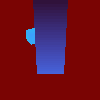

In [105]:
b.get_depth_image(test_imgs[IDX,...,-1])

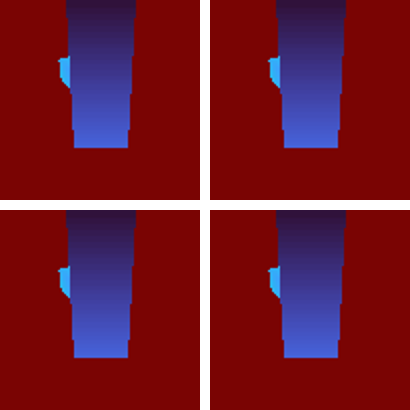

In [92]:
b.vstack_images([
        b.viz_trace_rendered_observed(best_trace1),
        b.viz_trace_rendered_observed(best_trace2),
])

In [48]:
test_labels[IDX]

array([0., 1.], dtype=float32)

[-39727.26 -39746.87]


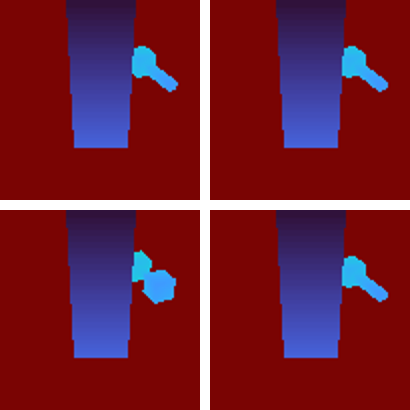

In [47]:
print(jnp.array([best_trace1.get_score(), best_trace2.get_score()]))
b.vstack_images([
        b.viz_trace_rendered_observed(best_trace1),
        b.viz_trace_rendered_observed(best_trace2),
])

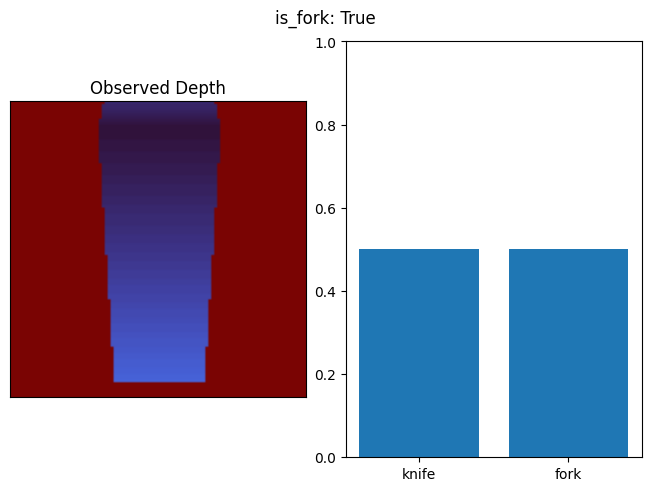

In [100]:
fig = make_orientation_posterior_viz(trace["image"], is_fork, b.utils.normalize_log_scores(jnp.array([best_trace1.get_score(), best_trace2.get_score()])))

In [62]:
is_fork

Array(True, dtype=bool)

In [148]:
b.viz_trace_meshcat(path[2])

In [78]:
idx = jnp.abs(contact_param_gridding_schedule[0] - best_trace1["contact_params_2"]).sum(-1).argmin()
print(best_trace1["contact_params_2"], contact_param_gridding_schedule[0][idx])

[0.11930968 0.         1.5707964 ] [1.1428575e-01 1.4901161e-08 1.3463972e+00]


In [ ]:
    trace = c2f_contact_update_jit(trace, key, contact_param_gridding_schedule[c2f_iter])


In [76]:
weights1 = enumerators[3](trace,key,contact_param_grid)
best_trace1 = enumerators[0](trace, key, contact_param_grid[weights1.argmax()])
b.viz_trace_meshcat(best_trace1)

In [72]:
[t["contact_params_2"] for t in path]

[Array([0., 0., 0.], dtype=float32),
 Array([ 0.11428575, -0.02857143, -2.243995  ], dtype=float32),
 Array([ 0.11428572,  0.        , -1.7951958 ], dtype=float32),
 Array([ 0.1      ,  0.1      , -0.8975979], dtype=float32),
 Array([0.03571429, 0.15      , 0.29919937], dtype=float32),
 Array([-0.01     ,  0.18     , -1.3823009], dtype=float32),
 Array([0.00857143, 0.19      , 0.62831855], dtype=float32),
 Array([0.  , 0.19, 0.  ], dtype=float32),
 Array([-0.05,  0.15,  0.  ], dtype=float32)]

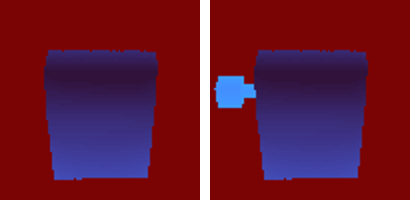

In [63]:
b.viz_trace_rendered_observed(trace)

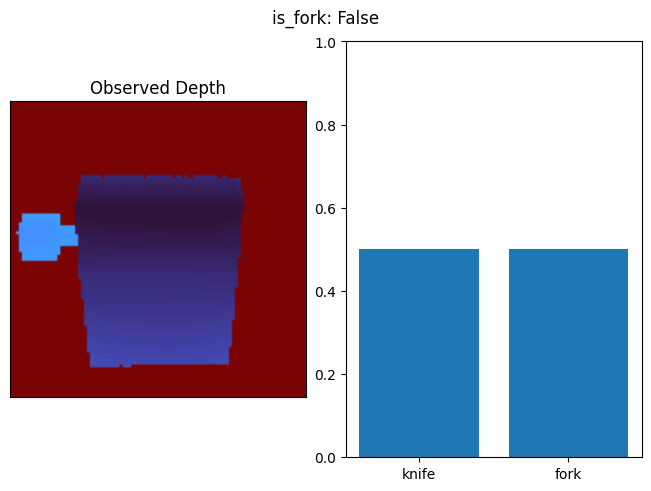

In [48]:
# pathlib.Path('knife_fork_results').mkdir(parents=True, exist_ok=True) 
experiment_iteration = 0
# for experiment_iteration in tqdm(range(10)):
# key = jax.random.split(key, 1)[0]
# is_fork = jax.random.bernoulli(key)
# key = jax.random.split(key, 1)[0]
# shift = SHIFT_MIN + SHIFT_SCALE * jax.random.uniform(key)
# print(shift, is_fork)
# observation = fork_spoon_generator_jit(0.12, is_fork)
# observation = observation[...,:3]


weights1 = enumerators[3](trace,key,contact_param_grid)
best_trace1 = enumerators[0](trace, key, contact_param_grid[weights1.argmax()])

trace = update_jit(key, trace, genjax.choice_map({"id_2": FORK_IDX}), b.make_unknown_change_argdiffs(trace))[2]
weights2 = enumerators[3](trace,key,contact_param_grid)
best_trace2 = enumerators[0](trace, key, contact_param_grid[weights2.argmax()])

fig = make_orientation_posterior_viz(observation, is_fork, b.utils.normalize_log_scores(jnp.array([weights1.max(), weights2.max()])))
# fig.savefig(f'knife_fork_results/{experiment_iteration:05d}.png')


In [ ]:
fig = make_orientation_posterior_viz(observation, is_fork, b.utils.normalize_log_scores(jnp.array([weights1.max(), weights2.max()])))
fig.savefig(f'knife_fork_results/{experiment_iteration:05d}.png')


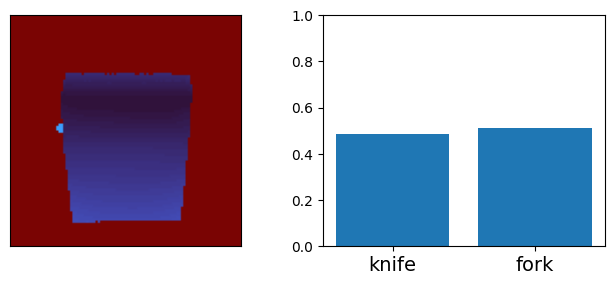

In [89]:
def make_orientation_posterior_viz(observation, is_fork, bars):
    f = plt.figure(figsize=(8,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    x = np.linspace(0,4,1000)
    
    ax.imshow(jnp.array(b.get_depth_image(observation[...,2])))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.set_title(f"Observation (params {gt_contact[0]:0.2f} {gt_contact[1]:0.2f} {gt_contact[2]:0.2f})")
    # ax.set_title(f"Observed Depth")
    
    
    ax2.bar(["knife", "fork"], bars)
    ax2.set_ylim(0.0, 1.0)
    ax2.set_xticks([0,1],labels=["knife", "fork"], fontsize=14)
    return f
f = make_orientation_posterior_viz(observation, is_fork, b.utils.normalize_log_scores(jnp.array([weights1.max(), weights2.max()])))


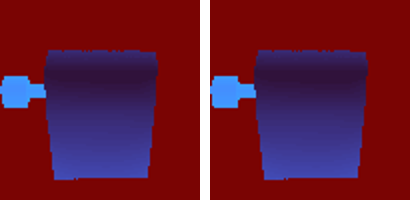

In [20]:
b.viz_trace_rendered_observed(best_trace1)

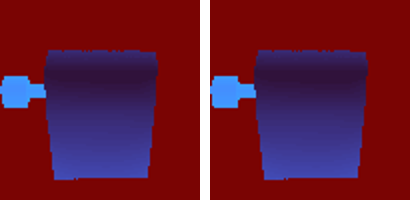

In [21]:
b.viz_trace_rendered_observed(best_trace2)